# Purpose

In this Notebook, you can follow along as I create a prototype model of the ticket arbitrage market. The goal here is 2 fold:

1. Create a predictive algorithm that can determine which events would have the greatest profit opportunity on the ticket resale market
2. Rank those opportunities by both return and risk


------------------

# Data Cleaning

First, we'll pull in our datasets for analysis. The data will be pulled from a local SQL database that has been prefilled by me with tables from 2 sources:

**Ticketmaster**: 

- contains data of all US music events listed on Ticketmaster
- each row represents an event



**Stubhub**: 

- contains data for all events in the Ticketmaster table for which a match was also found in the Stubhub DB
- each row represents a time series instance of a ticket listing
- ticket listing data was pulled twice a day for 6 days from 07/29 - 08/03 for a total of 12 time series instances
- contains time dependant features important for our analysis such as *listing price* and *total ticket count*
- each listing contains the event ID for the related Ticketmaster event to simplify joins

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import requests
import json
import sqlite3
import base64
from datetime import datetime, timedelta

In [2]:
## Pull datasets from SQL DB

# Establish SQL connection
conn = sqlite3.connect('Ticket Information.db')
curs = conn.cursor()

# Pull Ticketmaster data into DF
tm_events = pd.read_sql_query('''SELECT
                                  *
                                FROM
                                  ticketmaster_events
                              ''',
                              conn
                             )


# Pull Stubhub data into DF
sh_pricing = pd.read_sql_query('''SELECT
                                    currentPrice,
                                    quantity,
                                    totalListings,
                                    totalTickets,
                                    datetime,
                                    tm_Id
                                  FROM
                                    stubhub_listings
                               ''',
                              conn
                             )

# Close connection
curs.close()
conn.close()

print(tm_events.shape)
print(sh_pricing.shape)

(11982, 35)
(3993546, 6)


We have over 10,000 events in our ticketmaster dataset.

Because our analysis is a time series on an event level, we will group our Stubhub data by the datetime that data was pulled as well as the Ticketmaster event ID. It is important to note that in our grouping we are pulling the **median price of all stubhub listings for a given event**.

We will then join our tables along the Ticketmaster event ID.

In [3]:
## Joining tables

# Grouping listings values by event and datetime - aggregating price using Median
sh_pricing = sh_pricing.groupby(['datetime','tm_Id']).median()
sh_pricing = sh_pricing.reset_index()

# Joining Ticketmaster and StubHub data
tm_events.rename(columns={'eventId':'tm_Id'}, inplace=True)
df = sh_pricing.merge(tm_events, how='left', on='tm_Id')

# Delete index column left over from SQL pull
del df['index']

print(df.shape)
df.head()

(69816, 39)


datetime              tm_Id  currentPrice  quantity  \
0  2018-07-28 20:07:11.641050     vvG1OZ4GSCsfP5        44.500       6.0   
1  2018-07-28 20:07:11.916138  vv1AaZA8MGkdobIGv       145.300       4.0   
2  2018-07-28 20:07:12.168777     vvG1YZ4FN4RVj_       164.500       4.0   
3  2018-07-28 20:07:12.413427     vvG1bZ4Gh5VfTj       109.300       3.0   
4  2018-07-28 20:07:12.621657     vvG10Z4uBJBeLJ        64.775       9.0   

   totalListings  totalTickets  \
0            7.0          36.0   
1           11.0          51.0   
2           50.0         191.0   
3           21.0          70.0   
4            4.0          32.0   

                                           eventName classificationGenre  \
0            CloZee Evasion Tour with Special Guests    Dance/Electronic   
1                                      Gino Vannelli                Rock   
2  SiriusXM Pres. Goo Goo Dolls - Dizzy Up The Gi...                Rock   
3                                               Beck                Rock   
4                                    The Expendables                Rock   

  classificationGenreId classificationSubGenre  \
0           KnvZfZ7vAvF             Club Dance   
1           KnvZfZ7vAeA                    Pop   
2           KnvZfZ7vAeA       Alternative Rock   
3           KnvZfZ7vAeA       Alternative Rock   
4           KnvZfZ7vAeA                    Pop   

                ...                  attractionName   attractionGenre  \
0               ...                          Clozee  Dance/Electronic   
1               ...                   Gino Vannelli              Rock   
2               ...                   Goo Goo Dolls              Rock   
3               ...                            Beck              Rock   
4               ...                 The Expendables              Rock   

  attractionGenreId attractionSubGenre attractionSubGenreId attractionCount  \
0       KnvZfZ7vAvF   Dance/Electronic  KZazBEonSMnZfZ7vA1E             2.0   
1       KnvZfZ7vAeA                Pop  KZazBEonSMnZfZ7v6F1             1.0   
2       KnvZfZ7vAeA   Alternative Rock  KZazBEonSMnZfZ7v6dt             1.0   
3       KnvZfZ7vAeA   Alternative Rock  KZazBEonSMnZfZ7v6dt             2.0   
4       KnvZfZ7vAeA                Pop  KZazBEonSMnZfZ7v6F1             4.0   

   multiGenres  multiSubGenres artist_totalupcomingEvents  \
0          0.0             1.0                       15.0   
1          0.0             0.0                        8.0   
2          0.0             0.0                       44.0   
3          1.0             1.0                       16.0   
4          1.0             1.0                        2.5   

  artist_ticktmasterupcomingEvents  
0                             5.00  
1                             3.00  
2                            35.00  
3                            11.00  
4                             2.25  

[5 rows x 39 columns]

We now have a data set with information for a few thousand events over the course of a few days

# KPI Engineering

Next, we'll make a few adjustments to the time-based features that are necessary for our analysis:
- converting string to datetime format
- crafting 'time_from_sale' and 'time_to_event' features

In [4]:
## Adjust string to datetime type

# Remove null values
df = df[df.onsaleStartDateTime.notnull()]

# Set function for TM string syntax
def tm_str_to_date (x):
    if x:
        return datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')

# Set function for SH string syntax
def sh_str_to_date (x):
    if x:
        return datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')

# Convert datetime columns
df['eventStartDateTime'] = df.eventStartDateTime.apply(tm_str_to_date)
df['onsaleStartDateTime'] = df.onsaleStartDateTime.apply(tm_str_to_date)
df['datetime'] = df.datetime.apply(sh_str_to_date)

print(df.shape)

(66665, 39)


In [5]:
## Create time_from_sale & time_to_event features    

df['time_from_sale'] = df['datetime'] - df['onsaleStartDateTime']
df['time_to_event'] = df['eventStartDateTime'] - df['datetime']

df[['time_from_sale','time_to_event']].describe()

time_from_sale             time_to_event
count                      66665                     66665
mean     90 days 11:14:54.069793   64 days 04:21:35.644329
std      67 days 16:42:10.791231   47 days 10:13:51.934302
min    -54 days +22:25:17.373473  -1 days +22:32:40.260534
25%      43 days 05:11:47.275418   28 days 16:54:15.675119
50%      78 days 09:22:00.538407   58 days 12:46:53.796231
75%     120 days 14:25:17.355775   87 days 18:41:32.483381
max     463 days 09:47:01.713806  410 days 06:29:42.420310

The overall distribution looks great, with a sizeable amount of variance in both features. There are some odd outliers in time_from_sale that have negative values (meaning the TM sale start date is before the time the listing was pulled).

This could be harmless, but it's also possible that this is as a result of some observations in our join gone haywire - let's double check.

In [6]:
df[df['time_from_sale']<timedelta(days=0)][['time_from_sale','eventName', 'classificationGenre','eventStatus','attractionName','attractionGenreId']]

time_from_sale  \
629   -10 days +01:10:42.743661   
850   -20 days +03:12:15.235347   
2850  -13 days +05:33:30.155382   
3747  -16 days +06:47:34.529987   
4249  -13 days +05:56:09.534950   
4640   -6 days +06:03:52.682665   
4954  -21 days +07:10:12.029112   
6191  -10 days +10:05:08.307488   
6412  -20 days +12:06:42.689014   
8408  -13 days +15:36:43.558600   
9306  -16 days +16:50:25.310524   
9808  -13 days +15:59:22.502062   
10199  -6 days +16:07:05.434248   
10514 -21 days +17:13:32.014514   
11752 -10 days +22:16:11.599507   
11973 -19 days +00:17:41.810458   
13977 -12 days +02:38:15.766523   
14878 -15 days +03:51:24.162662   
15383 -12 days +02:59:33.602527   
15774  -5 days +03:06:38.692796   
16089 -20 days +04:12:44.827164   
17331  -9 days +11:06:15.219198   
17552 -19 days +13:07:53.760273   
19555 -12 days +15:28:55.858610   
20456 -15 days +16:42:01.186405   
20962 -12 days +15:50:11.566640   
21352  -5 days +15:57:09.126351   
21666 -20 days +17:03:21.535337   
22907  -9 days +21:36:52.189785   
23127 -19 days +23:38:38.448842   
...                         ...   
50442 -54 days +22:25:17.373473   
51773  -6 days +22:32:37.561110   
52040 -15 days +00:34:56.579667   
53842 -28 days +03:54:39.550917   
54360  -1 days +03:01:33.418608   
54392  -8 days +03:01:58.104708   
55454 -11 days +04:17:10.377489   
56033  -8 days +03:37:18.372615   
56474  -1 days +03:44:39.200105   
56841 -16 days +04:50:52.731665   
56932 -53 days +04:52:27.584795   
57604  -8 days +23:35:40.215273   
58043  -1 days +23:39:23.349260   
58406 -15 days +00:47:29.823777   
58495 -52 days +00:48:33.149320   
59812  -5 days +21:01:46.221019   
60075 -15 days +23:04:50.899509   
61859 -27 days +02:31:45.424985   
62407  -7 days +01:41:45.381984   
63078  -6 days +02:54:35.151149   
63456 -10 days +03:02:25.190022   
64620  -3 days +05:53:42.178501   
64862 -13 days +07:55:54.831910   
66515 -26 days +11:12:46.694669   
67024  -6 days +10:18:43.282724   
67981  -9 days +11:31:55.078942   
68489  -6 days +10:39:34.190176   
68900 -14 days +10:46:15.405772   
69199 -14 days +11:51:11.811535   
69275 -51 days +11:52:29.107570   

                                               eventName classificationGenre  \
629                                          Pat Metheny                Jazz   
850                                                  WAR                 R&B   
2850                                                 TLC         Hip-Hop/Rap   
3747       Home For The Holidays Columbus Jazz Orchestra                Jazz   
4249                            The Charlie Daniels Band             Country   
4640                                      The Chieftains                 Pop   
4954   The World's Largest Disco - VIP Party Presente...    Dance/Electronic   
6191                                         Pat Metheny                Jazz   
6412                                                 WAR                 R&B   
8408                                                 TLC         Hip-Hop/Rap   
9306       Home For The Holidays Columbus Jazz Orchestra                Jazz   
9808                            The Charlie Daniels Band             Country   
10199                                     The Chieftains                 Pop   
10514  The World's Largest Disco - VIP Party Presente...    Dance/Electronic   
11752                                        Pat Metheny                Jazz   
11973                                                WAR                 R&B   
13977                                                TLC         Hip-Hop/Rap   
14878      Home For The Holidays Columbus Jazz Orchestra                Jazz   
15383                           The Charlie Daniels Band             Country   
15774                                     The Chieftains                 Pop   
16089  The World's Largest Disco - VIP Party Presente...    Dance/Electronic   
17331                                        Pat Metheny                Jazz   
17552 

It appears that all these events are listed as offsale - good news. This is most likely simply an indicator that Ticketmaster has not started selling the tickets yet, but it's likely that they're being sold (and relisted) off other sites.

We'll trend towards not removing data points, as this could still prove to be an interesting indicator for us

----------------------

Here we will also engineer our key features relevant for our analysis. In particular we will be focusing on 2 metrics:

1. **Percent Price Difference** - the difference in price between Ticketmaster's wholesale listing price and Stubhub's median resale price. Used to represent return.
2. **Percent Change in Tickets** - the difference in ticket count between the current time series value and the next. Used to represent risk.

In [7]:
## Create expected percent change in total listed tickets per observation

# Sort DF by date in descending order
df.sort_values(by='datetime', ascending=False, inplace=True)

# Create empty DF to store difference values
tix_diffs = pd.DataFrame()

# Run for loop grouping by event ID, and take differences across time series entries
for tm_id in df['tm_Id'].unique():
    diffs = df[df.tm_Id == tm_id][['totalListings','totalTickets']].diff()
    tix_diffs = tix_diffs.append(diffs)
    
# Join columns to main DF
tix_diffs.rename(columns={'totalListings':'listings_diff', 'totalTickets':'tickets_diff'}, inplace=True)
df = df.join(tix_diffs)

# Create percent difference
df['percent_change_listings'] = (df['listings_diff']/df['totalListings'])*100
df['percent_change_tickets'] = (df['tickets_diff']/df['totalTickets'])*100

df[['listings_diff', 'tickets_diff', 'percent_change_listings', 'percent_change_tickets']].describe()

listings_diff  tickets_diff  percent_change_listings  \
count   60349.000000  60349.000000             60349.000000   
mean        0.749524      3.308555               -77.264963   
std        58.569094    212.561322               740.741775   
min     -1430.000000  -4850.000000            -29400.000000   
25%         0.000000      0.000000                 0.000000   
50%         0.000000      0.000000                 0.000000   
75%         1.000000      4.000000                 0.769231   
max      1360.000000   4850.000000                99.845679   

       percent_change_tickets  
count            60349.000000  
mean               -60.141702  
std                590.831140  
min             -20850.000000  
25%                  0.000000  
50%                  0.000000  
75%                  1.043997  
max                 99.750312

In [8]:
## Create feature for difference in median price

df['percent_diff_price'] = ((df['currentPrice']-(df['maxPrice']+df['minPrice'])/2)/(df['maxPrice']+df['minPrice']))*100
df['percent_diff_price'].describe()

count    66665.000000
mean       107.361603
std        619.773398
min        -48.390873
25%         34.874074
50%         59.849246
75%         93.474576
max      91785.194444
Name: percent_diff_price, dtype: float64

We have some extreme values here on either end - we will address these in the following section

# Data Visualization & Relationships

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

sns.set_palette('Blues_r')
matplotlib.rcParams.update({'font.family': 'arial'})

Next, we will explore the distributions of our engineered metrics and their relationships to some of our other features

## Outliers

First we want to take a look at the distribution of our engineered metrics and check for outliers

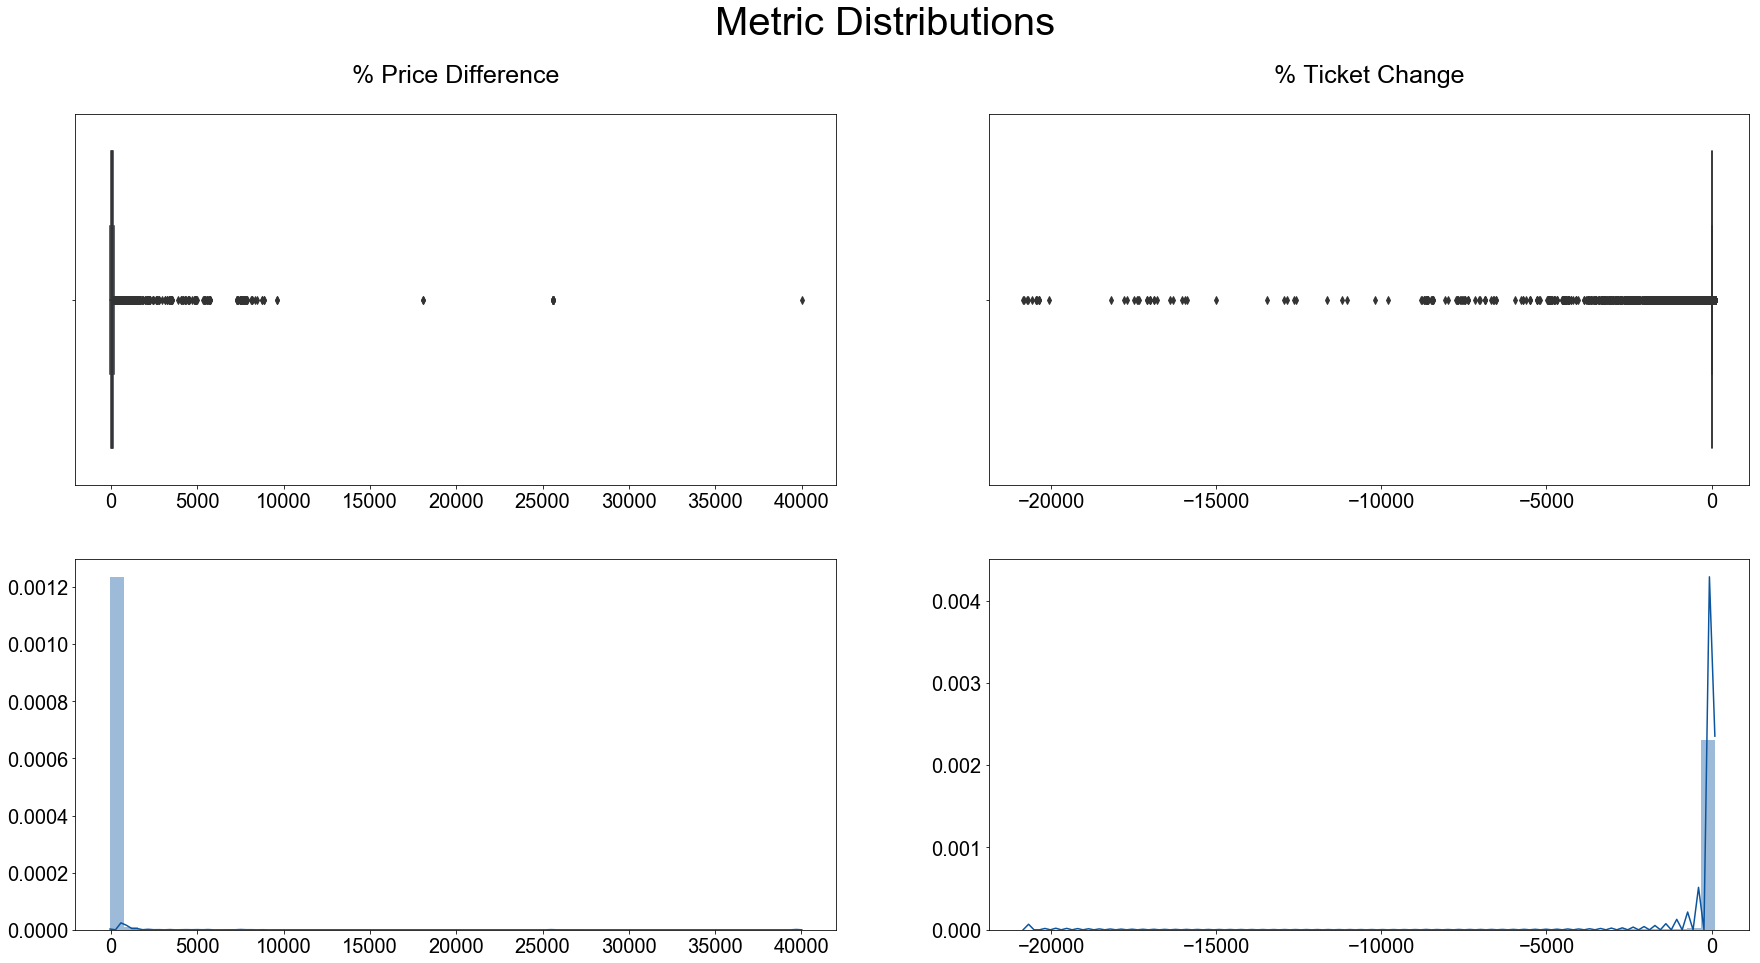

In [10]:
# Set data for analysis excluding most recent pull (this would give us NaN values on our change in ticket quantity)
df_analysis = df[df.percent_change_tickets.notnull()]

# Set plot size and plot boxplots and histograms
f, ax = plt.subplots(figsize=(30,15))

plt.subplot(2,2,1)
sns.boxplot(df_analysis.percent_diff_price)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.title('% Price Difference\n', fontsize=25)

plt.subplot(2,2,2)
sns.boxplot(df_analysis.percent_change_tickets)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.title('% Ticket Change\n', fontsize=25)

plt.subplot(2,2,3)
sns.distplot(df_analysis.percent_diff_price)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('% Price Difference - Histogram', fontsize=25)

plt.subplot(2,2,4)
sns.distplot(df_analysis.percent_change_tickets)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('% Ticket Change - Histogram', fontsize=25)

plt.suptitle('Metric Distributions\n', fontsize=40)
plt.show()

The mins and maxes of any distribution are important, as they provide us with the 'exceptions to the rule' (eg. the variance), the distinctions between observations that ultimately help to find trends, build our models, and make accurate predictions.

In this case however, there are clearly some extreme outliers that do not help us target what we're looking for. Most of these extreme outliers are either:

- Errors in merges/database pulls

- Resellers poorly/improperly pricing tickets and rapidly changing or pulling down either costs or listings

Let's explore by quantile to see if we can pinpoint exactly where we see behavior that would indicate data not suited for analysis

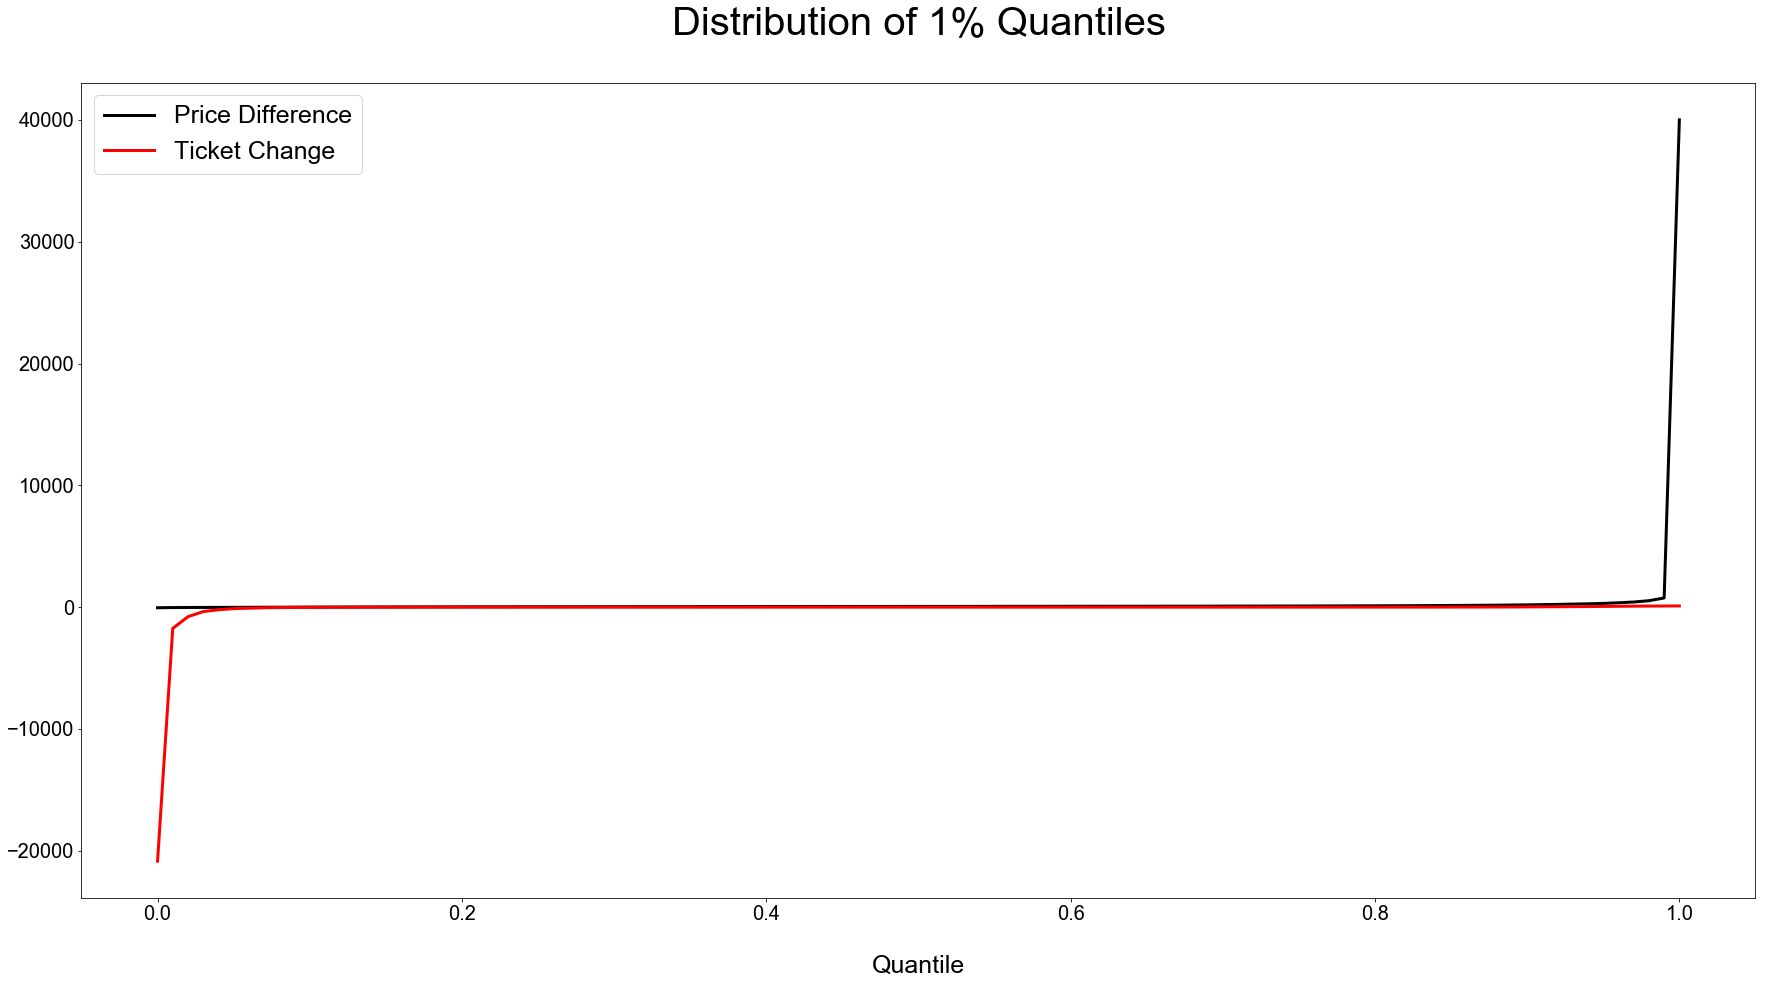

In [11]:
# Plot 1% percentiles to determine best outlier sorting

quantiles = [x/100 for x in range(101)]

quantiles_price_diff = [df_analysis['percent_diff_price'].quantile(q=x) for x in quantiles]
quantiles_price_diff = pd.DataFrame(data={'quantiles':quantiles, 'price_diff':quantiles_price_diff})

quantiles_ticket_change = [df_analysis['percent_change_tickets'].quantile(q=x) for x in quantiles]
quantiles_ticket_change = pd.DataFrame(data={'quantiles':quantiles, 'ticket_change':quantiles_ticket_change})

f,ax = plt.subplots(figsize=(30,15))
plt.plot(quantiles_price_diff.quantiles, quantiles_price_diff.price_diff, 'k', label='Price Difference', linewidth=3.0)
plt.plot(quantiles_ticket_change.quantiles, quantiles_ticket_change.ticket_change, 'r', label='Ticket Change', linewidth=3.0)
plt.xlabel('\nQuantile', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)
plt.title('Distribution of 1% Quantiles\n', fontsize=40)
plt.show()

There are some truly absurd values at the 1% margins on either end. Let's remove those and take another look

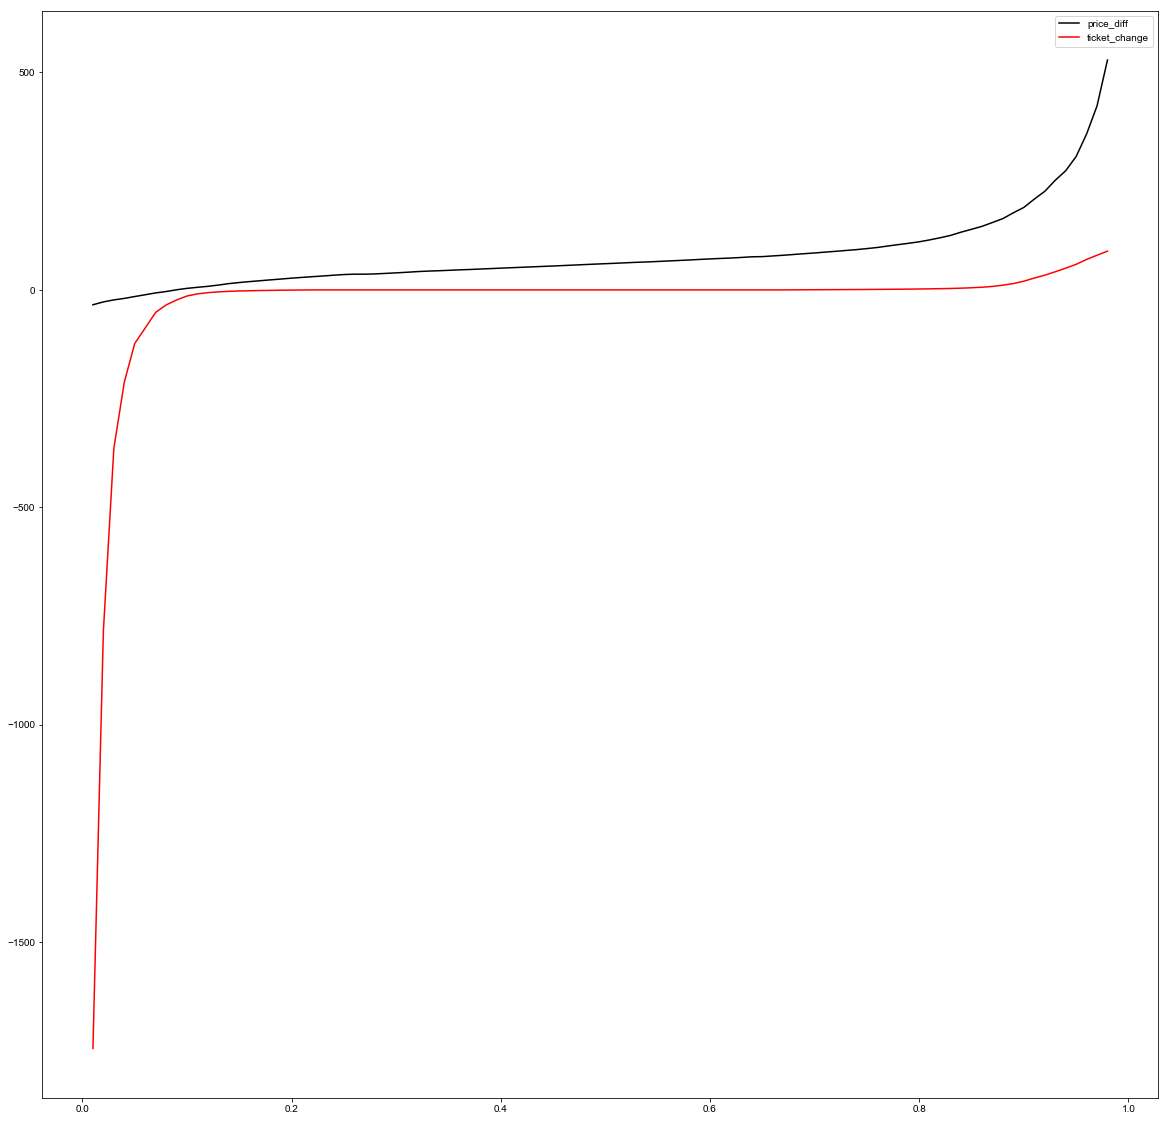

In [12]:
# Plot percentiles with top and bottom 1% removed to determine best outlier sorting

f,ax = plt.subplots(figsize=(20,20))
plt.plot(quantiles_price_diff.iloc[1:99,:].quantiles, quantiles_price_diff.iloc[1:99,:].price_diff, 'k')
plt.plot(quantiles_ticket_change.iloc[1:99,:].quantiles, quantiles_ticket_change.iloc[1:99,:].ticket_change, 'r')
plt.legend()
plt.show()

Much better. There are still some oddities at the low end of the ticket quantity counter - we shouldn't be seeing the count of tickets decreasing by over 100% in any instance.

It looks like all of these value occur below the 6% percentile marker. Let's remove these values as well, and replot our distributions

In [13]:
quantiles_ticket_change

quantiles  ticket_change
0         0.00  -20850.000000
1         0.01   -1743.918367
2         0.02    -784.155844
3         0.03    -364.400833
4         0.04    -212.005517
5         0.05    -123.011179
6         0.06     -87.500000
7         0.07     -51.529412
8         0.08     -34.578163
9         0.09     -23.076923
10        0.10     -13.953488
11        0.11      -9.090909
12        0.12      -6.250000
13        0.13      -4.493281
14        0.14      -3.278689
15        0.15      -2.469136
16        0.16      -1.897233
17        0.17      -1.428571
18        0.18      -1.046419
19        0.19      -0.706564
20        0.20      -0.443656
21        0.21      -0.209644
22        0.22       0.000000
23        0.23       0.000000
24        0.24       0.000000
25        0.25       0.000000
26        0.26       0.000000
27        0.27       0.000000
28        0.28       0.000000
29        0.29       0.000000
..         ...            ...
71        0.71       0.535275
72        0.72       0.653509
73        0.73       0.769231
74        0.74       0.894188
75        0.75       1.043997
76        0.76       1.194030
77        0.77       1.379310
78        0.78       1.589154
79        0.79       1.821192
80        0.80       2.105263
81        0.81       2.449889
82        0.82       2.857143
83        0.83       3.370181
84        0.84       4.001899
85        0.85       4.940753
86        0.86       6.206897
87        0.87       8.000000
88        0.88      10.873114
89        0.89      14.622642
90        0.90      20.000000
91        0.91      27.272727
92        0.92      33.787541
93        0.93      41.666667
94        0.94      50.000000
95        0.95      58.771930
96        0.96      70.004520
97        0.97      79.719176
98        0.98      89.147287
99        0.99      94.594595
100       1.00      99.750312

[101 rows x 2 columns]

In [14]:
# Sort and separate data into max outliers and min outliers

df_analysis.sort_values('percent_diff_price', inplace=True)
df_analysis_min = df_analysis.iloc[:round(len(df_analysis)*.015),:]
df_analysis_max = df_analysis.iloc[round(len(df_analysis)*.985):,:]

df_analysis.sort_values('percent_change_tickets', inplace=True)
df_analysis_min = df_analysis_min.append(df_analysis.iloc[:round(len(df_analysis)*.055),:])
df_analysis_min.drop_duplicates(inplace=True)
df_analysis_max = df_analysis_max.append(df_analysis.iloc[round(len(df_analysis)*.985):,:])
df_analysis_max.drop_duplicates(inplace=True)

/Users/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Albert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


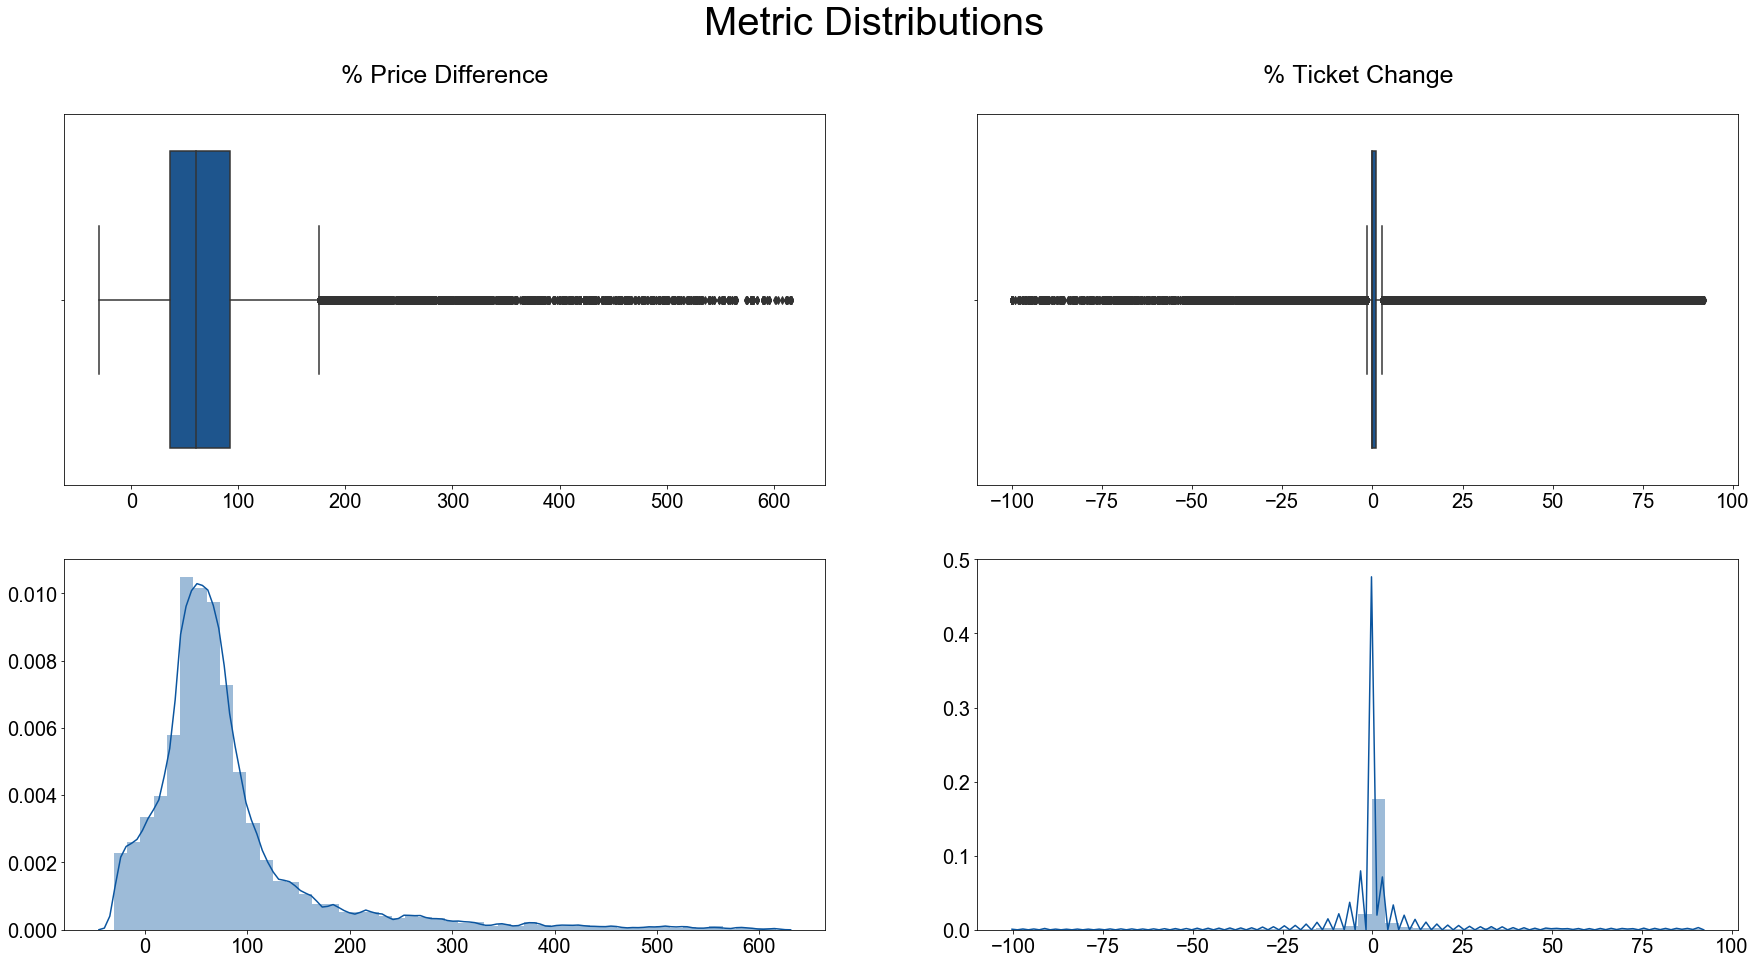

In [15]:
# Remove mins and maxes from dataset for analysis
max_min_index = list(df_analysis_min.index) + (list(df_analysis_max.index))
main_idx = [x for x in list(df_analysis.index) if x not in list(max_min_index)]
df_analysis = df_analysis.loc[main_idx,:]

# Plot new boxplots and histograms
f, ax = plt.subplots(figsize=(30,15))

plt.subplot(2,2,1)
sns.boxplot(df_analysis.percent_diff_price)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.title('% Price Difference\n', fontsize=25)

plt.subplot(2,2,2)
sns.boxplot(df_analysis.percent_change_tickets)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.title('% Ticket Change\n', fontsize=25)

plt.subplot(2,2,3)
sns.distplot(df_analysis.percent_diff_price)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplot(2,2,4)
sns.distplot(df_analysis.percent_change_tickets)
plt.xlabel('')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.suptitle('Metric Distributions\n', fontsize=40)
plt.show()

That looks much more reasonable

### Exploring Segments

Now that we have our data set for analysis, let's begin to explore some data segments. We'll start with visualizing how these values change over time

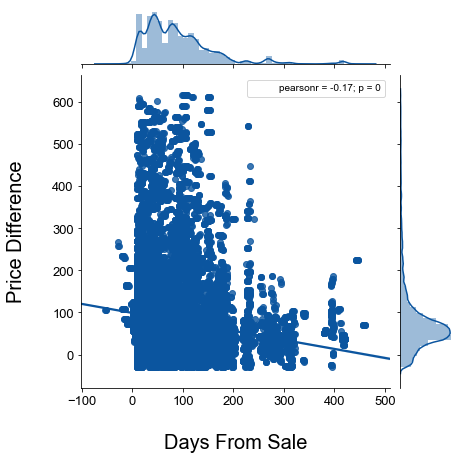

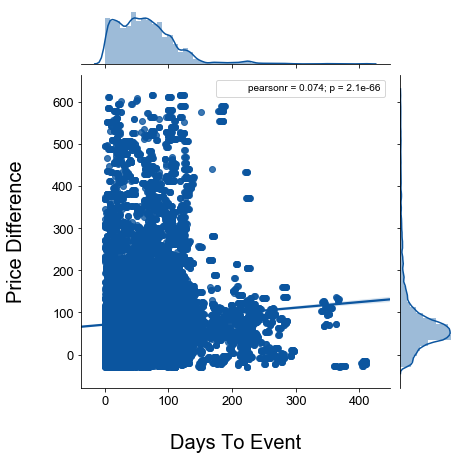

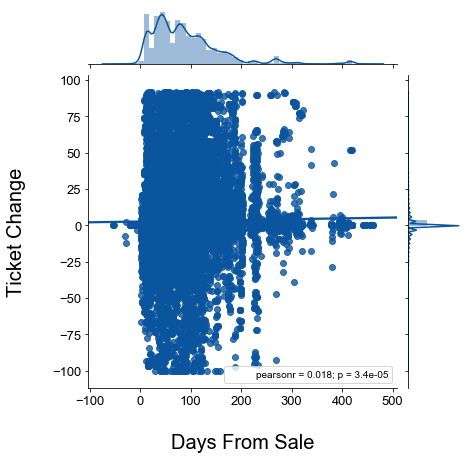

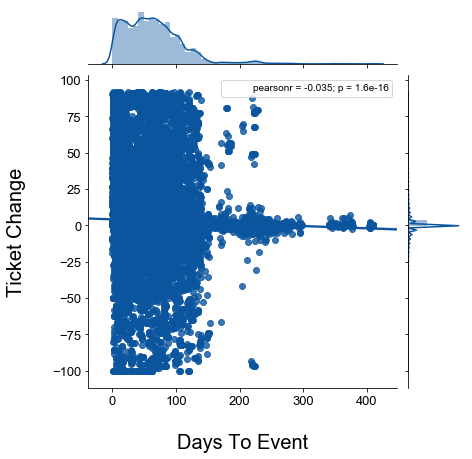

In [16]:
# Create time metrics for hours and days
df_analysis['days_from_sale'] = df_analysis.time_from_sale.apply(lambda x: x.days)
df_analysis['days_to_event'] = df_analysis.time_to_event.apply(lambda x: x.days)

# Plot change in price and ticket quantity over time
sns.jointplot(data=df_analysis, x='days_from_sale', y='percent_diff_price', kind='reg')
plt.xlabel('\nDays From Sale', fontsize=20)
plt.ylabel('Price Difference\n', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.jointplot(data=df_analysis, x='days_to_event', y='percent_diff_price', kind='reg')
plt.xlabel('\nDays To Event', fontsize=20)
plt.ylabel('Price Difference\n', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.jointplot(data=df_analysis, x='days_from_sale', y='percent_change_tickets', kind='reg')
plt.xlabel('\nDays From Sale', fontsize=20)
plt.ylabel('Ticket Change\n', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.jointplot(data=df_analysis, x='days_to_event', y='percent_change_tickets', kind='reg')
plt.xlabel('\nDays To Event', fontsize=20)
plt.ylabel('Ticket Change\n', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

The linear relationship between the days from and to the event, and our metrics of interest, are all quite weak.

A few interesting observations and trends to potentially keep track of however:

- People will price their resale tickets more highly immediately after the initial ticket sales, as the market settles down and clarifies pricing
- People will decrease resale ticket prices closer to the event as they feel more pressure to sell
- More people will add tickets to the site the closer they get to the event as casual concert goers try to resell tickets for events they can't make

#### Genre & SubGenre

Next, we'll review genre and subgenre impacts on the variables

In [17]:
# Highlight different genres and subgenres

print(df_analysis.classificationGenre.unique())
print(df_analysis.classificationSubGenre.unique())

# Delete genres with inadequate amount of data
df_analysis = df_analysis[df_analysis.classificationGenre != 'Chanson Francaise']
df_analysis = df_analysis[df_analysis.classificationGenre != 'Holiday']
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'Bluegrass']
df_analysis.classificationSubGenre.fillna('Undefined', inplace=True)
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'None']
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'Christmas Music']
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'German Rock']
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'Hawaiian']
df_analysis = df_analysis[df_analysis.classificationSubGenre != 'French Rap']

['Hip-Hop/Rap' 'Jazz' 'R&B' 'Country' 'Pop' 'Religious' 'Rock' 'Reggae'
 'Undefined' 'Dance/Electronic' 'Blues' 'World' 'Metal' 'Folk' 'Other'
 'Chanson Francaise' 'Classical' 'New Age' 'Ballads/Romantic' 'Holiday']
['French Rap' 'Jazz' 'R&B' 'Country' 'Pop' 'Gospel' 'Alternative Rock'
 'Reggae' 'Undefined' 'Club Dance' 'Blues' 'World' 'Heavy Metal' 'Folk'
 'Urban' 'Latin' 'Flamenco' 'Other' 'Chanson Francaise' 'Classical/Vocal'
 'Punk' 'New Age' 'Adult Contemporary' 'Oldies & Classics' 'Soul'
 'Hawaiian' None 'Ballads/Romantic' 'Reggaeton' 'Funk' 'Bluegrass'
 'Christmas Music' 'German Rock']


In [18]:
# Create function to run Kruskal-Wallis test on a continuous variable grouped by role 

def kw_test(metric, test_feature):
    groups = []
    category_set = df_analysis[test_feature].unique()
    for category in category_set:
        groups.append(np.array(df_analysis[df_analysis[test_feature] == category][metric]))
    
    return groups

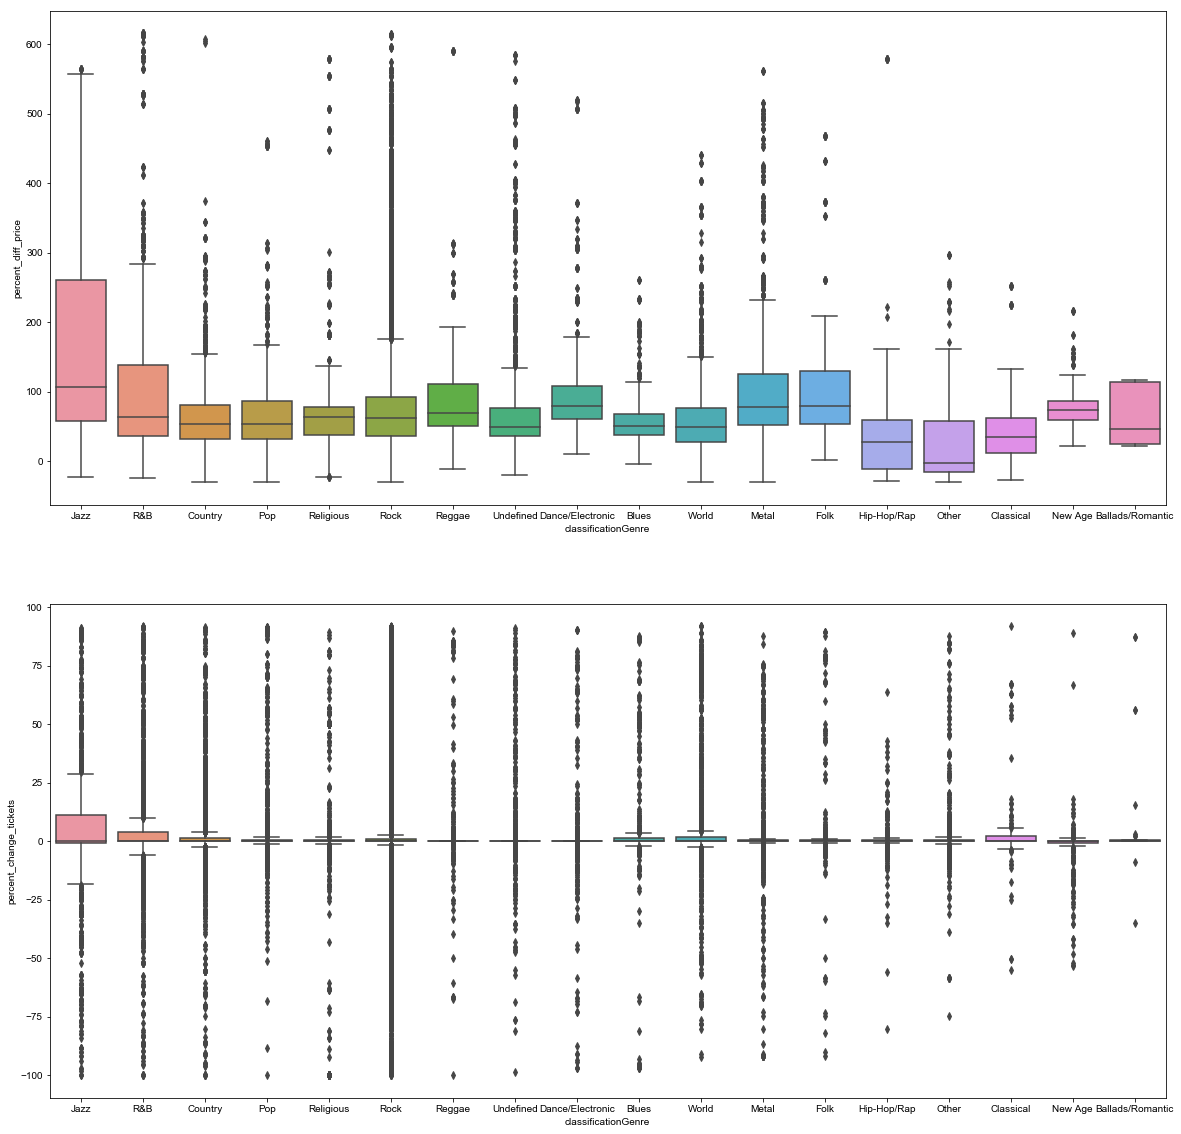

In [19]:
f, ax = plt.subplots(figsize=(20,20))

plt.subplot(2,1,1)
sns.boxplot(data=df_analysis, x='classificationGenre', y='percent_diff_price')

plt.subplot(2,1,2)
sns.boxplot(data=df_analysis, x='classificationGenre', y='percent_change_tickets')

plt.show()

In [20]:
groups = kw_test('percent_change_tickets', 'classificationGenre')
stats.kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7],
              groups[8], groups[9], groups[10], groups[11], groups[12], groups[13], groups[14], groups[15])

KruskalResult(statistic=224.7743091628537, pvalue=1.879451396337983e-39)

In [21]:
groups = kw_test('percent_diff_price', 'classificationGenre')
stats.kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7],
              groups[8], groups[9], groups[10], groups[11], groups[12], groups[13], groups[14], groups[15])

KruskalResult(statistic=3084.8618445225143, pvalue=0.0)

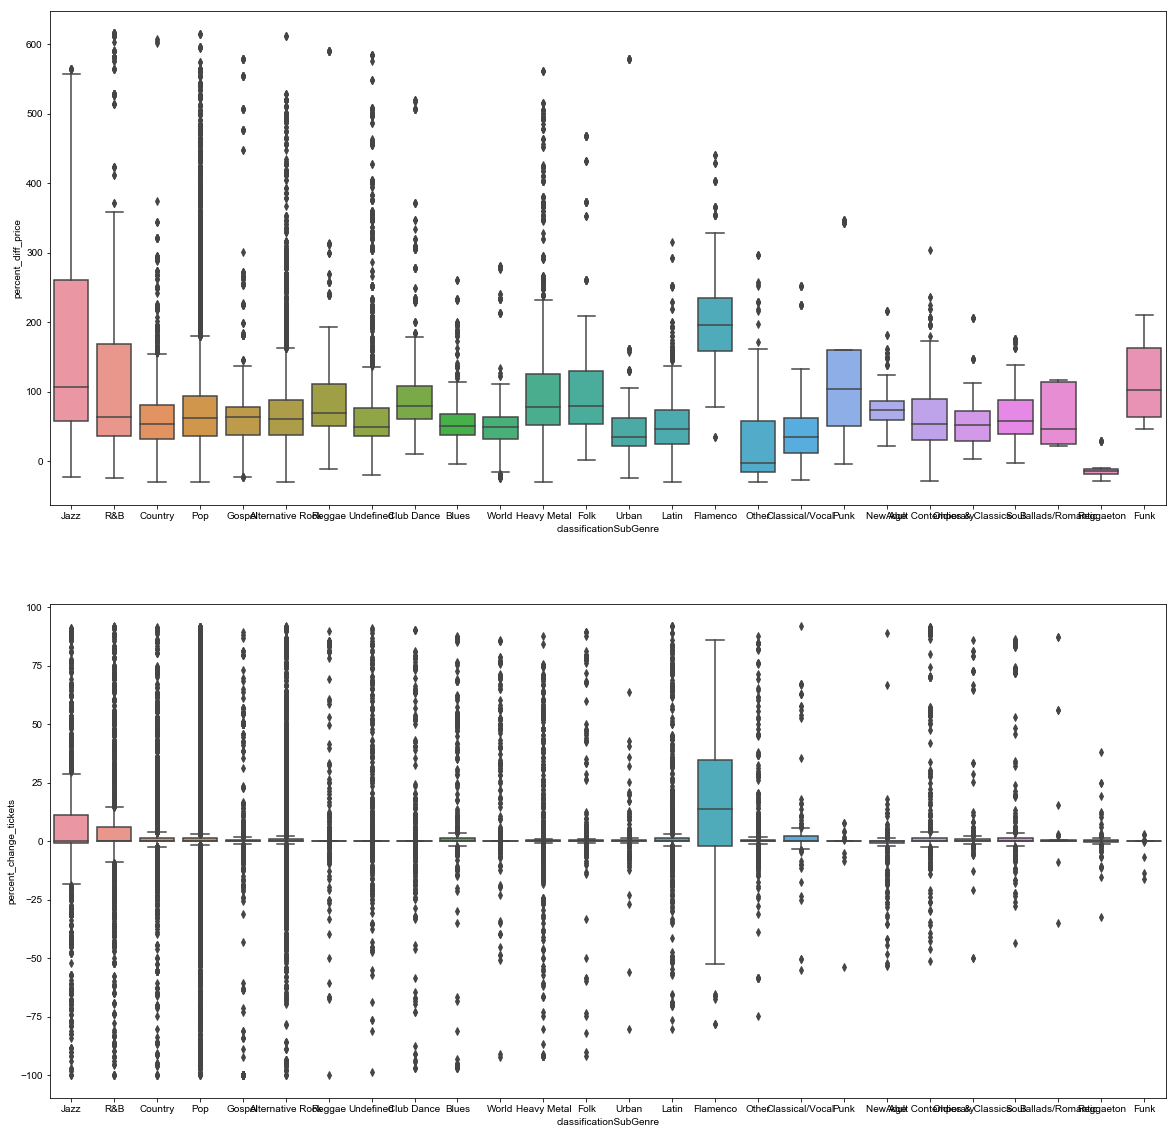

In [22]:
f, ax = plt.subplots(figsize=(20,20))

plt.subplot(2,1,1)
sns.boxplot(data=df_analysis, x='classificationSubGenre', y='percent_diff_price')

plt.subplot(2,1,2)
sns.boxplot(data=df_analysis, x='classificationSubGenre', y='percent_change_tickets')

plt.show()

In [23]:
groups = kw_test('percent_change_tickets', 'classificationSubGenre')
stats.kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7],
              groups[8], groups[9], groups[10], groups[11], groups[12], groups[13], groups[14], groups[15],
              groups[16], groups[17], groups[18], groups[19])

KruskalResult(statistic=351.8419488142574, pvalue=4.250656853230377e-63)

In [24]:
groups = kw_test('percent_diff_price', 'classificationSubGenre')
stats.kruskal(groups[0], groups[1], groups[2], groups[3], groups[4], groups[5], groups[6], groups[7],
              groups[8], groups[9], groups[10], groups[11], groups[12], groups[13], groups[14], groups[15],
              groups[16], groups[17], groups[18], groups[19])

KruskalResult(statistic=3374.1429951383893, pvalue=0.0)

There is a substantially significant impact here, with the p-value at or close to 0 for all our significance tests

This indicates that both the genre and the subgenre are good differentiating features for our model

#### Multiple Genre & Attraction Count

Next, we're going to take a peek at a few binary variables. These variables indicate whether there is more then one artist and more than one genre represented at the event. We'd like to test and see whether there is a statistical difference between our predict metrics between these groups.

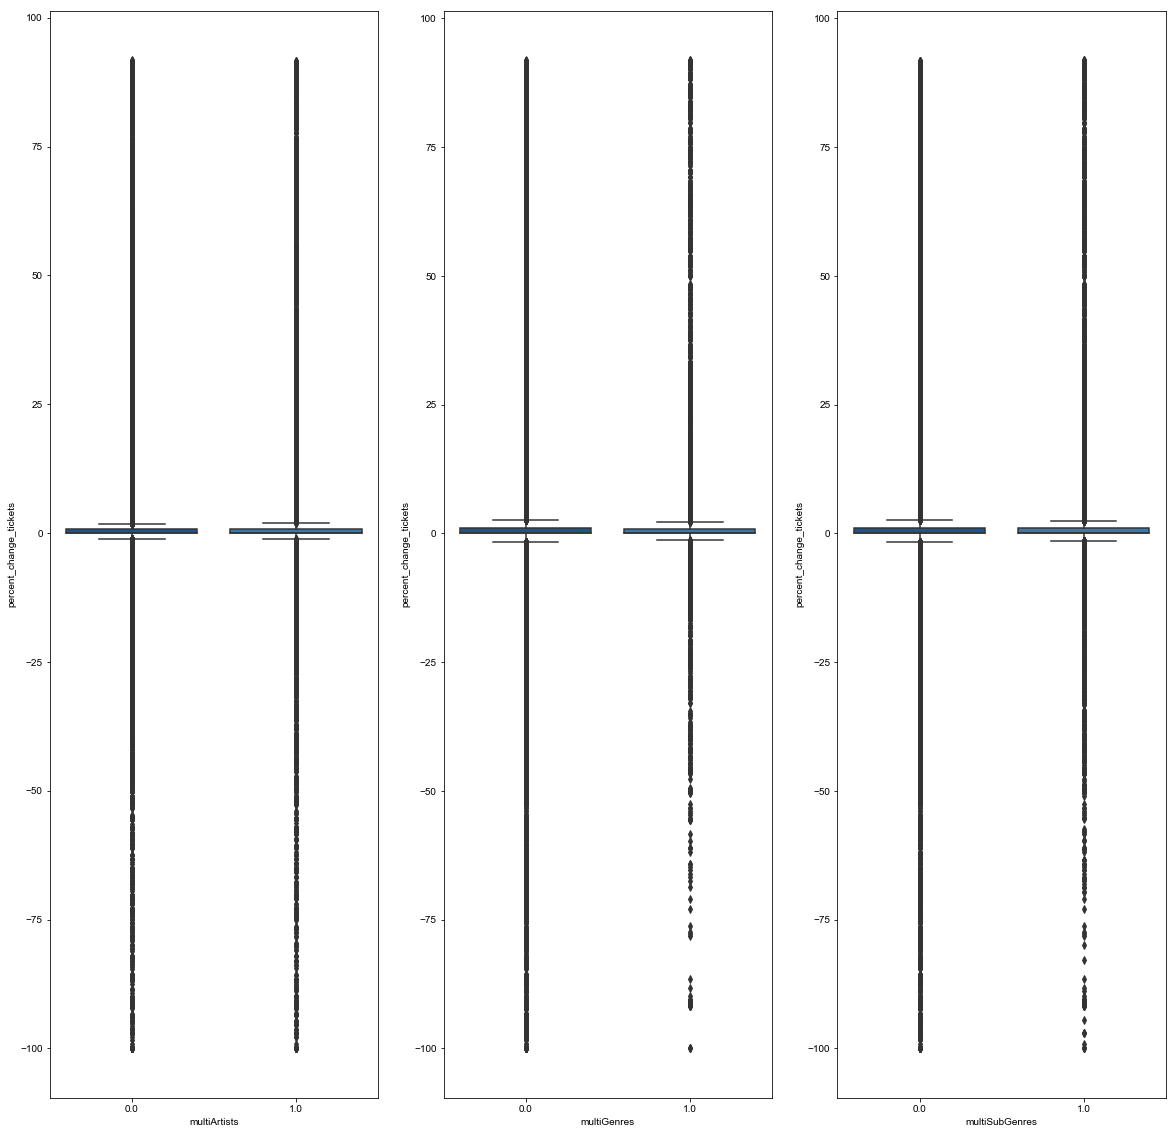

In [25]:
df_analysis['multiArtists'] = pd.Series(np.where(df_analysis.attractionCount > 1, 1, 0))

f, ax = plt.subplots(figsize=(20,20))

plt.subplot(1,3,1)
sns.boxplot(data=df_analysis, x='multiArtists', y='percent_change_tickets')

plt.subplot(1,3,2)
sns.boxplot(data=df_analysis, x='multiGenres', y='percent_change_tickets')

plt.subplot(1,3,3)
sns.boxplot(data=df_analysis, x='multiSubGenres', y='percent_change_tickets')

plt.show()

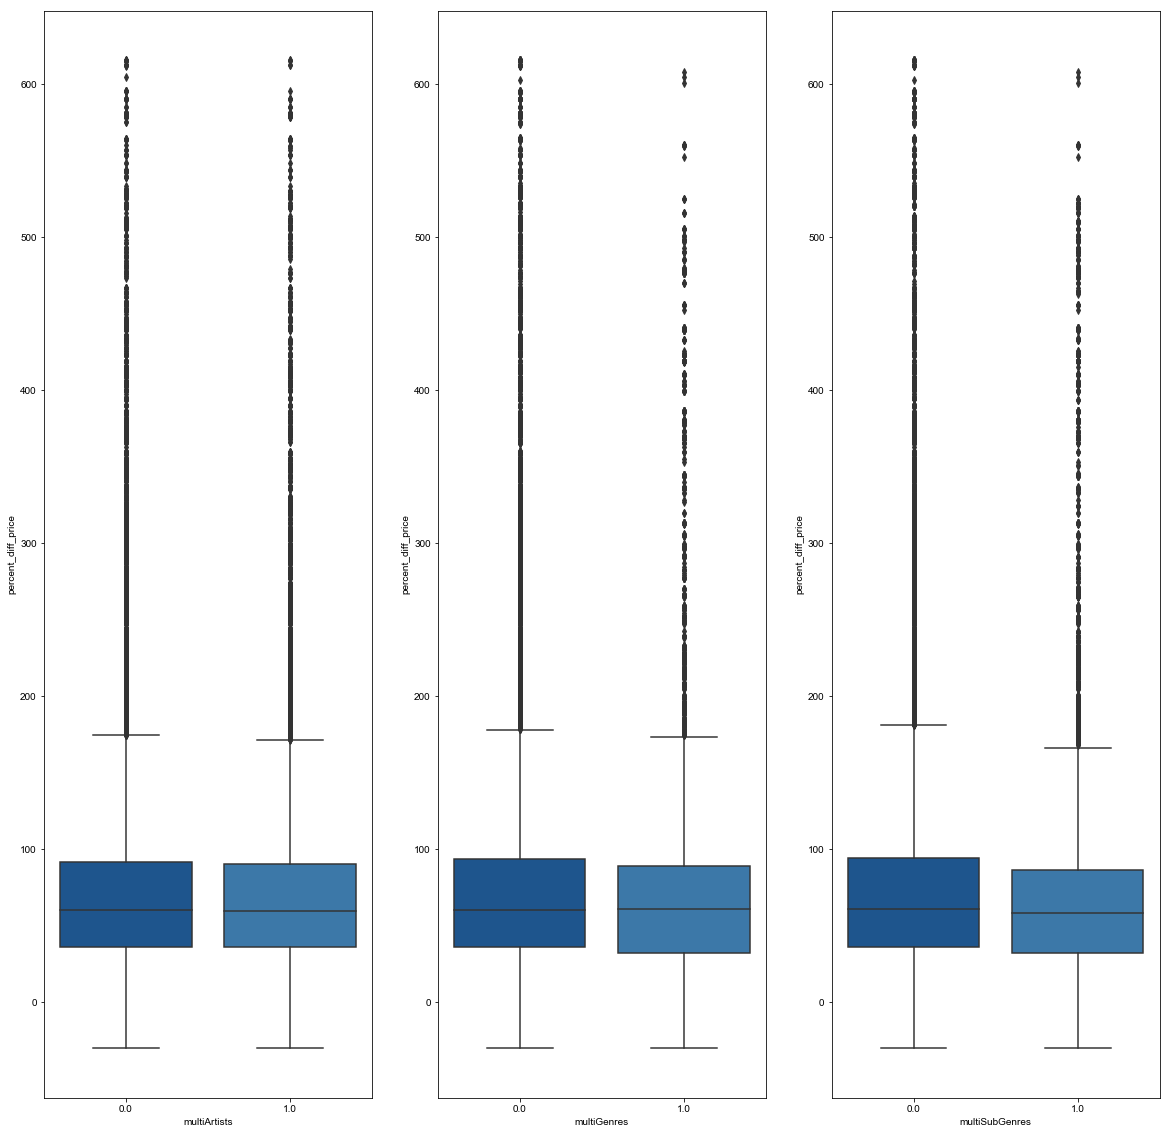

In [26]:
df_analysis['multiArtists'] = pd.Series(np.where(df_analysis.attractionCount > 1, 1, 0))

f, ax = plt.subplots(figsize=(20,20))

plt.subplot(1,3,1)
sns.boxplot(data=df_analysis, x='multiArtists', y='percent_diff_price')

plt.subplot(1,3,2)
sns.boxplot(data=df_analysis, x='multiGenres', y='percent_diff_price')

plt.subplot(1,3,3)
sns.boxplot(data=df_analysis, x='multiSubGenres', y='percent_diff_price')

plt.show()

Based on visual inspection alone we can tell that the impact is trivial

#### Presales

Next, we'll take a look at whether presales has an impact

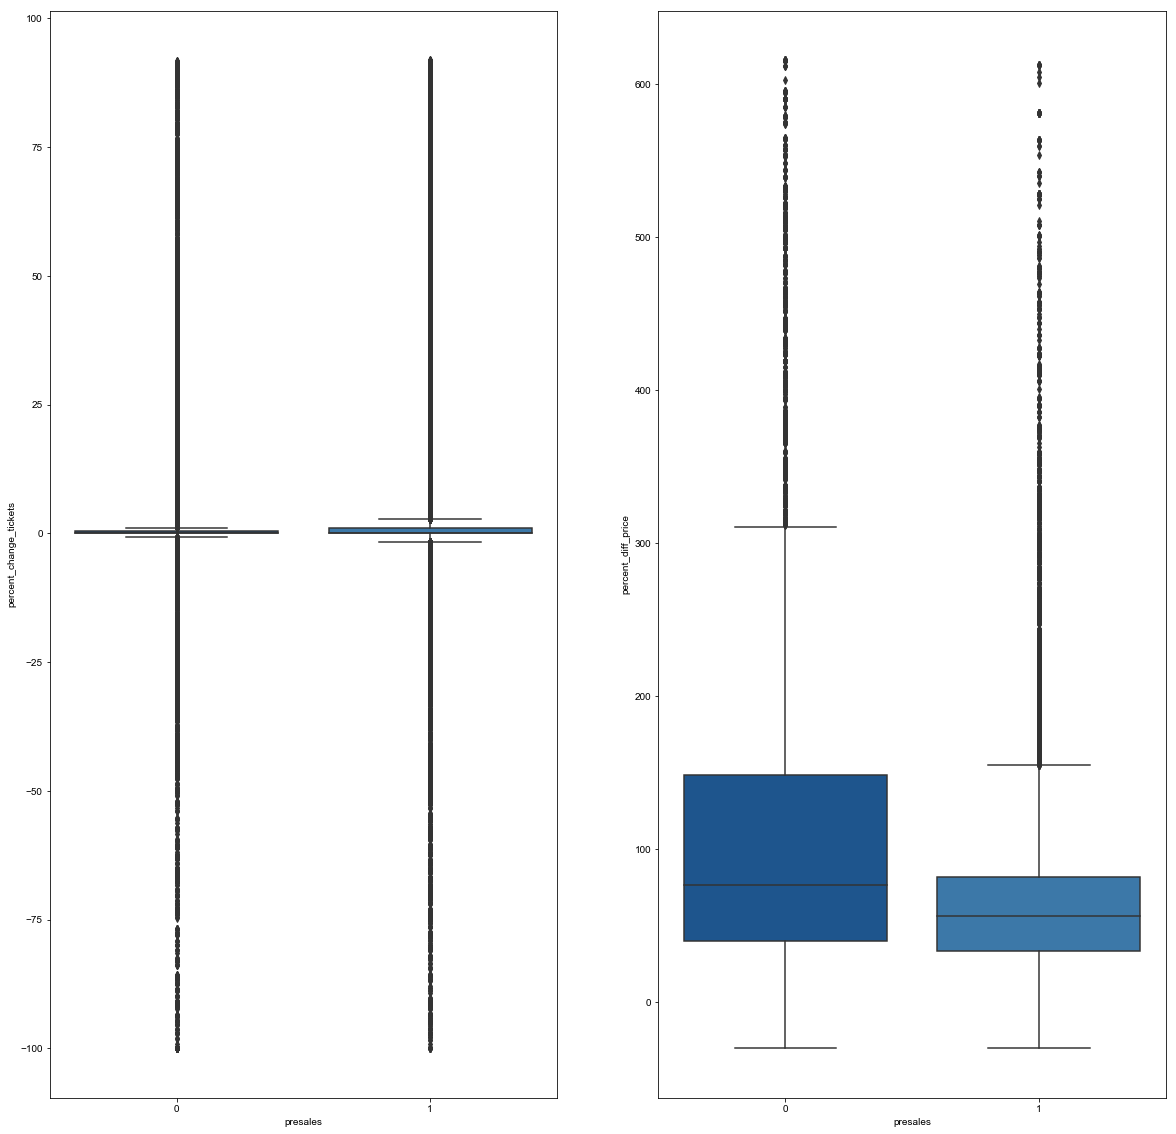

In [27]:
f, ax = plt.subplots(figsize=(20,20))

plt.subplot(1,2,1)
sns.boxplot(data=df_analysis, x='presales', y='percent_change_tickets')

plt.subplot(1,2,2)
sns.boxplot(data=df_analysis, x='presales', y='percent_diff_price')

plt.show()

In [28]:
presales_yes = df_analysis[df_analysis.presales == 1]
presales_no = df_analysis[df_analysis.presales == 0]

print('Change in Ticket Sales')
stats.mannwhitneyu(presales_yes.percent_change_tickets, presales_no.percent_change_tickets)

Change in Ticket Sales


MannwhitneyuResult(statistic=260927927.0, pvalue=4.4823057155787735e-10)

In [29]:
print('Price Differential')
stats.mannwhitneyu(presales_yes.percent_diff_price, presales_no.percent_diff_price)

Price Differential


MannwhitneyuResult(statistic=201364680.5, pvalue=0.0)

Another clear impact here - it appears having a presale decreases price hikes and ticket quantity volatity off the resale ticket market.

This is an interesting phenomenon and an indicator that presales, which are typically targeted at fans and intended to give them priority access, are having the effect of providing real fans tickets at wholesale value

#### City Size

Next, we'll take a look at how the population of a city impacts ticket pricing

First we'll import a dataset from data.gov in orer to add population information to our analysis

In [30]:
# Import city population size dataset
city_populations = pd.read_csv('/Users/Albert/Desktop/city_populations.csv')
city_populations.rename(columns={'NAME':'venueCity', 'POPESTIMATE2017':'cityPop'}, inplace=True)

print(city_populations.shape)
city_populations['venueCity']

(65499, 2)


0                           Alabama
1                    Abbeville city
2                   Adamsville city
3                      Addison town
4                        Akron town
5                    Alabaster city
6                  Albertville city
7               Alexander City city
8                   Aliceville city
9                      Allgood town
10                     Altoona town
11                   Andalusia city
12                    Anderson town
13                    Anniston city
14                        Arab city
15                     Ardmore town
16                        Argo town
17                      Ariton town
18                       Arley town
19                     Ashford town
20                     Ashland town
21                    Ashville city
22                      Athens city
23                      Atmore city
24                     Attalla city
25                      Auburn city
26                Autaugaville town
27                        Av

The city names in our data.gov dataset do not align with how our ticket listings dataset lists them. Let's pull out some RegEx and clean up the names for our merge

In [31]:
# Import RegEx
import re

# Write function
def clean_city_names (city_name):
    city_name = re.sub(' \w+$', '', city_name)
    
    return city_name

# Apply function to city name column
city_populations['venueCity'] = city_populations.venueCity.apply(clean_city_names)

# Remove duplicate values
city_populations.sort_values('cityPop', ascending=False, inplace=True)
city_populations.drop_duplicates(subset='venueCity', inplace=True)

(46738, 50)


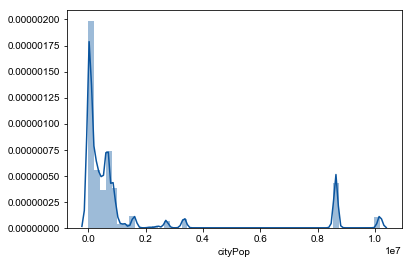

In [32]:
df_analysis = df_analysis.merge(city_populations, how='left', on='venueCity')
df_analysis.drop_duplicates(inplace=True)
df_analysis.dropna(subset=['cityPop'], inplace=True)

print(df_analysis.shape)
sns.distplot(df_analysis.cityPop)
plt.show()

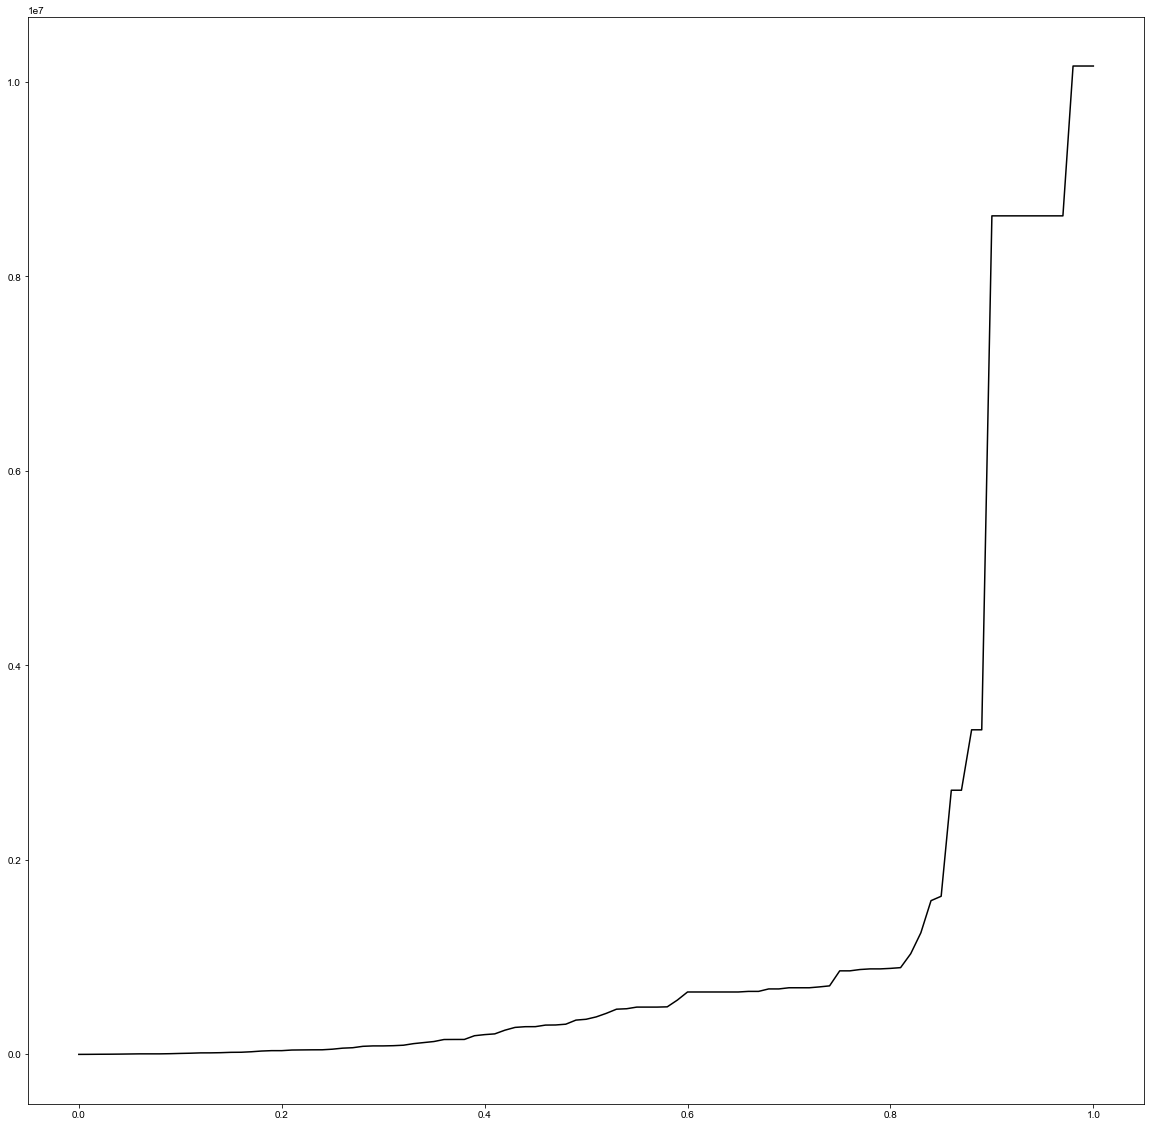

cityPop  quantiles
0          60.0       0.00
1         477.0       0.01
2        1327.0       0.02
3        1845.0       0.03
4        2822.0       0.04
5        4151.0       0.05
6        5481.0       0.06
7        5487.0       0.07
8        5487.0       0.08
9        7181.0       0.09
10       9928.0       0.10
11      12150.0       0.11
12      15493.0       0.12
13      15767.0       0.13
14      17574.0       0.14
15      21128.0       0.15
16      21978.0       0.16
17      26996.0       0.17
18      34407.0       0.18
19      38429.0       0.19
20      38429.0       0.20
21      44741.0       0.21
22      45908.0       0.22
23      46967.0       0.23
24      47334.0       0.24
25      53512.0       0.25
26      63973.0       0.26
27      68554.0       0.27
28      82912.0       0.28
29      87235.0       0.29
..          ...        ...
71     685094.0       0.71
72     685094.0       0.72
73     693972.0       0.73
74     704621.0       0.74
75     859035.0       0.75
76     859035.0       0.76
77     872680.0       0.77
78     879170.0       0.78
79     879170.0       0.79
80     884363.0       0.80
81     892062.0       0.81
82    1035317.0       0.82
83    1250836.0       0.83
84    1580863.0       0.84
85    1626078.0       0.85
86    2716450.0       0.86
87    2716450.0       0.87
88    3337685.0       0.88
89    3337685.0       0.89
90    8622698.0       0.90
91    8622698.0       0.91
92    8622698.0       0.92
93    8622698.0       0.93
94    8622698.0       0.94
95    8622698.0       0.95
96    8622698.0       0.96
97    8622698.0       0.97
98   10163507.0       0.98
99   10163507.0       0.99
100  10163507.0       1.00

[101 rows x 2 columns]

In [33]:
# Plot 1% percentiles to determine best outlier sorting

quantiles = [x/100 for x in range(101)]

quantiles_cityPop = [df_analysis['cityPop'].quantile(q=x) for x in quantiles]
quantiles_cityPop = pd.DataFrame(data={'quantiles':quantiles, 'cityPop':quantiles_cityPop})

f,ax = plt.subplots(figsize=(20,20))
plt.plot(quantiles_cityPop.quantiles, quantiles_cityPop.cityPop, 'k')
plt.show()

quantiles_cityPop

There's a good distribution here for us to break city population into a nice clean categorical variable. We'll break up citypopulation as follows:

- **Small**: 0 - 750,000
- **Medium**: 750,000 - 2mill
- **Large**: 2mill - 6mill
- **Enormous**: 6mill+

In [34]:
def pop_categorization (pop):
    if pop <= 750000:
        return 'small'
    elif pop <= 2000000:
        return 'medium'
    elif pop <= 6000000:
        return 'large'
    else:
        return 'very large'

df_analysis['citySize'] = df_analysis.cityPop.apply(pop_categorization)

df_analysis.sort_values('cityPop', ascending=False, inplace=True)
pd.crosstab(index=df_analysis.citySize, columns='count')

col_0       count
citySize         
large        1643
medium       5387
small       34589
very large   5119

Now we can plot how our metrics differ based on these categories

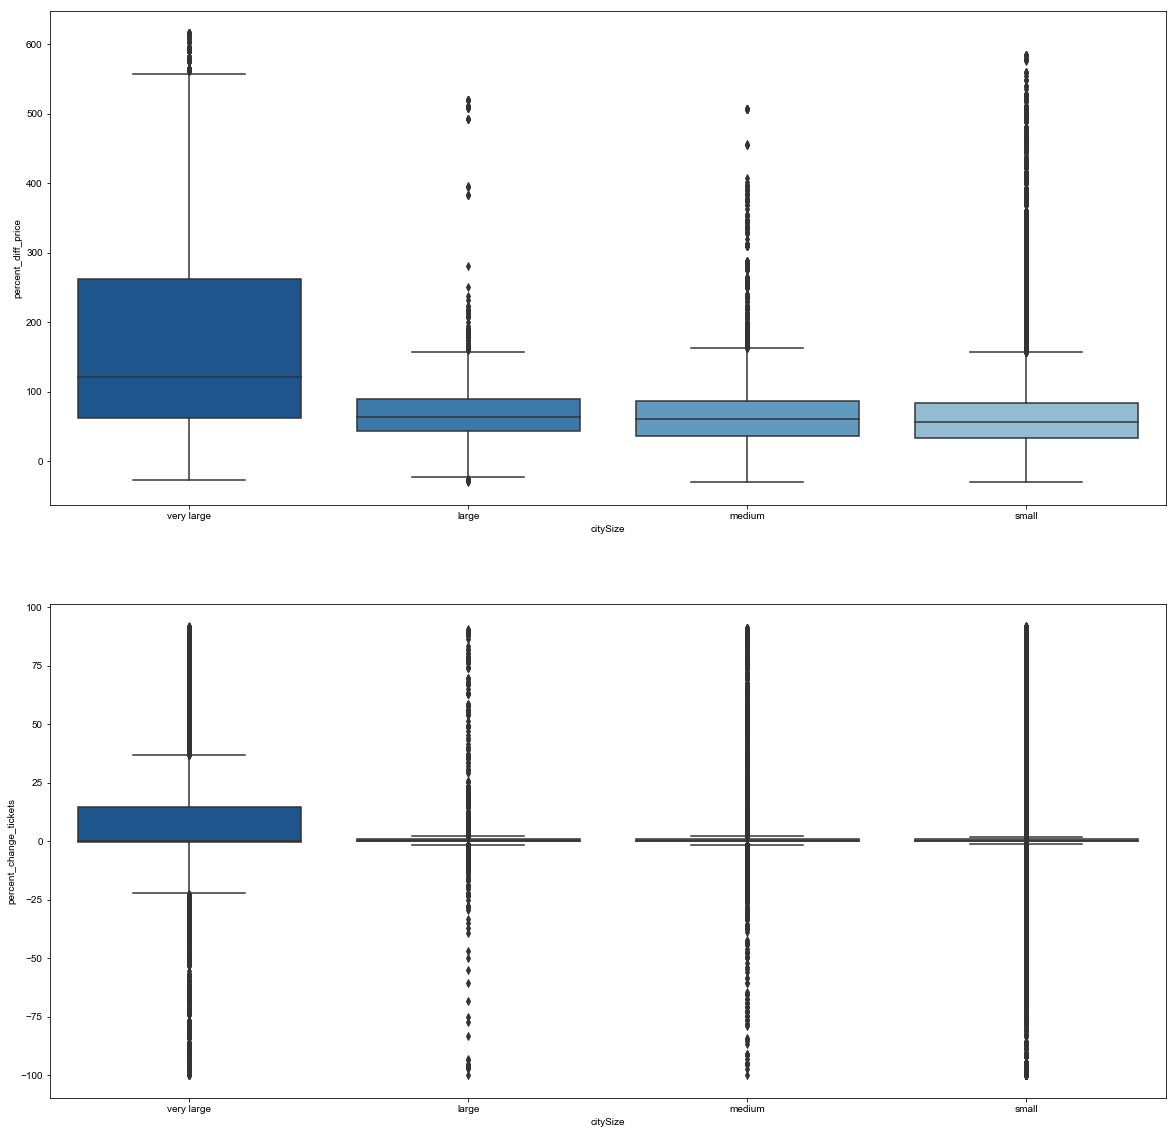

In [35]:
f, ax = plt.subplots(figsize=(20,20))

plt.subplot(2,1,1)
sns.boxplot(data=df_analysis, x='citySize', y='percent_diff_price')

plt.subplot(2,1,2)
sns.boxplot(data=df_analysis, x='citySize', y='percent_change_tickets')

plt.show()

In [36]:
groups = kw_test('percent_diff_price', 'citySize')
stats.kruskal(groups[0], groups[1], groups[2], groups[3])

KruskalResult(statistic=3247.3902362551703, pvalue=0.0)

In [37]:
groups = kw_test('percent_change_tickets', 'citySize')
stats.kruskal(groups[0], groups[1], groups[2], groups[3])

KruskalResult(statistic=88.91452668753044, pvalue=3.747027012961899e-19)

So it appears there definitely is a difference, but that that difference is only meaningful in our very large markets (over 6 mill population size) where the markets have the most pricing and ticket quantity fluctuations

In [38]:
groups = kw_test('percent_diff_price', 'citySize')
stats.kruskal(groups[1], groups[2], groups[3])

KruskalResult(statistic=91.72920042951075, pvalue=1.2057498374149866e-20)

In [39]:
groups = kw_test('percent_change_tickets', 'citySize')
stats.kruskal( groups[1], groups[2], groups[3])

KruskalResult(statistic=3.540043486943848, pvalue=0.17032928523511373)

When removing our enormous group from the analsis, there is much less of an impact on percent in ticket change (although still significantly impactful in price differential)

#### Upcoming Events

Finally we'll explore how many upcoming events the performing artists have. Although it's an imperfect measure, it can serve as either an indiciation of current artist popularity (based on how many upcoming shows they have) or show availability (with fewer upcoming shows making each one that much more valuable)

Similarly to city population, we'll have to explore and create some categorical variables

In [40]:
df_analysis.columns

Index(['datetime', 'tm_Id', 'currentPrice', 'quantity', 'totalListings',
       'totalTickets', 'eventName', 'classificationGenre',
       'classificationGenreId', 'classificationSubGenre',
       'classificationSubGenreId', 'venue.venueId', 'venueName',
       'venueStateCode', 'venueCity', 'venueZipCode', 'maxPrice', 'minPrice',
       'onsaleStartDateTime', 'eventStartDateTime', 'eventStartLocalDate',
       'eventStartLocalTime', 'presales', 'promoters', 'eventStatus',
       'max_min_differential', 'venue_totalupcomingEvents',
       'venue_ticketmasterupcomingEvents', 'attractionId', 'attractionName',
       'attractionGenre', 'attractionGenreId', 'attractionSubGenre',
       'attractionSubGenreId', 'attractionCount', 'multiGenres',
       'multiSubGenres', 'artist_totalupcomingEvents',
       'artist_ticktmasterupcomingEvents', 'time_from_sale', 'time_to_event',
       'listings_diff', 'tickets_diff', 'percent_change_listings',
       'percent_change_tickets', 'percent_diff_pric

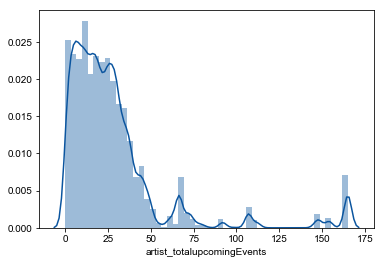

In [41]:
sns.distplot(df_analysis.artist_totalupcomingEvents)
plt.show()

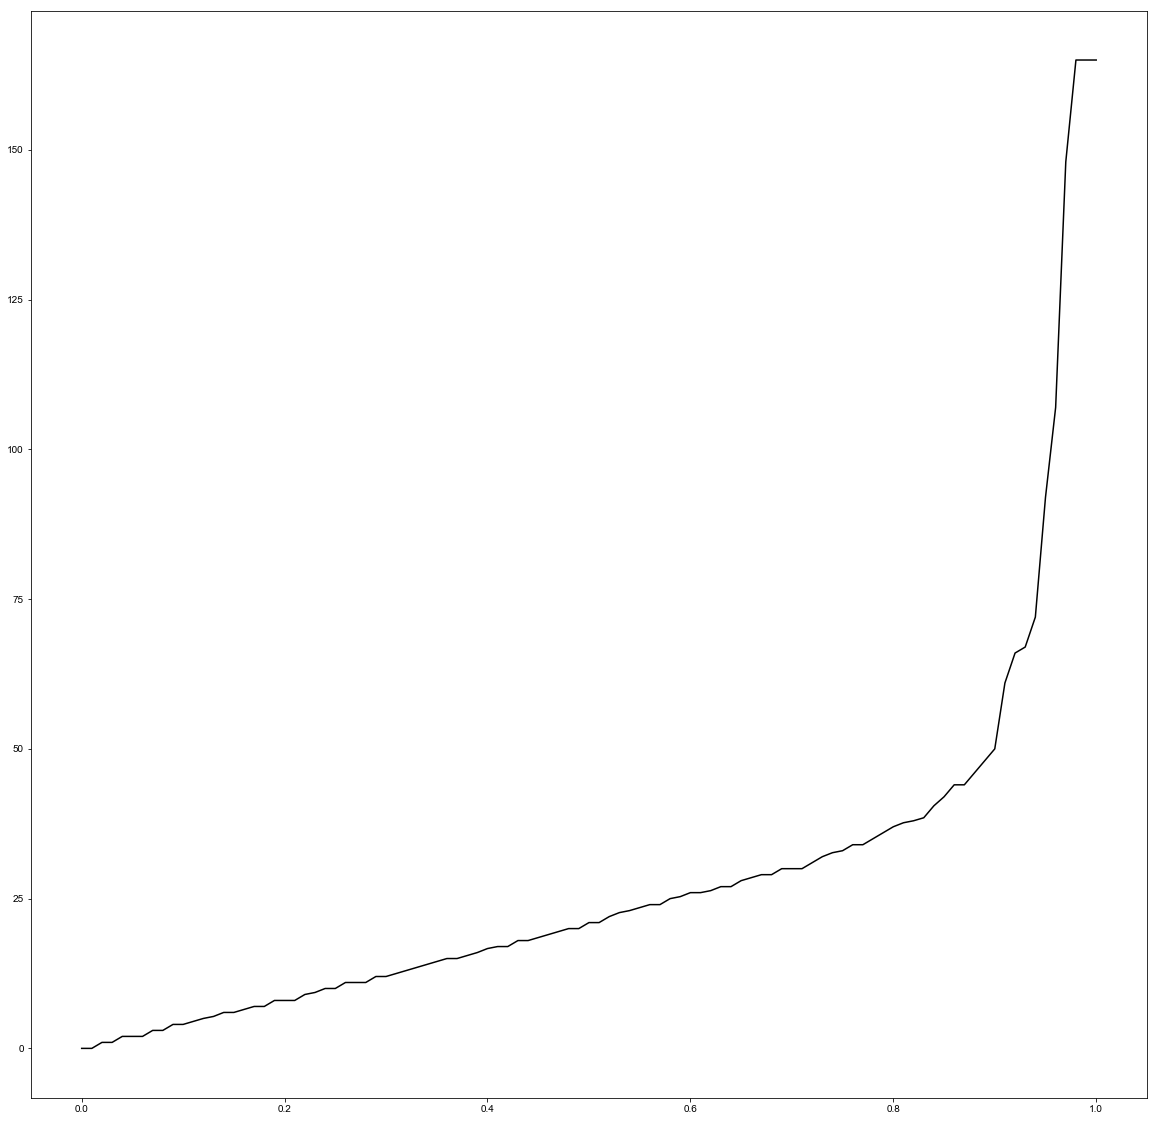

event_count  quantiles
0       0.000000       0.00
1       0.000000       0.01
2       1.000000       0.02
3       1.000000       0.03
4       2.000000       0.04
5       2.000000       0.05
6       2.000000       0.06
7       3.000000       0.07
8       3.000000       0.08
9       4.000000       0.09
10      4.000000       0.10
11      4.500000       0.11
12      5.000000       0.12
13      5.333333       0.13
14      6.000000       0.14
15      6.000000       0.15
16      6.500000       0.16
17      7.000000       0.17
18      7.000000       0.18
19      8.000000       0.19
20      8.000000       0.20
21      8.000000       0.21
22      9.000000       0.22
23      9.333333       0.23
24     10.000000       0.24
25     10.000000       0.25
26     11.000000       0.26
27     11.000000       0.27
28     11.000000       0.28
29     12.000000       0.29
..           ...        ...
71     30.000000       0.71
72     31.000000       0.72
73     32.000000       0.73
74     32.666667       0.74
75     33.000000       0.75
76     34.000000       0.76
77     34.000000       0.77
78     35.000000       0.78
79     36.000000       0.79
80     37.000000       0.80
81     37.666667       0.81
82     38.000000       0.82
83     38.500000       0.83
84     40.500000       0.84
85     42.000000       0.85
86     44.000000       0.86
87     44.000000       0.87
88     46.000000       0.88
89     48.000000       0.89
90     50.000000       0.90
91     61.000000       0.91
92     66.000000       0.92
93     67.000000       0.93
94     72.000000       0.94
95     92.000000       0.95
96    107.000000       0.96
97    148.000000       0.97
98    165.000000       0.98
99    165.000000       0.99
100   165.000000       1.00

[101 rows x 2 columns]

In [42]:
# Plot 1% percentiles to determine best outlier sorting

quantiles = [x/100 for x in range(101)]

quantiles_eventCount = [df_analysis['artist_totalupcomingEvents'].quantile(q=x) for x in quantiles]
quantiles_eventCount = pd.DataFrame(data={'quantiles':quantiles, 'event_count':quantiles_eventCount})

f,ax = plt.subplots(figsize=(20,20))
plt.plot(quantiles_eventCount.quantiles, quantiles_eventCount.event_count, 'k')
plt.show()

quantiles_eventCount

We'll break down our categories as follow:

- **Few**: less than 10
- **Some**: 10 - 20
- **Many**: 20 - 40
- **Very Many**: over 40

In [43]:
def event_count_categorization (count):
    if count < 10:
        return 'few'
    elif count <= 20:
        return 'some'
    elif count <= 40:
        return 'many'
    else:
        return 'very many'

df_analysis['upcomingEvents'] = df_analysis.artist_totalupcomingEvents.apply(event_count_categorization)

df_analysis.sort_values('upcomingEvents', ascending=False, inplace=True)
pd.crosstab(index=df_analysis.upcomingEvents, columns='count')

col_0           count
upcomingEvents       
few             11015
many            16073
some            12028
very many        7622

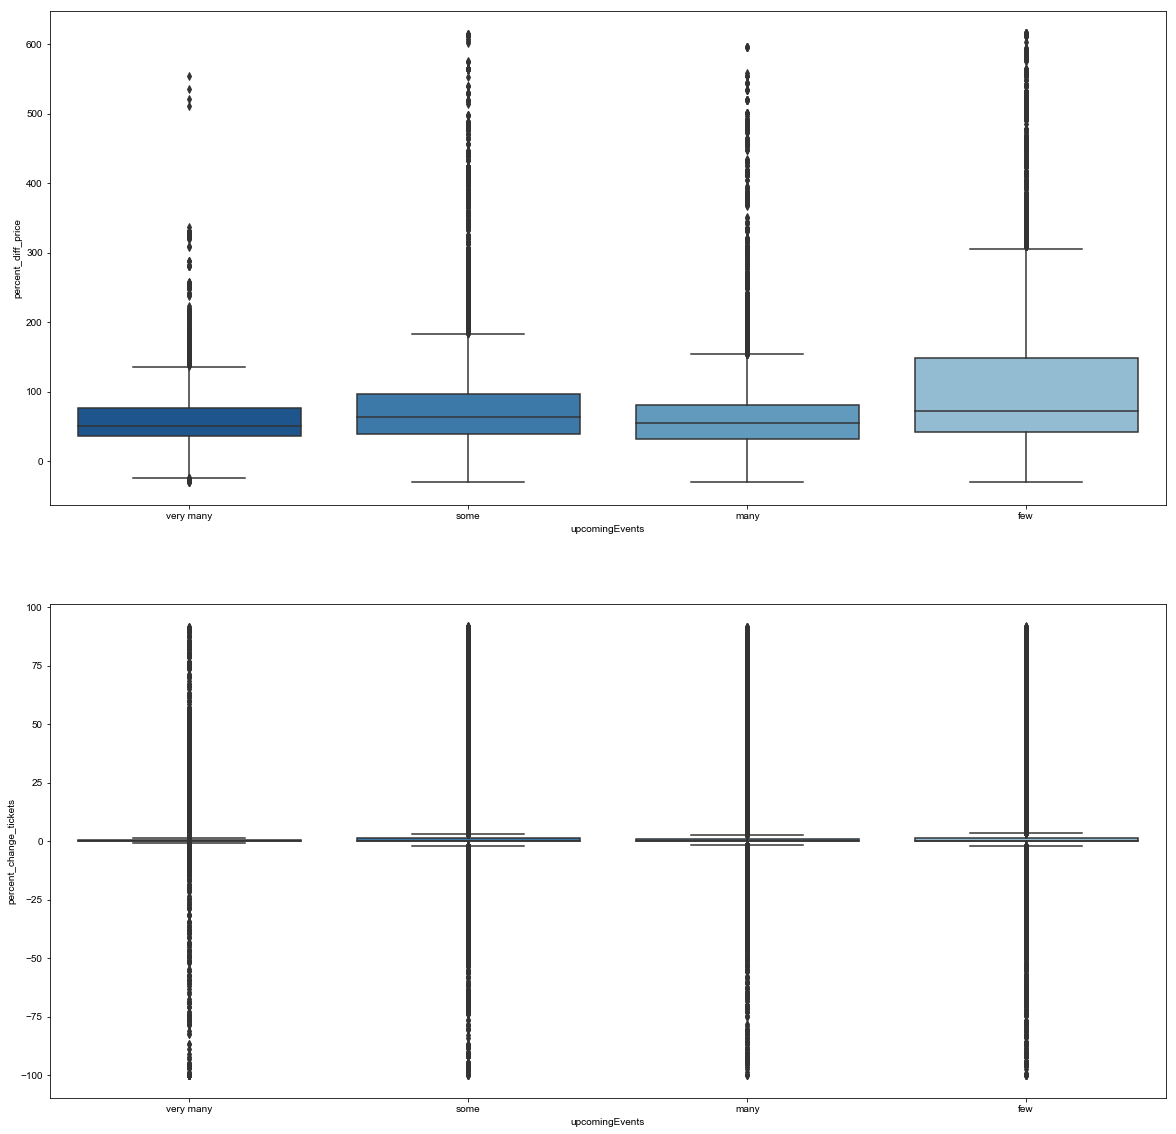

In [44]:
f, ax = plt.subplots(figsize=(20,20))

plt.subplot(2,1,1)
sns.boxplot(data=df_analysis, x='upcomingEvents', y='percent_diff_price')

plt.subplot(2,1,2)
sns.boxplot(data=df_analysis, x='upcomingEvents', y='percent_change_tickets')

plt.show()

In [45]:
groups = kw_test('percent_diff_price', 'upcomingEvents')
stats.kruskal(groups[0], groups[1], groups[2], groups[3])

KruskalResult(statistic=1501.0146878410676, pvalue=0.0)

In [46]:
groups = kw_test('percent_change_tickets', 'upcomingEvents')
stats.kruskal(groups[0], groups[1], groups[2], groups[3])

KruskalResult(statistic=47.39791362978613, pvalue=2.860108024598423e-10)

Another significant variable here as well

## Time Series

Finally we'll take a look at our time series data.

In [47]:
# Explore datetime distribution
df_analysis.datetime.describe()

count                          46738
unique                         43835
top       2018-07-31 06:07:40.998054
freq                               2
first     2018-07-28 20:07:11.641050
last      2018-08-05 02:01:43.400327
Name: datetime, dtype: object

We're going to do a little bit of engineering here in advance of our models. Because the data was pulled twice daily for 6 days, we'll create a halfday feature that will bucket our values into appropriate time slices for analysis.

In [48]:
## Create feature for half days

# Create array of halfday periods
half_days = pd.date_range(start='2018-07-29 00:00:00', end='2018-08-06 00:00:00', freq='12H')
print(half_days)

# Sort DF by datetime
df_analysis.sort_values(by='datetime', inplace=True)

# Extract index breaks
idx = [0]
counter = 1

for i, datetime in enumerate(df_analysis.datetime):
    if datetime > half_days[counter]:
        idx.append(i)
        counter = counter+1
        
idx

DatetimeIndex(['2018-07-29 00:00:00', '2018-07-29 12:00:00',
               '2018-07-30 00:00:00', '2018-07-30 12:00:00',
               '2018-07-31 00:00:00', '2018-07-31 12:00:00',
               '2018-08-01 00:00:00', '2018-08-01 12:00:00',
               '2018-08-02 00:00:00', '2018-08-02 12:00:00',
               '2018-08-03 00:00:00', '2018-08-03 12:00:00',
               '2018-08-04 00:00:00', '2018-08-04 12:00:00',
               '2018-08-05 00:00:00', '2018-08-05 12:00:00',
               '2018-08-06 00:00:00'],
              dtype='datetime64[ns]', freq='12H')


[0,
 8340,
 12535,
 16723,
 20903,
 25076,
 27639,
 27732,
 33398,
 36436,
 42780,
 42781,
 46385,
 46386,
 46387]

Unfortunately, because the pulls were not automated and I'm an imperfect human there are a number of disjointed index values. In order to account for this, I'll get my hands dirty and make some manual adjustments to craft our halfday feature.

In [49]:
# Adjusting dataset for analysis
df_analysis = df_analysis[df_analysis.datetime < half_days[12]]
df_analysis['half_days'] = None
df_analysis.iloc[idx[0]:idx[1], 52] = half_days[0]
df_analysis.iloc[idx[1]:idx[2], 52] = half_days[1]
df_analysis.iloc[idx[2]:idx[3], 52] = half_days[2]
df_analysis.iloc[idx[3]:idx[4], 52] = half_days[3]
df_analysis.iloc[idx[4]:idx[5], 52] = half_days[4]
df_analysis.iloc[idx[5]:idx[6], 52] = half_days[5]
df_analysis.iloc[29195:33597, 52] = half_days[6]
df_analysis.iloc[33597:35279, 52] = half_days[7]
df_analysis.iloc[35279:40247, 52] = half_days[8]
df_analysis.iloc[40247:45167, 52] = half_days[9]
df_analysis.iloc[45167:, 52] = half_days[10]

df_analysis.half_days.describe()

count                   44829
unique                     11
top       2018-07-29 00:00:00
freq                     8340
Name: half_days, dtype: object

Great! Now let's visualize

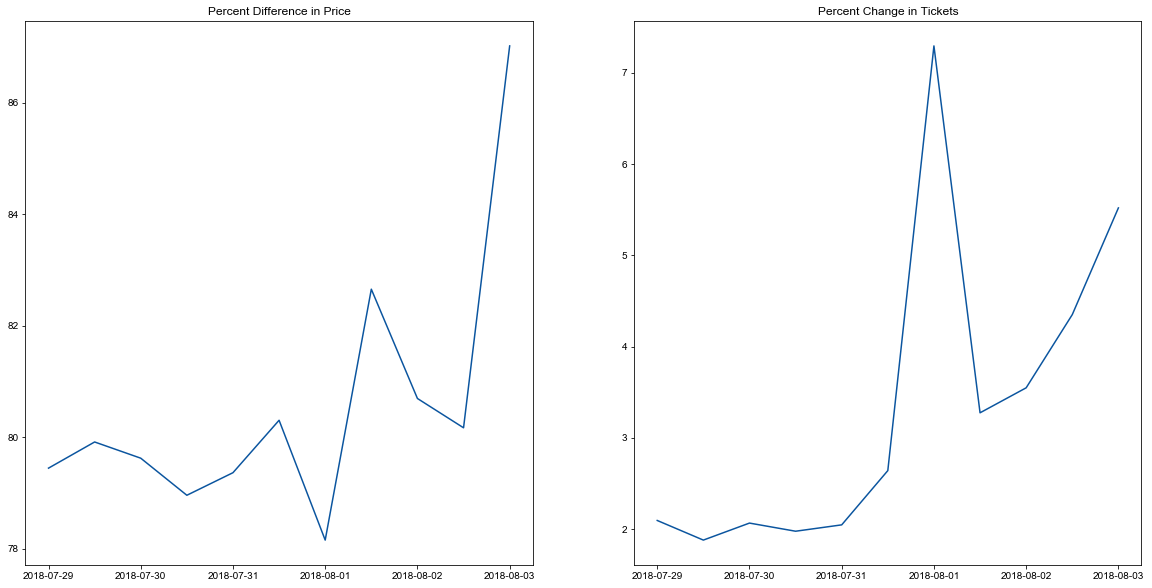

In [50]:
# Group data by half day
df_time_series = df_analysis.groupby(['half_days']).mean()[['percent_diff_price','percent_change_tickets']]
df_time_series.reset_index(inplace=True)

# Plot metrics
f,ax = plt.subplots(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(df_time_series.half_days, df_time_series.percent_diff_price)
plt.title('Percent Difference in Price')

plt.subplot(1,2,2)
plt.plot(df_time_series.half_days, df_time_series.percent_change_tickets)
plt.title('Percent Change in Tickets')


plt.show()

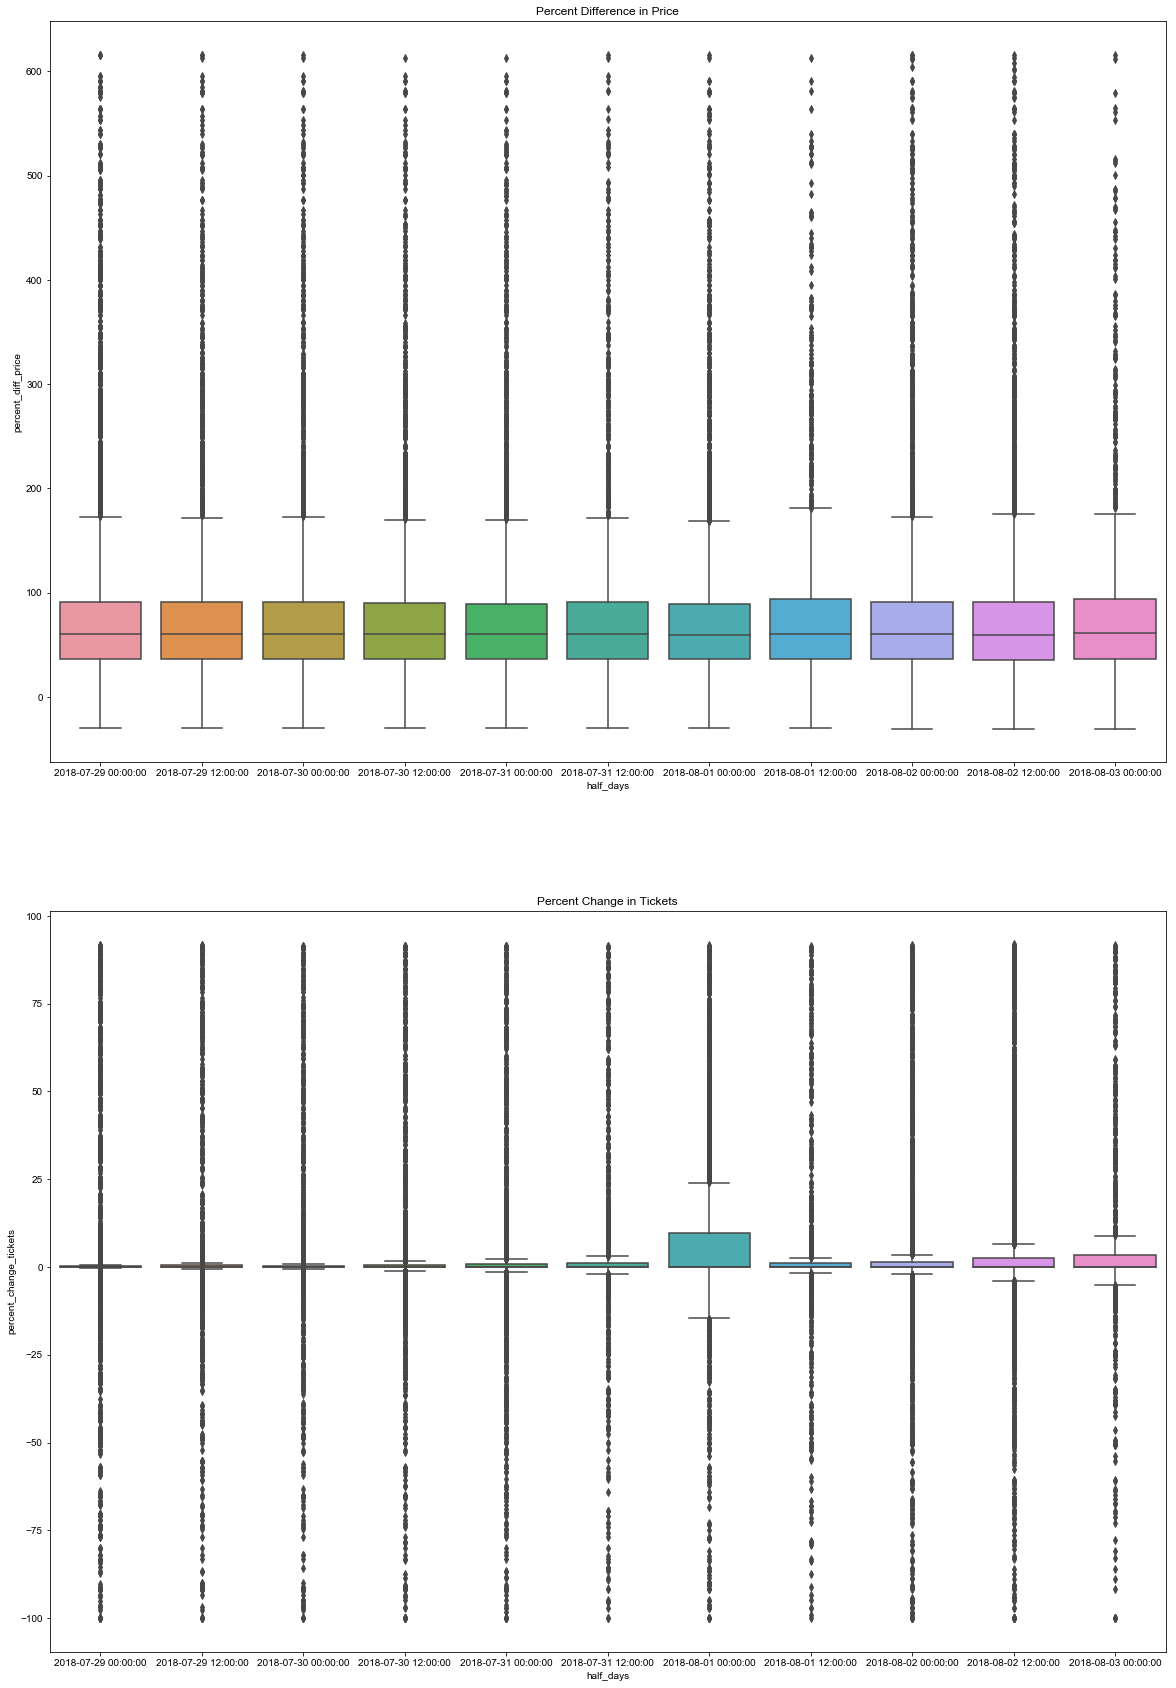

In [51]:
# Plot boxplots by halfday
f,ax = plt.subplots(figsize=(20,30))

plt.subplot(2,1,1)
sns.boxplot(df_analysis.half_days, df_analysis.percent_diff_price)
plt.title('Percent Difference in Price')

plt.subplot(2,1,2)
sns.boxplot(df_analysis.half_days, df_analysis.percent_change_tickets)
plt.title('Percent Change in Tickets')

plt.show()

Time series and distributions look great - there seems to be a slight blip on 08/01 that may be due to outliers. This will be addressed further below (*note unified metric and log transformation*)

# Modeling

Before modeling, we have to quickly address our chosen prediction metrics: percent price difference and percent change in tickets. Both are intended to represent return and risk, respectively. However both are imperfect and limited in that regard.

The return rate metric (percent price difference) is calculated based on tickets left in the market, not on tickets sold, so it is not a guarantee of going market rate. We can think of problematic instances, towards the beginning of an event resell when prices fluctuate wildly as the market finds a selling point, or towards the end as the event is about to start and only highly priced tickets remain.

Similarly, the risk metric (percent change in tickets) is not indicative of ticket sales. Individuals may be deciding to not sell their tickets, or are perhaps giving them away or selling to friends at discounted rates. 

In introducing a unified metric as the product of the 2, we can manage our indicators’ noted limitations. When average price differential is high, it is more likely that an accompanying decrease in ticket quantity is indicative of sales, as resellers have less incentive to pull their listings. When expected decrease in ticket quantity is high, it is likely that a high price differential is more indicative of a properly priced market as many of these tickets get sold.

This unified metric will help us in identifying investment opportunities using our models, after which we can dive in more granularly to determine the risk-return makeup of our predictions.

In [52]:
## Create unified metric

df_analysis['unified_metric'] = df_analysis['percent_diff_price'] * df_analysis['percent_change_tickets']

A quick visual inspection of our time series plots shows that the simple combination of the 2 metrics has helped smooth out some bumps in the data.

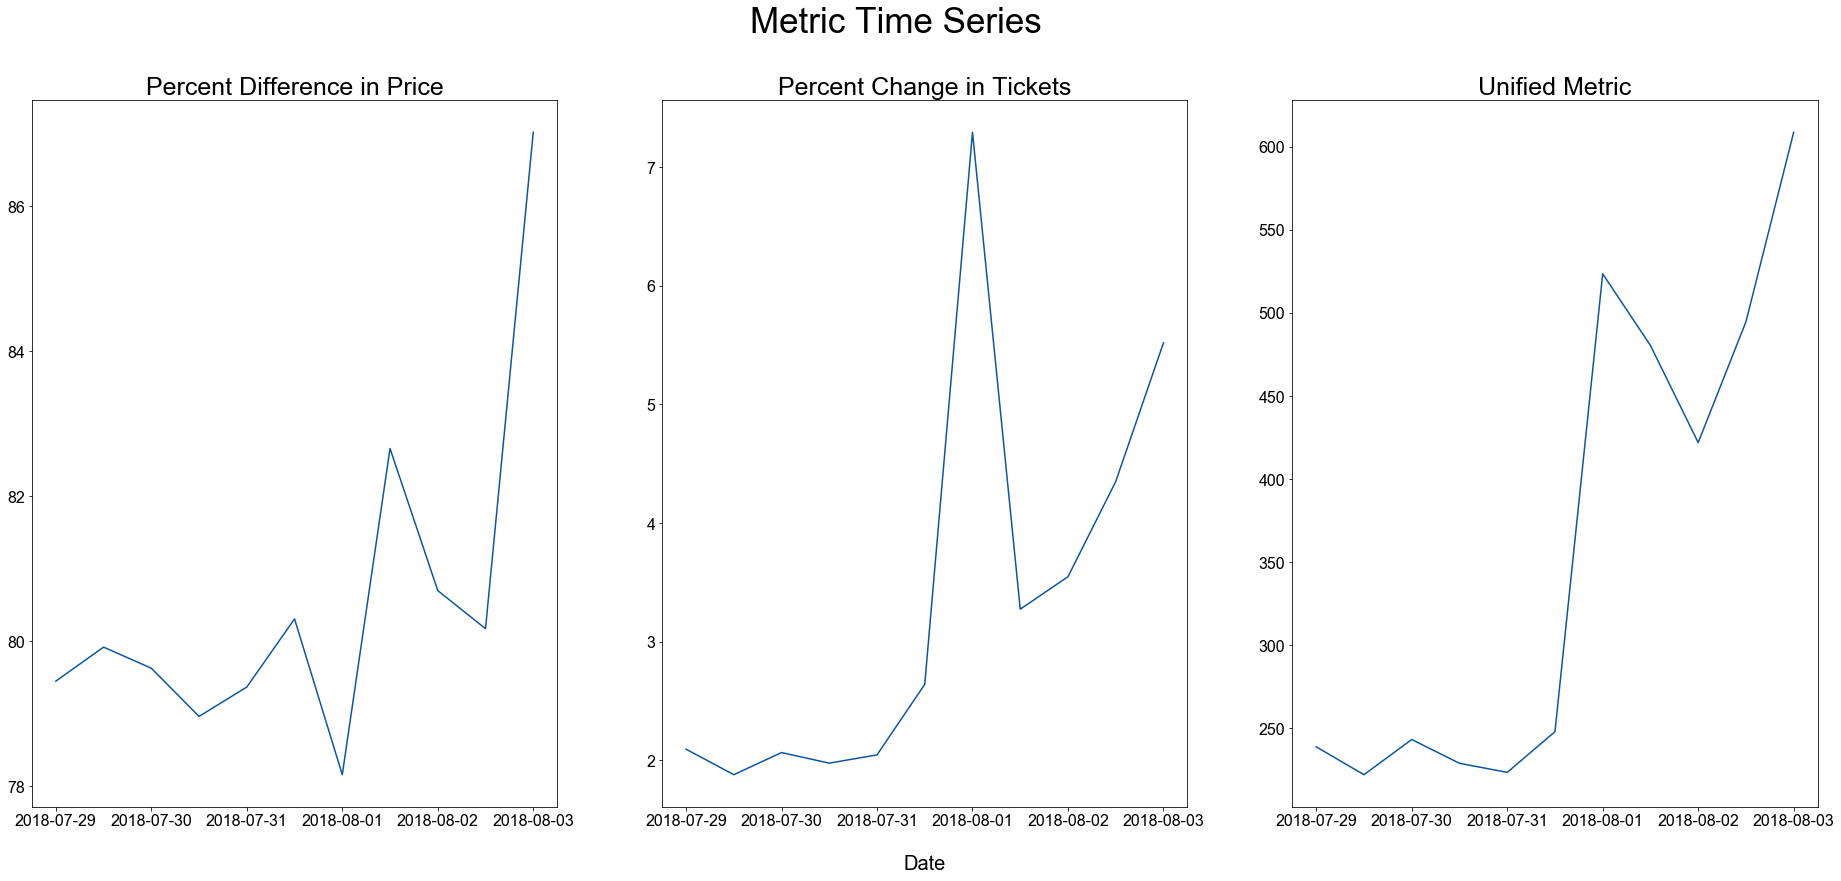

In [53]:
# Group data by half day
df_time_series = df_analysis.groupby(['half_days']).mean()[['percent_diff_price','percent_change_tickets','unified_metric']]
df_time_series.reset_index(inplace=True)

# Plot metrics
f,ax = plt.subplots(figsize=(32,13))

plt.subplot(1,3,1)
plt.plot(df_time_series.half_days, df_time_series.percent_diff_price)
plt.title('Percent Difference in Price', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,3,2)
plt.plot(df_time_series.half_days, df_time_series.percent_change_tickets)
plt.title('Percent Change in Tickets', fontsize=25)
plt.xlabel('\nDate', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,3,3)
plt.plot(df_time_series.half_days, df_time_series.unified_metric)
plt.title('Unified Metric', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.suptitle('Metric Time Series\n\n', fontsize=35)
plt.show()

Now without further ado - let the modeling begin!! 

-----

We will be creating a 2-layer ensemble model for our prediction algorithm.

**Layer 1 - Supervised Learning**

The first layer will be a simple supervised learning algorithm using static attributes available through the Ticketmaster dataset. This layer will be focused on weeding out the uninteresting events and offering insights into which features were most impactful in that decision.

Layer 1 will return a set of observations


**Layer 2 - Fitted ARIMA Models**

The second layer will be a series of ARIMA models, all optimized for the specific set of attributes that we had determined in our earlier data exploration to have significant predictive power.

Using the set of values from Layer 1, Layer 2 narrows the scope of prediction to the attributes that have the greatest predictive impact and returns all instances in time up to event start date for which our metrics break a certain threshold.


**The Rationale**

As noted in academic literature, ARIMA models are the most effective models in time series forecasting. However they are quite sensitive to external variables. In order to maximize their predictive power it is imperative to limit the variance of other external variables. One way to do that is to narrow the scope of your training set so that training data share as many attributes as possible - in other words creating a unique ARIMA model for each category of each meaningful attribute.

In our first layer, we are able to take advantage of our entire feature set's predictive ability in narrowing down observations of interest. We can then narrow our ARIMA models down by most influential attribute on an *observation by observation basis* and in so doing maximize the predictive power of the sensitive ARIMA model.

## Supervised Learning

The first piece of the puzzle will be to determine which supervised learning models will be best suited for prediction.

Because this is an event level prediction that will be processed at the moment that new tickets are released on Ticketmaster, we will group our data by event ID and hold on to the maximum unified metric value which will serve as our indicator of interest.

If our unified metric is over 500% (this would be an aggregation of an idealized 50% sell rate and 10% price differential ROI at any point in time), we will mark it as valuable. In this way we can turn a complex regression problem with multiple variables of interest into a simple categorical to serve as the first layer filter for our ARIMA models.

In [274]:
## Set X and Y predict values

# Group by event
max_value = df_analysis.groupby(['tm_Id']).max()[['unified_metric','classificationGenre','classificationSubGenre',
                                                  'presales','attractionCount','artist_totalupcomingEvents',
                                                  'cityPop','maxPrice','minPrice','days_from_sale','days_to_event']]

# Set categorical predict value
max_value['unified_metric_dummy'] = np.where(max_value.unified_metric >= 500, 1, 0)
y_orig = max_value.unified_metric_dummy

# Set feature matrix
X_orig = max_value[['classificationGenre','classificationSubGenre','presales','attractionCount',
                 'artist_totalupcomingEvents','cityPop','maxPrice','minPrice']]
X_orig = pd.get_dummies(X_orig, columns=['classificationGenre','classificationSubGenre'])

# Print distribution of predict value
pd.crosstab(y_orig, columns='count')

col_0                 count
unified_metric_dummy       
0                      3059
1                      1441

Because we are valuing our positive results more highly in our model, let's resample the data to a 50-50 split and then set our y predict and X feature matrix

In [275]:
# Resample data so that we have an equal distribution of positives and negaties
from imblearn.under_sampling import RandomUnderSampler as sampler

ratio = sampler(ratio={0:1441, 1:1441})
X, y = ratio.fit_sample(X_orig, y_orig)

pd.crosstab(y, columns='count')

col_0  count
row_0       
0       1441
1       1441

Because this is a first level filter we will be evaluating our models based on recall - we want a high percentage of all potential positives, decreasing our false negatives at the risk of letting some more false positives filter in.

We will right a cross validation function that optimizes for recall.

In [276]:
## Write cross validation function

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix as CM

# Set KFold parameters to iterate through 5 folds
skf = StratifiedKFold(n_splits=5)

def cross_val (model, X, y):
    # Loop through all splits
    for train, test in skf.split(X, y):
        # Fit model
        model.fit(X[train], y[train])
        # Run model - extract test predictions
        y_predict = model.predict(X[test])
        # Extract all accuracy ratios
        tn, fp, fn, tp = CM(y[test], y_predict).ravel()
        # Print recall (percent true positives successfully predicted out of all positives)
        # Print false positives (percent false positives predicted out of all predictions)
        print ('Recall: {} - False Positives: {}'.format(tp/(tp+fn), fp/(tp+fp)))

Because our ensemble model is also premised on a feature importances parameter, we will test only those models that have that option

In [277]:
# Import models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as Log
from sklearn.svm import LinearSVC as SVC

# Set parameters
log = Log()
svc = SVC()
rfc = RFC()
gbc = GBC()

In [278]:
# Run models
print('Log Regr')
cross_val(log, X, y)
print('\n')
print('GBC')
cross_val(gbc, X, y)
print('\n')
print('SVC')
cross_val(svc, X, y)
print('\n')
print('RFC')
cross_val(rfc, X, y)

Log Regr
Recall: 0.42214532871972316 - False Positives: 0.4325581395348837
Recall: 0.04861111111111111 - False Positives: 0.46153846153846156
Recall: 0.059027777777777776 - False Positives: 0.39285714285714285
Recall: 0.4444444444444444 - False Positives: 0.5038759689922481
Recall: 0.3611111111111111 - False Positives: 0.46938775510204084


GBC
Recall: 0.71280276816609 - False Positives: 0.4340659340659341
Recall: 0.7291666666666666 - False Positives: 0.4182825484764543
Recall: 0.6701388888888888 - False Positives: 0.4186746987951807
Recall: 0.6423611111111112 - False Positives: 0.39935064935064934
Recall: 0.6736111111111112 - False Positives: 0.4327485380116959


SVC
Recall: 0.31833910034602075 - False Positives: 0.4491017964071856
Recall: 0.1076388888888889 - False Positives: 0.27906976744186046
Recall: 0.9652777777777778 - False Positives: 0.483271375464684
Recall: 0.19791666666666666 - False Positives: 0.43564356435643564
Recall: 0.006944444444444444 - False Positives: 0.6


RFC
Re

In this situation, initial indicators show that our Gradient Boosting Classifier provides the best reults on the most consistent basis.

Let's optimize our GBC model, making sure to emphasize recall

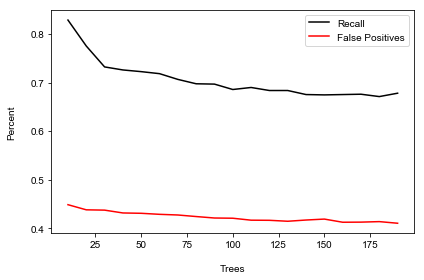

In [279]:
## Graph Recall and False Positive rate for various estimator count parameters
sns.set_style()

# Set parameters for testing
trees = np.array(range(10, 200, 10))

# Set DF to store values
results = pd.DataFrame()

# Instantiate for loop to calculate results
for tree_count in trees:
    gbc = GBC(n_estimators=tree_count)
    for train, test in skf.split(X, y):
        gbc.fit(X[train], y[train])
        y_predict = gbc.predict(X[test])
        tn, fp, fn, tp = CM(y[test], y_predict).ravel()
        results = results.append({'tree_count':tree_count, 'recall':tp/(tp+fn), 'false_positives':fp/(tp+fp)}, ignore_index=True)

results = results.groupby('tree_count', as_index=False).mean()
    
plt.plot(results.tree_count, results.recall, label='Recall', color='k')
plt.plot(results.tree_count, results.false_positives, label='False Positives', color='r')
plt.xlabel('\nTrees')
plt.ylabel('Percent\n')
plt.legend()

plt.tight_layout()
plt.show()

Clearly the fewer estimators we have the greater our recall is. We'll settle on a Gradient Boosting Classifier with 20 estimators for our supervised learning model.

In [60]:
# Train model
layer_1 = GBC(n_estimators=20)
layer_1.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=20,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## ARIMA Models

Now that we have our first layer set, let's begin setting up our individualized ARIMA models

First and foremost, let's write a few functions that will help us with our ARIMA analysis:
- Log transformation function to log transform all our input series for better results (*See NOTE below*)
- Grouping and Upsampling function to (1) easily group our values by category for analysis and (2) add additional interpolated values to increase sample size 
- ACF/PACF plotting function to aid visually in selecting models
- ARIMA analysis function to return valuable metrics for analyzing the different iterations of our ARIMA models

------

**NOTE**: In testing we found that the log-transformed data performed significantly better on AIC scores, and therefore decided to incorporate a log transformation for all ARIMA models. The increase in performance is most likely due to a few extreme outliers whose impact is dulled by transforming data using log.

In situations where our values are negative, we will add the absolute value of the largest negative number + 1 to all values in the time series, and then transform using log

In [61]:
# Import time series tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


# Write log transformation function
def log_transform (series):
    # For series with values less than 0...
    if series.min() < 0:
        # ... add the absolute value of lowest number + 1...
        transformation = np.array(series) + abs(series.min()) + 1
        # ... and then take the log
        transformation = np.log(transformation)
        transformation = pd.Series(data=transformation, index=series.index)
        # Return transformed series + series min
        return [transformation, series.min()-1]
    # Otherwise take the log
    else:
        transformation = np.log(series)
        return [transformation, 0]
    
## We are holding on to the series min value in order
## to transform values back in our model predictions



# Write simple grouping function to group a series of values by category
def grouped_upsample (feature, category):
    # Narrow data to observations with specific category value
    grouped_series = df_analysis[df_analysis[feature] == category]
    # Group data by time series halfday value
    grouped_series = grouped_series.groupby(['half_days']).mean()[['percent_diff_price','percent_change_tickets','unified_metric']]
    # Upsample time observations and linearly interpolate values to increase sample size by 2x
    grouped_series = grouped_series.resample('6H').interpolate()
    return grouped_series




# Write function for plotting ACF and PACF
def plot_acf (series, nlags):
    # Calculate ACF and PACF values
    results_acf = acf(series)
    results_pacf = pacf(series, nlags=nlags)
    # Calculate confidence intervals (1.96 standard deviation)
    acf_ci = stats.sem(results_acf)*1.96
    acf_upper_bound = np.mean(results_acf)+acf_ci
    acf_lower_bound = np.mean(results_acf)-acf_ci
    pacf_ci = stats.sem(results_pacf)*1.96
    pacf_upper_bound = np.mean(results_pacf)+pacf_ci
    pacf_lower_bound = np.mean(results_pacf)-pacf_ci
    # Add info to DF for plotting
    x_acf = pd.DataFrame({'metric':results_acf, 'upper_bound':acf_upper_bound, 'lower_bound':acf_lower_bound})
    x_pacf = pd.DataFrame({'metric':results_pacf, 'upper_bound':pacf_upper_bound, 'lower_bound':pacf_lower_bound})
    # Plot autocorrelation and confidence intervals
    f, ax = plt.subplots(figsize=(20,10))
    plt.subplot(1,2,1)
    x_acf.metric.plot(kind='bar')
    plt.plot(x_acf.upper_bound, 'r--')
    plt.plot(x_acf.lower_bound, 'r--')
    plt.title('ACF')
    plt.subplot(1,2,2)
    x_pacf.metric.plot(kind='bar')
    plt.plot(x_pacf.upper_bound, 'r--')
    plt.plot(x_pacf.lower_bound, 'r--')
    plt.title('PACF')
    plt.show()



# Write ARIMA analysis function to spit out valuable metrics to analyze ARIMA models
def arima_analysis (series, params):
    # Fit model
    model = ARIMA(series, params)
    model_fit = model.fit(disp=0)
    # Print model results
    print(model_fit.summary())
    # Plot residuals
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Before we begin setting ARIMA model parameters for all our categories in earnest, we'll also quickly set up a DataFrame to store the parameters as we work our way through.

In [62]:
# Create array of tuple values
index_tuples = []
features = ['classificationGenre','classificationSubGenre','presales','citySize','upcomingEvents']
for feature in features:
    for category in df_analysis[feature].unique():
        index_tuples.append((feature,category))

# Create MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['feature','category'])

# Create DataFrame
ARIMA_models = pd.DataFrame(index=index, columns=['model_params','model_train','AIC','log_transform'])
ARIMA_models

model_params model_train  AIC  \
feature                category                                           
classificationGenre    Dance/Electronic            NaN         NaN  NaN   
                       Rock                        NaN         NaN  NaN   
                       R&B                         NaN         NaN  NaN   
                       Hip-Hop/Rap                 NaN         NaN  NaN   
                       Religious                   NaN         NaN  NaN   
                       Country                     NaN         NaN  NaN   
                       Undefined                   NaN         NaN  NaN   
                       Pop                         NaN         NaN  NaN   
                       Folk                        NaN         NaN  NaN   
                       World                       NaN         NaN  NaN   
                       Metal                       NaN         NaN  NaN   
                       Other                       NaN         NaN  NaN   
                       Blues                       NaN         NaN  NaN   
                       Jazz                        NaN         NaN  NaN   
                       Reggae                      NaN         NaN  NaN   
                       Classical                   NaN         NaN  NaN   
                       New Age                     NaN         NaN  NaN   
                       Ballads/Romantic            NaN         NaN  NaN   
classificationSubGenre Club Dance                  NaN         NaN  NaN   
                       Pop                         NaN         NaN  NaN   
                       Alternative Rock            NaN         NaN  NaN   
                       Soul                        NaN         NaN  NaN   
                       Urban                       NaN         NaN  NaN   
                       Reggaeton                   NaN         NaN  NaN   
                       Gospel                      NaN         NaN  NaN   
                       Country                     NaN         NaN  NaN   
                       Undefined                   NaN         NaN  NaN   
                       Folk                        NaN         NaN  NaN   
                       World                       NaN         NaN  NaN   
                       R&B                         NaN         NaN  NaN   
                       Heavy Metal                 NaN         NaN  NaN   
                       Other                       NaN         NaN  NaN   
                       Latin                       NaN         NaN  NaN   
                       Oldies & Classics           NaN         NaN  NaN   
                       Blues                       NaN         NaN  NaN   
                       Jazz                        NaN         NaN  NaN   
                       Reggae                      NaN         NaN  NaN   
                       Punk                        NaN         NaN  NaN   
                       Adult Contemporary          NaN         NaN  NaN   
                       Classical/Vocal             NaN         NaN  NaN   
                       Funk                        NaN         NaN  NaN   
                       New Age                     NaN         NaN  NaN   
                       Flamenco                    NaN         NaN  NaN   
                       Ballads/Romantic            NaN         NaN  NaN   
presales               1                           NaN         NaN  NaN   
                       0                           NaN         NaN  NaN   
citySize               small                       NaN         NaN  NaN   
                       large                       NaN         NaN  NaN   
                       medium                      NaN         NaN  NaN   
                       very large                  NaN         NaN  NaN   
upcomingEvents         some                        NaN         NaN  NaN   
                       few                         NaN         NaN 

#### Analysis Structure
The way we will process each ARIMA model is as follows:

1. Group and upsample by category
2. Plot ACF And PACF
3. Check for stationarity - replot with differencing
4. Analyze graphs - test parameters
5. Select optimal model and enter parameters into DF

#### Parameter Selection Criteria
For optimizing our parameter selections, we will be looking at the following metrics:

1. AIC - a measure of goodness of fit for time series models (the lower the better)
2. P-Values of Coefficients - whether the coefficients of our parameters are significantly valuable
3. Unit Root - identifying whether AR or MA coefficients add up to 1 (indicating improper differencing)
4. Homoscedasticity - ensuring the residuals have a mean of 0 and a normal distribution so that there is no indication of bias in prediction

For more information on selecting ARIMA parameters, I'll refer you to this well written and concise set of posts by Duke University Prof. Robert Nau: https://people.duke.edu/~rnau/arimrule.htm

## 1. Genre

#### EDM

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


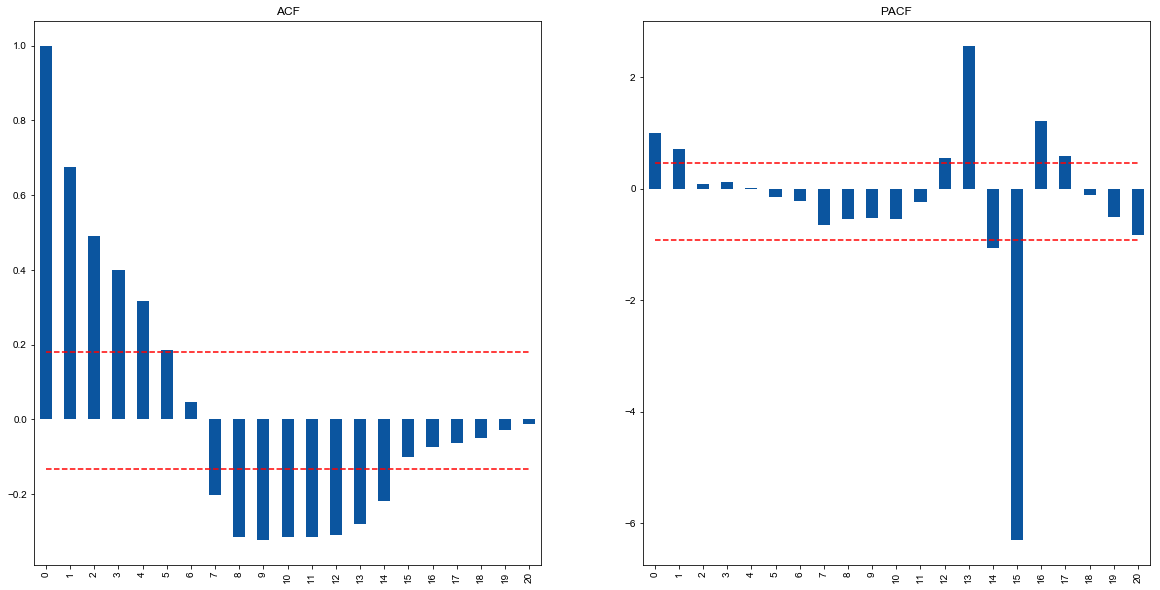

In [63]:
## Analyze EDM

edm = grouped_upsample('classificationGenre', 'Dance/Electronic')
edm, transform_value = log_transform(edm.unified_metric)
plot_acf(edm, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-

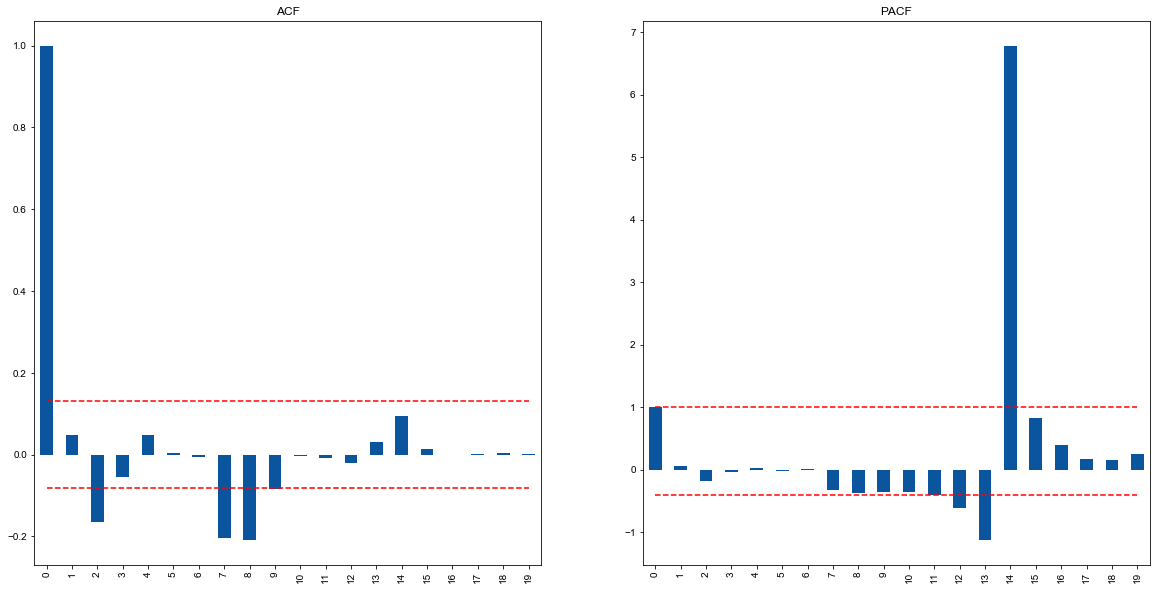

In [64]:
# Update differencing and replot residuals

lag1 = ARIMA(edm,(0,1,1)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -31.876
Method:                       css-mle   S.D. of innovations              1.186
Date:                Sat, 18 Aug 2018   AIC                             69.752
Time:                        22:14:51   BIC                             72.739
Sample:                    07-29-2018   HQIC                            70.335
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0999      0.165      0.604      0.554      -0.224       0.424
ma.L1.D.y     -0.3999      0.250     -1.600      0.127      -0.890       0.090
                                    Roots           

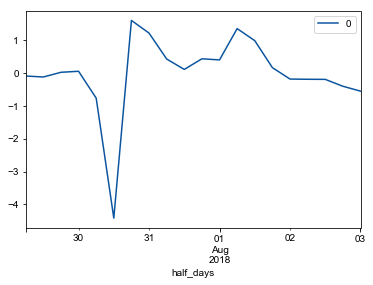

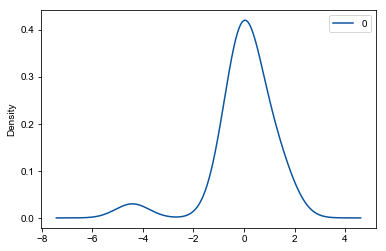

               0
count  20.000000
mean   -0.004707
std     1.216743
min    -4.416422
25%    -0.188173
50%     0.040748
75%     0.431455
max     1.604422
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -31.363
Method:                       css-mle   S.D. of innovations              1.089
Date:                Sat, 18 Aug 2018   AIC                             70.725
Time:                        22:14:51   BIC                             74.708
Sample:                    07-29-2018   HQIC                            71.503
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1628      0.053      3.046      0.007   

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


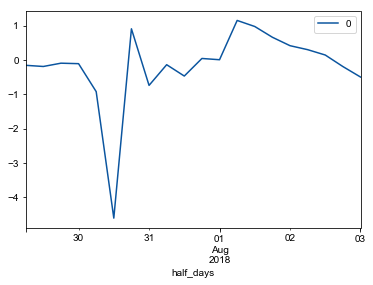

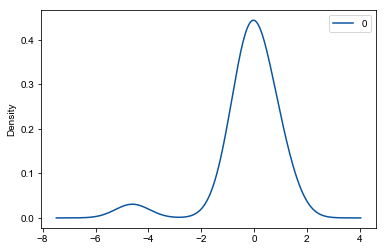

               0
count  20.000000
mean   -0.170085
std     1.180141
min    -4.604025
25%    -0.255661
50%    -0.095642
75%     0.334543
max     1.157188


In [65]:
# Select params

arima_analysis(edm, (0,1,1))
arima_analysis(edm, (0,1,2))

In [66]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Dance/Electronic')] = ((0,1,1), edm, 68.804, transform_value)

#### Rock

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


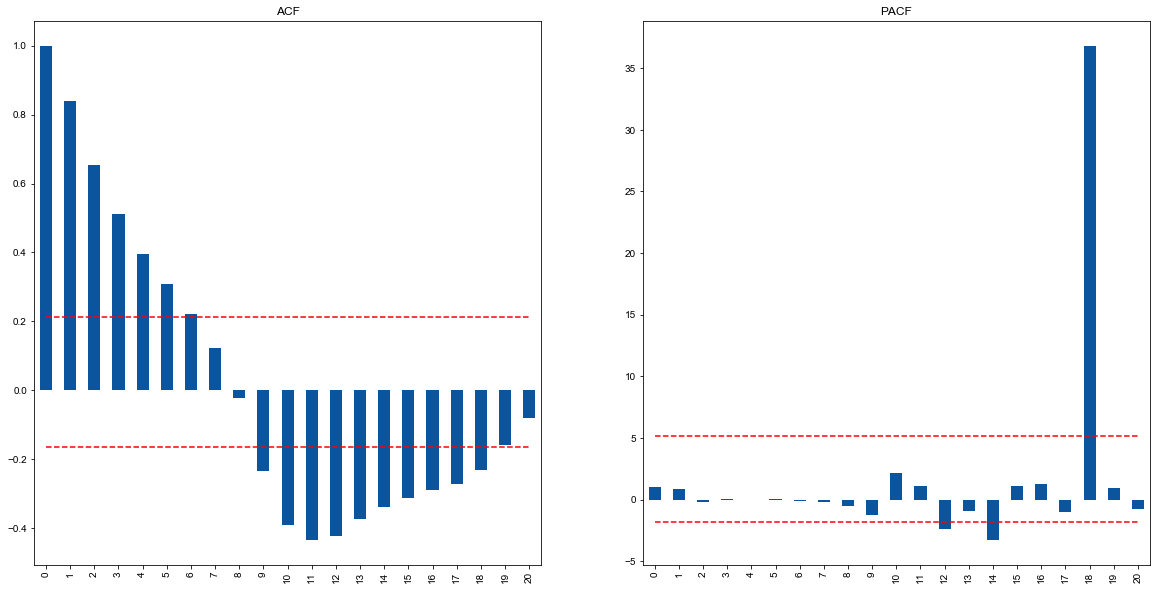

In [67]:
## Analyze Rock

rock = grouped_upsample('classificationGenre', 'Rock')
rock, transform_value = log_transform(rock.unified_metric)
plot_acf(rock, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


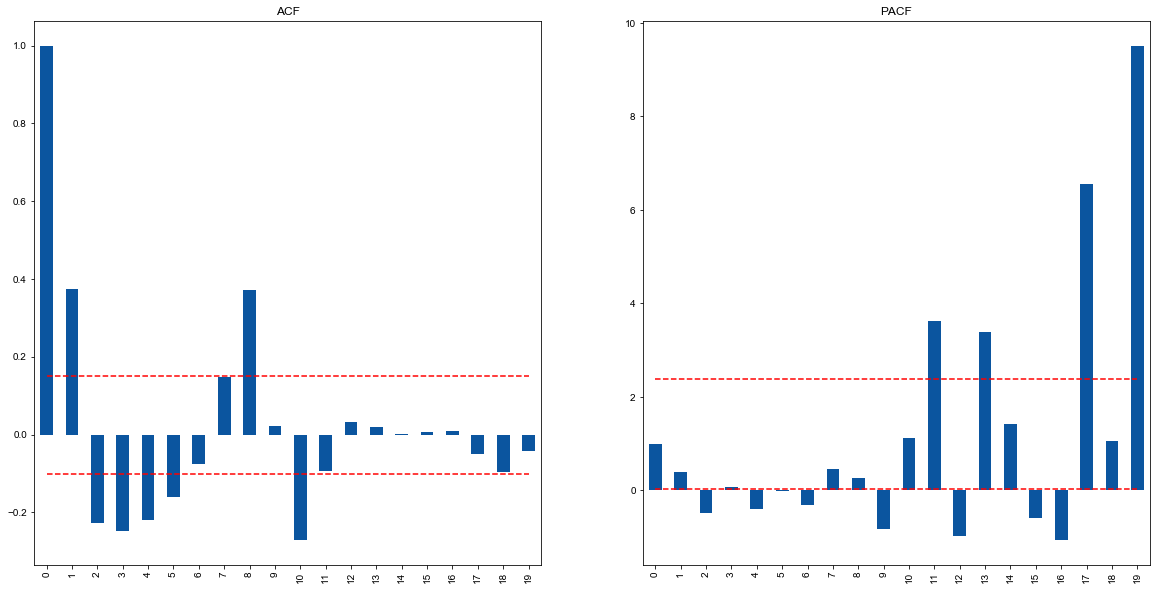

In [68]:
# Update differencing and replot residuals

lag1 = ARIMA(rock,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  17.350
Method:                       css-mle   S.D. of innovations              0.100
Date:                Sat, 18 Aug 2018   AIC                            -28.701
Time:                        22:14:53   BIC                            -25.714
Sample:                    07-29-2018   HQIC                           -28.118
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0537      0.036      1.477      0.157      -0.018       0.125
ma.L1.D.unified_metric     0.6549      0.157      4.166      0.001       0.347       0.963
    

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


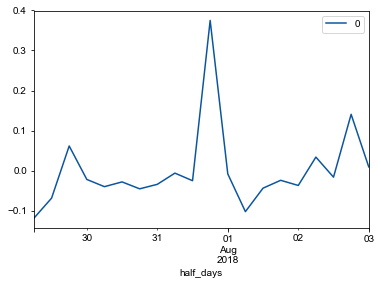

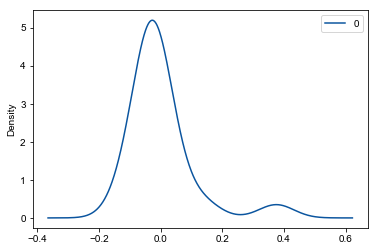

               0
count  20.000000
mean   -0.000107
std     0.104084
min    -0.118728
25%    -0.041091
50%    -0.024765
75%    -0.002442
max     0.375066
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  15.622
Method:                       css-mle   S.D. of innovations              0.110
Date:                Sat, 18 Aug 2018   AIC                            -25.243
Time:                        22:14:53   BIC                            -22.256
Sample:                    07-29-2018   HQIC                           -24.660
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0540

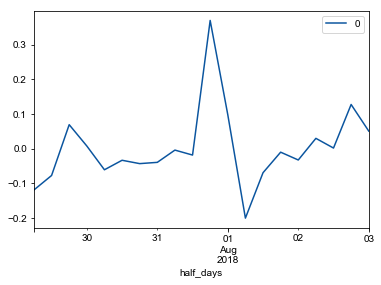

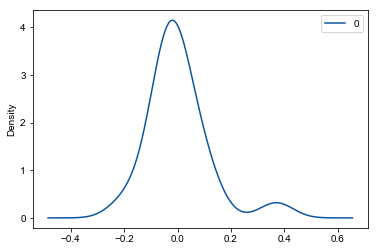

               0
count  20.000000
mean    0.002310
std     0.113687
min    -0.200252
25%    -0.047546
50%    -0.014262
75%     0.034997
max     0.369752
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  17.365
Method:                       css-mle   S.D. of innovations              0.100
Date:                Sat, 18 Aug 2018   AIC                            -26.729
Time:                        22:14:54   BIC                            -22.746
Sample:                    07-29-2018   HQIC                           -25.952
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0538

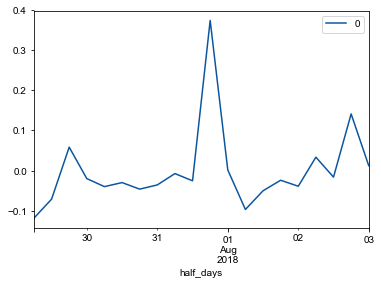

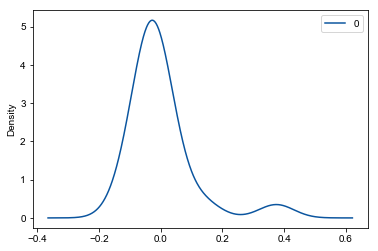

               0
count  20.000000
mean   -0.000195
std     0.103996
min    -0.118777
25%    -0.041776
50%    -0.024986
75%     0.004083
max     0.374405


In [69]:
# Select params

arima_analysis(rock, (0,1,1))
arima_analysis(rock, (1,1,0))
arima_analysis(rock, (1,1,1))

In [70]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Rock')] = ((1,1,0), rock, -35.240, transform_value)

#### R&B

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


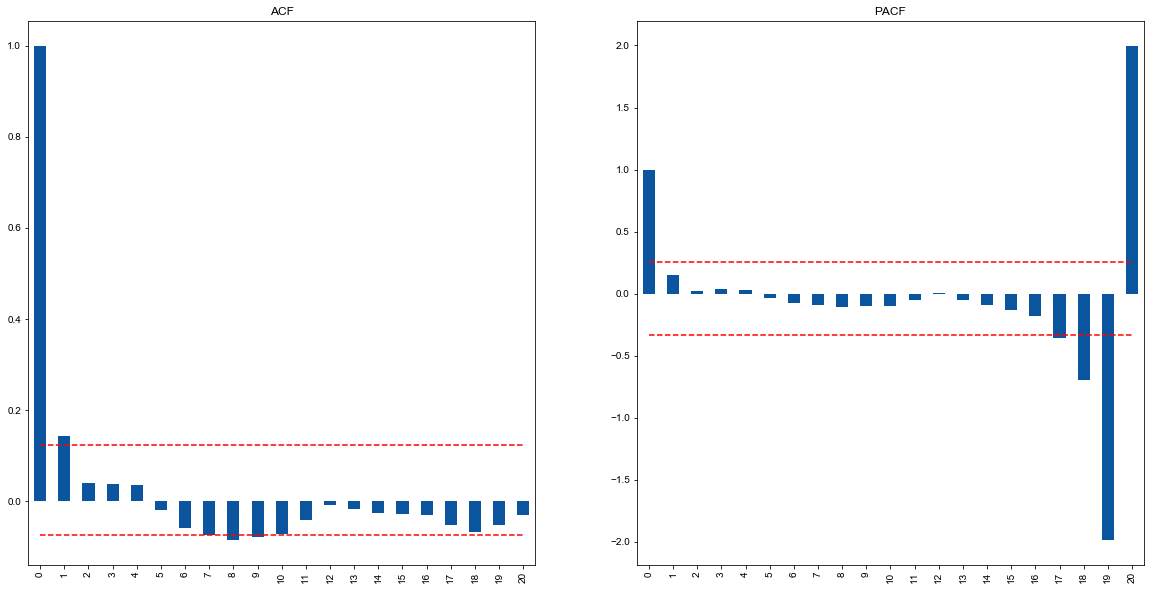

In [71]:
## Analyze R&B

rnb = grouped_upsample('classificationGenre', 'R&B')
rnb, transform_value = log_transform(rnb.unified_metric)
plot_acf(rnb, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Albert/anacon

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -36.426
Method:                       css-mle   S.D. of innovations              1.338
Date:                Sat, 18 Aug 2018   AIC                             78.851
Time:                        22:14:55   BIC                             81.985
Sample:                    07-29-2018   HQIC                            79.532
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6757      1.552      3.658      0.002       2.634       8.717
ar.L1.y        0.8011      0.232      3.459      0.003       0.347       1.255
                                    Roots           

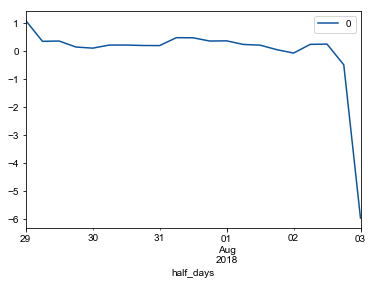

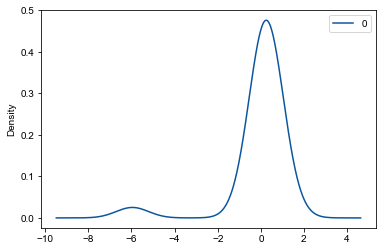

               0
count  21.000000
mean   -0.041901
std     1.384425
min    -5.957251
25%     0.149512
50%     0.220349
75%     0.362527
max     1.098378
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -36.848
Method:                       css-mle   S.D. of innovations              1.300
Date:                Sat, 18 Aug 2018   AIC                             79.696
Time:                        22:14:56   BIC                             82.829
Sample:                    07-29-2018   HQIC                            80.376
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2844      0.554     11.340      0.000   

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


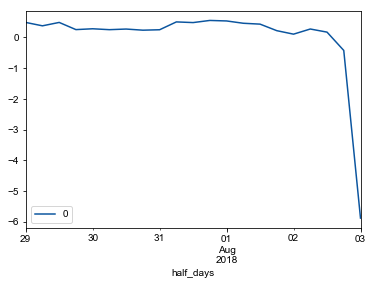

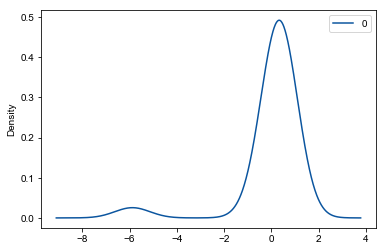

               0
count  21.000000
mean    0.017478
std     1.368486
min    -5.882046
25%     0.237152
50%     0.275274
75%     0.484844
max     0.554264


In [72]:
# Select params

arima_analysis(rnb, (1,0,0))
arima_analysis(rnb, (0,0,1))

In [73]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','R&B')] = ((0,0,1), rnb, 16.435, transform_value)

#### Hip-Hop & Rap

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


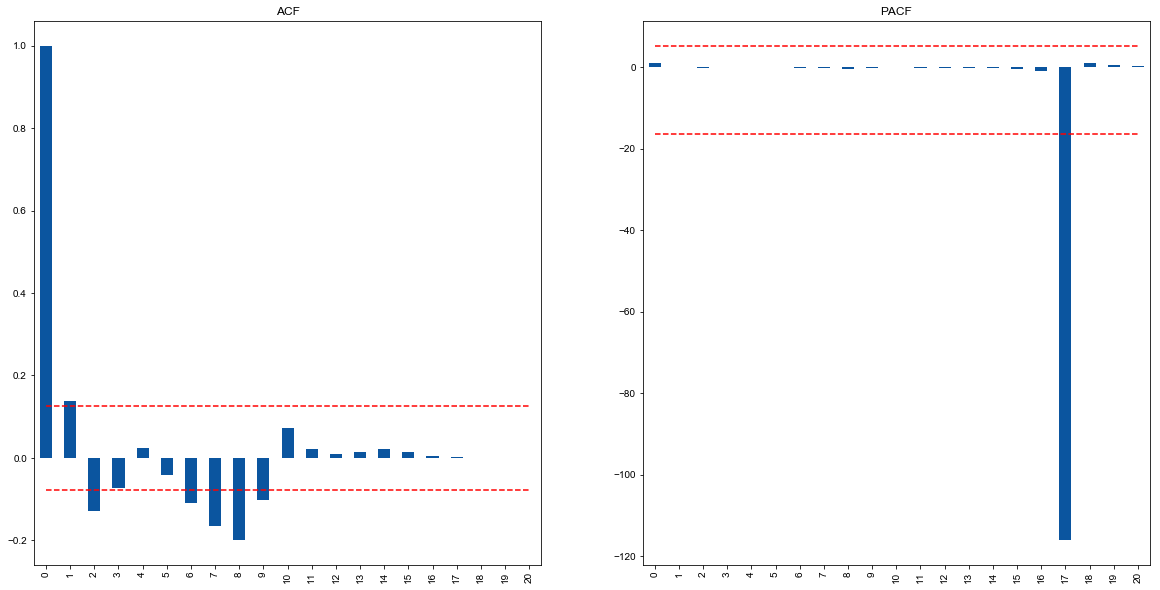

In [74]:
## Analyze Hip Hop

rap = grouped_upsample('classificationGenre', 'Hip-Hop/Rap')
rap, transform_value = log_transform(rap.unified_metric)
plot_acf(rap, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -33.715
Method:                       css-mle   S.D. of innovations              1.204
Date:                Sat, 18 Aug 2018   AIC                             73.430
Time:                        22:14:57   BIC                             76.563
Sample:                    07-29-2018   HQIC                            74.110
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2158      0.306     17.031      0.000       4.616       5.816
ma.L1.y        0.1735      0.232      0.748      0.464      -0.281       0.628
                                    Roots           

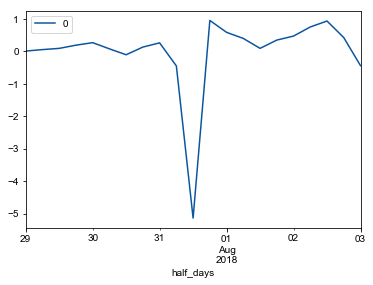

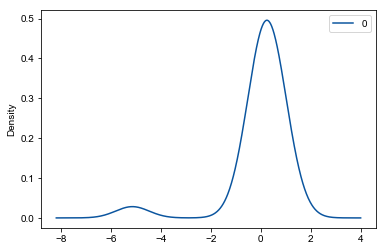

               0
count  21.000000
mean   -0.000031
std     1.233918
min    -5.138545
25%     0.058486
50%     0.194705
75%     0.428741
max     0.957634
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -33.780
Method:                       css-mle   S.D. of innovations              1.208
Date:                Sat, 18 Aug 2018   AIC                             73.560
Time:                        22:14:57   BIC                             76.693
Sample:                    07-29-2018   HQIC                            74.240
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2168      0.302     17.291      0.000   

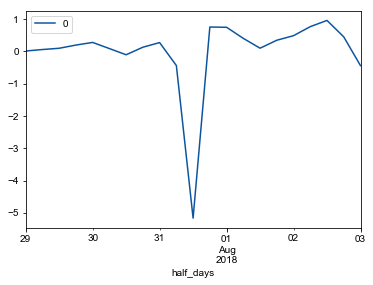

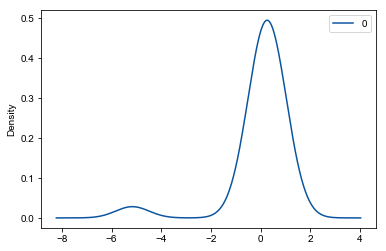

               0
count  21.000000
mean   -0.000076
std     1.238133
min    -5.163896
25%     0.058075
50%     0.196441
75%     0.449250
max     0.958948


In [75]:
# Select params

arima_analysis(rap, (0,0,1))
arima_analysis(rap, (1,0,0))

In [76]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Hip-Hop/Rap')] = ((0,0,1), rap, 20.698, transform_value)

#### Religious

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


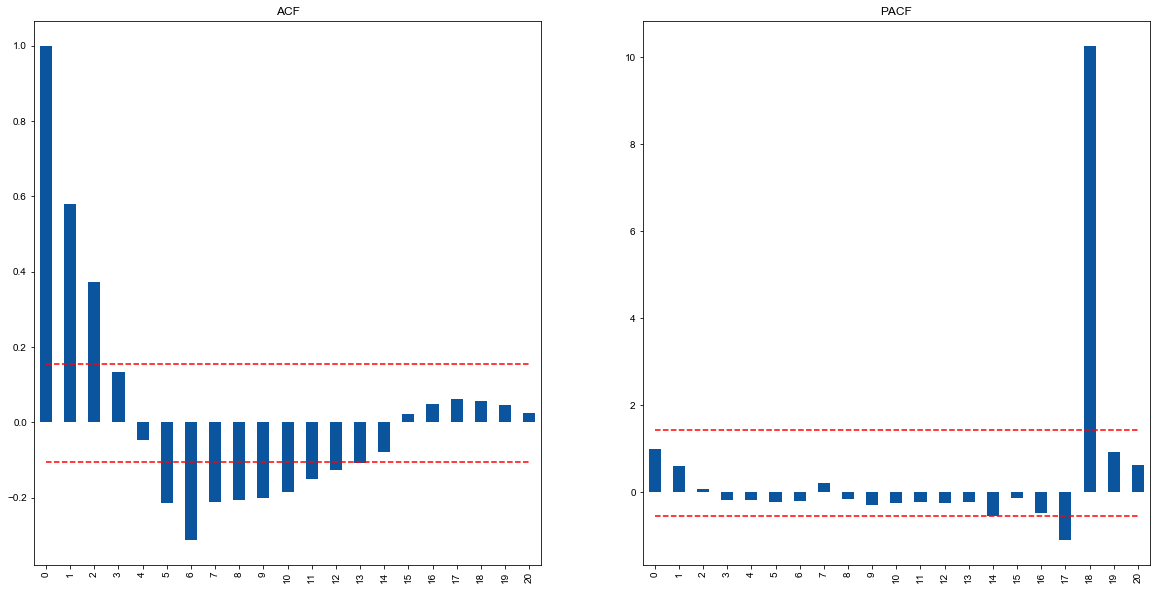

In [77]:
## Analyze Religious

relig = grouped_upsample('classificationGenre', 'Religious')
relig, transform_value = log_transform(relig.unified_metric)
plot_acf(relig, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -36.123
Method:                       css-mle   S.D. of innovations              1.338
Date:                Sat, 18 Aug 2018   AIC                             78.246
Time:                        22:14:58   BIC                             81.379
Sample:                    07-29-2018   HQIC                            78.926
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3712      0.672      9.482      0.000       5.054       7.688
ar.L1.y        0.5883      0.172      3.424      0.003       0.252       0.925
                                    Roots           

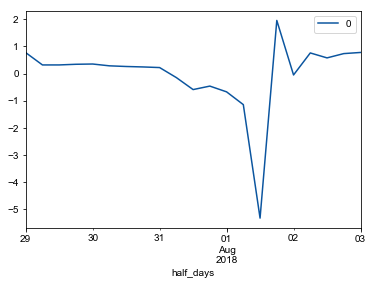

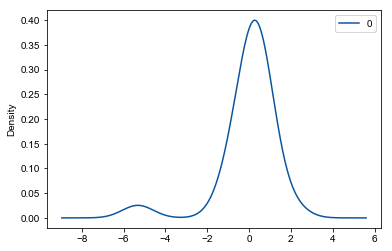

               0
count  21.000000
mean   -0.021629
std     1.374491
min    -5.317627
25%    -0.147428
50%     0.285735
75%     0.577717
max     1.955472
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                 -36.065
Method:                       css-mle   S.D. of innovations              1.334
Date:                Sat, 18 Aug 2018   AIC                             80.130
Time:                        22:14:59   BIC                             84.308
Sample:                    07-29-2018   HQIC                            81.036
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4030      0.719      8.906      0.000   

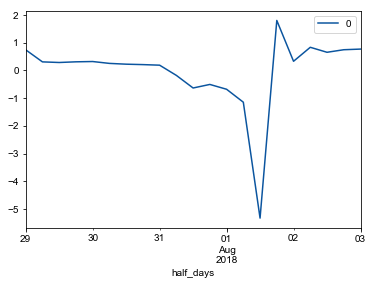

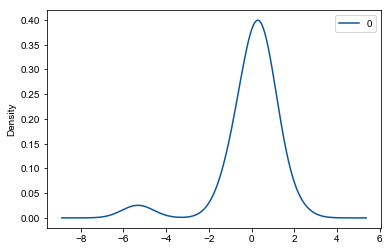

               0
count  21.000000
mean   -0.025899
std     1.370038
min    -5.326452
25%    -0.181731
50%     0.283197
75%     0.651275
max     1.798875
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -37.657
Method:                       css-mle   S.D. of innovations              1.447
Date:                Sat, 18 Aug 2018   AIC                             81.315
Time:                        22:14:59   BIC                             84.448
Sample:                    07-29-2018   HQIC                            81.995
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2563      0.446     14.042      0.000   

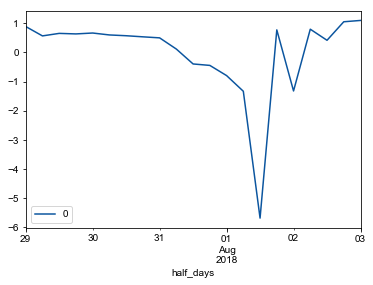

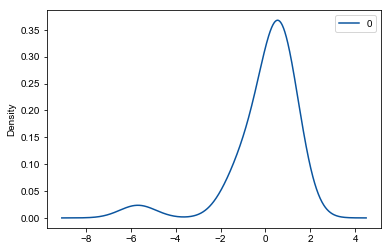

               0
count  21.000000
mean   -0.006600
std     1.484822
min    -5.681689
25%    -0.396950
50%     0.564926
75%     0.663587
max     1.094838
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -36.085
Method:                       css-mle   S.D. of innovations              1.335
Date:                Sat, 18 Aug 2018   AIC                             80.170
Time:                        22:14:59   BIC                             84.348
Sample:                    07-29-2018   HQIC                            81.077
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3935      0.706      9.052      0.000   

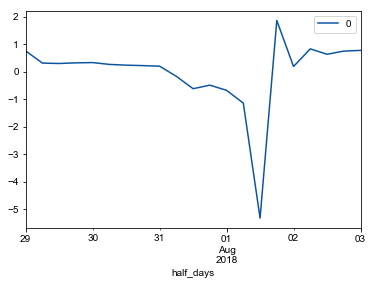

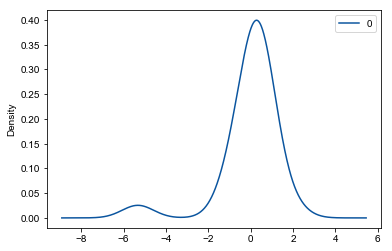

               0
count  21.000000
mean   -0.024743
std     1.371610
min    -5.322853
25%    -0.172060
50%     0.260602
75%     0.629739
max     1.858058
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                 -35.992
Method:                       css-mle   S.D. of innovations              1.329
Date:                Sat, 18 Aug 2018   AIC                             81.984
Time:                        22:15:00   BIC                             87.207
Sample:                    07-29-2018   HQIC                            83.118
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4001      0.711      8.996      0.000   

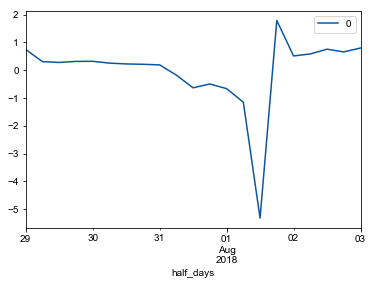

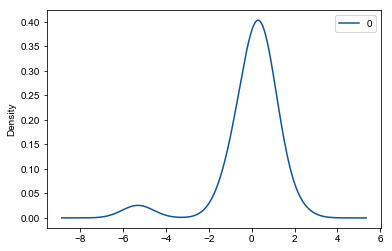

               0
count  21.000000
mean   -0.024825
std     1.364881
min    -5.318273
25%    -0.178559
50%     0.277191
75%     0.582581
max     1.786712


In [78]:
# Select params

arima_analysis(relig, (1,0,0))
arima_analysis(relig, (2,0,0))
arima_analysis(relig, (0,0,1))
arima_analysis(relig, (1,0,1))
arima_analysis(relig, (2,0,1))

In [79]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Religious')] = ((2,0,0), relig, 23.351, transform_value)

#### Country

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


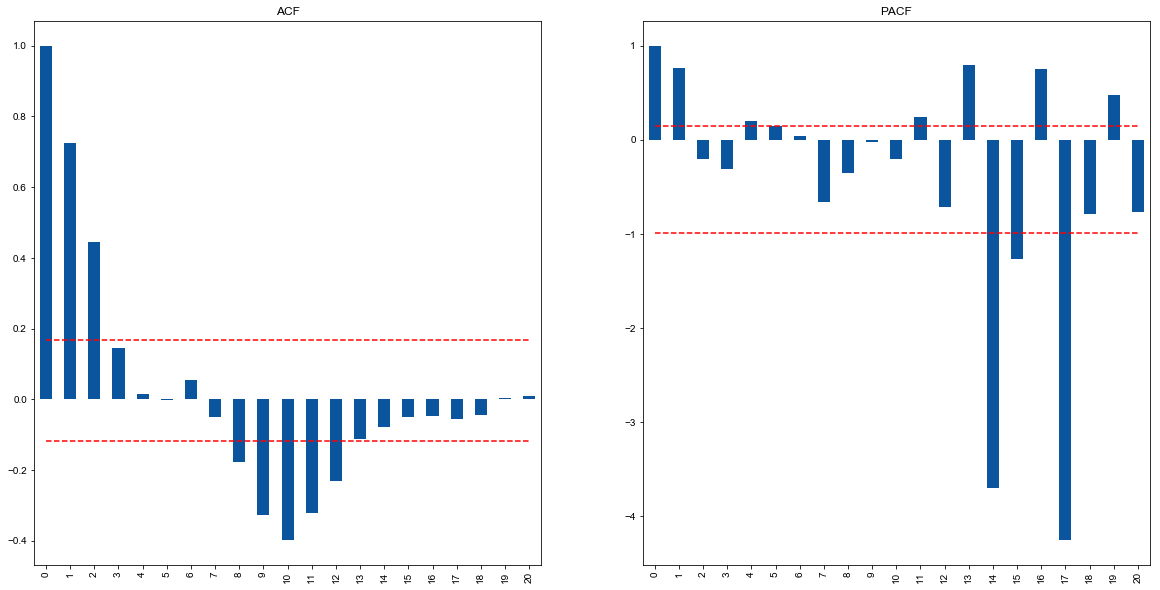

In [80]:
## Analyze Rock

country = grouped_upsample('classificationGenre', 'Country')
country, transform_value = log_transform(country.unified_metric)
plot_acf(country, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


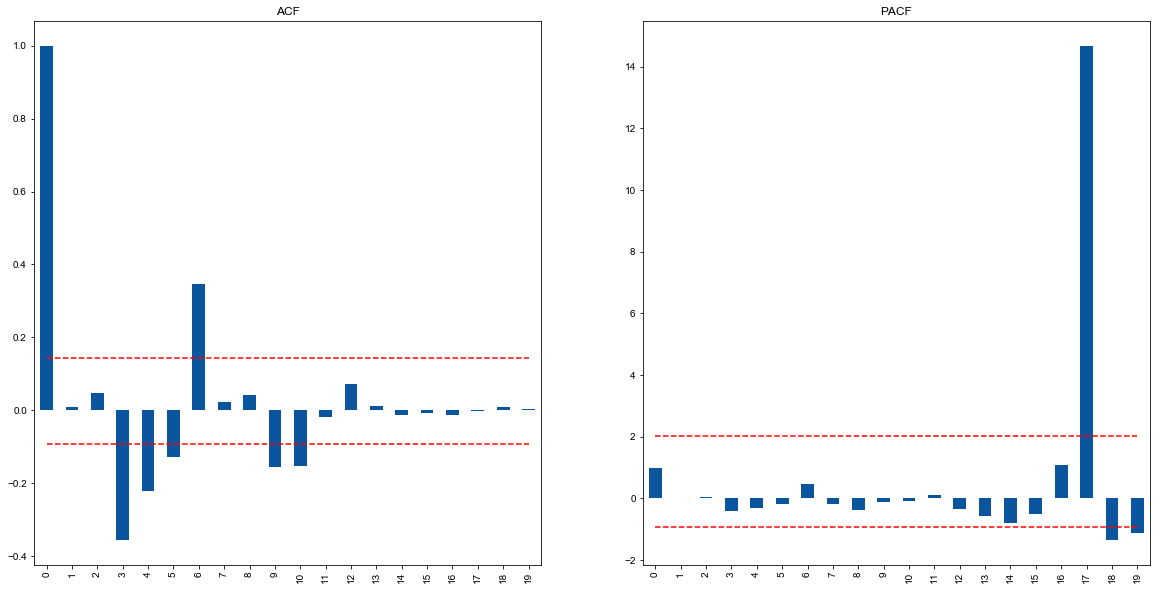

In [81]:
# Update differencing and replot residuals

lag1 = ARIMA(country,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -31.765
Method:                       css-mle   S.D. of innovations              1.184
Date:                Sat, 18 Aug 2018   AIC                             69.530
Time:                        22:15:01   BIC                             72.517
Sample:                    07-29-2018   HQIC                            70.113
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0617      0.267      0.231      0.820      -0.463       0.586
ar.L1.D.y      0.0097      0.220      0.044      0.965      -0.421       0.441
                                    Roots           

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


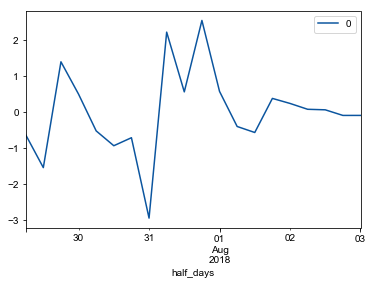

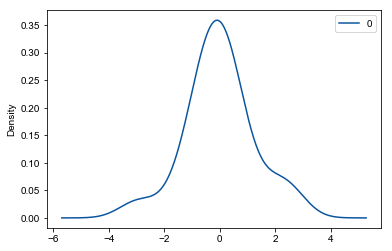

               0
count  20.000000
mean    0.000309
std     1.215246
min    -2.950304
25%    -0.588236
50%    -0.020377
75%     0.507713
max     2.539414
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -31.742
Method:                       css-mle   S.D. of innovations              1.183
Date:                Sat, 18 Aug 2018   AIC                             71.485
Time:                        22:15:02   BIC                             75.468
Sample:                    07-29-2018   HQIC                            72.262
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.281      0.198      0.845   

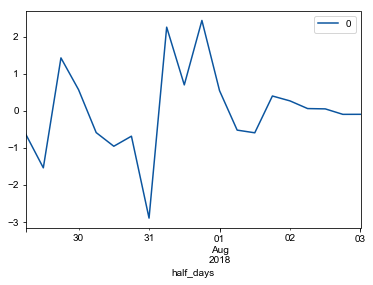

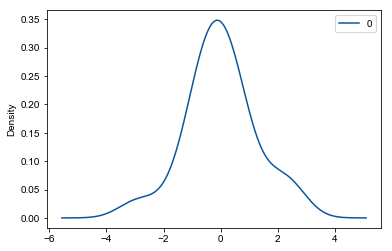

               0
count  20.000000
mean    0.005545
std     1.213870
min    -2.898732
25%    -0.603289
50%    -0.021734
75%     0.550462
max     2.440325
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -32.035
Method:                       css-mle   S.D. of innovations              1.093
Date:                Sat, 18 Aug 2018   AIC                             70.070
Time:                        22:15:02   BIC                             73.204
Sample:                    07-29-2018   HQIC                            70.751
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8131      0.788      6.106      0.000   

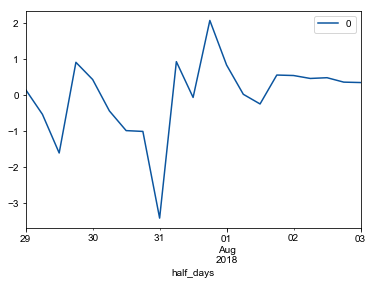

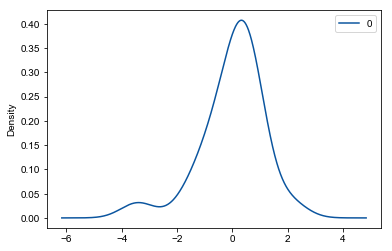

               0
count  21.000000
mean   -0.005349
std     1.119931
min    -3.418753
25%    -0.436322
50%     0.353528
75%     0.548978
max     2.081172
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                 -31.772
Method:                       css-mle   S.D. of innovations              1.078
Date:                Sat, 18 Aug 2018   AIC                             71.545
Time:                        22:15:03   BIC                             75.723
Sample:                    07-29-2018   HQIC                            72.451
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7632      0.707      6.734      0.000   

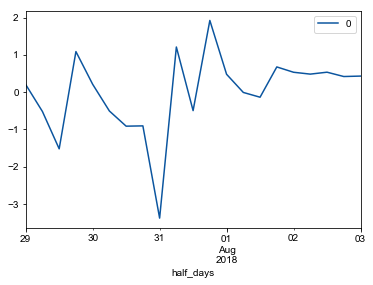

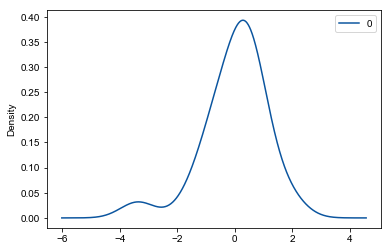

               0
count  21.000000
mean   -0.008322
std     1.104861
min    -3.375293
25%    -0.504982
50%     0.211496
75%     0.533670
max     1.922122
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -35.031
Method:                       css-mle   S.D. of innovations              1.272
Date:                Sat, 18 Aug 2018   AIC                             76.062
Time:                        22:15:03   BIC                             79.196
Sample:                    07-29-2018   HQIC                            76.742
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6423      0.422     10.997      0.000   

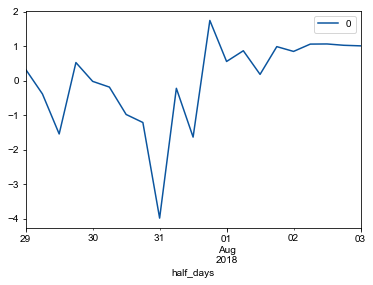

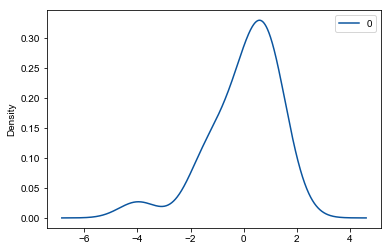

               0
count  21.000000
mean    0.000558
std     1.305203
min    -3.980756
25%    -0.385384
50%     0.325292
75%     0.985053
max     1.743258
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -31.765
Method:                       css-mle   S.D. of innovations              1.184
Date:                Sat, 18 Aug 2018   AIC                             69.530
Time:                        22:15:03   BIC                             72.517
Sample:                    07-29-2018   HQIC                            70.113
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0617      0.267      0.231      0.820   

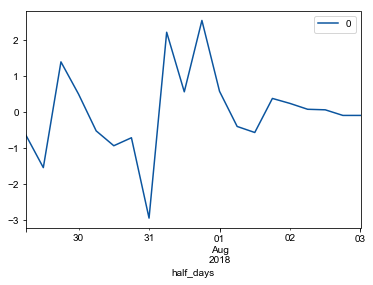

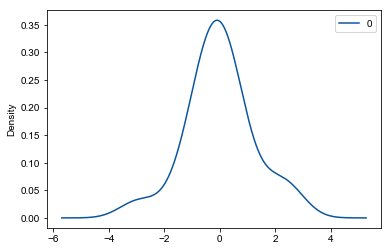

               0
count  20.000000
mean    0.000273
std     1.215252
min    -2.951064
25%    -0.588511
50%    -0.020418
75%     0.508923
max     2.540057
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -30.839
Method:                       css-mle   S.D. of innovations              1.090
Date:                Sat, 18 Aug 2018   AIC                             69.677
Time:                        22:15:04   BIC                             73.660
Sample:                    07-29-2018   HQIC                            70.455
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1076      0.103      1.049      0.309   

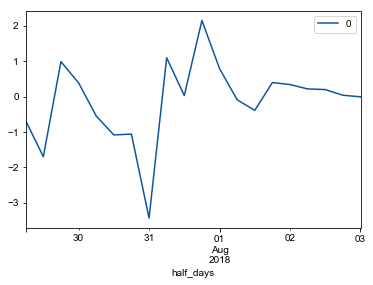

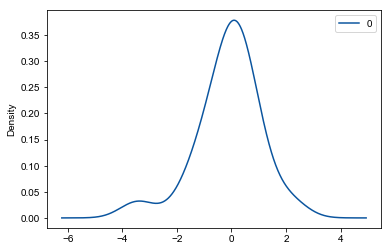

               0
count  20.000000
mean   -0.119461
std     1.158419
min    -3.431286
25%    -0.581511
50%     0.031694
75%     0.388593
max     2.146677


In [82]:
# Select params

arima_analysis(country, (1,1,0))
arima_analysis(country, (2,1,0))
arima_analysis(country, (1,0,0))
arima_analysis(country, (2,0,0))
arima_analysis(country, (0,0,1))
arima_analysis(country, (0,1,1))
arima_analysis(country, (1,1,1))

In [83]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Country')] = ((1,1,1), country, 68.402, transform_value)

#### Undefined

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


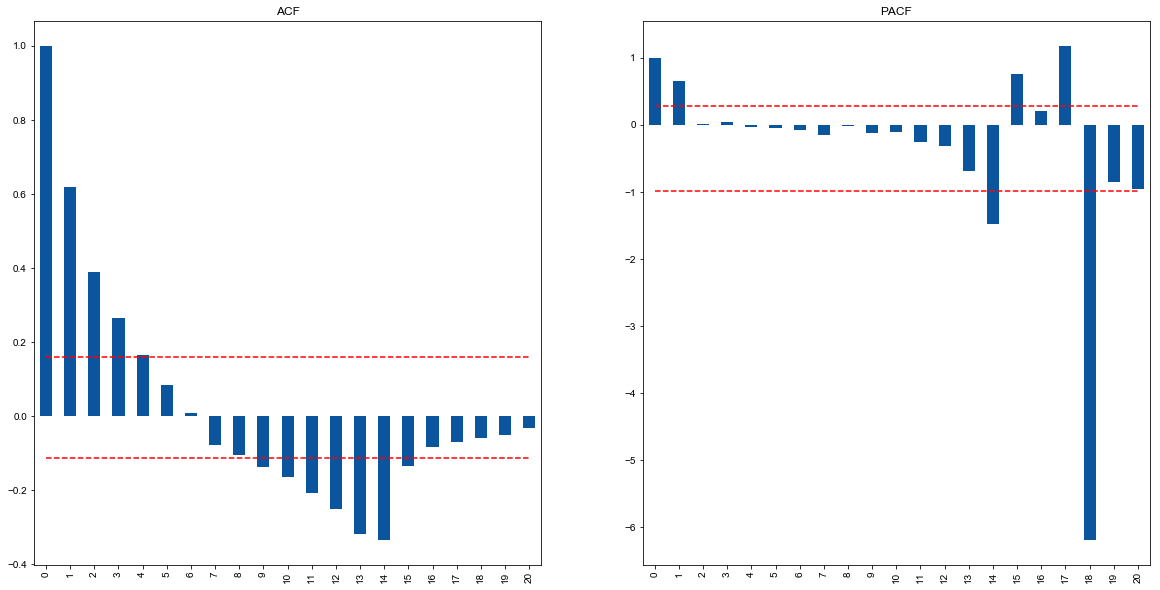

In [84]:
## Analyze Undefined

undefined = grouped_upsample('classificationGenre', 'Undefined')
undefined, transform_value = log_transform(undefined.unified_metric)
plot_acf(undefined, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


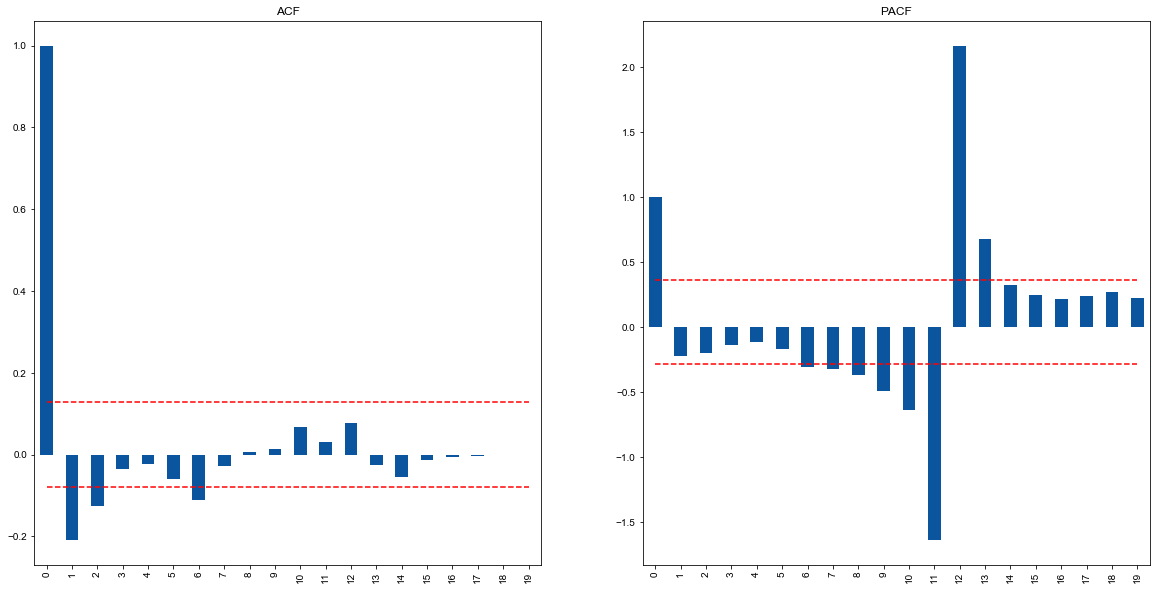

In [85]:
# Update differencing and replot residuals

lag1 = ARIMA(undefined,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -26.916
Method:                       css-mle   S.D. of innovations              0.927
Date:                Sat, 18 Aug 2018   AIC                             59.833
Time:                        22:15:05   BIC                             62.820
Sample:                    07-29-2018   HQIC                            60.416
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1026      0.145      0.708      0.488      -0.181       0.387
ma.L1.D.unified_metric    -0.3179      0.283     -1.123      0.276      -0.873       0.237
    

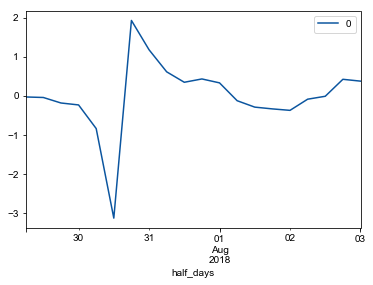

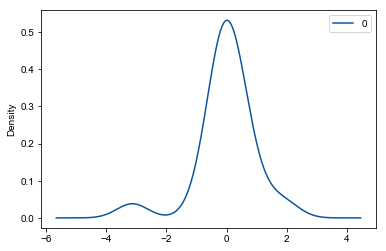

               0
count  20.000000
mean   -0.001697
std     0.951107
min    -3.130933
25%    -0.246720
50%    -0.035361
75%     0.388234
max     1.930618
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -27.350
Method:                       css-mle   S.D. of innovations              0.878
Date:                Sat, 18 Aug 2018   AIC                             62.699
Time:                        22:15:06   BIC                             66.877
Sample:                    07-29-2018   HQIC                            63.606
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.8325      

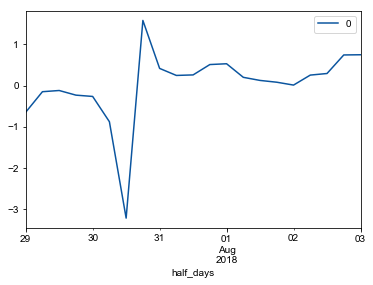

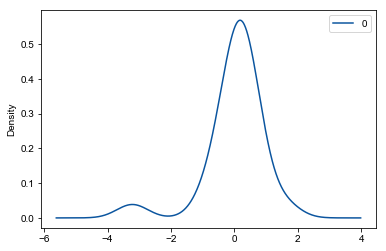

               0
count  21.000000
mean    0.022182
std     0.904540
min    -3.219557
25%    -0.150069
50%     0.198929
75%     0.415345
max     1.580073
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -29.050
Method:                       css-mle   S.D. of innovations              0.958
Date:                Sat, 18 Aug 2018   AIC                             64.100
Time:                        22:15:06   BIC                             67.234
Sample:                    07-29-2018   HQIC                            64.780
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.7645      

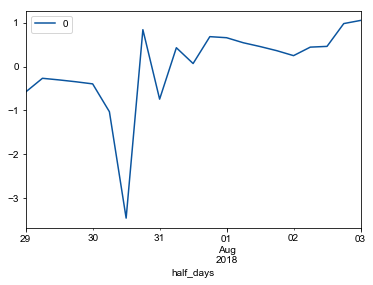

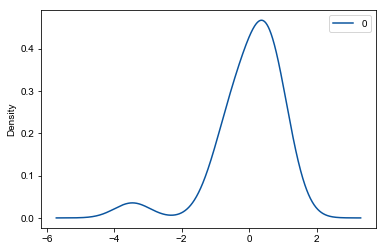

               0
count  21.000000
mean    0.004651
std     0.983347
min    -3.459967
25%    -0.347438
50%     0.362205
75%     0.543195
max     1.052546
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -27.142
Method:                       css-mle   S.D. of innovations              0.939
Date:                Sat, 18 Aug 2018   AIC                             60.285
Time:                        22:15:07   BIC                             63.272
Sample:                    07-29-2018   HQIC                            60.868
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1056

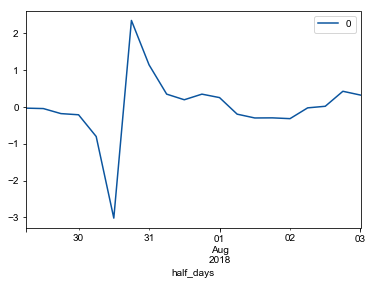

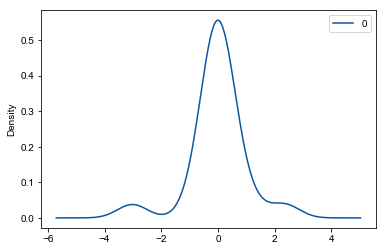

               0
count  20.000000
mean   -0.000316
std     0.963500
min    -3.020447
25%    -0.232974
50%    -0.027976
75%     0.329601
max     2.351627
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -25.361
Method:                       css-mle   S.D. of innovations              0.816
Date:                Sat, 18 Aug 2018   AIC                             58.723
Time:                        22:15:07   BIC                             62.705
Sample:                    07-29-2018   HQIC                            59.500
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1217

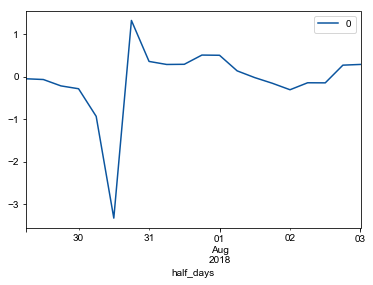

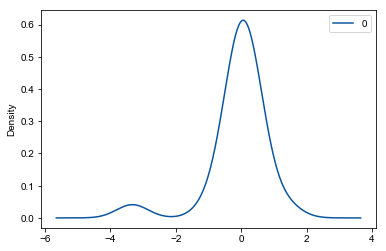

               0
count  20.000000
mean   -0.082977
std     0.883394
min    -3.325943
25%    -0.169659
50%    -0.034377
75%     0.290034
max     1.323949


In [86]:
# Select params

arima_analysis(undefined, (0,1,1))
arima_analysis(undefined, (1,0,1))
arima_analysis(undefined, (0,0,1))
arima_analysis(undefined, (1,1,0))
arima_analysis(undefined, (1,1,1))

In [87]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Undefined')] = ((1,1,1), undefined, 58.580, transform_value)

#### Pop

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


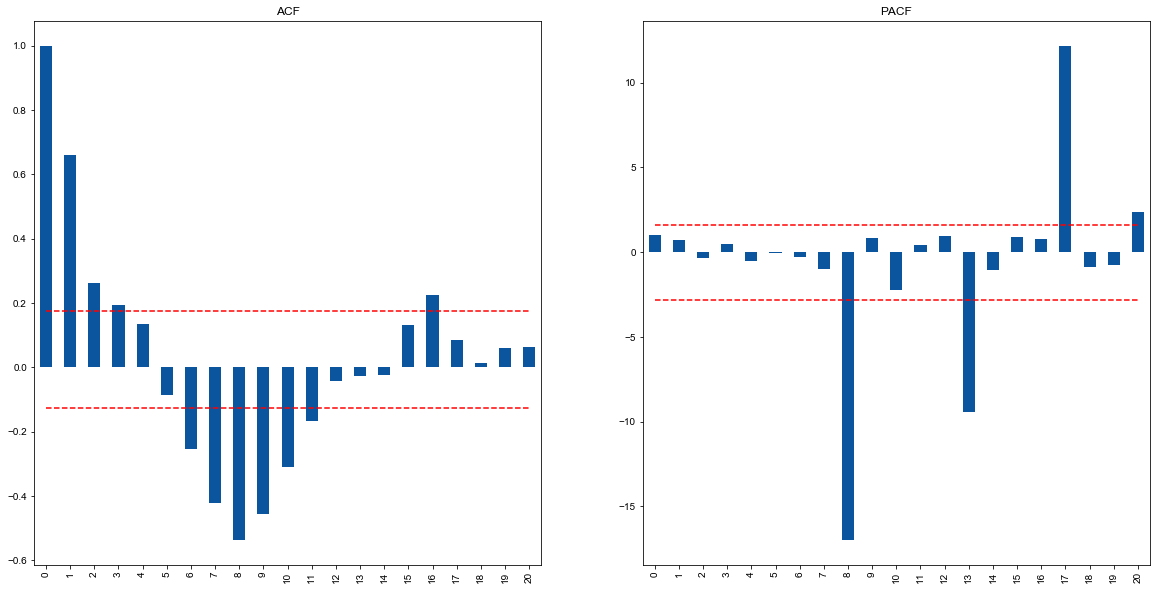

In [88]:
## Analyze Pop

pop = grouped_upsample('classificationGenre', 'Pop')
pop, transform_value = log_transform(pop.unified_metric)
plot_acf(pop, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


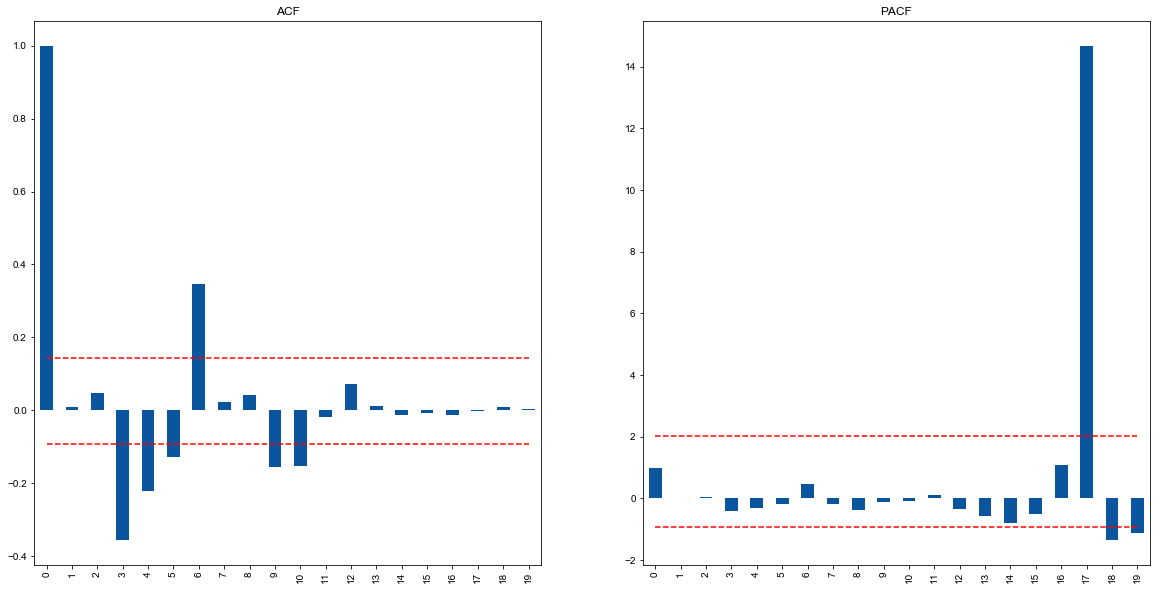

In [89]:
# Update differencing and replot residuals

lag1 = ARIMA(country,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                  19.480
Method:                       css-mle   S.D. of innovations              0.089
Date:                Sat, 18 Aug 2018   AIC                            -32.961
Time:                        22:15:09   BIC                            -29.827
Sample:                    07-29-2018   HQIC                           -32.281
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.9137      0.038    155.994      0.000       5.839       5.988
ma.L1.unified_metric     0.9998      0.193      5.172      0.000       0.621       1.379
            

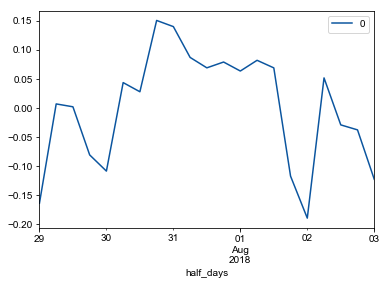

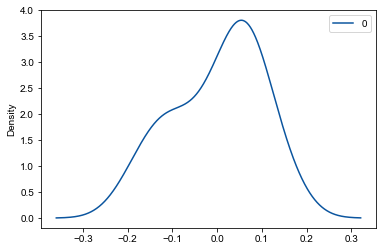

               0
count  21.000000
mean    0.001076
std     0.098454
min    -0.189505
25%    -0.080772
50%     0.027865
75%     0.069022
max     0.150554
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  19.256
Method:                       css-mle   S.D. of innovations              0.088
Date:                Sat, 18 Aug 2018   AIC                            -32.513
Time:                        22:15:09   BIC                            -29.525
Sample:                    07-29-2018   HQIC                           -31.929
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0009

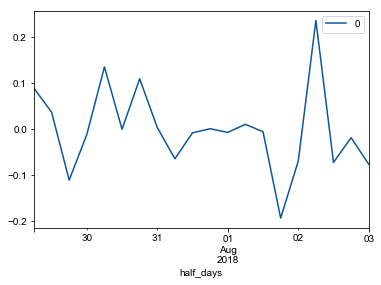

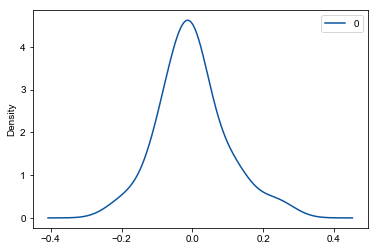

               0
count  20.000000
mean   -0.000086
std     0.093429
min    -0.192705
25%    -0.064935
50%    -0.005637
75%     0.017835
max     0.237019
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  19.469
Method:                       css-mle   S.D. of innovations              0.085
Date:                Sat, 18 Aug 2018   AIC                            -30.938
Time:                        22:15:10   BIC                            -26.955
Sample:                    07-29-2018   HQIC                           -30.160
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0006

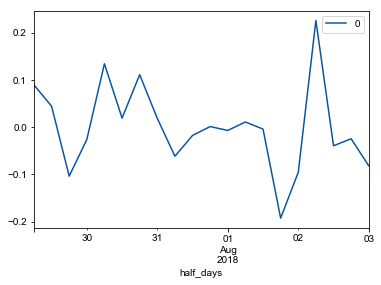

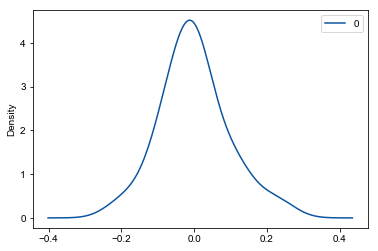

               0
count  20.000000
mean   -0.000045
std     0.092624
min    -0.192728
25%    -0.045023
50%    -0.005645
75%     0.025363
max     0.225895


In [90]:
# Select params

arima_analysis(pop, (0,0,1))
arima_analysis(pop, (0,1,1))
arima_analysis(pop, (1,1,1))

In [91]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Pop')] = ((0,1,1), pop, -27.724, transform_value)

#### Folk

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


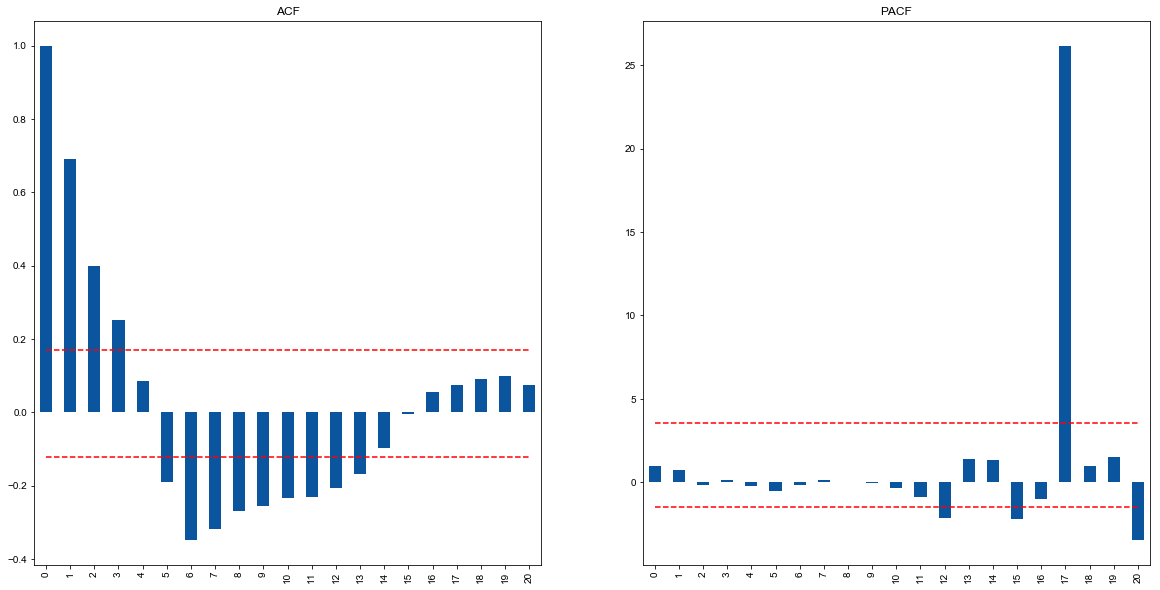

In [92]:
## Analyze Folk

folk = grouped_upsample('classificationGenre', 'Folk')
folk, transform_value = log_transform(folk.unified_metric)
plot_acf(folk, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   8.764
Method:                       css-mle   S.D. of innovations              0.152
Date:                Sat, 18 Aug 2018   AIC                            -11.528
Time:                        22:15:11   BIC                             -8.540
Sample:                    07-29-2018   HQIC                           -10.944
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0396      0.061     -0.651      0.523      -0.159       0.080
ma.L1.D.unified_metric     0.8362      0.122      6.843      0.000       0.597       1.076
    

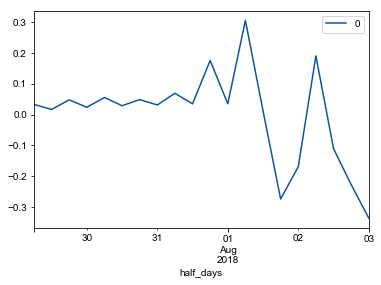

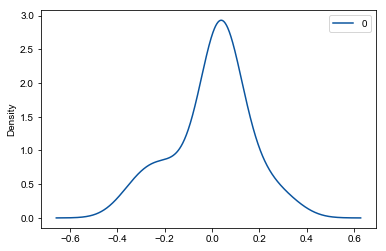

               0
count  20.000000
mean   -0.000405
std     0.155759
min    -0.336461
25%    -0.018338
50%     0.032151
75%     0.050524
max     0.305973
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   5.731
Method:                       css-mle   S.D. of innovations              0.180
Date:                Sat, 18 Aug 2018   AIC                             -5.461
Time:                        22:15:11   BIC                             -2.474
Sample:                    07-29-2018   HQIC                            -4.878
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0632

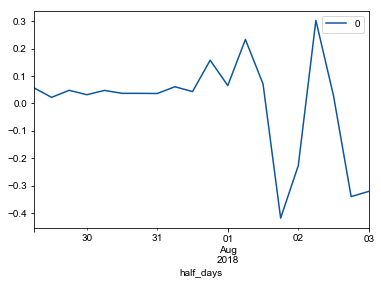

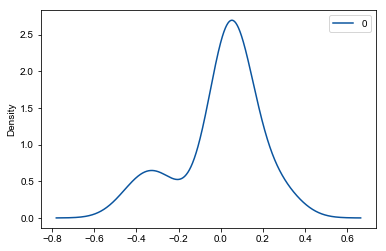

               0
count  20.000000
mean   -0.001736
std     0.184385
min    -0.419017
25%     0.026435
50%     0.039722
75%     0.061577
max     0.302603
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  10.588
Method:                       css-mle   S.D. of innovations              0.136
Date:                Sat, 18 Aug 2018   AIC                            -11.175
Time:                        22:15:12   BIC                             -6.197
Sample:                    07-29-2018   HQIC                           -10.203
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0330

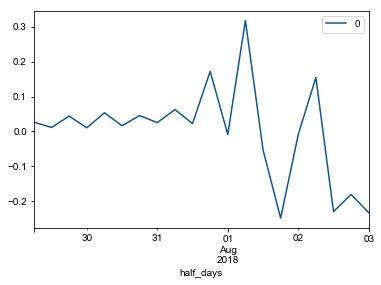

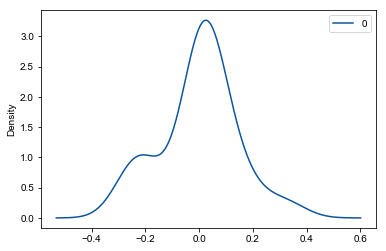

               0
count  20.000000
mean    0.000125
std     0.139894
min    -0.248216
25%    -0.019594
50%     0.019480
75%     0.047556
max     0.317983
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                   7.789
Method:                       css-mle   S.D. of innovations              0.160
Date:                Sat, 18 Aug 2018   AIC                             -7.577
Time:                        22:15:12   BIC                             -3.594
Sample:                    07-29-2018   HQIC                            -6.800
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0289

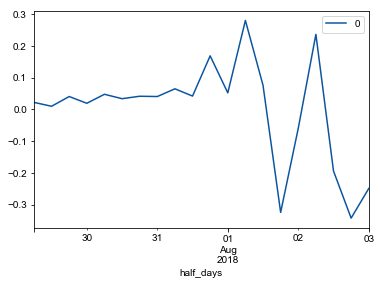

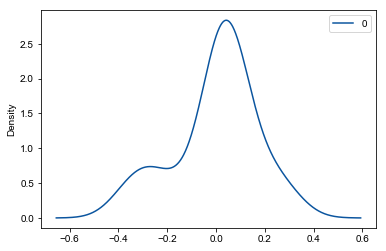

               0
count  20.000000
mean    0.000486
std     0.164447
min    -0.342697
25%    -0.007265
50%     0.040799
75%     0.055591
max     0.280786


In [93]:
# Select params

arima_analysis(folk, (0,1,1))
arima_analysis(folk, (1,1,0))
arima_analysis(folk, (2,1,1))
arima_analysis(folk, (2,1,0))

In [94]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Folk')] = ((0,0,1), folk, 45.208, transform_value)

#### World

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


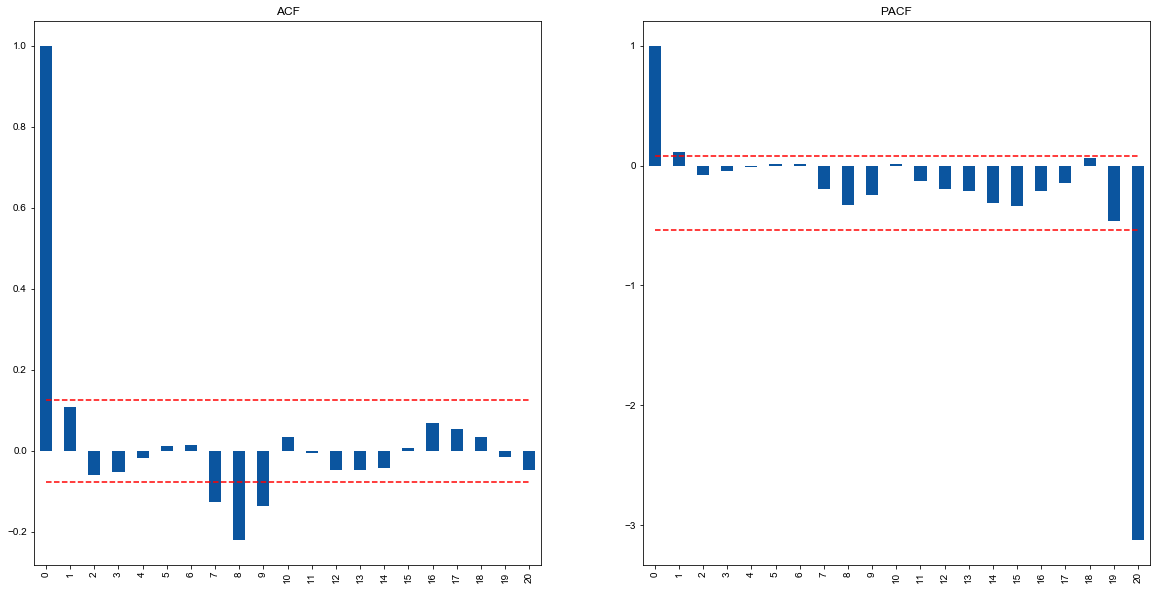

In [95]:
## Analyze Rock

world = grouped_upsample('classificationGenre', 'World')
world, transform_value = log_transform(world.unified_metric)
plot_acf(world, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


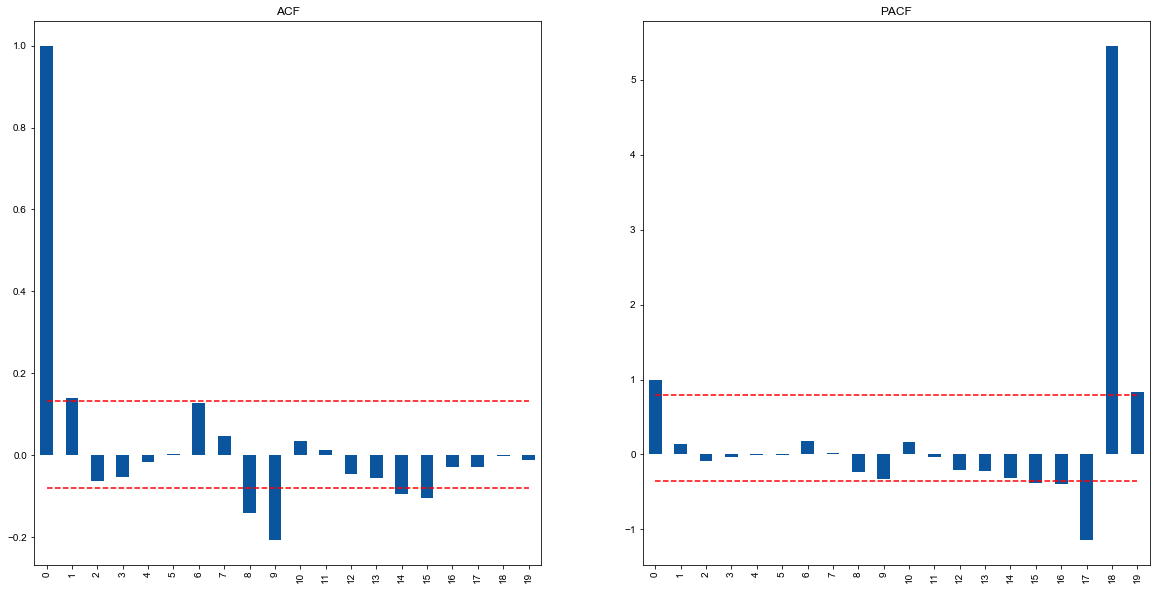

In [96]:
# Update differencing and replot residuals

lag1 = ARIMA(world,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -33.016
Method:                       css-mle   S.D. of innovations              1.154
Date:                Sat, 18 Aug 2018   AIC                             72.032
Time:                        22:15:14   BIC                             75.166
Sample:                    07-29-2018   HQIC                            72.712
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8263      0.709      6.807      0.000       3.437       6.216
ar.L1.y        0.5879      0.398      1.477      0.156      -0.192       1.368
                                    Roots           

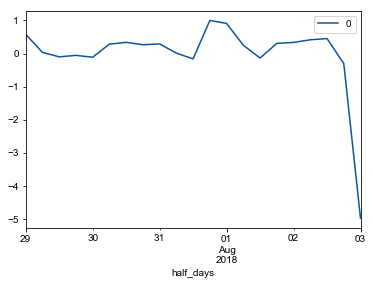

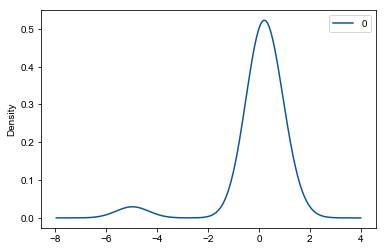

               0
count  21.000000
mean   -0.016309
std     1.184762
min    -4.974065
25%    -0.099218
50%     0.267268
75%     0.339315
max     1.001017
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -29.954
Method:                       css-mle   S.D. of innovations              1.068
Date:                Sat, 18 Aug 2018   AIC                             65.908
Time:                        22:15:14   BIC                             68.895
Sample:                    07-29-2018   HQIC                            66.491
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4032      0.385     -1.047      0.309   

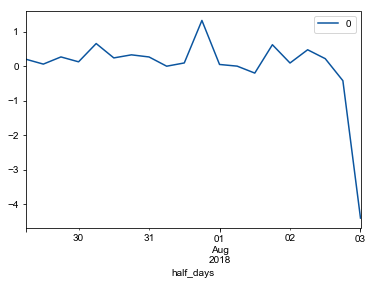

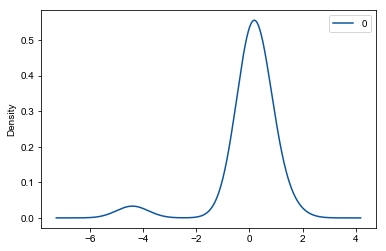

               0
count  20.000000
mean   -0.002882
std     1.096188
min    -4.405157
25%     0.034681
50%     0.161624
75%     0.280133
max     1.322211


In [97]:
# Select params

arima_analysis(world, (1,0,0))
arima_analysis(world, (0,1,1))

In [98]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','World')] = ((0,1,1), world, 31.430, transform_value)

#### Metal

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


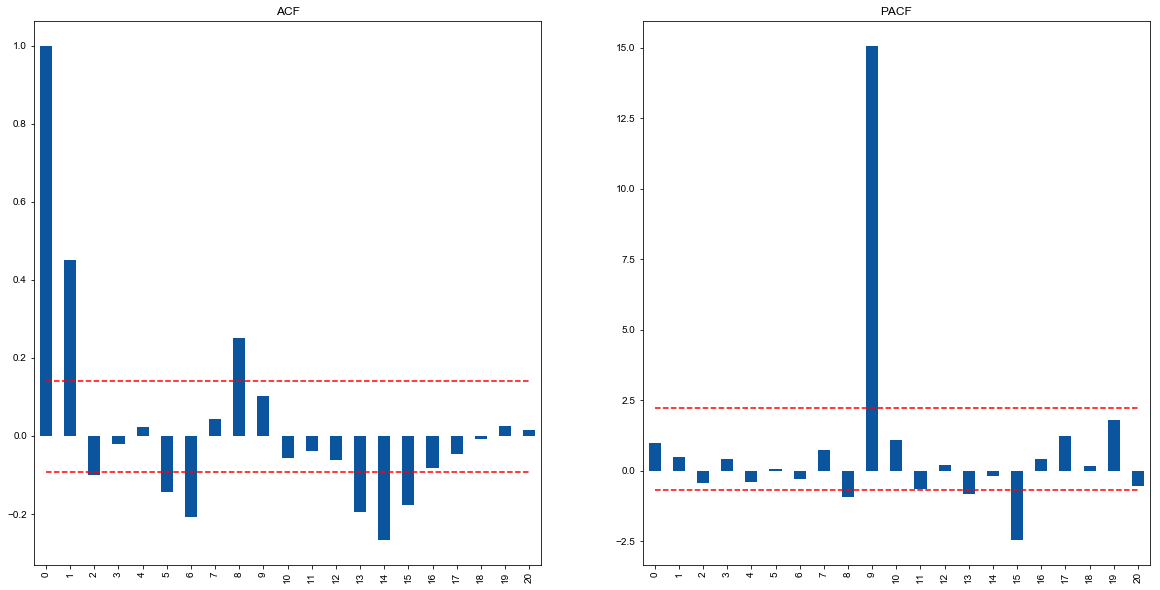

In [99]:
## Analyze Metal

metal = grouped_upsample('classificationGenre', 'Metal')
metal, transform_value = log_transform(metal.unified_metric)
plot_acf(metal, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                   1.886
Method:                       css-mle   S.D. of innovations              0.216
Date:                Sat, 18 Aug 2018   AIC                              2.228
Time:                        22:15:15   BIC                              5.362
Sample:                    07-29-2018   HQIC                             2.908
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5091      0.083     78.281      0.000       6.346       6.672
ma.L1.unified_metric     0.7982      0.156      5.121      0.000       0.493       1.104
            

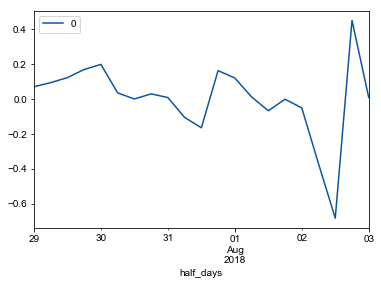

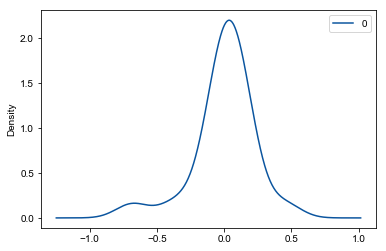

               0
count  21.000000
mean    0.001213
std     0.222261
min    -0.681832
25%    -0.051536
50%     0.011380
75%     0.119599
max     0.448830
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                   1.890
Method:                       css-mle   S.D. of innovations              0.216
Date:                Sat, 18 Aug 2018   AIC                              4.221
Time:                        22:15:16   BIC                              8.399
Sample:                    07-29-2018   HQIC                             5.128
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.5095      

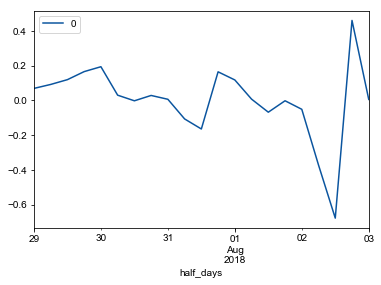

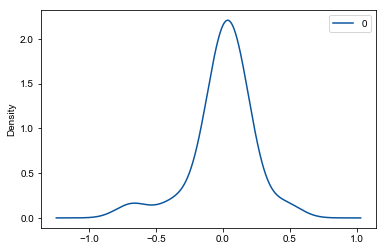

               0
count  21.000000
mean    0.001116
std     0.222212
min    -0.676208
25%    -0.050777
50%     0.007618
75%     0.117892
max     0.459929


In [100]:
# Select params

arima_analysis(metal, (0,0,1))
arima_analysis(metal, (1,0,1))

In [101]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Metal')] = ((1,0,1), metal, -4.900, transform_value)

#### Other

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


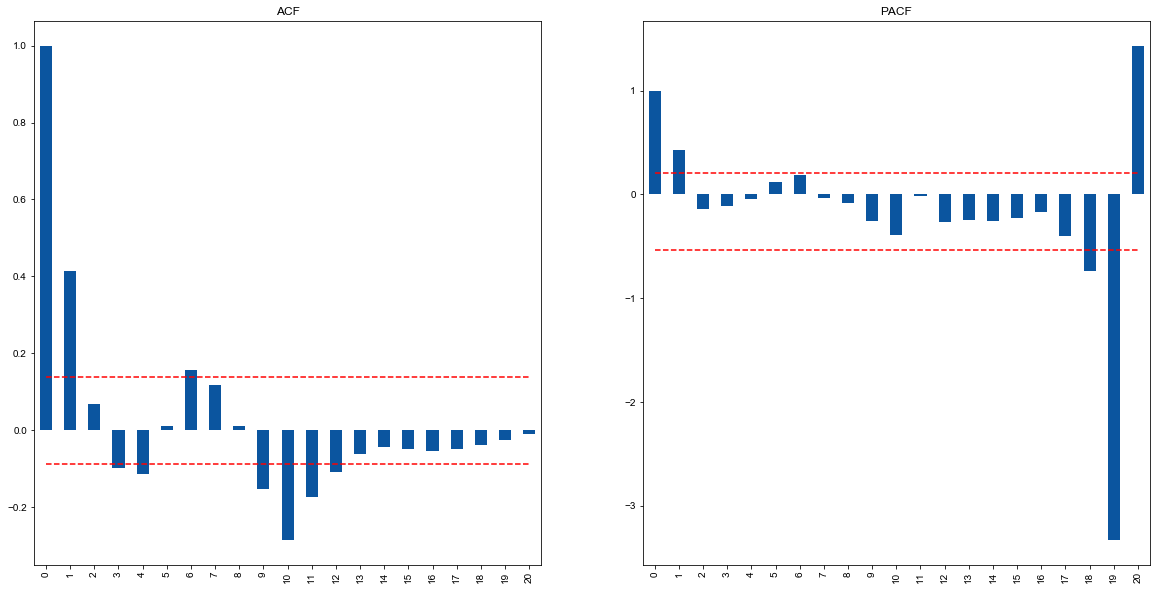

In [102]:
## Analyze Other

other = grouped_upsample('classificationGenre', 'Other')
other, transform_value = log_transform(other.unified_metric)
plot_acf(other, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


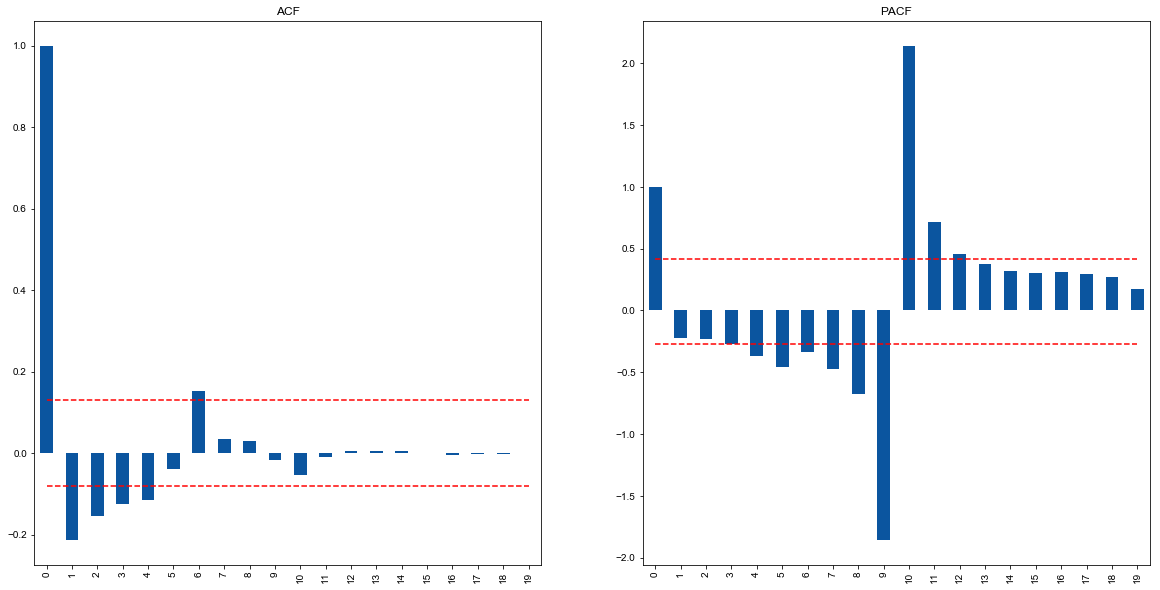

In [103]:
# Update differencing and replot residuals

lag1 = ARIMA(other,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -32.598
Method:                       css-mle   S.D. of innovations              1.137
Date:                Sat, 18 Aug 2018   AIC                             71.196
Time:                        22:15:18   BIC                             74.330
Sample:                    07-29-2018   HQIC                            71.876
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2391      0.412     10.284      0.000       3.431       5.047
ar.L1.y        0.4162      0.197      2.117      0.048       0.031       0.802
                                    Roots           

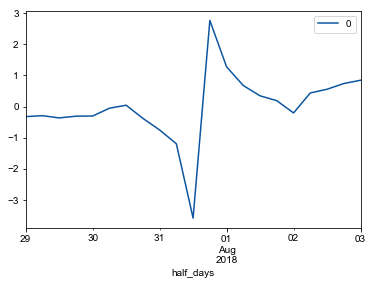

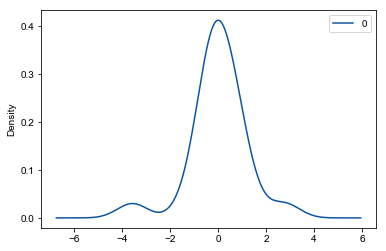

               0
count  21.000000
mean    0.006367
std     1.165945
min    -3.582526
25%    -0.321248
50%    -0.052386
75%     0.557414
max     2.767700
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -34.084
Method:                       css-mle   S.D. of innovations              1.329
Date:                Sat, 18 Aug 2018   AIC                             74.169
Time:                        22:15:18   BIC                             77.156
Sample:                    07-29-2018   HQIC                            74.752
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0805      0.249      0.323      0.750   

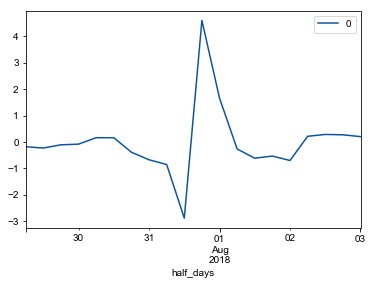

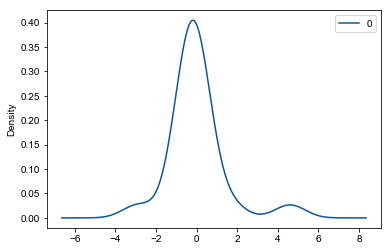

               0
count  20.000000
mean   -0.001871
std     1.363282
min    -2.892016
25%    -0.558578
50%    -0.148107
75%     0.201810
max     4.605331
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -31.500
Method:                       css-mle   S.D. of innovations              1.102
Date:                Sat, 18 Aug 2018   AIC                             71.000
Time:                        22:15:18   BIC                             74.983
Sample:                    07-29-2018   HQIC                            71.778
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0908      0.057      1.605      0.127   

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


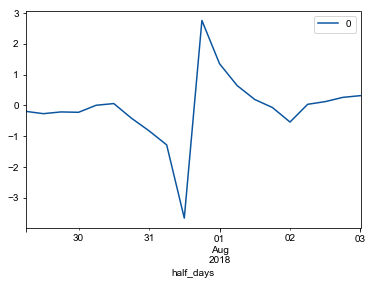

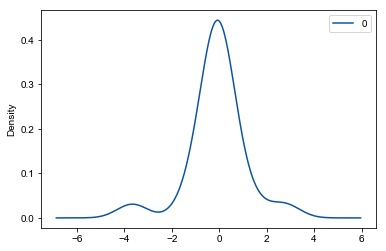

               0
count  20.000000
mean   -0.098974
std     1.175117
min    -3.658595
25%    -0.306941
50%    -0.033479
75%     0.206666
max     2.754006
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                 -32.467
Method:                       css-mle   S.D. of innovations              1.130
Date:                Sat, 18 Aug 2018   AIC                             72.933
Time:                        22:15:19   BIC                             77.112
Sample:                    07-29-2018   HQIC                            73.840
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2266      0.374     11.286      0.000   

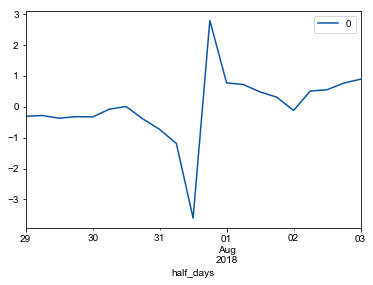

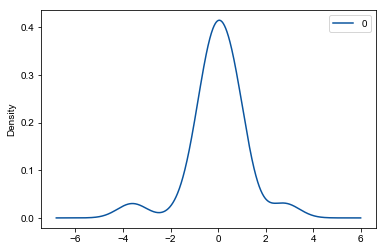

               0
count  21.000000
mean    0.002322
std     1.158056
min    -3.604965
25%    -0.329848
50%    -0.079413
75%     0.549059
max     2.792218
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -32.669
Method:                       css-mle   S.D. of innovations              1.142
Date:                Sat, 18 Aug 2018   AIC                             71.338
Time:                        22:15:19   BIC                             74.471
Sample:                    07-29-2018   HQIC                            72.018
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2209      0.344     12.280      0.000   

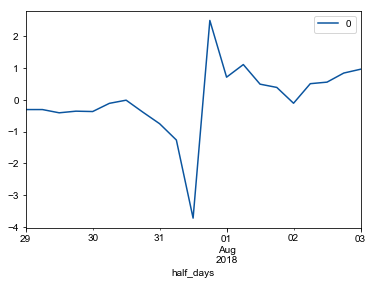

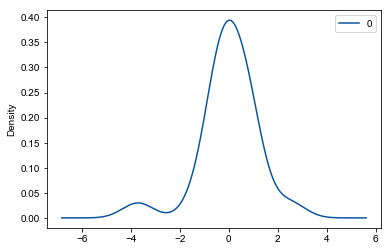

               0
count  21.000000
mean    0.002066
std     1.170327
min    -3.718890
25%    -0.364993
50%    -0.104050
75%     0.560153
max     2.501508
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                 -32.161
Method:                       css-mle   S.D. of innovations              1.084
Date:                Sat, 18 Aug 2018   AIC                             74.323
Time:                        22:15:20   BIC                             79.545
Sample:                    07-29-2018   HQIC                            75.456
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1946      0.222     18.868      0.000   

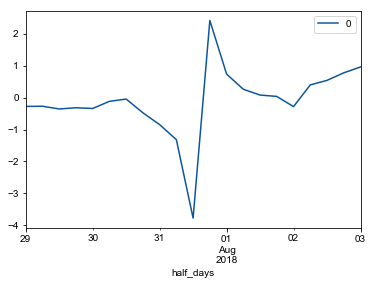

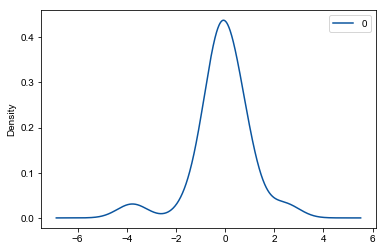

               0
count  21.000000
mean   -0.105360
std     1.133772
min    -3.774292
25%    -0.340380
50%    -0.117301
75%     0.397466
max     2.416697
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -31.224
Method:                       css-mle   S.D. of innovations              1.077
Date:                Sat, 18 Aug 2018   AIC                             72.449
Time:                        22:15:20   BIC                             77.427
Sample:                    07-29-2018   HQIC                            73.420
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0921      0.049      1.863      0.081   

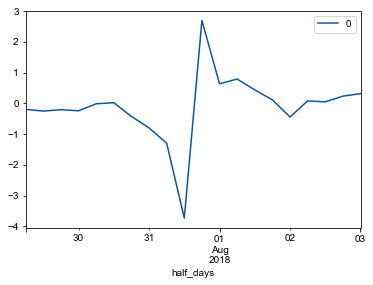

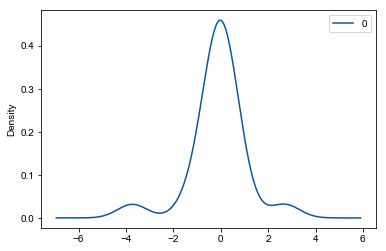

               0
count  20.000000
mean   -0.112696
std     1.152062
min    -3.731765
25%    -0.296224
50%     0.002637
75%     0.253420
max     2.693624


In [104]:
# Select params

arima_analysis(other, (1,0,0))
arima_analysis(other, (1,1,0))
arima_analysis(other, (1,1,1))
arima_analysis(other, (2,0,0))
arima_analysis(other, (0,0,1))
arima_analysis(other, (2,0,1))
arima_analysis(other, (2,1,1))

In [105]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Other')] = ((1,1,1), other, 70.255, transform_value)

#### Blues

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


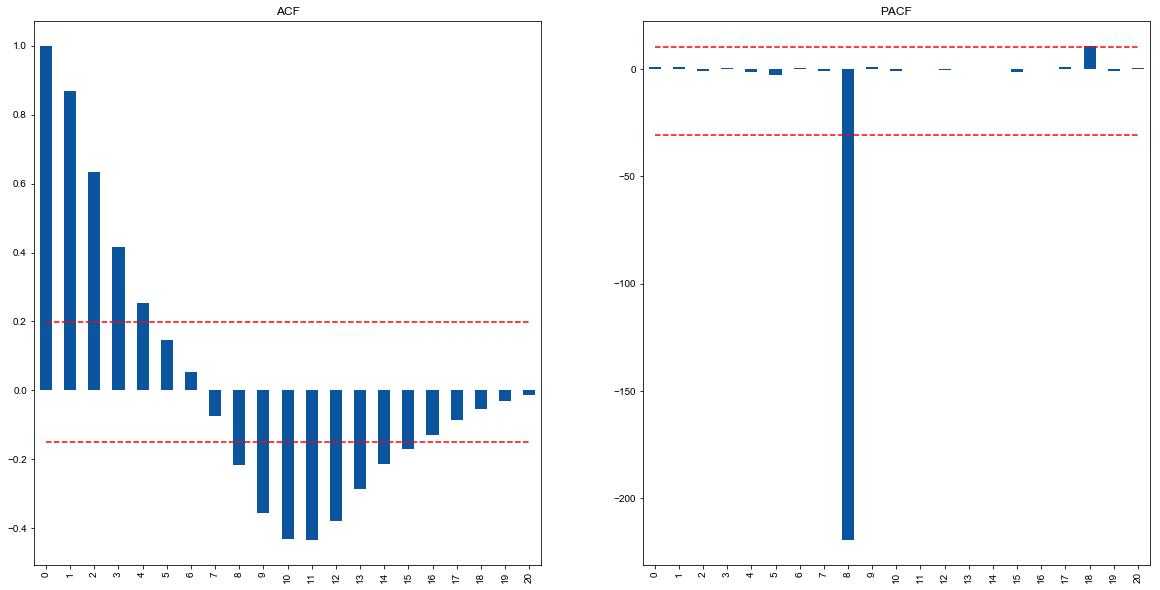

In [106]:
## Analyze Blues

blues = grouped_upsample('classificationGenre', 'Blues')
blues, transform_value = log_transform(blues.unified_metric)
plot_acf(blues, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


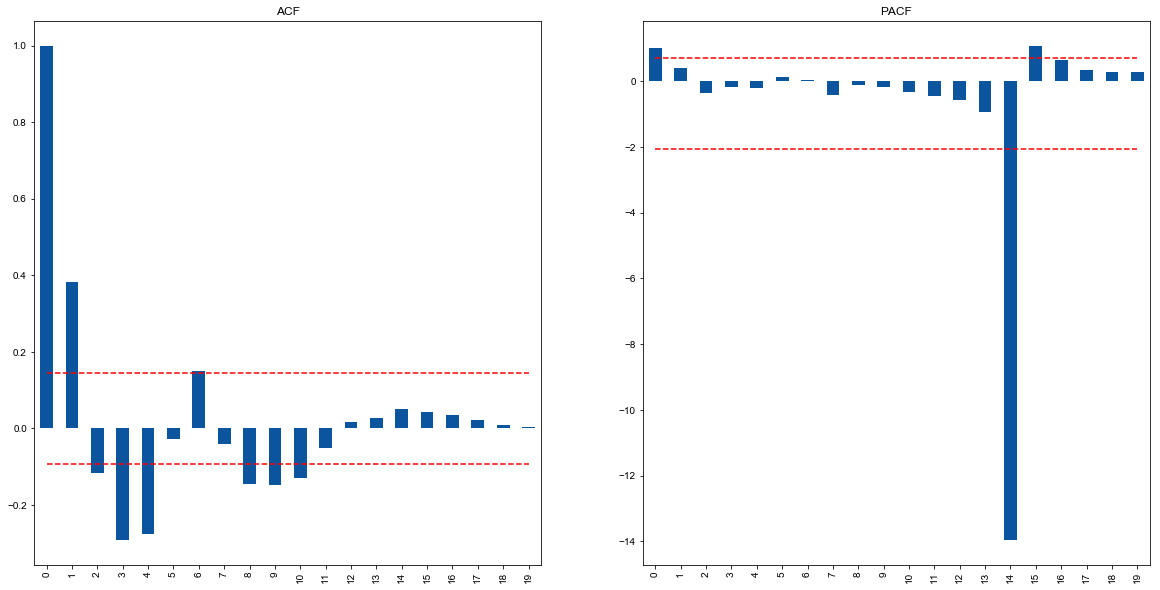

Statistic -0.0 - P 0.958532086060056


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [107]:
# Update differencing and replot residuals

lag1 = ARIMA(blues,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)
print ('Statistic {} - P {}'.format(adfuller(lag1.resid)[0], adfuller(lag1.resid)[1]))

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -1.243
Method:                       css-mle   S.D. of innovations              0.257
Date:                Sat, 18 Aug 2018   AIC                              8.487
Time:                        22:15:22   BIC                             11.474
Sample:                    07-29-2018   HQIC                             9.070
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0225      0.089      0.253      0.803      -0.152       0.197
ar.L1.D.unified_metric     0.3716      0.202      1.839      0.082      -0.024       0.768
    

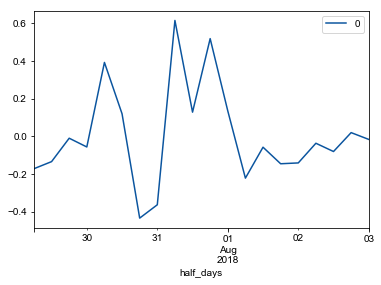

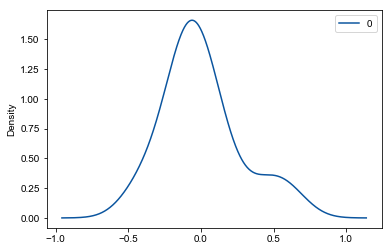

               0
count  20.000000
mean    0.003184
std     0.263584
min    -0.433289
25%    -0.141825
50%    -0.046277
75%     0.121864
max     0.614591
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  -0.348
Method:                       css-mle   S.D. of innovations              0.244
Date:                Sat, 18 Aug 2018   AIC                              8.696
Time:                        22:15:22   BIC                             12.679
Sample:                    07-29-2018   HQIC                             9.473
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0299

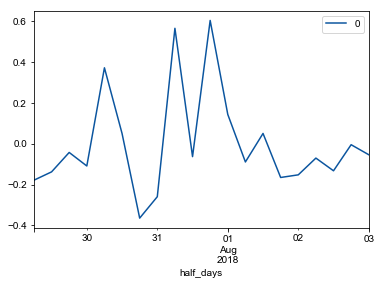

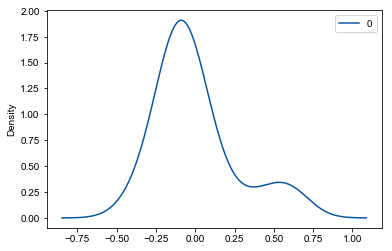

               0
count  20.000000
mean   -0.002106
std     0.251461
min    -0.364622
25%    -0.141701
50%    -0.066931
75%     0.050022
max     0.603841
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  -0.142
Method:                       css-mle   S.D. of innovations              0.233
Date:                Sat, 18 Aug 2018   AIC                              8.284
Time:                        22:15:23   BIC                             12.462
Sample:                    07-29-2018   HQIC                             9.191
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.7215      

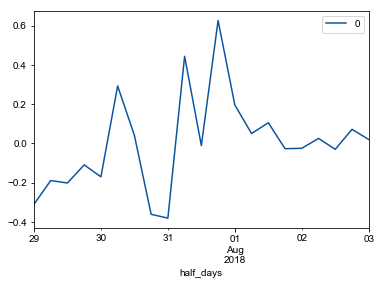

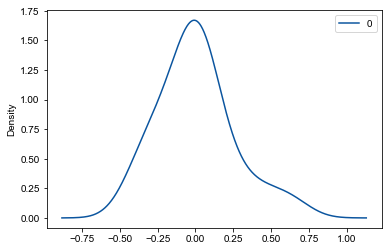

               0
count  21.000000
mean    0.002993
std     0.247583
min    -0.380252
25%    -0.169893
50%    -0.010731
75%     0.072047
max     0.626735
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                   0.133
Method:                       css-mle   S.D. of innovations              0.230
Date:                Sat, 18 Aug 2018   AIC                              9.734
Time:                        22:15:23   BIC                             14.957
Sample:                    07-29-2018   HQIC                            10.867
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.7307      

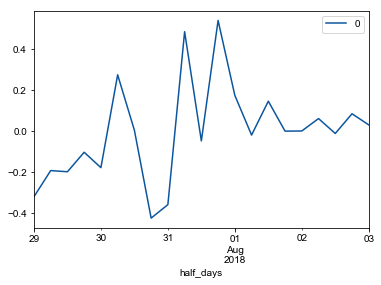

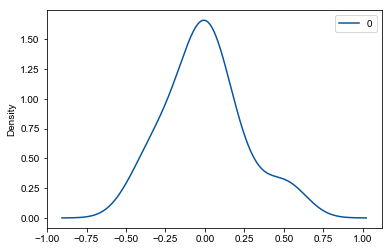

               0
count  21.000000
mean   -0.001707
std     0.244847
min    -0.423695
25%    -0.177521
50%     0.000656
75%     0.085491
max     0.540803
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -0.717
Method:                       css-mle   S.D. of innovations              0.249
Date:                Sat, 18 Aug 2018   AIC                              7.434
Time:                        22:15:23   BIC                             10.421
Sample:                    07-29-2018   HQIC                             8.017
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0256

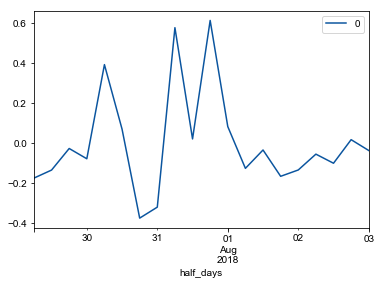

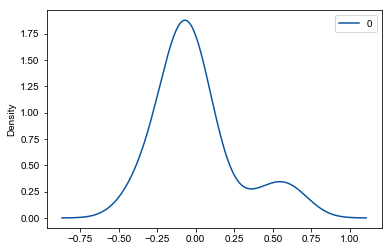

               0
count  20.000000
mean    0.000722
std     0.256414
min    -0.374412
25%    -0.134056
50%    -0.045772
75%     0.033324
max     0.612946


In [108]:
# Select params

arima_analysis(blues, (1,1,0))
arima_analysis(blues, (2,1,0))
arima_analysis(blues, (1,0,1))
arima_analysis(blues, (2,0,1))
arima_analysis(blues, (0,1,1))

In [109]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Blues')] = ((1,0,1), blues, 4.935, transform_value)

#### Jazz

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


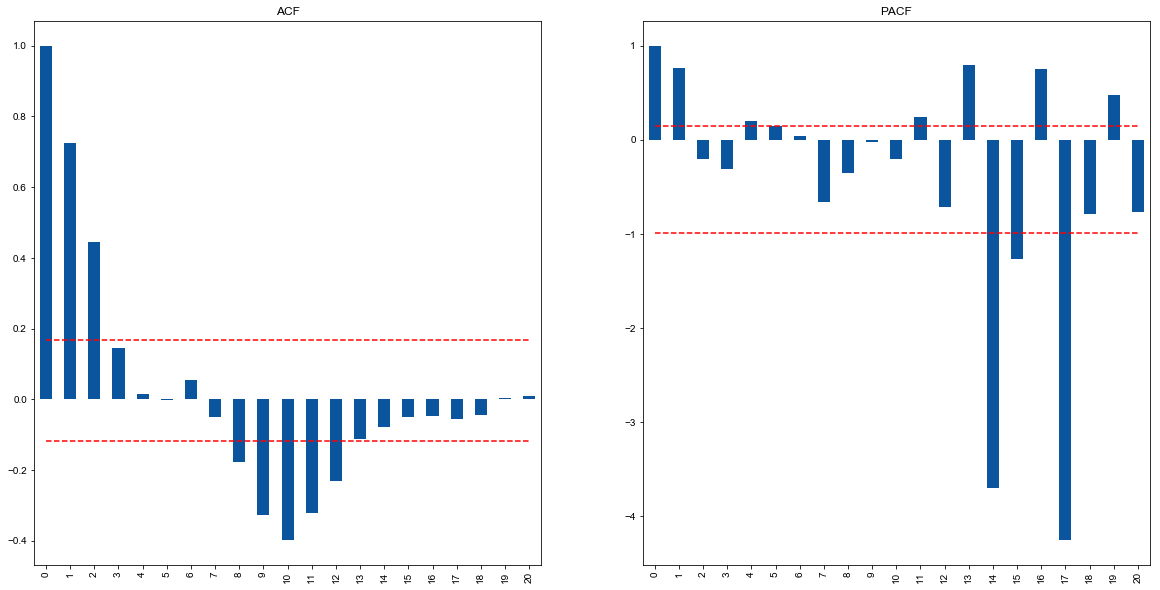

In [110]:
## Analyze Jazz

jazz = grouped_upsample('classificationGenre', 'Jazz')
jazz, transform_value = log_transform(jazz.unified_metric)
plot_acf(country, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


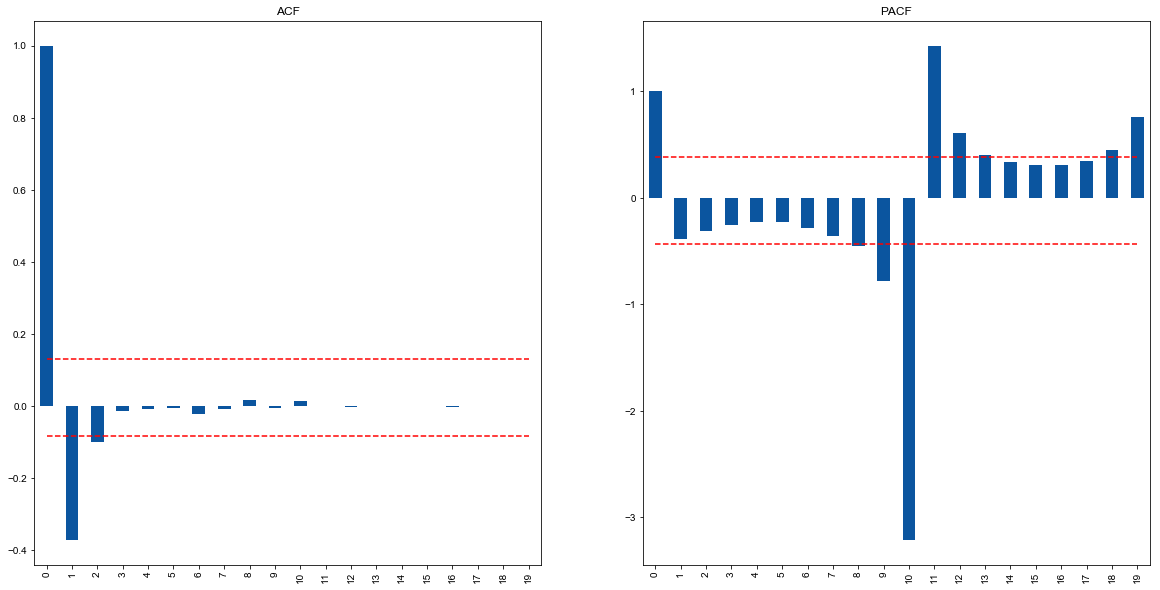

In [111]:
# Update differencing and replot residuals

lag1 = ARIMA(jazz,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -37.647
Method:                       css-mle   S.D. of innovations              1.473
Date:                Sat, 18 Aug 2018   AIC                             81.293
Time:                        22:15:25   BIC                             84.280
Sample:                    07-29-2018   HQIC                            81.876
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1112      0.053      2.095      0.051       0.007       0.215
ma.L1.D.y     -1.0000      0.180     -5.564      0.000      -1.352      -0.648
                                    Roots           

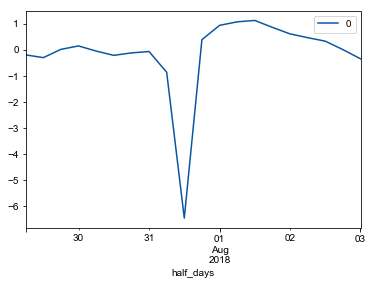

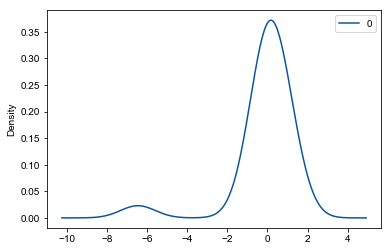

               0
count  20.000000
mean   -0.130513
std     1.578081
min    -6.455836
25%    -0.198493
50%     0.014167
75%     0.503529
max     1.127785
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -37.221
Method:                       css-mle   S.D. of innovations              1.453
Date:                Sat, 18 Aug 2018   AIC                             82.441
Time:                        22:15:25   BIC                             86.424
Sample:                    07-29-2018   HQIC                            83.219
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1091      0.062      1.770      0.095   

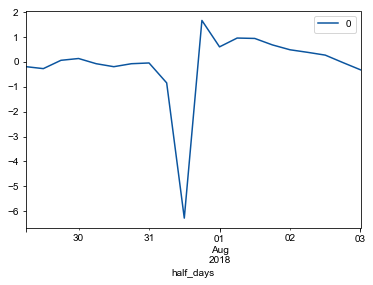

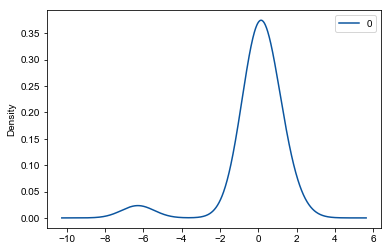

               0
count  20.000000
mean   -0.107199
std     1.556560
min    -6.278153
25%    -0.192586
50%     0.016776
75%     0.514525
max     1.663753
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -37.232
Method:                       css-mle   S.D. of innovations              1.457
Date:                Sat, 18 Aug 2018   AIC                             82.463
Time:                        22:15:26   BIC                             86.446
Sample:                    07-29-2018   HQIC                            83.241
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1083      0.064      1.699      0.108   

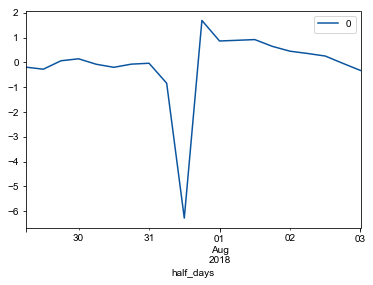

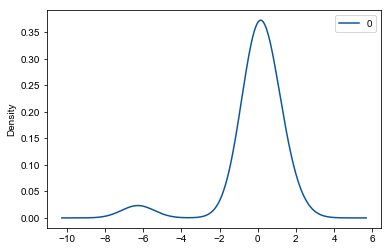

               0
count  20.000000
mean   -0.102365
std     1.559648
min    -6.275417
25%    -0.193041
50%     0.014758
75%     0.499031
max     1.689761
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -39.914
Method:                       css-mle   S.D. of innovations              1.774
Date:                Sat, 18 Aug 2018   AIC                             85.828
Time:                        22:15:26   BIC                             88.815
Sample:                    07-29-2018   HQIC                            86.411
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0750      0.297      0.253      0.803   

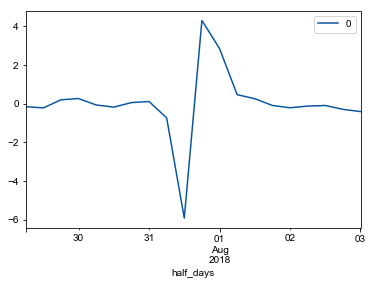

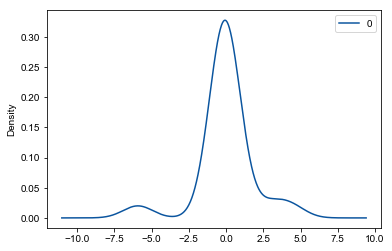

               0
count  20.000000
mean   -0.002794
std     1.820461
min    -5.916820
25%    -0.216585
50%    -0.096361
75%     0.209843
max     4.297445


In [112]:
# Select params

arima_analysis(jazz, (0,1,1))
arima_analysis(jazz, (0,1,2))
arima_analysis(jazz, (1,1,1))
arima_analysis(jazz, (1,1,0))

In [113]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Jazz')] = ((0,1,1), jazz, 80.858, transform_value)

#### Reggae

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


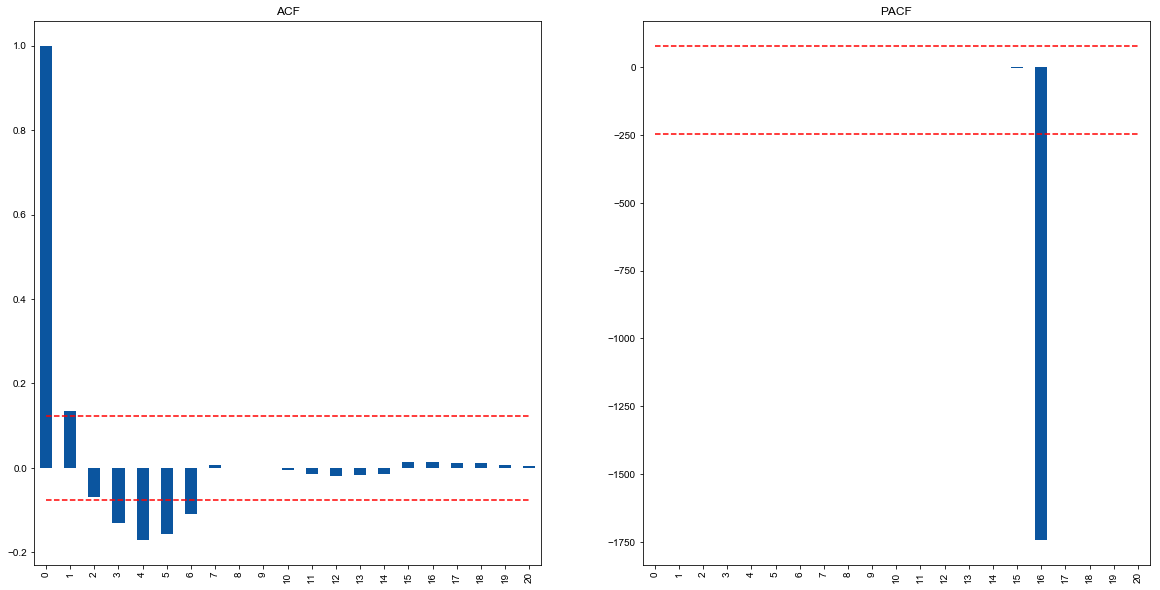

In [114]:
## Analyze Reggae

reggae = grouped_upsample('classificationGenre', 'Reggae')
reggae, transform_value = log_transform(reggae.unified_metric)
plot_acf(reggae, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -39.053
Method:                       css-mle   S.D. of innovations              1.553
Date:                Sat, 18 Aug 2018   AIC                             84.105
Time:                        22:15:27   BIC                             87.239
Sample:                    07-29-2018   HQIC                            84.785
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8960      0.386     17.863      0.000       6.139       7.653
ma.L1.y        0.1457      0.219      0.667      0.513      -0.283       0.574
                                    Roots           

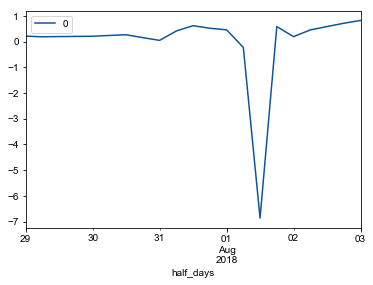

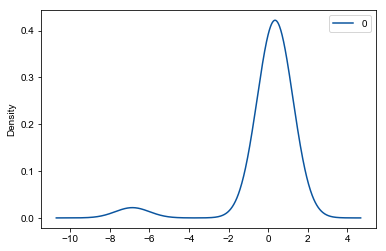

               0
count  21.000000
mean   -0.001088
std     1.591385
min    -6.862989
25%     0.192687
50%     0.238959
75%     0.518221
max     0.822440
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -39.044
Method:                       css-mle   S.D. of innovations              1.552
Date:                Sat, 18 Aug 2018   AIC                             86.088
Time:                        22:15:28   BIC                             90.266
Sample:                    07-29-2018   HQIC                            86.995
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8943      0.379     18.197      0.000   

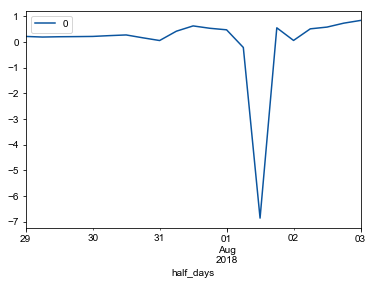

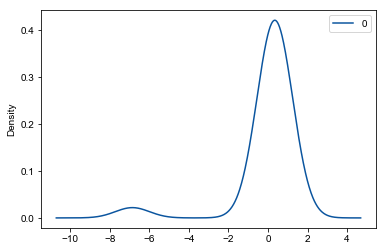

               0
count  21.000000
mean   -0.000806
std     1.590703
min    -6.855324
25%     0.189774
50%     0.244624
75%     0.530926
max     0.835543
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -39.027
Method:                       css-mle   S.D. of innovations              1.590
Date:                Sat, 18 Aug 2018   AIC                             86.055
Time:                        22:15:28   BIC                             90.037
Sample:                    07-29-2018   HQIC                            86.832
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0163      0.066     -0.246      0.809   

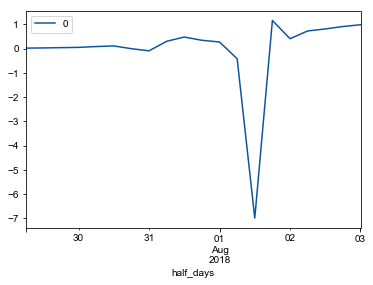

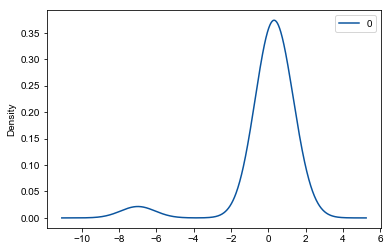

               0
count  20.000000
mean   -0.036892
std     1.685784
min    -6.984889
25%     0.027793
50%     0.193000
75%     0.541489
max     1.162545


In [115]:
# Select params

arima_analysis(reggae, (0,0,1))
arima_analysis(reggae, (1,0,1))
arima_analysis(reggae, (0,1,2))

In [116]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Reggae')] = ((1,0,1), reggae, -12.167, transform_value)

#### Classical

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


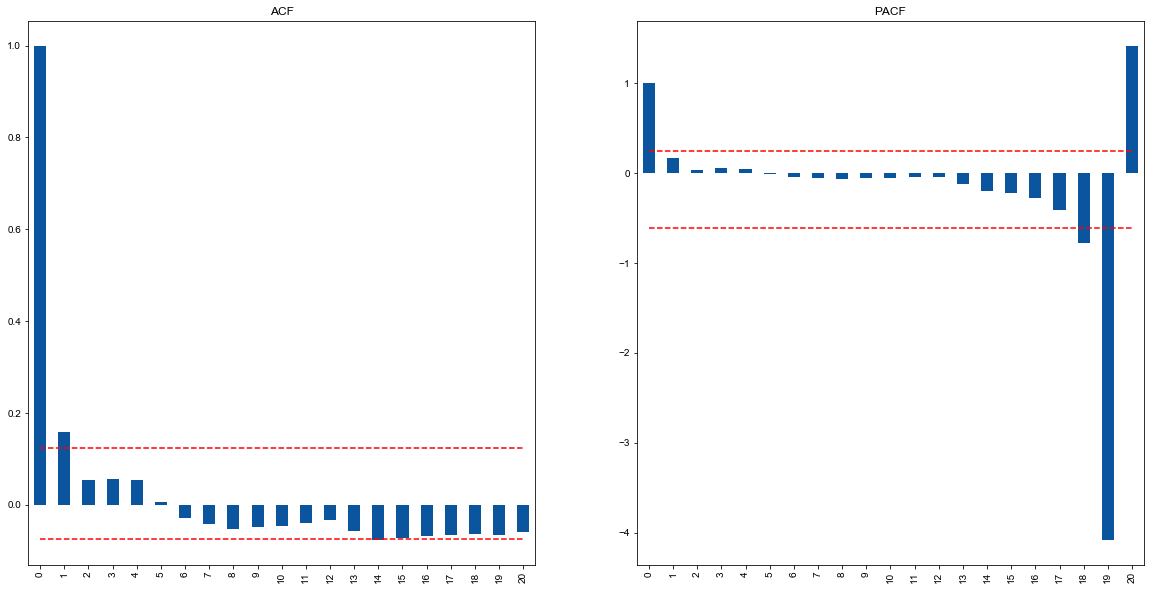

In [117]:
## Analyze Classical

classical = grouped_upsample('classificationGenre', 'Classical')
classical, transform_value = log_transform(classical.unified_metric)
plot_acf(classical, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


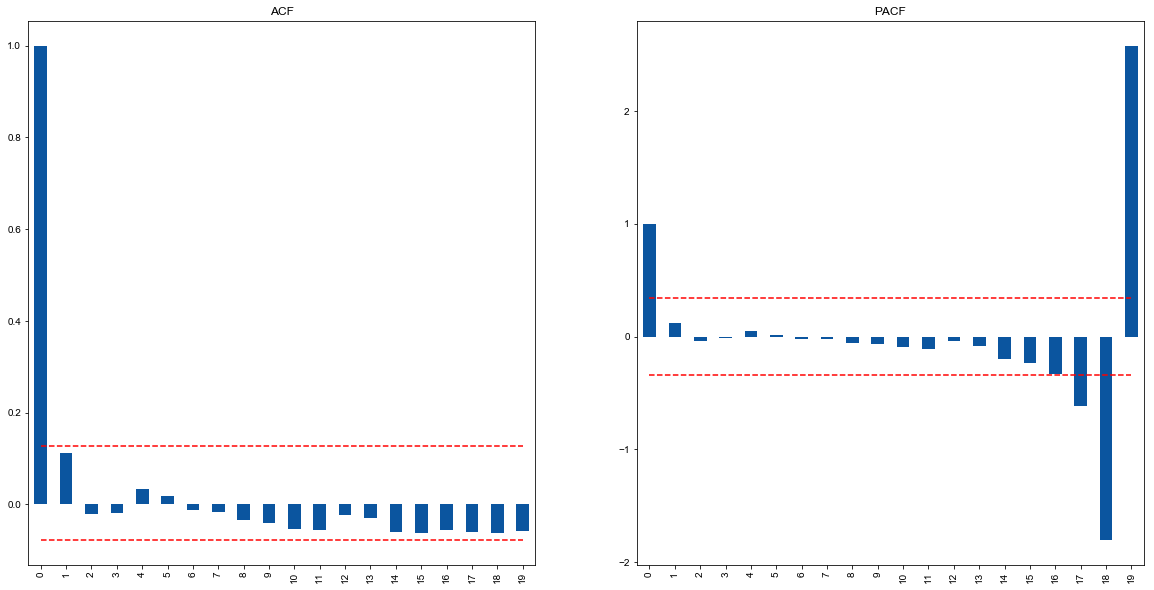

In [118]:
# Update differencing and replot residuals

lag1 = ARIMA(classical,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -36.153
Method:                       css-mle   S.D. of innovations              1.257
Date:                Sat, 18 Aug 2018   AIC                             78.307
Time:                        22:15:30   BIC                             81.440
Sample:                    07-29-2018   HQIC                            78.987
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1688      0.536     11.506      0.000       5.118       7.220
ma.L1.y        1.0000        nan        nan        nan         nan         nan
                                    Roots           

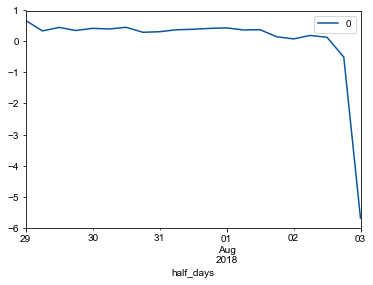

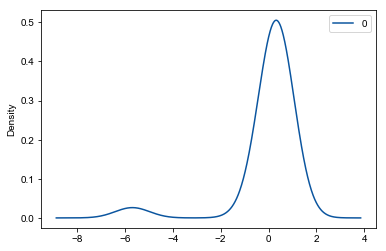

               0
count  21.000000
mean    0.016882
std     1.326361
min    -5.686786
25%     0.188978
50%     0.365373
75%     0.416345
max     0.671099
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -31.711
Method:                       css-mle   S.D. of innovations              1.154
Date:                Sat, 18 Aug 2018   AIC                             69.422
Time:                        22:15:30   BIC                             72.409
Sample:                    07-29-2018   HQIC                            70.005
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5242      0.453     -1.156      0.263   

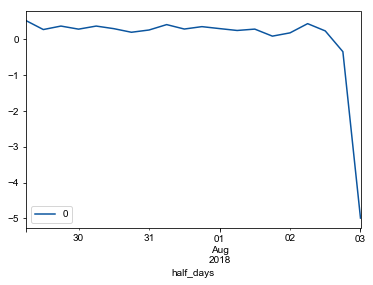

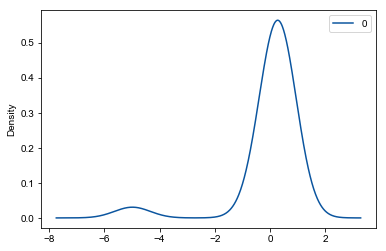

               0
count  20.000000
mean    0.000277
std     1.187141
min    -4.989516
25%     0.221971
50%     0.281265
75%     0.354530
max     0.523362
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -31.802
Method:                       css-mle   S.D. of innovations              1.162
Date:                Sat, 18 Aug 2018   AIC                             69.604
Time:                        22:15:31   BIC                             72.591
Sample:                    07-29-2018   HQIC                            70.187
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9494      1.183     -0.803      0.433   

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Albert/a

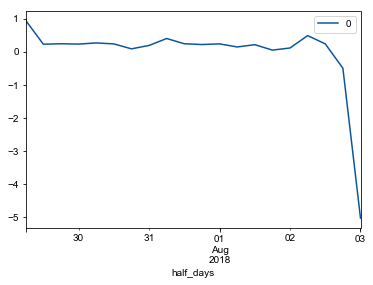

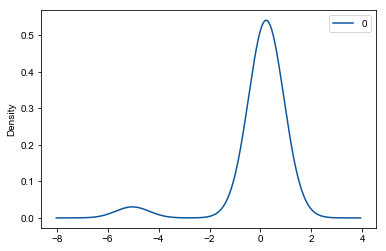

               0
count  20.000000
mean   -0.035931
std     1.202598
min    -5.030860
25%     0.138632
50%     0.231557
75%     0.243857
max     0.948556
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -35.643
Method:                       css-mle   S.D. of innovations              1.285
Date:                Sat, 18 Aug 2018   AIC                             77.285
Time:                        22:15:31   BIC                             80.419
Sample:                    07-29-2018   HQIC                            77.965
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4816      1.632      3.359      0.003   

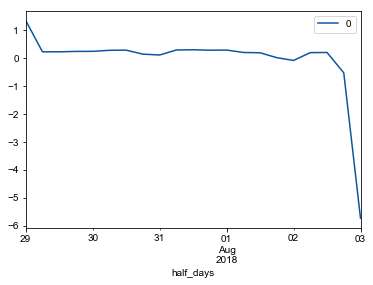

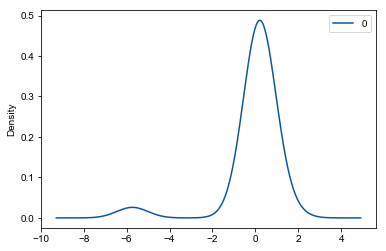

               0
count  21.000000
mean   -0.053522
std     1.339495
min    -5.732614
25%     0.149318
50%     0.233381
75%     0.290507
max     1.358338


In [119]:
# Select params

arima_analysis(classical, (0,0,1))
arima_analysis(classical, (0,1,1))
arima_analysis(classical, (1,1,0))
arima_analysis(classical, (1,0,0))

In [120]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Classical')] = ((1,1,0), classical, 66.049, transform_value)

#### New Age

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


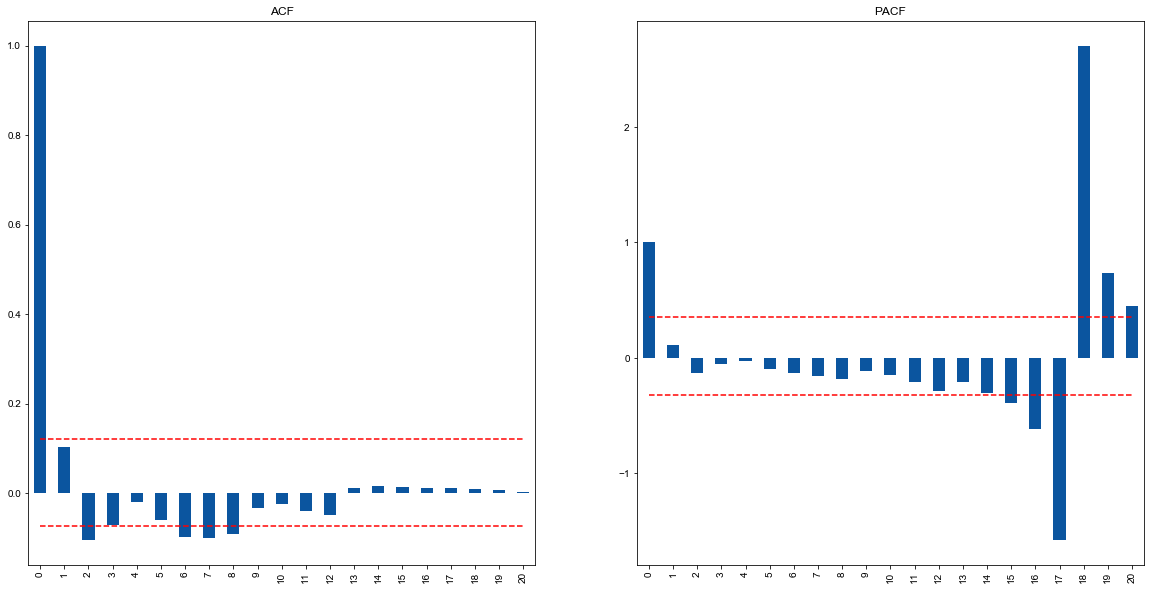

In [121]:
## Analyze New Age

new_age = grouped_upsample('classificationGenre', 'New Age')
new_age, transform_value = log_transform(new_age.unified_metric)
plot_acf(new_age, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -37.845
Method:                       css-mle   S.D. of innovations              1.466
Date:                Sat, 18 Aug 2018   AIC                             81.690
Time:                        22:15:33   BIC                             84.823
Sample:                    07-29-2018   HQIC                            82.370
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5202      0.357     18.244      0.000       5.820       7.221
ma.L1.y        0.1224      0.231      0.531      0.602      -0.330       0.574
                                    Roots           

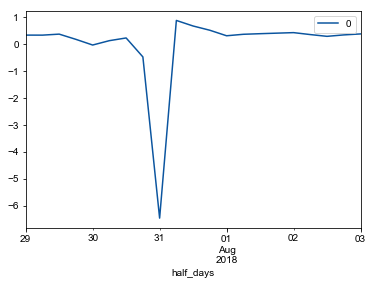

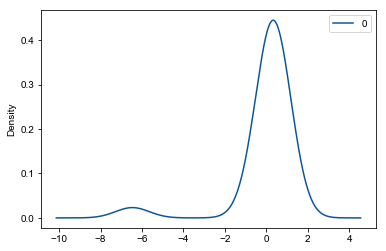

               0
count  21.000000
mean   -0.001513
std     1.502686
min    -6.462199
25%     0.230702
50%     0.343851
75%     0.389237
max     0.881340
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -37.837
Method:                       css-mle   S.D. of innovations              1.497
Date:                Sat, 18 Aug 2018   AIC                             83.673
Time:                        22:15:33   BIC                             87.656
Sample:                    07-29-2018   HQIC                            84.451
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0297      0.061      0.485      0.634   

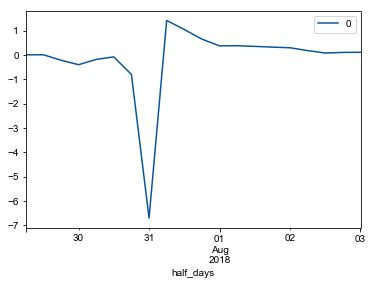

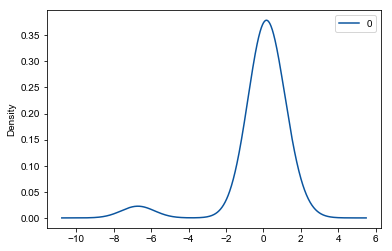

               0
count  20.000000
mean   -0.149077
std     1.617117
min    -6.708833
25%    -0.101058
50%     0.111455
75%     0.361877
max     1.423989
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -37.872
Method:                       css-mle   S.D. of innovations              1.468
Date:                Sat, 18 Aug 2018   AIC                             81.743
Time:                        22:15:33   BIC                             84.877
Sample:                    07-29-2018   HQIC                            82.423
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5202      0.354     18.414      0.000   

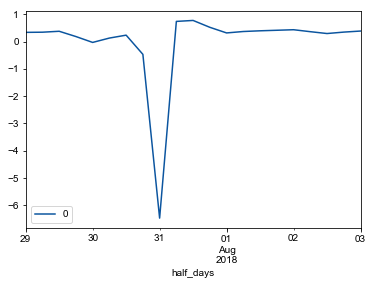

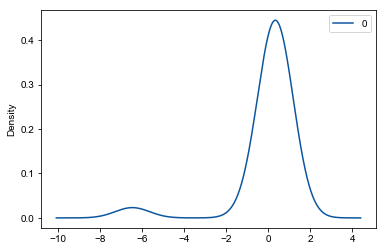

               0
count  21.000000
mean   -0.001593
std     1.504767
min    -6.475943
25%     0.234052
50%     0.346161
75%     0.393844
max     0.773721
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -38.021
Method:                       css-mle   S.D. of innovations              1.501
Date:                Sat, 18 Aug 2018   AIC                             82.041
Time:                        22:15:34   BIC                             85.028
Sample:                    07-29-2018   HQIC                            82.624
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0308      0.054      0.570      0.576   

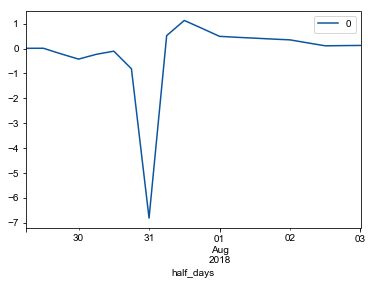

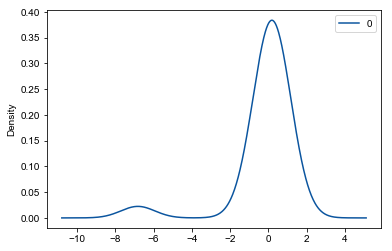

               0
count  20.000000
mean   -0.173007
std     1.622483
min    -6.817479
25%    -0.132579
50%     0.120983
75%     0.425678
max     1.129321
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -37.764
Method:                       css-mle   S.D. of innovations              1.485
Date:                Sat, 18 Aug 2018   AIC                             85.527
Time:                        22:15:34   BIC                             90.506
Sample:                    07-29-2018   HQIC                            86.499
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.057      0.547      0.592   

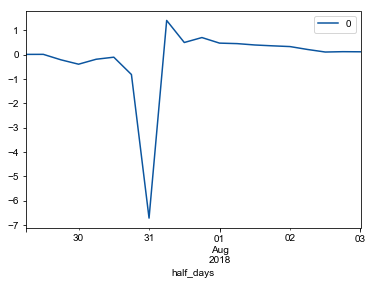

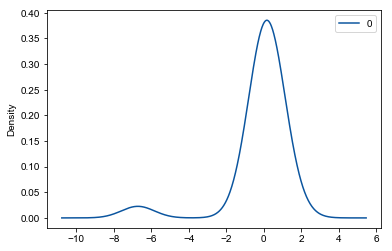

               0
count  20.000000
mean   -0.163318
std     1.606813
min    -6.713215
25%    -0.127770
50%     0.117218
75%     0.408730
max     1.401982
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -37.806
Method:                       css-mle   S.D. of innovations              1.494
Date:                Sat, 18 Aug 2018   AIC                             83.613
Time:                        22:15:35   BIC                             87.596
Sample:                    07-29-2018   HQIC                            84.391
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0298      0.061      0.489      0.631   

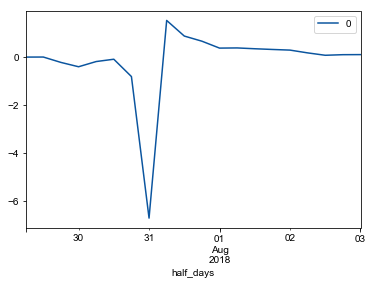

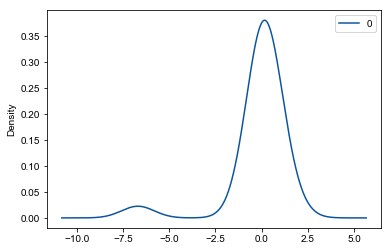

               0
count  20.000000
mean   -0.149428
std     1.614796
min    -6.695283
25%    -0.103484
50%     0.111475
75%     0.363787
max     1.535678


In [122]:
# Select params

arima_analysis(new_age, (0,0,1))
arima_analysis(new_age, (1,1,1))
arima_analysis(new_age, (1,0,0))
arima_analysis(new_age, (0,1,1))
arima_analysis(new_age, (2,1,1))
arima_analysis(new_age, (0,1,2))

In [123]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','New Age')] = ((0,1,1), new_age, 82.068, transform_value)

#### Ballads/Romantic

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


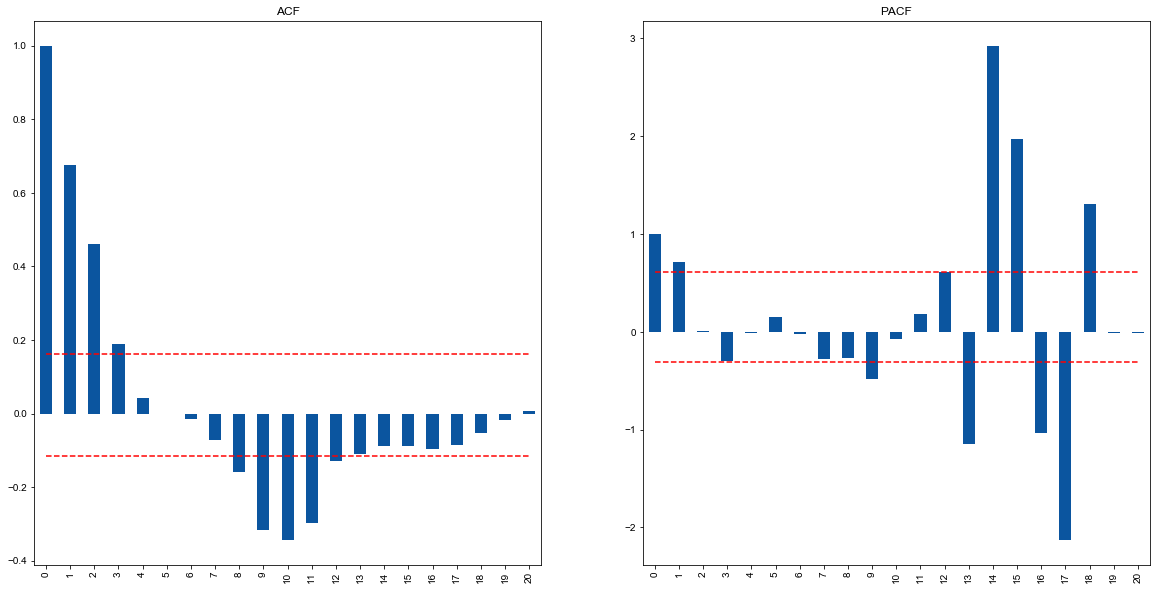

In [124]:
## Analyze Romantic

romantic = grouped_upsample('classificationGenre', 'Ballads/Romantic')
romantic, transform_value = log_transform(romantic.unified_metric)
plot_acf(romantic, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


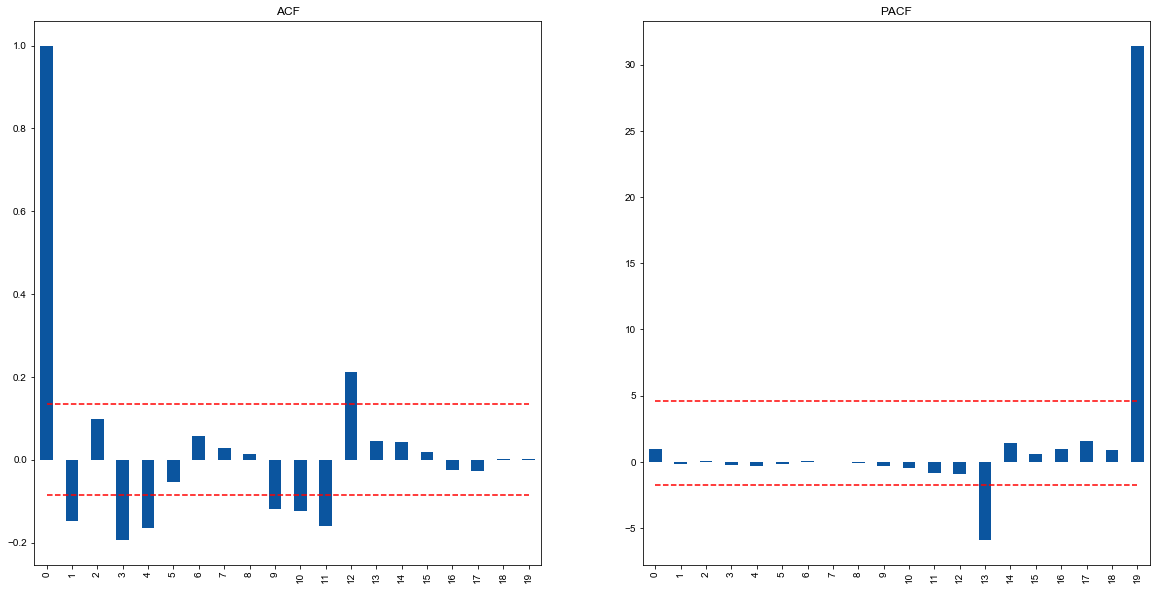

In [125]:
# Update differencing and replot residuals

lag1 = ARIMA(romantic,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -37.272
Method:                       css-mle   S.D. of innovations              1.559
Date:                Sat, 18 Aug 2018   AIC                             80.543
Time:                        22:15:36   BIC                             83.531
Sample:                    07-29-2018   HQIC                            81.127
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0442      0.303      0.146      0.886      -0.550       0.639
ar.L1.D.y     -0.1604      0.229     -0.699      0.493      -0.610       0.289
                                    Roots           

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


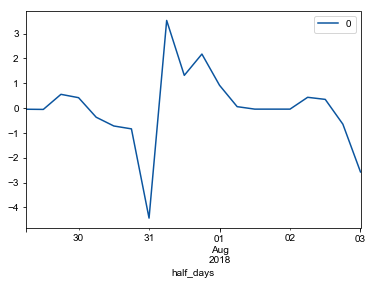

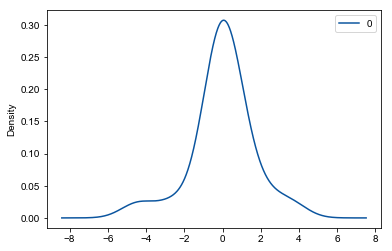

               0
count  20.000000
mean   -0.000355
std     1.599421
min    -4.429078
25%    -0.436307
50%    -0.040044
75%     0.466137
max     3.531680
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -37.181
Method:                       css-mle   S.D. of innovations              1.551
Date:                Sat, 18 Aug 2018   AIC                             82.362
Time:                        22:15:37   BIC                             86.345
Sample:                    07-29-2018   HQIC                            83.140
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0361      0.317      0.114      0.911   

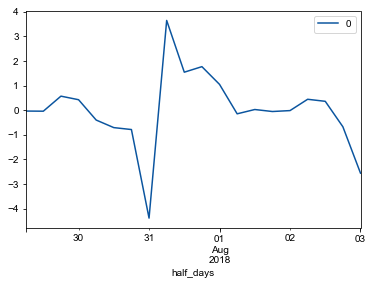

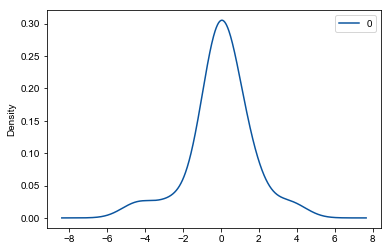

               0
count  20.000000
mean    0.000420
std     1.591562
min    -4.379443
25%    -0.469195
50%    -0.026710
75%     0.473389
max     3.639803
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -37.447
Method:                       css-mle   S.D. of innovations              1.420
Date:                Sat, 18 Aug 2018   AIC                             82.894
Time:                        22:15:37   BIC                             87.072
Sample:                    07-29-2018   HQIC                            83.801
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8887      0.837      7.038      0.000   

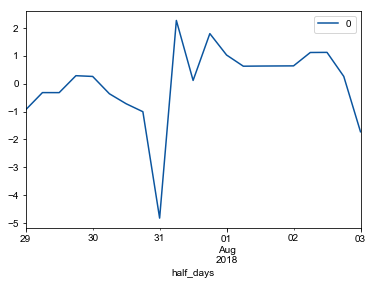

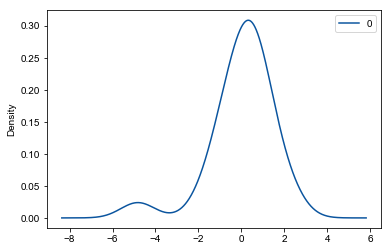

               0
count  21.000000
mean    0.029060
std     1.461303
min    -4.819450
25%    -0.360102
50%     0.262649
75%     0.640006
max     2.269091
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -37.294
Method:                       css-mle   S.D. of innovations              1.561
Date:                Sat, 18 Aug 2018   AIC                             80.589
Time:                        22:15:38   BIC                             83.576
Sample:                    07-29-2018   HQIC                            81.172
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0467      0.300      0.156      0.878   

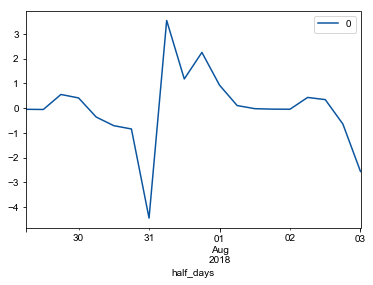

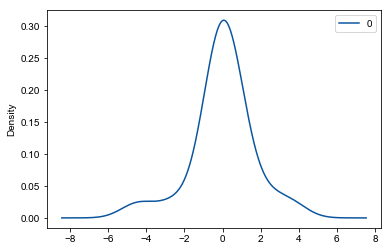

               0
count  20.000000
mean   -0.000350
std     1.601335
min    -4.442717
25%    -0.429571
50%    -0.030664
75%     0.462554
max     3.543217


In [126]:
# Select params

arima_analysis(romantic, (1,1,0))
arima_analysis(romantic, (1,1,1))
arima_analysis(romantic, (1,0,1))
arima_analysis(romantic, (0,1,1))

In [127]:
# Update DF with new values

ARIMA_models.loc[('classificationGenre','Ballads/Romantic')] = ((1,1,1), romantic, 77.658, transform_value)

In [128]:
ARIMA_models

model_params  \
feature                category                          
classificationGenre    Dance/Electronic      (0, 1, 1)   
                       Rock                  (1, 1, 0)   
                       R&B                   (0, 0, 1)   
                       Hip-Hop/Rap           (0, 0, 1)   
                       Religious             (2, 0, 0)   
                       Country               (1, 1, 1)   
                       Undefined             (1, 1, 1)   
                       Pop                   (0, 1, 1)   
                       Folk                  (0, 0, 1)   
                       World                 (0, 1, 1)   
                       Metal                 (1, 0, 1)   
                       Other                 (1, 1, 1)   
                       Blues                 (1, 0, 1)   
                       Jazz                  (0, 1, 1)   
                       Reggae                (1, 0, 1)   
                       Classical             (1, 1, 0)   
                       New Age               (0, 1, 1)   
                       Ballads/Romantic      (1, 1, 1)   
classificationSubGenre Club Dance                  NaN   
                       Pop                         NaN   
                       Alternative Rock            NaN   
                       Soul                        NaN   
                       Urban                       NaN   
                       Reggaeton                   NaN   
                       Gospel                      NaN   
                       Country                     NaN   
                       Undefined                   NaN   
                       Folk                        NaN   
                       World                       NaN   
                       R&B                         NaN   
                       Heavy Metal                 NaN   
                       Other                       NaN   
                       Latin                       NaN   
                       Oldies & Classics           NaN   
                       Blues                       NaN   
                       Jazz                        NaN   
                       Reggae                      NaN   
                       Punk                        NaN   
                       Adult Contemporary          NaN   
                       Classical/Vocal             NaN   
                       Funk                        NaN   
                       New Age                     NaN   
                       Flamenco                    NaN   
                       Ballads/Romantic            NaN   
presales               1                           NaN   
                       0                           NaN   
citySize               small                       NaN   
                       large                       NaN   
                       medium                      NaN   
                       very large                  NaN   
upcomingEvents         some                        NaN   
                       few                         NaN   
                       very many                   NaN   
                       many                        NaN   

                                                                                 model_train  \
feature                category                                                                
classificationGenre    Dance/Electronic    half_days
2018-07-29 00:00:00    4.354764
2018...   
                       Rock                half_days
2018-07-29 00:00:00    5.500537
2018...   
                       R&B                 half_days
2018-07-29 00:00:00    6.774101
2018...   
                       Hip-Hop/Rap         half_days
2018-07-29 00:00:00    5.228847
2018...   
                       Religious           half_days
2018-07-29 00:00:00    7.143225
2018...   
                       Country             half_days
2018-07-29 00:00:00    4.967565
2018...   
                       Un

## 2. SubGenre

First feature down - now on to SubGenres.

Here we will continue to build our models category by category as we have been doing *except* in situations where this is a significant overlap between the observations in a Genre and SubGenre, in which case we will simply copy our ARIMA parameters over from the Genre.

Let's write a quick function for this.

In [129]:
def copy_identical_categories (genre, subgenre):
    # Set category dummies
    genre_dummy = np.where(df_analysis.classificationGenre == genre, 1, 0)
    subgenre_dummy = np.where(df_analysis.classificationSubGenre == subgenre, 1, 0)
    shared_dummy = np.where(genre_dummy == subgenre_dummy, 1, 0)
    # Calculate counts
    crosstab = pd.crosstab(shared_dummy, columns='count')
    shared = crosstab.loc[1, 'count']
    total = crosstab['count'].sum()
    # If over 90% of observations share identical values, copy over ARIMA parameters
    if (shared/total) > 0.9:
        ARIMA_models.loc[('classificationSubGenre',subgenre)] = ARIMA_models.loc[('classificationGenre',genre)]
        print ('Copy Complete - {}% of Identical Values'.format((shared/total)*100))
    else:
        print ('Manual Labor Required')

#### Club Dance

In [130]:
# Check for overlap

copy_identical_categories ('Dance/Electronic', 'Club Dance')

Copy Complete - 100.0% of Identical Values


#### Pop

In [131]:
# Check for overlap

copy_identical_categories ('Pop', 'Pop')

Manual Labor Required


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


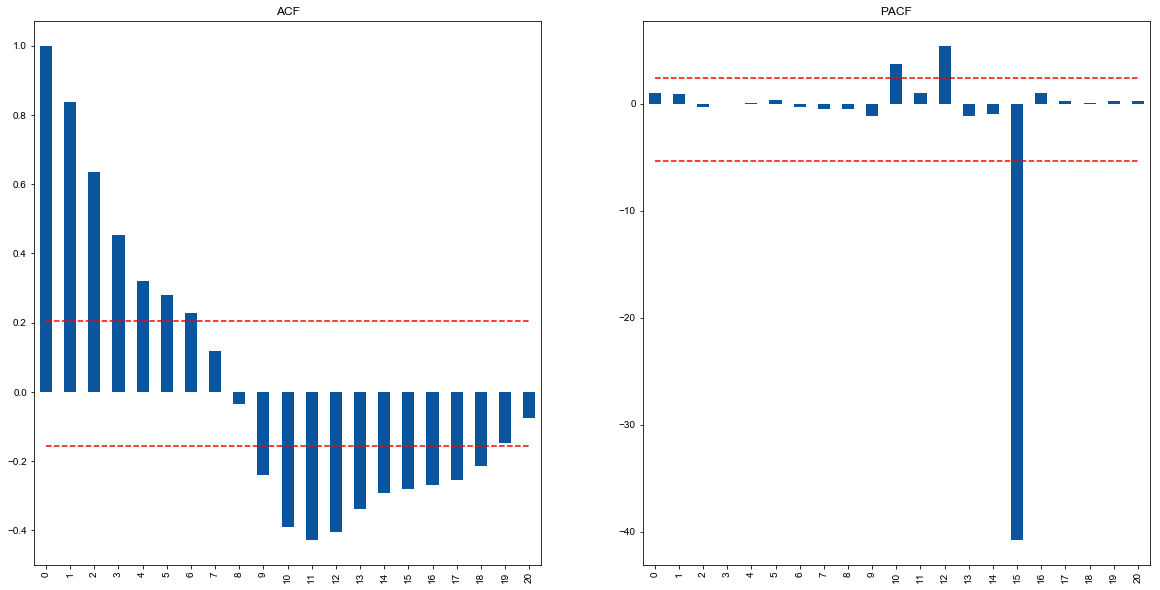

In [132]:
## Analyze Pop

pop = grouped_upsample('classificationSubGenre', 'Pop')
pop, transform_value = log_transform(pop.unified_metric)
plot_acf(pop, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


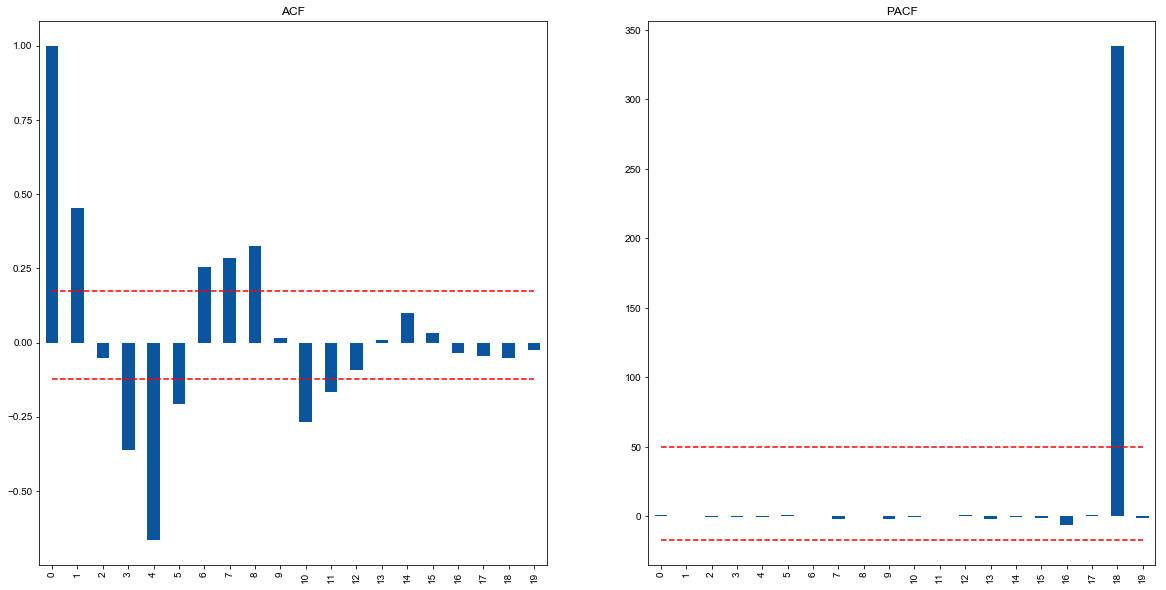

In [133]:
# Update differencing and replot residuals

lag1 = ARIMA(pop,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  20.816
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sat, 18 Aug 2018   AIC                            -33.632
Time:                        22:15:40   BIC                            -29.649
Sample:                    07-29-2018   HQIC                           -32.855
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0407      0.029      1.386      0.184      -0.017       0.098
ar.L1.D.unified_metric    -0.0747      0.314     -0.238      0.815      -0.690       0.540
ma.L

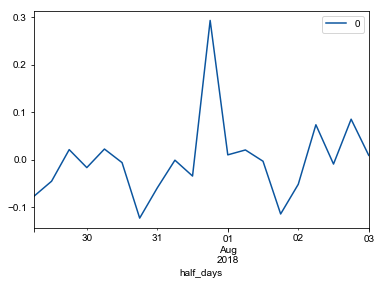

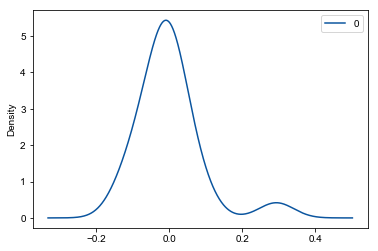

               0
count  20.000000
mean   -0.000181
std     0.087025
min    -0.122772
25%    -0.046791
50%    -0.004582
75%     0.020758
max     0.293027
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  22.461
Method:                       css-mle   S.D. of innovations              0.073
Date:                Sat, 18 Aug 2018   AIC                            -34.921
Time:                        22:15:40   BIC                            -29.943
Sample:                    07-29-2018   HQIC                           -33.950
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0442

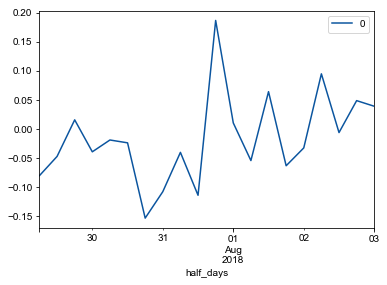

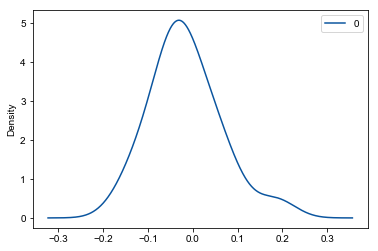

               0
count  20.000000
mean   -0.016067
std     0.078087
min    -0.153214
25%    -0.056517
50%    -0.028173
75%     0.021533
max     0.186561
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  20.741
Method:                       css-mle   S.D. of innovations              0.085
Date:                Sat, 18 Aug 2018   AIC                            -33.482
Time:                        22:15:41   BIC                            -29.499
Sample:                    07-29-2018   HQIC                           -32.705
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0410

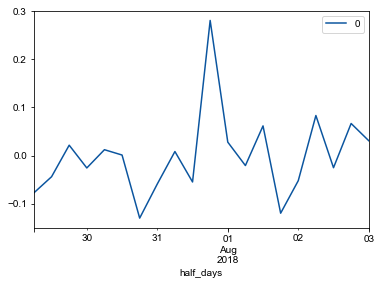

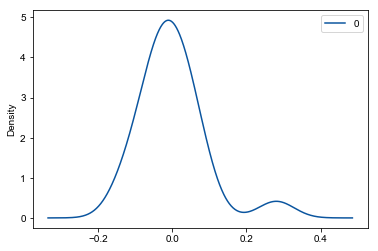

               0
count  20.000000
mean   -0.000605
std     0.087638
min    -0.129596
25%    -0.052620
50%    -0.009685
75%     0.028720
max     0.280334


In [134]:
# Select params

arima_analysis(pop, (1,1,1))
arima_analysis(pop, (2,1,1))
arima_analysis(pop, (2,1,0))

In [135]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Pop')] = ((2,1,1), pop, -40.823, transform_value)

#### Alternative Rock

In [136]:
# Check for overlap

copy_identical_categories ('Rock', 'Alternative Rock')

Manual Labor Required


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


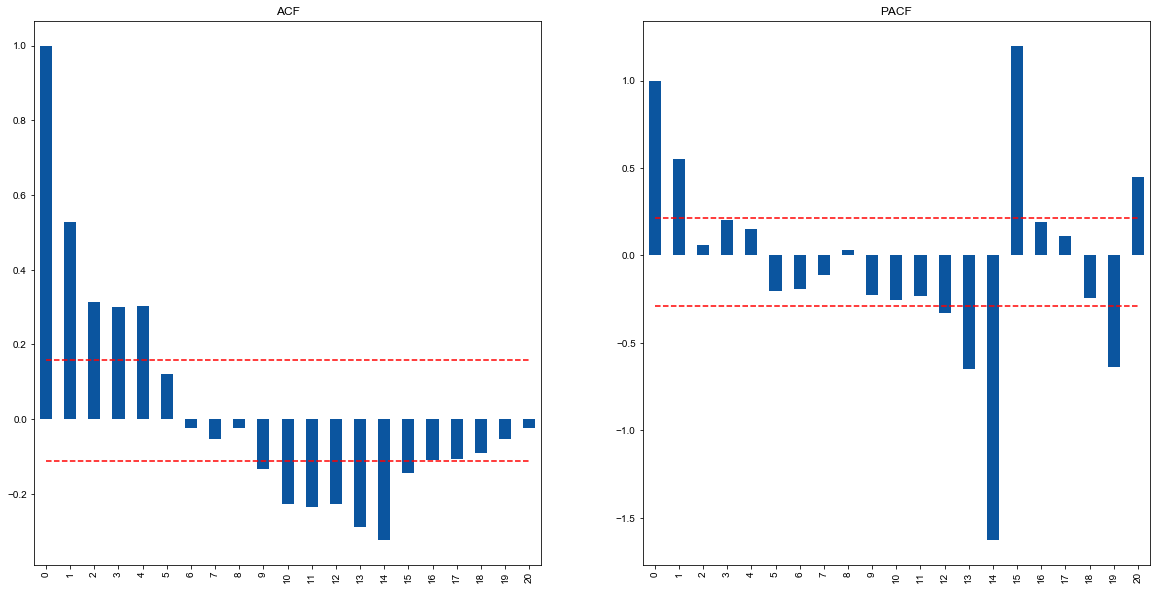

In [137]:
## Analyze Alt Rock

alt_rock = grouped_upsample('classificationSubGenre', 'Alternative Rock')
alt_rock, transform_value = log_transform(alt_rock.unified_metric)
plot_acf(alt_rock, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


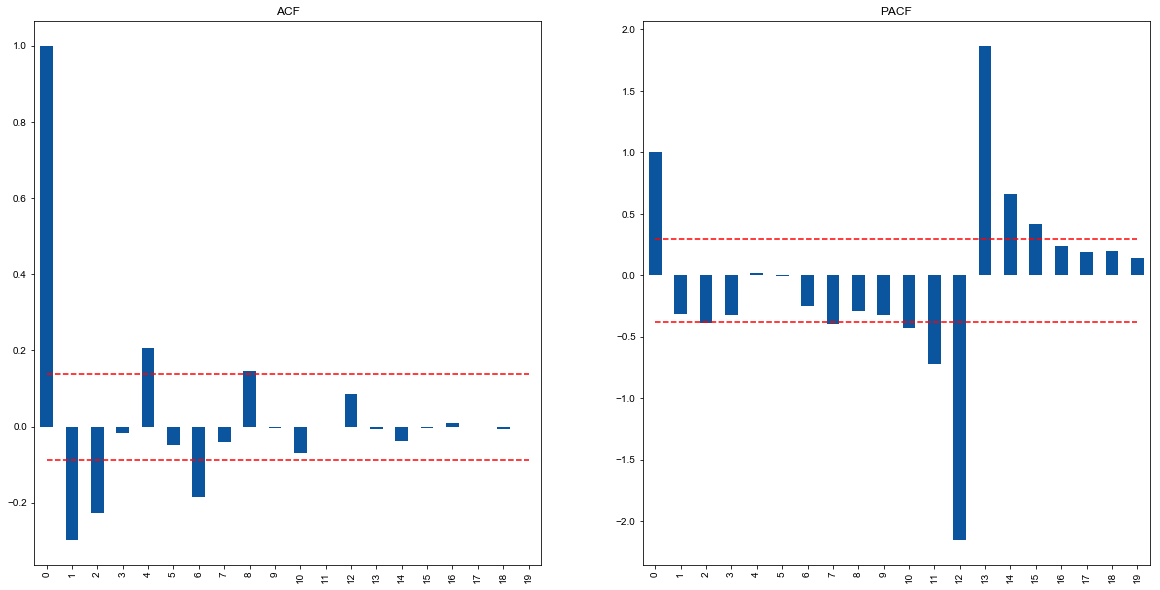

In [138]:
# Update differencing and replot residuals

lag1 = ARIMA(alt_rock,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -30.432
Method:                       css-mle   S.D. of innovations              1.039
Date:                Sat, 18 Aug 2018   AIC                             68.865
Time:                        22:15:43   BIC                             72.847
Sample:                    07-29-2018   HQIC                            69.642
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1512      0.048      3.168      0.006       0.058       0.245
ar.L1.D.y      0.2477      0.228      1.084      0.293      -0.200       0.696
ma.L1.D.y     -1.0000      0.144     -6.949      0.0

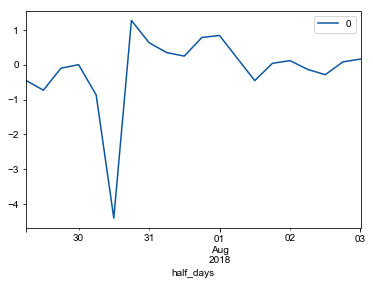

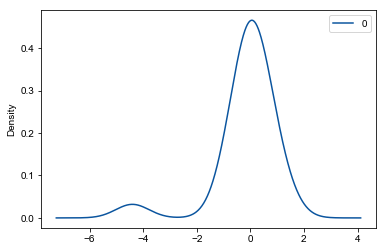

               0
count  20.000000
mean   -0.133003
std     1.135172
min    -4.405739
25%    -0.323940
50%     0.063544
75%     0.275415
max     1.275235
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -31.021
Method:                       css-mle   S.D. of innovations              1.058
Date:                Sat, 18 Aug 2018   AIC                             68.042
Time:                        22:15:43   BIC                             71.029
Sample:                    07-29-2018   HQIC                            68.625
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1551      0.038      4.069      0.001   

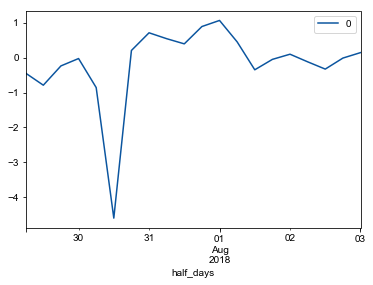

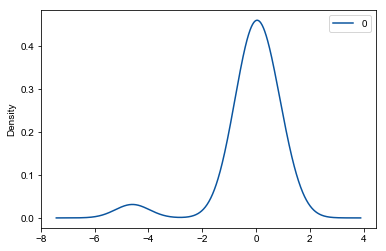

               0
count  20.000000
mean   -0.166803
std     1.159912
min    -4.594723
25%    -0.334612
50%    -0.020929
75%     0.406763
max     1.062868
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -30.306
Method:                       css-mle   S.D. of innovations              1.031
Date:                Sat, 18 Aug 2018   AIC                             68.612
Time:                        22:15:43   BIC                             72.595
Sample:                    07-29-2018   HQIC                            69.389
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1523      0.046      3.296      0.004   

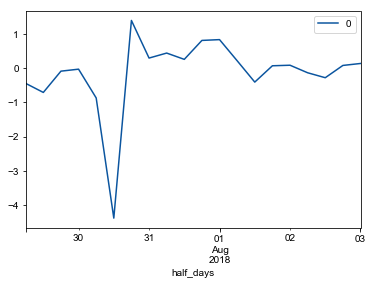

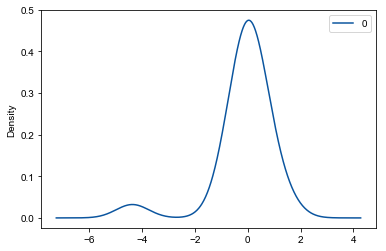

               0
count  20.000000
mean   -0.135568
std     1.127905
min    -4.371081
25%    -0.310167
50%     0.074819
75%     0.266367
max     1.391292


In [139]:
# Select params

arima_analysis(alt_rock, (1,1,1))
arima_analysis(alt_rock, (0,1,1))
arima_analysis(alt_rock, (0,1,2))

In [140]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Alternative Rock')] = ((0,1,1), alt_rock, 67.886, transform_value)

#### Soul

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


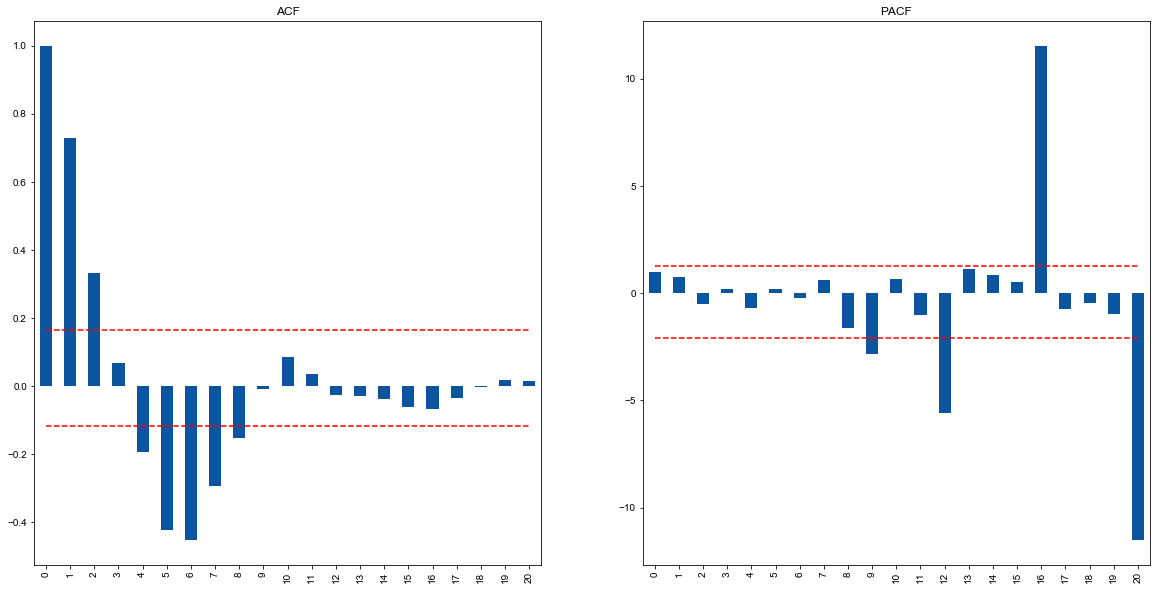

In [141]:
## Analyze Soul

soul = grouped_upsample('classificationSubGenre', 'Soul')
soul, transform_value = log_transform(soul.unified_metric)
plot_acf(soul, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


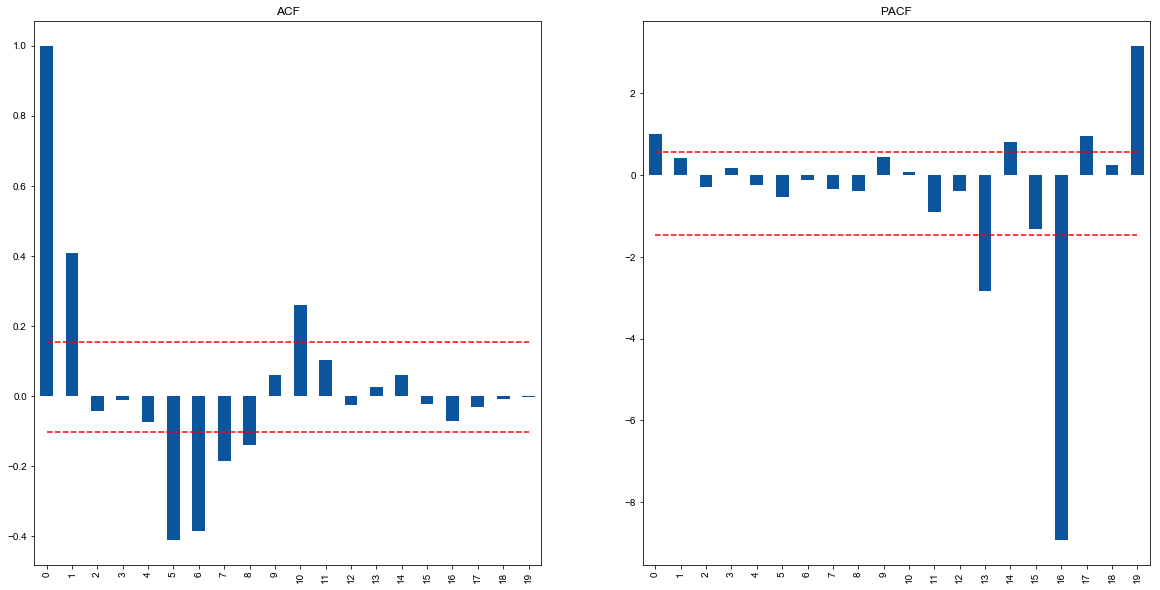

In [142]:
# Update differencing and replot residuals

lag1 = ARIMA(soul,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                  -0.167
Method:                       css-mle   S.D. of innovations              0.239
Date:                Sat, 18 Aug 2018   AIC                              6.333
Time:                        22:15:45   BIC                              9.467
Sample:                    07-29-2018   HQIC                             7.013
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.2271      0.188     33.047      0.000       5.858       6.596
ar.L1.unified_metric     0.7519      0.136      5.534      0.000       0.486       1.018
            

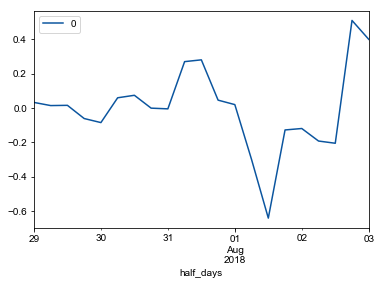

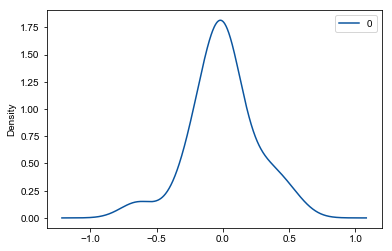

               0
count  21.000000
mean   -0.001149
std     0.245069
min    -0.640188
25%    -0.119482
50%     0.013755
75%     0.059046
max     0.508440
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                   3.107
Method:                       css-mle   S.D. of innovations              0.201
Date:                Sat, 18 Aug 2018   AIC                              1.786
Time:                        22:15:46   BIC                              5.964
Sample:                    07-29-2018   HQIC                             2.693
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.2050      

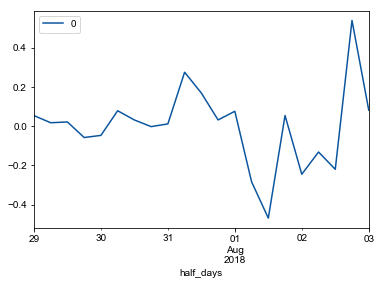

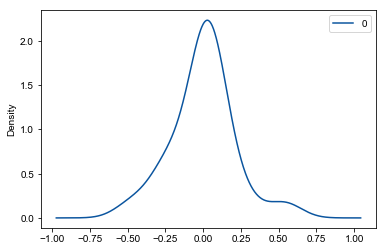

               0
count  21.000000
mean   -0.000473
std     0.206672
min    -0.468778
25%    -0.057681
50%     0.021719
75%     0.076104
max     0.539506
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                   3.897
Method:                       css-mle   S.D. of innovations              0.193
Date:                Sat, 18 Aug 2018   AIC                              0.206
Time:                        22:15:46   BIC                              4.384
Sample:                    07-29-2018   HQIC                             1.113
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.2006      

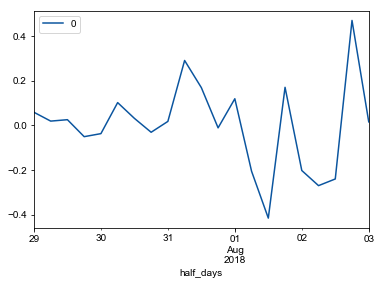

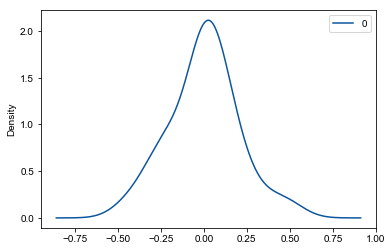

               0
count  21.000000
mean    0.001217
std     0.198010
min    -0.415318
25%    -0.050643
50%     0.017661
75%     0.101888
max     0.469750
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                   1.266
Method:                       css-mle   S.D. of innovations              0.225
Date:                Sat, 18 Aug 2018   AIC                              5.467
Time:                        22:15:46   BIC                              9.450
Sample:                    07-29-2018   HQIC                             6.245
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0133

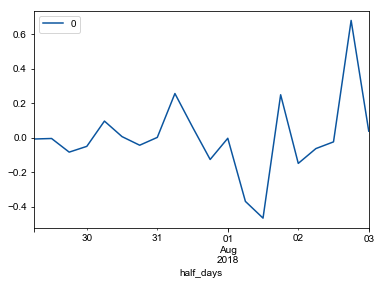

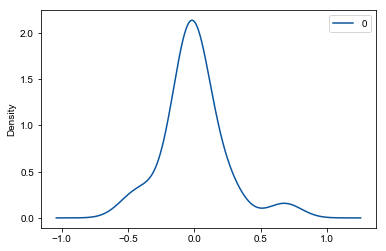

               0
count  20.000000
mean   -0.000038
std     0.231250
min    -0.467046
25%    -0.068290
50%    -0.006053
75%     0.044089
max     0.681176
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                   1.384
Method:                       css-mle   S.D. of innovations              0.224
Date:                Sat, 18 Aug 2018   AIC                              7.232
Time:                        22:15:47   BIC                             12.211
Sample:                    07-29-2018   HQIC                             8.204
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0138

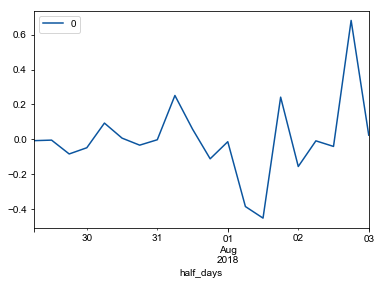

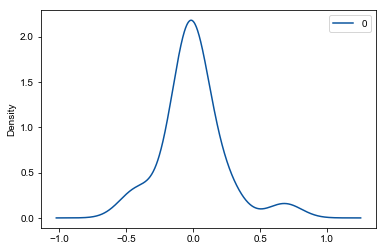

               0
count  20.000000
mean    0.000162
std     0.229688
min    -0.452417
25%    -0.057533
50%    -0.008493
75%     0.032269
max     0.681867
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   1.290
Method:                       css-mle   S.D. of innovations              0.225
Date:                Sat, 18 Aug 2018   AIC                              3.420
Time:                        22:15:47   BIC                              6.407
Sample:                    07-29-2018   HQIC                             4.003
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0185

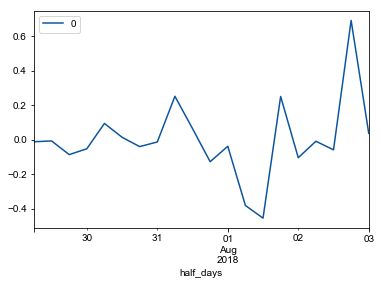

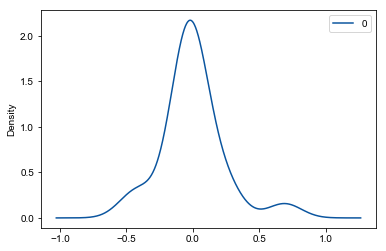

               0
count  20.000000
mean    0.000173
std     0.231086
min    -0.455189
25%    -0.066480
50%    -0.013307
75%     0.042880
max     0.690461


In [143]:
# Select params

arima_analysis(soul, (1,0,0))
arima_analysis(soul, (1,0,1))
arima_analysis(soul, (2,0,0))
arima_analysis(soul, (2,1,0))
arima_analysis(soul, (2,1,1))
arima_analysis(soul, (0,1,1))

In [144]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Soul')] = ((1,0,1), soul, 12.768, transform_value)

#### Urban

In [145]:
# Check for overlap

copy_identical_categories ('Hip-Hop/Rap', 'Urban')

Copy Complete - 99.68955481297833% of Identical Values


#### Reggaeton

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


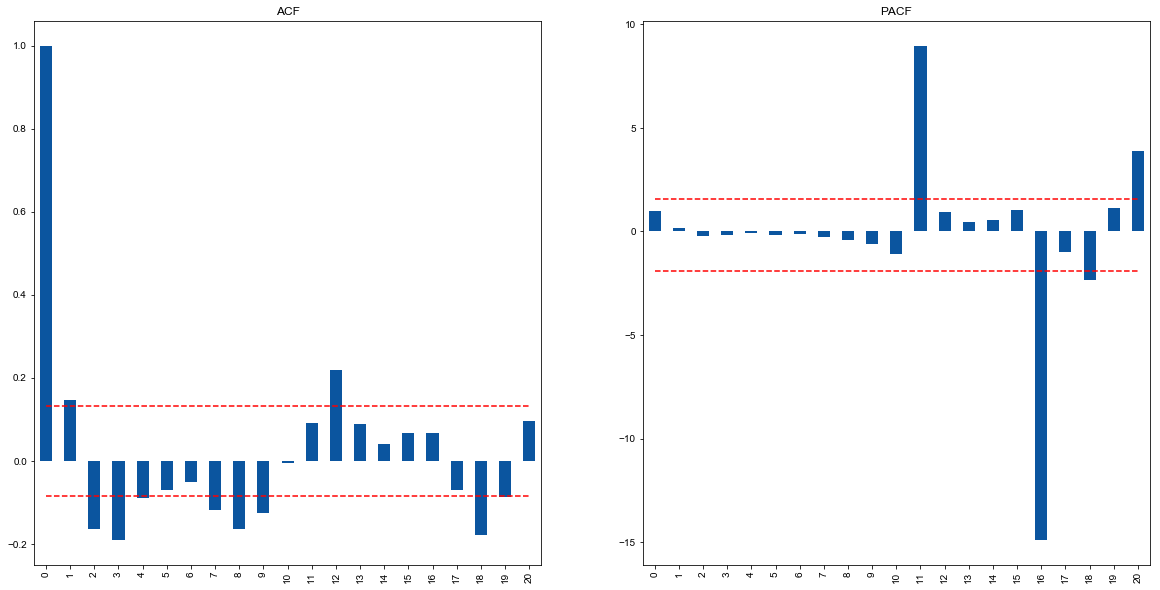

In [146]:
## Analyze Reggaeton

reggaeton = grouped_upsample('classificationSubGenre', 'Reggaeton')
reggaeton, transform_value = log_transform(reggaeton.unified_metric)
plot_acf(reggaeton, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -26.864
Method:                       css-mle   S.D. of innovations              0.857
Date:                Sat, 18 Aug 2018   AIC                             59.728
Time:                        22:15:48   BIC                             62.862
Sample:                    07-29-2018   HQIC                            60.408
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2180      0.310     10.380      0.000       2.610       3.826
ma.L1.y        0.6764      0.206      3.288      0.004       0.273       1.080
                                    Roots           

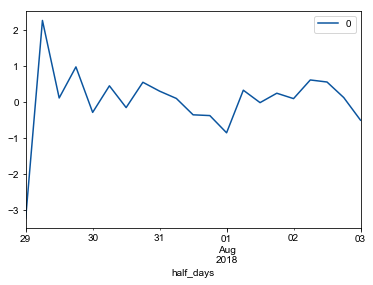

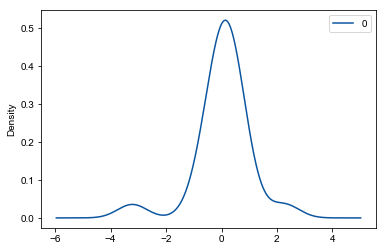

               0
count  21.000000
mean    0.051273
std     0.982237
min    -3.218004
25%    -0.281167
50%     0.118984
75%     0.456637
max     2.272549
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -26.511
Method:                       css-mle   S.D. of innovations              0.901
Date:                Sat, 18 Aug 2018   AIC                             59.022
Time:                        22:15:49   BIC                             62.009
Sample:                    07-29-2018   HQIC                            59.605
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2209      0.317      0.696      0.495   

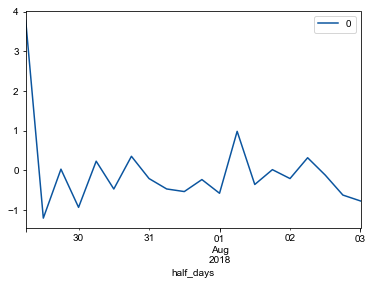

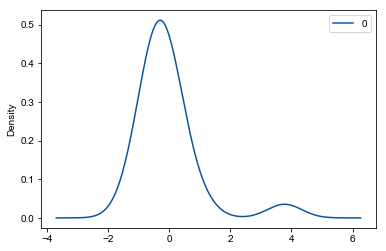

               0
count  20.000000
mean   -0.048174
std     1.028013
min    -1.201278
25%    -0.543419
50%    -0.217968
75%     0.081459
max     3.776294
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -26.779
Method:                       css-mle   S.D. of innovations              0.908
Date:                Sat, 18 Aug 2018   AIC                             59.558
Time:                        22:15:49   BIC                             62.545
Sample:                    07-29-2018   HQIC                            60.141
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4064      0.686      0.592      0.561   

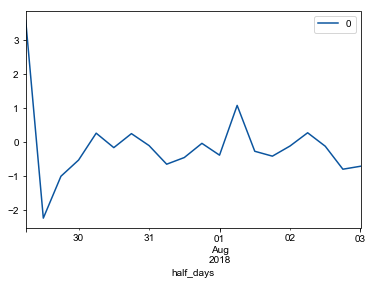

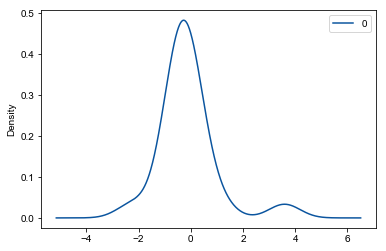

               0
count  20.000000
mean   -0.125931
std     1.088263
min    -2.241072
25%    -0.559089
50%    -0.215236
75%     0.036469
max     3.590789


In [147]:
# Select params

arima_analysis(reggaeton, (0,0,1))
arima_analysis(reggaeton, (0,1,1))
arima_analysis(reggaeton, (1,1,0))

In [148]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Reggaeton')] = ((0,1,1), reggaeton, 66.588, transform_value)

#### Gospel

In [149]:
# Check for overlap

copy_identical_categories ('Religious', 'Gospel')

Copy Complete - 100.0% of Identical Values


#### Country

In [150]:
# Check for overlap

copy_identical_categories ('Country', 'Country')

Copy Complete - 100.0% of Identical Values


#### Undefined

In [151]:
# Check for overlap

copy_identical_categories ('Undefined', 'Undefined')

Copy Complete - 99.9245445725989% of Identical Values


#### Folk

In [152]:
# Check for overlap

copy_identical_categories ('Folk', 'Folk')

Copy Complete - 100.0% of Identical Values


#### World

In [153]:
# Check for overlap

copy_identical_categories ('World', 'World')

Copy Complete - 95.86073083971112% of Identical Values


#### R&B

In [154]:
# Check for overlap

copy_identical_categories ('R&B', 'R&B')

Copy Complete - 99.17214616794222% of Identical Values


#### Heavy Metal

In [155]:
# Check for overlap

copy_identical_categories ('Metal', 'Heavy Metal')

Copy Complete - 100.0% of Identical Values


#### Other

In [156]:
# Check for overlap

copy_identical_categories ('Other', 'Other')

Copy Complete - 100.0% of Identical Values


#### Latin

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


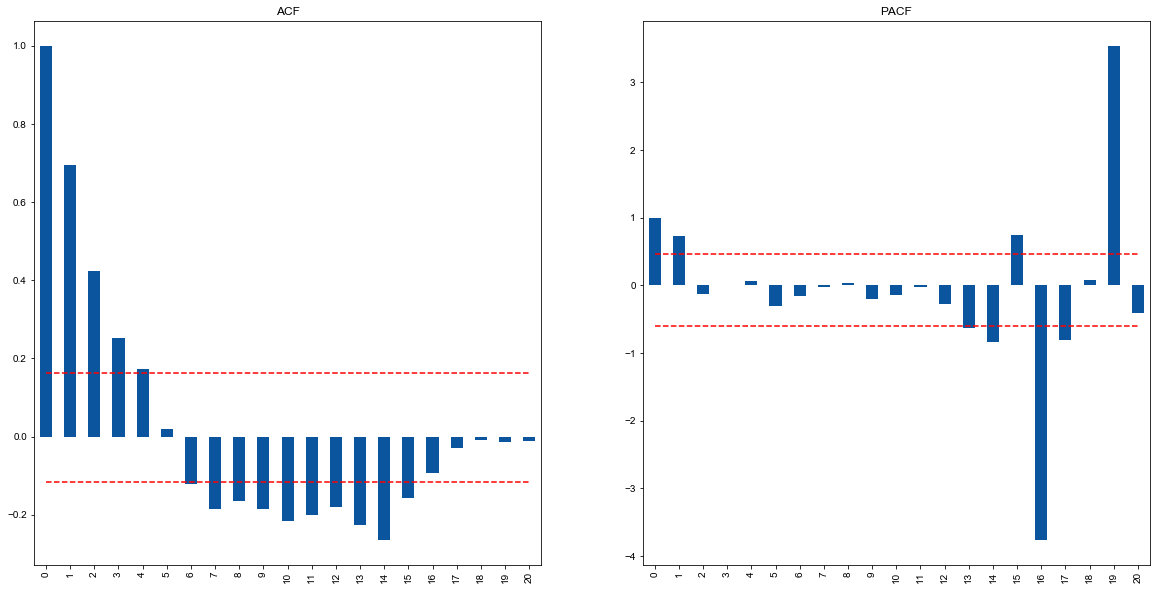

In [157]:
## Analyze Latin

latin = grouped_upsample('classificationSubGenre', 'Latin')
latin, transform_value = log_transform(latin.unified_metric)
plot_acf(latin, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


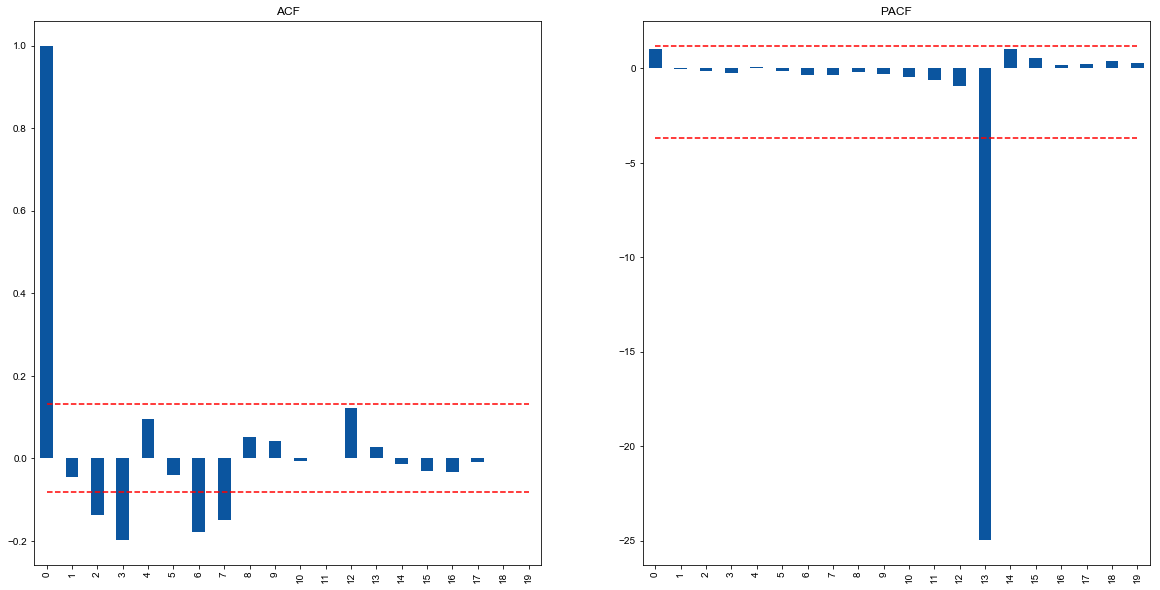

In [158]:
# Update differencing and replot residuals

lag1 = ARIMA(latin,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -28.181
Method:                       css-mle   S.D. of innovations              0.990
Date:                Sat, 18 Aug 2018   AIC                             62.361
Time:                        22:15:51   BIC                             65.348
Sample:                    07-29-2018   HQIC                            62.944
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0824      0.213      0.388      0.703      -0.334       0.499
ar.L1.D.y     -0.0436      0.218     -0.199      0.844      -0.472       0.385
                                    Roots           

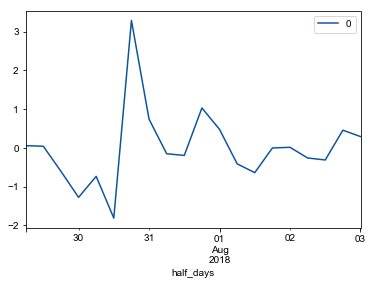

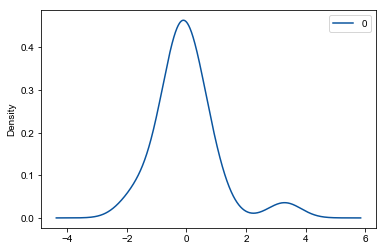

               0
count  20.000000
mean    0.000124
std     1.015816
min    -1.813702
25%    -0.460026
50%    -0.076775
75%     0.333340
max     3.291345
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -28.182
Method:                       css-mle   S.D. of innovations              0.911
Date:                Sat, 18 Aug 2018   AIC                             62.364
Time:                        22:15:52   BIC                             65.497
Sample:                    07-29-2018   HQIC                            63.044
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1185      0.604      6.820      0.000   

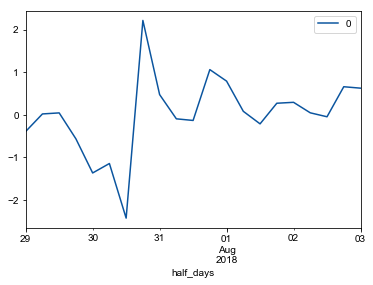

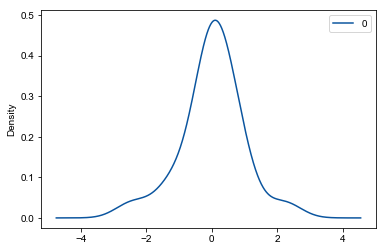

               0
count  21.000000
mean    0.012948
std     0.935538
min    -2.424299
25%    -0.209864
50%     0.047989
75%     0.477737
max     2.220045
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                 -28.056
Method:                       css-mle   S.D. of innovations              0.905
Date:                Sat, 18 Aug 2018   AIC                             64.111
Time:                        22:15:52   BIC                             68.290
Sample:                    07-29-2018   HQIC                            65.018
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0986      0.560      7.313      0.000   

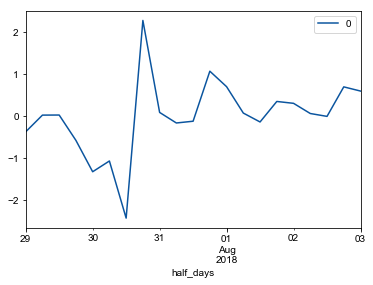

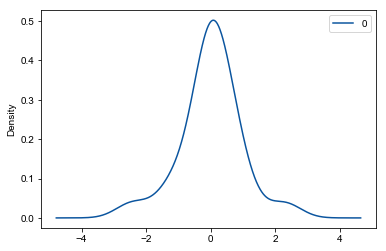

               0
count  21.000000
mean    0.009274
std     0.929195
min    -2.425326
25%    -0.157341
50%     0.032214
75%     0.355696
max     2.287001
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -28.172
Method:                       css-mle   S.D. of innovations              0.990
Date:                Sat, 18 Aug 2018   AIC                             62.345
Time:                        22:15:53   BIC                             65.332
Sample:                    07-29-2018   HQIC                            62.928
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0820      0.208      0.394      0.698   

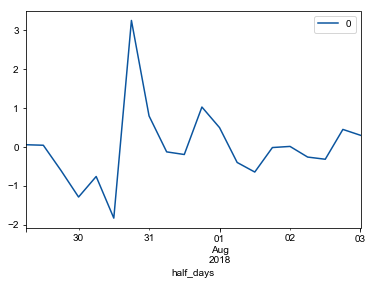

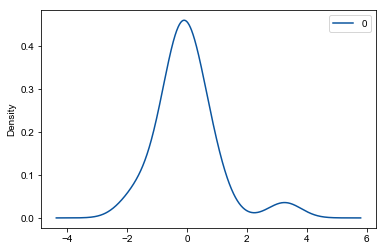

               0
count  20.000000
mean    0.000190
std     1.015352
min    -1.831117
25%    -0.450185
50%    -0.070996
75%     0.337864
max     3.255130
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -30.393
Method:                       css-mle   S.D. of innovations              1.019
Date:                Sat, 18 Aug 2018   AIC                             66.785
Time:                        22:15:53   BIC                             69.919
Sample:                    07-29-2018   HQIC                            67.465
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0351      0.342     11.790      0.000   

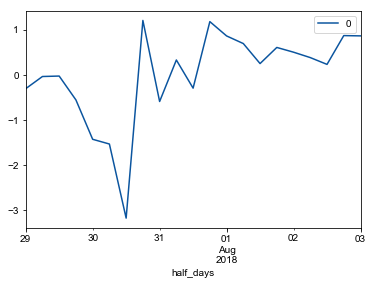

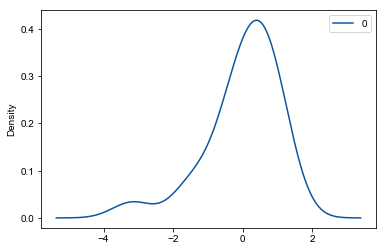

               0
count  21.000000
mean    0.003441
std     1.045333
min    -3.171550
25%    -0.304551
50%     0.251831
75%     0.694919
max     1.207113
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -26.818
Method:                       css-mle   S.D. of innovations              0.886
Date:                Sat, 18 Aug 2018   AIC                             61.635
Time:                        22:15:53   BIC                             65.618
Sample:                    07-29-2018   HQIC                            62.413
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1121      0.069      1.621      0.123   

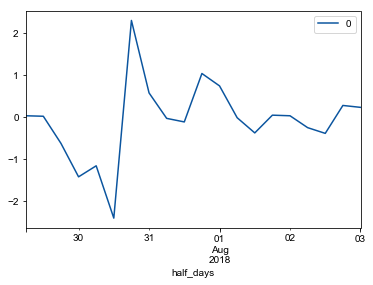

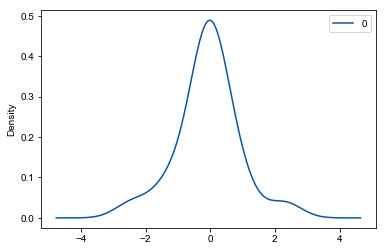

               0
count  20.000000
mean   -0.079314
std     0.951295
min    -2.409994
25%    -0.384085
50%    -0.002086
75%     0.238471
max     2.296532
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -26.503
Method:                       css-mle   S.D. of innovations              0.864
Date:                Sat, 18 Aug 2018   AIC                             63.005
Time:                        22:15:54   BIC                             67.984
Sample:                    07-29-2018   HQIC                            63.977
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1211      0.061      1.984      0.065   

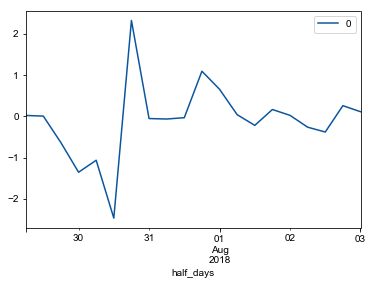

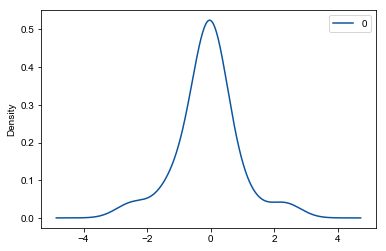

               0
count  20.000000
mean   -0.095120
std     0.936462
min    -2.467381
25%    -0.295287
50%    -0.016880
75%     0.122021
max     2.318059


In [159]:
# Select params

arima_analysis(latin, (1,1,0))
arima_analysis(latin, (1,0,0))
arima_analysis(latin, (2,0,0))
arima_analysis(latin, (0,1,1))
arima_analysis(latin, (0,0,1))
arima_analysis(latin, (1,1,1))
arima_analysis(latin, (2,1,1))

In [160]:
# Update DF with new values

model = ARIMA(latin,(1,1,1)).fit(disp=0)

ARIMA_models.loc[('classificationSubGenre','Latin')] = ((1,1,1), latin, 60.921, transform_value)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


#### Oldies & Classics

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


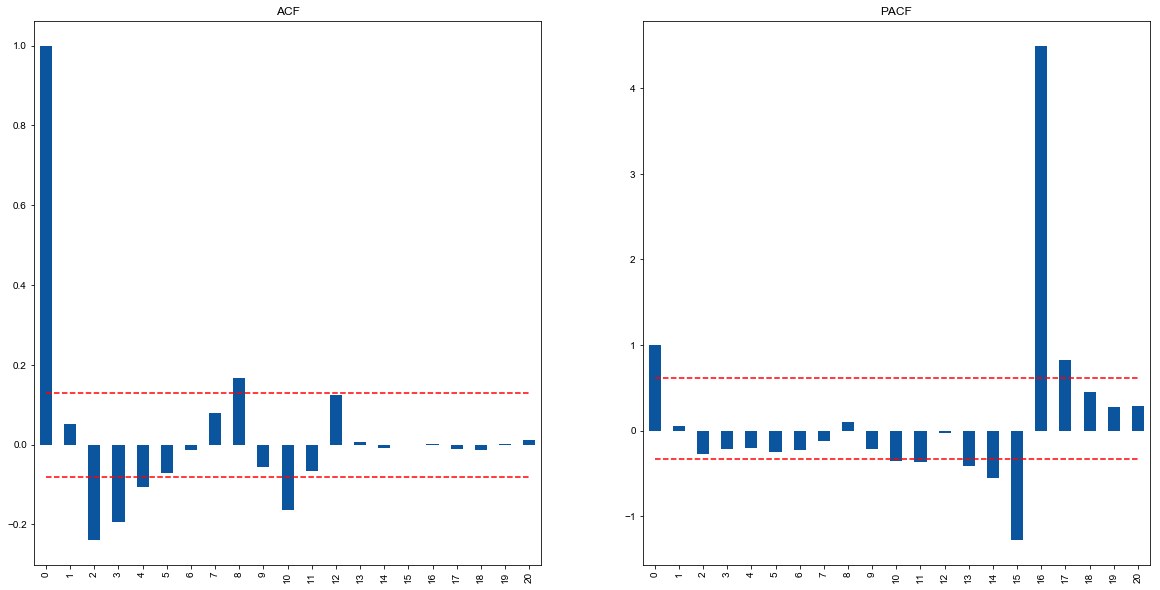

In [161]:
## Analyze Latin

oldies = grouped_upsample('classificationSubGenre', 'Oldies & Classics')
oldies, transform_value = log_transform(oldies.unified_metric)
plot_acf(oldies, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


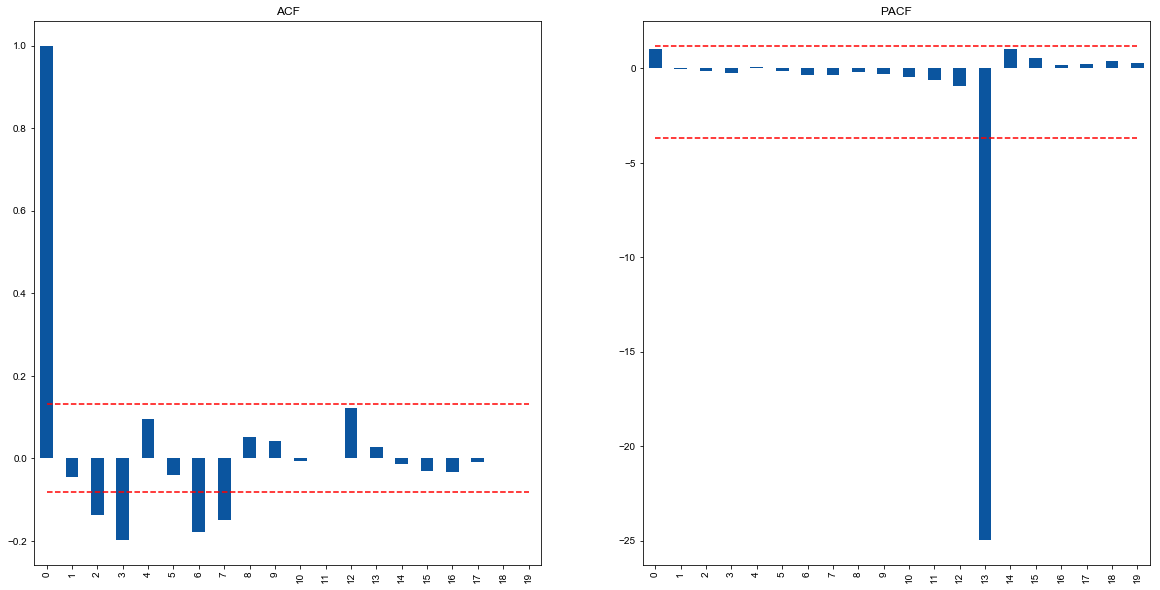

In [162]:
# Update differencing and replot residuals

lag1 = ARIMA(latin,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -38.351
Method:                       css-mle   S.D. of innovations              1.642
Date:                Sat, 18 Aug 2018   AIC                             82.703
Time:                        22:15:55   BIC                             85.690
Sample:                    07-29-2018   HQIC                            83.286
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0082      0.280     -0.029      0.977      -0.557       0.541
ar.L1.D.y     -0.3266      0.206     -1.585      0.130      -0.730       0.077
                                    Roots           

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


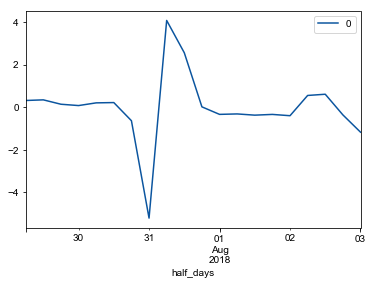

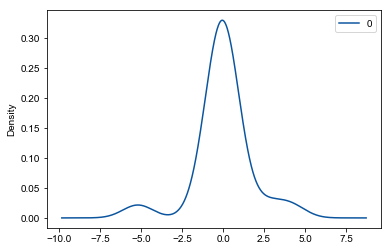

               0
count  20.000000
mean    0.005268
std     1.684642
min    -5.207228
25%    -0.357480
50%     0.053800
75%     0.330005
max     4.085776
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 0)   Log Likelihood                 -34.368
Method:                       css-mle   S.D. of innovations              1.243
Date:                Sat, 18 Aug 2018   AIC                             74.737
Time:                        22:15:56   BIC                             77.870
Sample:                    07-29-2018   HQIC                            75.417
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1393      0.285     18.030      0.000   

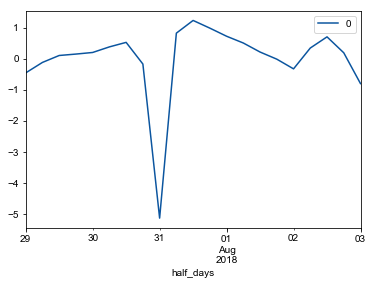

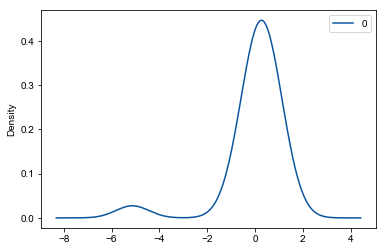

               0
count  21.000000
mean    0.001081
std     1.273792
min    -5.132079
25%    -0.121344
50%     0.199064
75%     0.523979
max     1.229843
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 0)   Log Likelihood                 -33.772
Method:                       css-mle   S.D. of innovations              1.205
Date:                Sat, 18 Aug 2018   AIC                             75.543
Time:                        22:15:56   BIC                             79.722
Sample:                    07-29-2018   HQIC                            76.450
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1505      0.230     22.420      0.000   

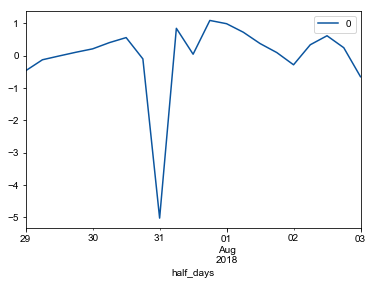

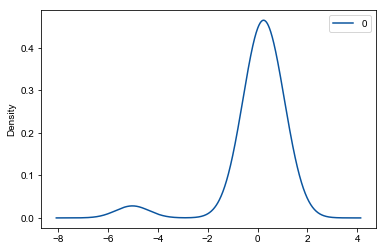

               0
count  21.000000
mean   -0.005640
std     1.235208
min    -5.019585
25%    -0.104712
50%     0.205704
75%     0.553093
max     1.082455
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -34.687
Method:                       css-mle   S.D. of innovations              1.270
Date:                Sat, 18 Aug 2018   AIC                             75.373
Time:                        22:15:57   BIC                             78.361
Sample:                    07-29-2018   HQIC                            75.956
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0184      0.046      0.402      0.693   

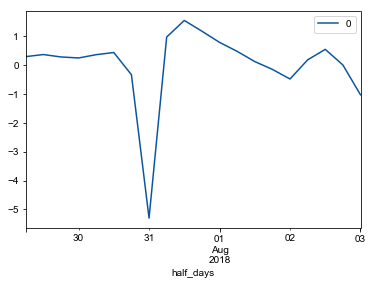

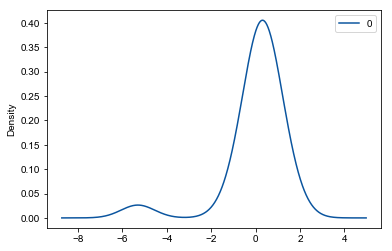

               0
count  20.000000
mean    0.027498
std     1.379274
min    -5.301713
25%    -0.031185
50%     0.290310
75%     0.496340
max     1.550337
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -34.348
Method:                       css-mle   S.D. of innovations              1.242
Date:                Sat, 18 Aug 2018   AIC                             74.695
Time:                        22:15:57   BIC                             77.829
Sample:                    07-29-2018   HQIC                            75.375
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1373      0.294     17.491      0.000   

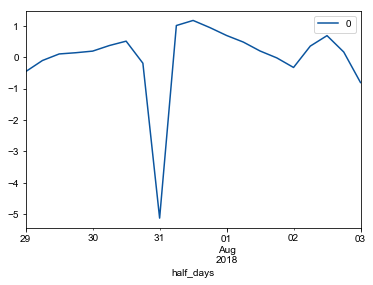

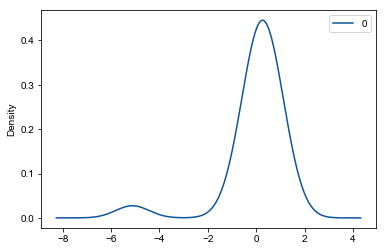

               0
count  21.000000
mean    0.001667
std     1.272396
min    -5.120989
25%    -0.102872
50%     0.196093
75%     0.512948
max     1.172571
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 2)   Log Likelihood                 -33.376
Method:                       css-mle   S.D. of innovations              1.114
Date:                Sat, 18 Aug 2018   AIC                             74.751
Time:                        22:15:57   BIC                             78.929
Sample:                    07-29-2018   HQIC                            75.658
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1595      0.057     90.228      0.000   

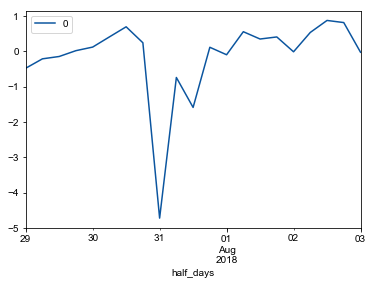

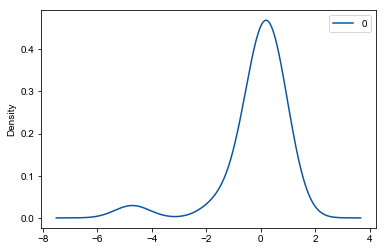

               0
count  21.000000
mean   -0.138151
std     1.188421
min    -4.716660
25%    -0.146645
50%     0.113891
75%     0.407165
max     0.872503
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -34.561
Method:                       css-mle   S.D. of innovations              1.270
Date:                Sat, 18 Aug 2018   AIC                             77.123
Time:                        22:15:58   BIC                             81.106
Sample:                    07-29-2018   HQIC                            77.900
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0171      0.051      0.333      0.743   

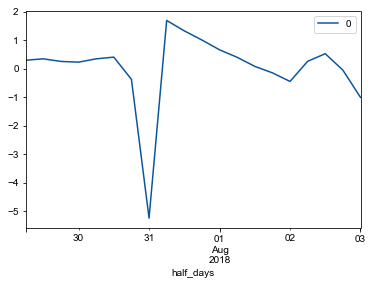

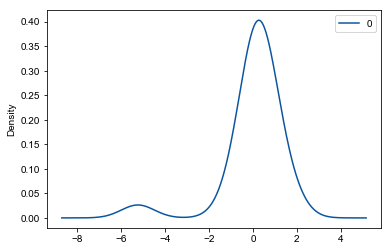

               0
count  20.000000
mean    0.029581
std     1.376314
min    -5.237589
25%    -0.073103
50%     0.278517
75%     0.436731
max     1.692789
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -34.608
Method:                       css-mle   S.D. of innovations              1.271
Date:                Sat, 18 Aug 2018   AIC                             77.216
Time:                        22:15:58   BIC                             81.199
Sample:                    07-29-2018   HQIC                            77.993
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.050      0.350      0.730   

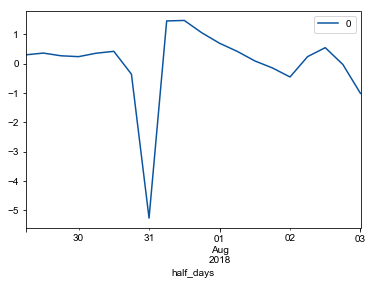

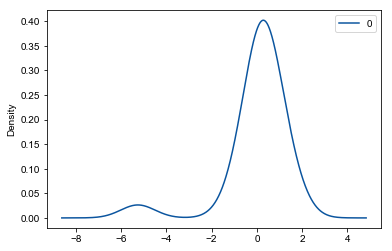

               0
count  20.000000
mean    0.029267
std     1.377977
min    -5.262904
25%    -0.060881
50%     0.280975
75%     0.447904
max     1.467987
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -34.175
Method:                       css-mle   S.D. of innovations              1.230
Date:                Sat, 18 Aug 2018   AIC                             78.350
Time:                        22:15:59   BIC                             83.328
Sample:                    07-29-2018   HQIC                            79.321
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.041      0.472      0.643   

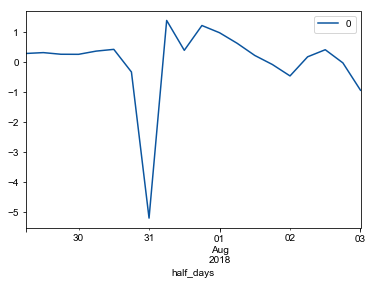

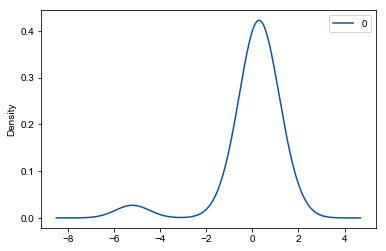

               0
count  20.000000
mean    0.021872
std     1.340906
min    -5.201944
25%    -0.032740
50%     0.281876
75%     0.423225
max     1.397745


In [163]:
# Select params

arima_analysis(oldies, (1,1,0))
arima_analysis(oldies, (1,0,0))
arima_analysis(oldies, (2,0,0))
arima_analysis(oldies, (0,1,1))
arima_analysis(oldies, (0,0,1))
arima_analysis(oldies, (0,0,2))
arima_analysis(oldies, (0,1,2))
arima_analysis(oldies, (1,1,1))
arima_analysis(oldies, (2,1,1))

In [164]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Oldies & Classics')] = ((0,0,2), oldies, 72.620, transform_value)

#### Blues

In [165]:
# Check for overlap

copy_identical_categories ('Blues', 'Blues')

Copy Complete - 100.0% of Identical Values


#### Jazz

In [166]:
# Check for overlap

copy_identical_categories ('Jazz', 'Jazz')

Copy Complete - 100.0% of Identical Values


#### Reggae

In [167]:
# Check for overlap

copy_identical_categories ('Reggae', 'Reggae')

Copy Complete - 100.0% of Identical Values


#### Other

In [168]:
# Check for overlap

copy_identical_categories ('Other', 'Other')

Copy Complete - 100.0% of Identical Values


#### Punk

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


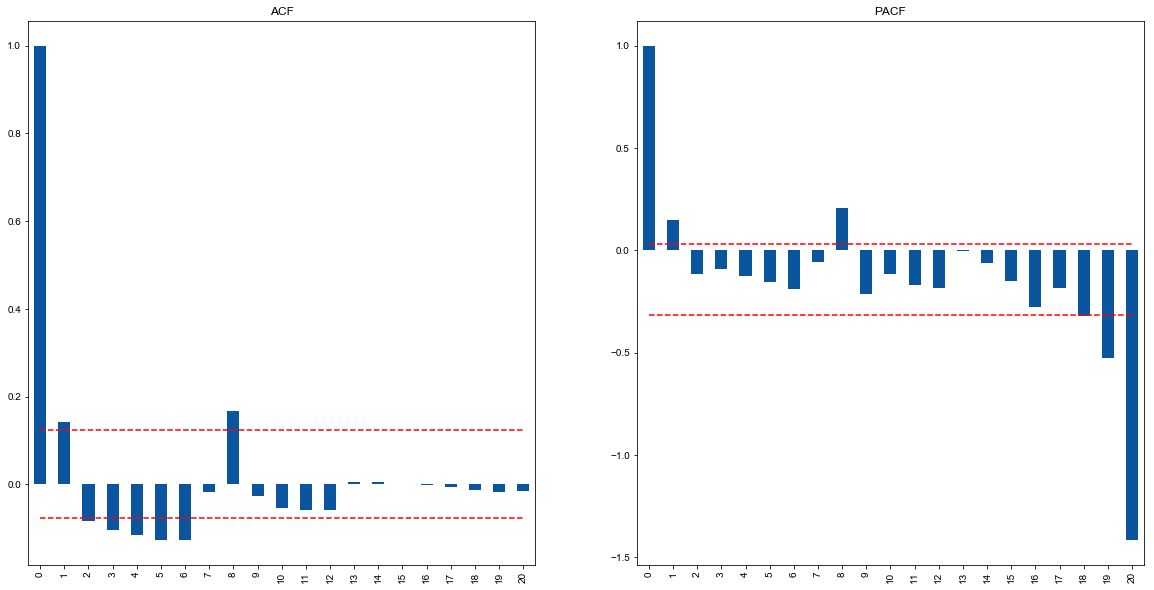

In [169]:
## Analyze Punk

punk = grouped_upsample('classificationSubGenre', 'Punk')
punk, transform_value = log_transform(punk.unified_metric)
plot_acf(punk, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


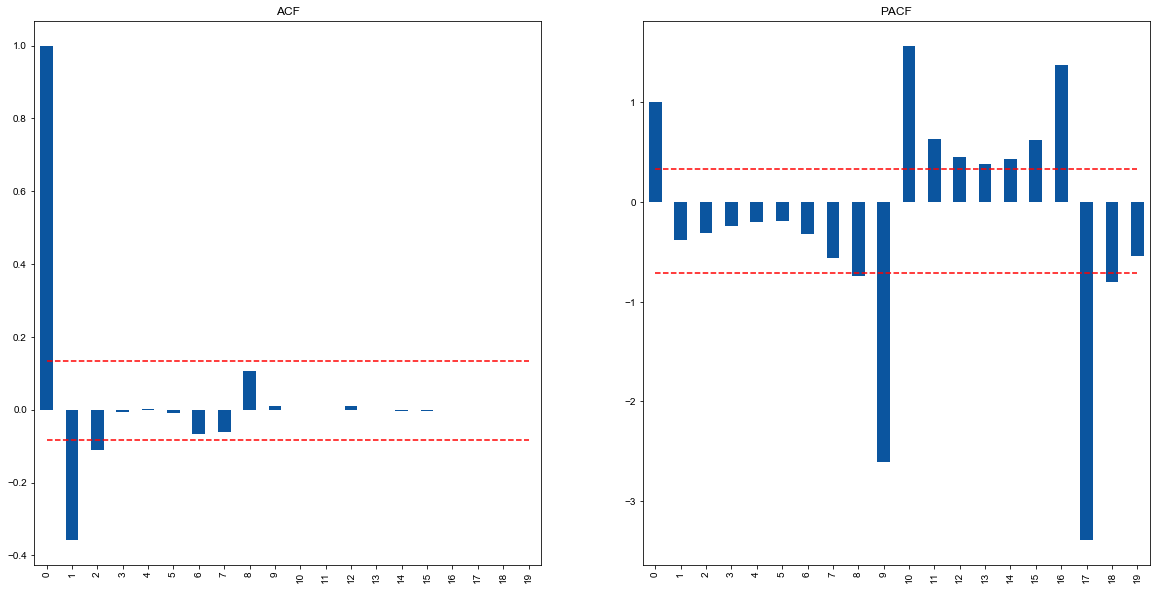

In [170]:
# Update differencing and replot residuals

lag1 = ARIMA(punk,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -36.914
Method:                       css-mle   S.D. of innovations              1.402
Date:                Sat, 18 Aug 2018   AIC                             81.828
Time:                        22:16:01   BIC                             86.006
Sample:                    07-29-2018   HQIC                            82.735
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0329      0.346     17.461      0.000       5.356       6.710
ar.L1.y       -0.1920      0.998     -0.192      0.850      -2.148       1.764
ma.L1.y        0.3514      0.942      0.373      0.7

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


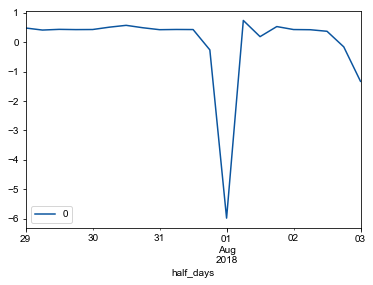

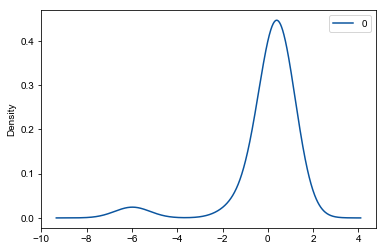

               0
count  21.000000
mean   -0.001821
std     1.437117
min    -5.979961
25%     0.368604
50%     0.427258
75%     0.479984
max     0.737017
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(0, 1)   Log Likelihood                 -36.932
Method:                       css-mle   S.D. of innovations              1.404
Date:                Sat, 18 Aug 2018   AIC                             79.865
Time:                        22:16:01   BIC                             82.999
Sample:                    07-29-2018   HQIC                            80.545
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0315      0.355     16.988      0.000   

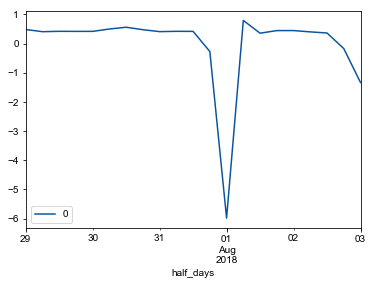

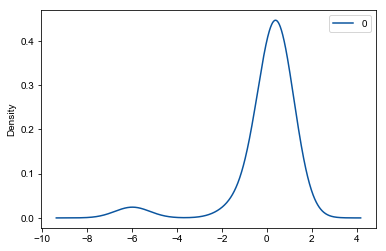

               0
count  21.000000
mean   -0.002712
std     1.438430
min    -5.985832
25%     0.360823
50%     0.416853
75%     0.444841
max     0.791757
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -36.894
Method:                       css-mle   S.D. of innovations              1.419
Date:                Sat, 18 Aug 2018   AIC                             79.788
Time:                        22:16:02   BIC                             82.775
Sample:                    07-29-2018   HQIC                            80.371
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0535      0.051     -1.046      0.309   

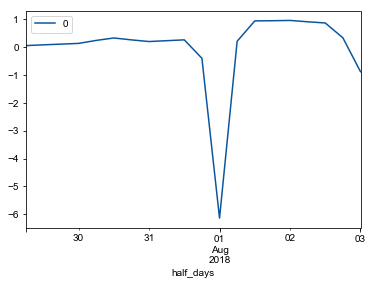

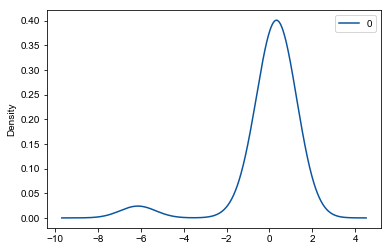

               0
count  20.000000
mean   -0.015526
std     1.513384
min    -6.138663
25%     0.103261
50%     0.238079
75%     0.470220
max     0.960258
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   20
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -36.588
Method:                       css-mle   S.D. of innovations              1.407
Date:                Sat, 18 Aug 2018   AIC                             81.177
Time:                        22:16:02   BIC                             85.160
Sample:                    07-29-2018   HQIC                            81.954
                         - 08-03-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0555      0.059     -0.946      0.358   

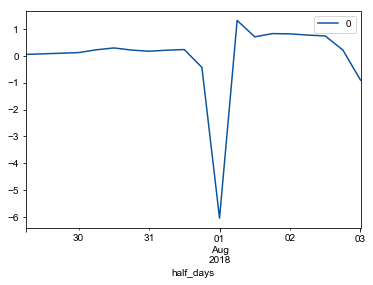

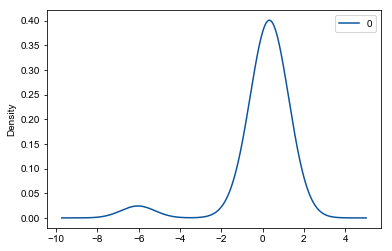

               0
count  20.000000
mean   -0.008130
std     1.499958
min    -6.044254
25%     0.097827
50%     0.221881
75%     0.723340
max     1.325583


In [171]:
# Select params

arima_analysis(punk, (1,0,1))
arima_analysis(punk, (0,0,1))
arima_analysis(punk, (0,1,1))
arima_analysis(punk, (0,1,2))

In [172]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Punk')] = ((0,0,1), punk, 83.191, transform_value)

#### Adult Contemporary

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


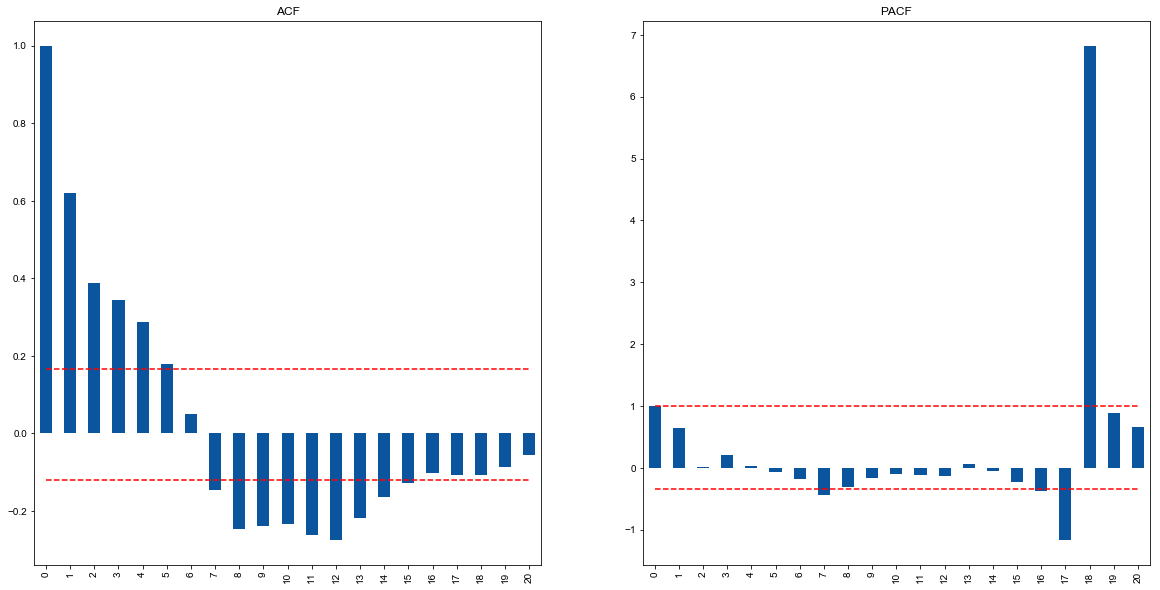

In [173]:
## Analyze Contemporary

adult = grouped_upsample('classificationSubGenre', 'Adult Contemporary')
adult, transform_value = log_transform(adult.unified_metric)
plot_acf(adult, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


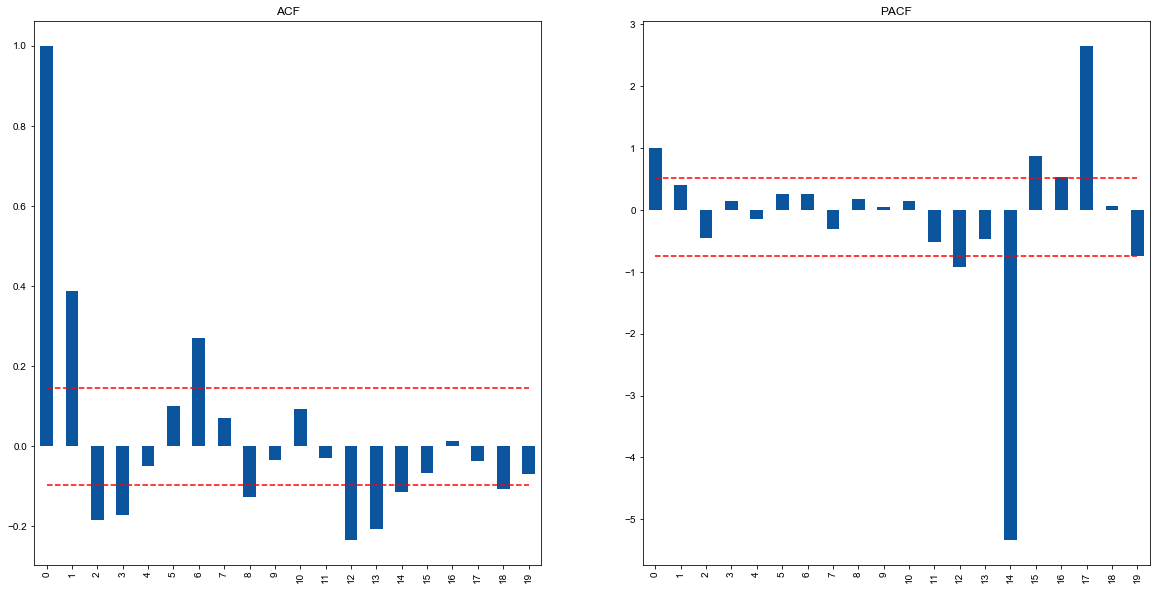

In [174]:
# Update differencing and replot residuals

lag1 = ARIMA(adult,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   5.850
Method:                       css-mle   S.D. of innovations              0.178
Date:                Sat, 18 Aug 2018   AIC                             -5.700
Time:                        22:16:04   BIC                             -2.712
Sample:                    07-29-2018   HQIC                            -5.116
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1222      0.121     -1.013      0.324      -0.359       0.114
ar.L1.D.unified_metric     0.6811      0.224      3.042      0.007       0.242       1.120
    

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


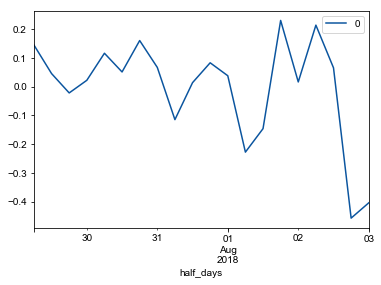

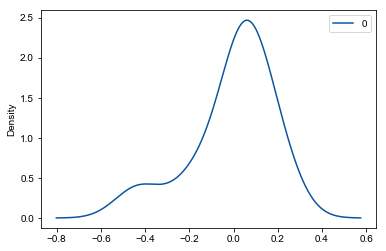

               0
count  20.000000
mean   -0.004943
std     0.183768
min    -0.457453
25%    -0.044840
50%     0.042008
75%     0.091633
max     0.230773
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   9.362
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sat, 18 Aug 2018   AIC                            -10.724
Time:                        22:16:04   BIC                             -6.741
Sample:                    07-29-2018   HQIC                            -9.946
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0996

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


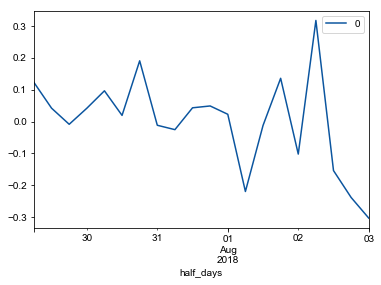

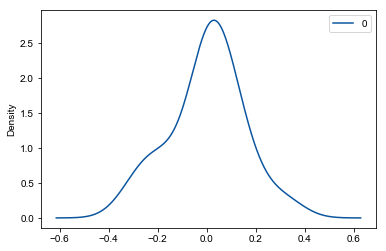

               0
count  20.000000
mean    0.000152
std     0.148699
min    -0.303103
25%    -0.044696
50%     0.020915
75%     0.060652
max     0.317071
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   8.746
Method:                       css-mle   S.D. of innovations              0.149
Date:                Sat, 18 Aug 2018   AIC                            -11.493
Time:                        22:16:05   BIC                             -8.506
Sample:                    07-29-2018   HQIC                           -10.910
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0871

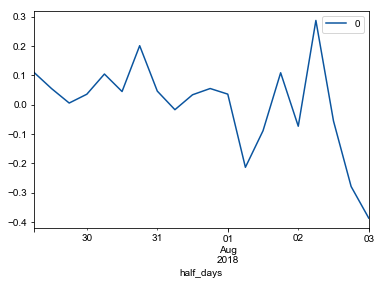

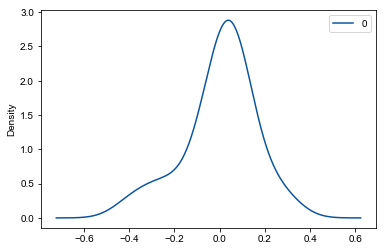

               0
count  20.000000
mean    0.000400
std     0.155582
min    -0.386148
25%    -0.060217
50%     0.035652
75%     0.067278
max     0.286642
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                   9.794
Method:                       css-mle   S.D. of innovations              0.142
Date:                Sat, 18 Aug 2018   AIC                             -9.589
Time:                        22:16:05   BIC                             -4.610
Sample:                    07-29-2018   HQIC                            -8.617
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0821

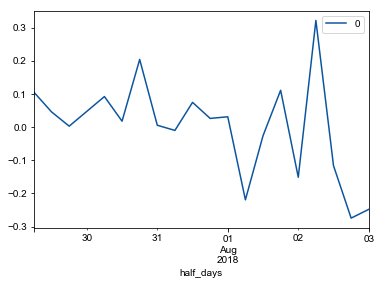

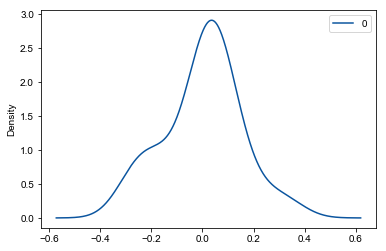

               0
count  20.000000
mean    0.001826
std     0.147097
min    -0.274705
25%    -0.048825
50%     0.021862
75%     0.078816
max     0.321554


In [175]:
# Select params

arima_analysis(adult, (1,1,0))
arima_analysis(adult, (1,1,1))
arima_analysis(adult, (0,1,1))
arima_analysis(adult, (2,1,1))

In [176]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Adult Contemporary')] = ((0,0,1), adult, -11.493, transform_value)

#### Classical/Vocal

In [177]:
# Check for overlap

copy_identical_categories ('Classical', 'Classical/Vocal')

Copy Complete - 100.0% of Identical Values


#### Funk

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k]*X[k:]).sum() / denom(k)


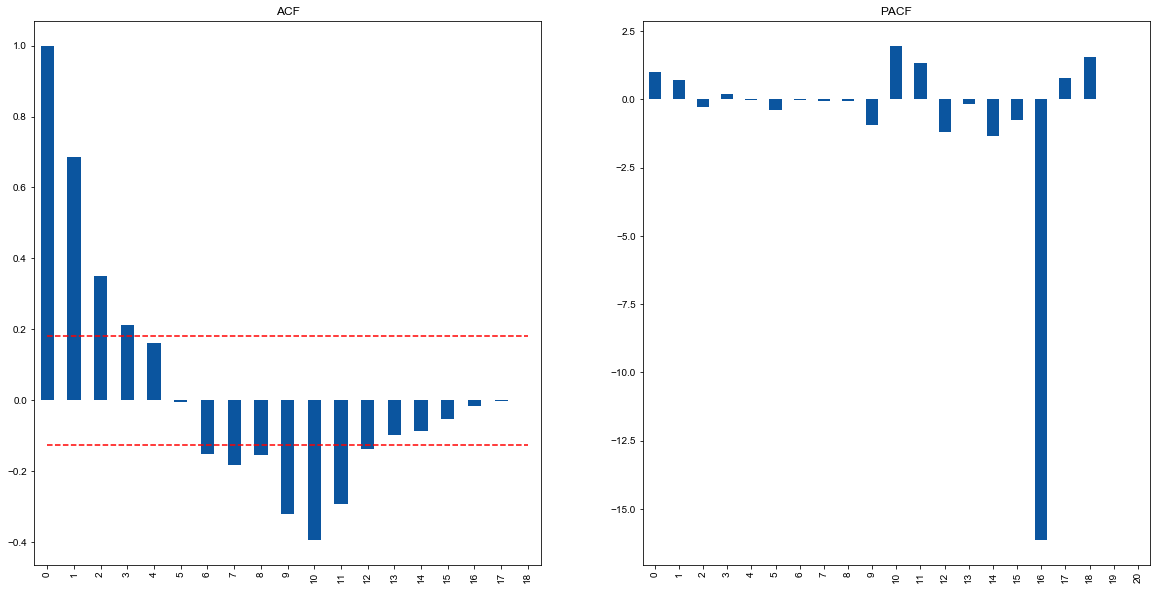

In [178]:
## Analyze Funk

funk = grouped_upsample('classificationSubGenre', 'Funk')
funk, transform_value = log_transform(funk.unified_metric)
plot_acf(funk, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k]*X[k:]).sum() / denom(k)


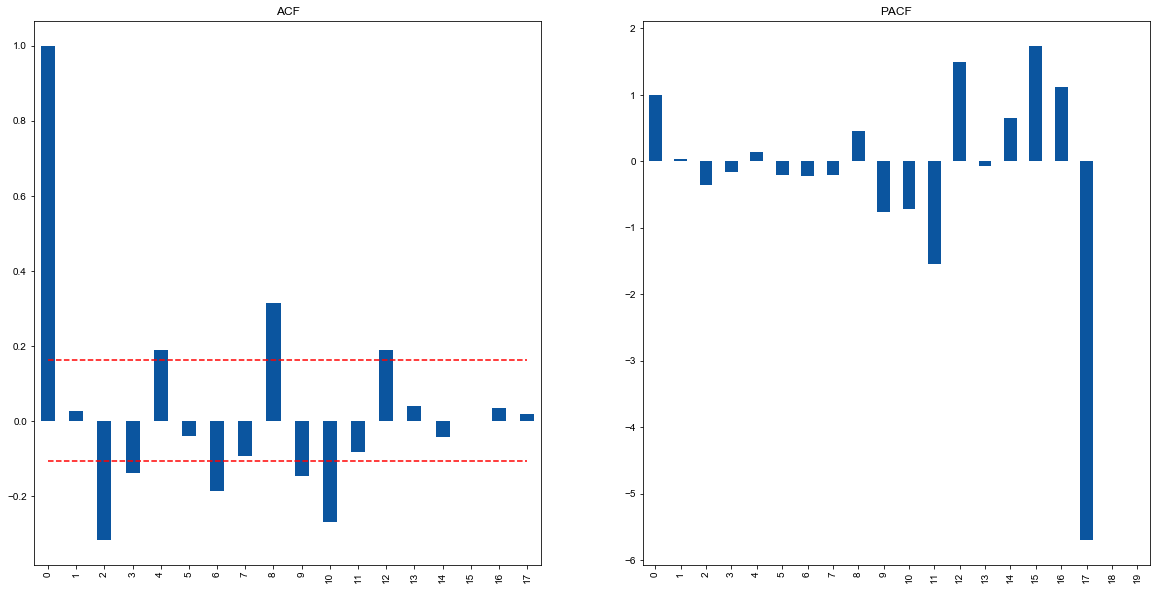

In [179]:
# Update differencing and replot residuals

lag1 = ARIMA(funk,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   18
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -21.385
Method:                       css-mle   S.D. of innovations              0.794
Date:                Sat, 18 Aug 2018   AIC                             48.769
Time:                        22:16:07   BIC                             51.440
Sample:                    07-29-2018   HQIC                            49.138
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.193     -0.011      0.991      -0.380       0.376
ar.L1.D.y      0.0284      0.241      0.118      0.908      -0.444       0.501
                                    Roots           

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


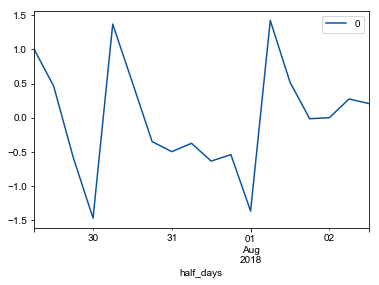

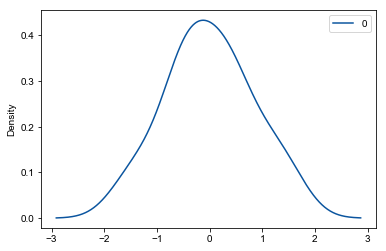

               0
count  18.000000
mean   -0.001589
std     0.816838
min    -1.466756
25%    -0.527694
50%    -0.005871
75%     0.502476
max     1.423575
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   18
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -21.373
Method:                       css-mle   S.D. of innovations              0.793
Date:                Sat, 18 Aug 2018   AIC                             48.745
Time:                        22:16:07   BIC                             51.417
Sample:                    07-29-2018   HQIC                            49.114
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.201      0.003      0.998   

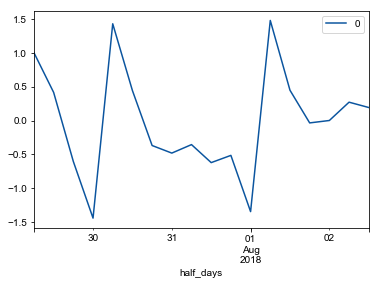

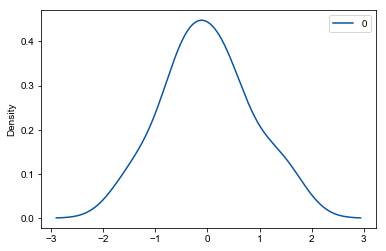

               0
count  18.000000
mean   -0.003664
std     0.816354
min    -1.441176
25%    -0.505430
50%    -0.015952
75%     0.437580
max     1.480779
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   19
Model:                     ARMA(1, 1)   Log Likelihood                 -20.176
Method:                       css-mle   S.D. of innovations              0.687
Date:                Sat, 18 Aug 2018   AIC                             48.352
Time:                        22:16:08   BIC                             52.130
Sample:                    07-29-2018   HQIC                            48.991
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4443      0.386      6.324      0.000   

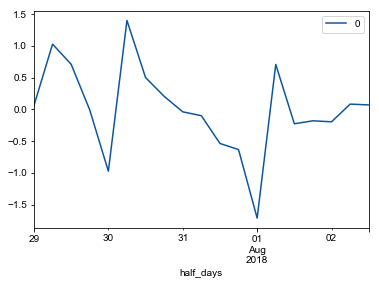

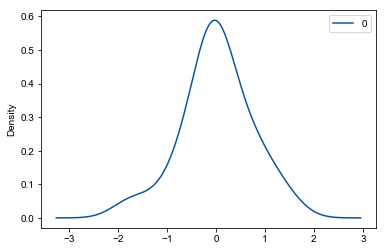

               0
count  19.000000
mean    0.006658
std     0.708148
min    -1.713462
25%    -0.212664
50%    -0.011349
75%     0.351325
max     1.398327
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   19
Model:                     ARMA(2, 1)   Log Likelihood                 -19.788
Method:                       css-mle   S.D. of innovations              0.647
Date:                Sat, 18 Aug 2018   AIC                             49.576
Time:                        22:16:08   BIC                             54.298
Sample:                    07-29-2018   HQIC                            50.375
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4214      0.183     13.262      0.000   

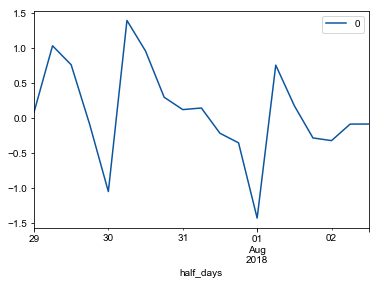

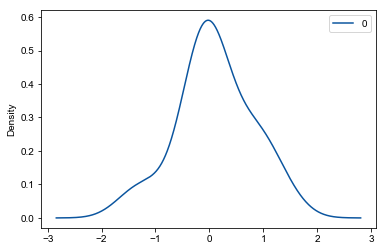

               0
count  19.000000
mean    0.095245
std     0.691074
min    -1.428910
25%    -0.249925
50%     0.081650
75%     0.527453
max     1.395169


In [180]:
# Select params

arima_analysis(funk, (1,1,0))
arima_analysis(funk, (0,1,1))
arima_analysis(funk, (1,0,1))
arima_analysis(funk, (2,0,1))

In [181]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Funk')] = ((2,0,1), funk, 52.310, transform_value)

#### New Age

In [182]:
# Check for overlap

copy_identical_categories ('New Age', 'New Age')

Copy Complete - 100.0% of Identical Values


#### Flamenco

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k]*X[k:]).sum() / denom(k)


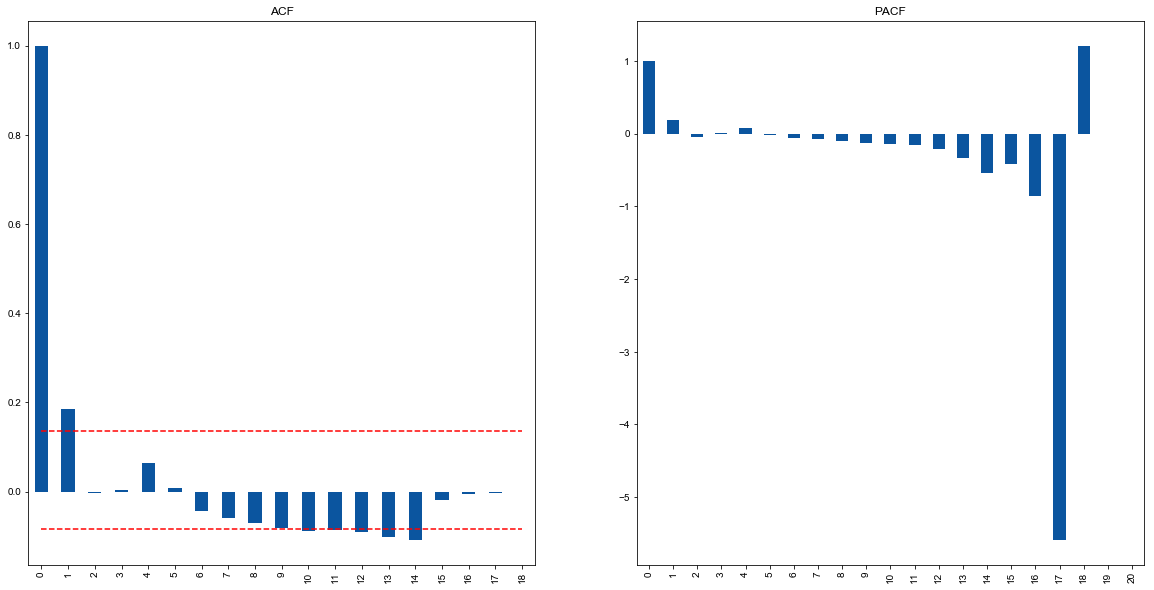

In [183]:
## Analyze Flamenco

flamenco = grouped_upsample('classificationSubGenre', 'Flamenco')
flamenco, transform_value = log_transform(flamenco.unified_metric)
plot_acf(flamenco, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k]*X[k:]).sum() / denom(k)


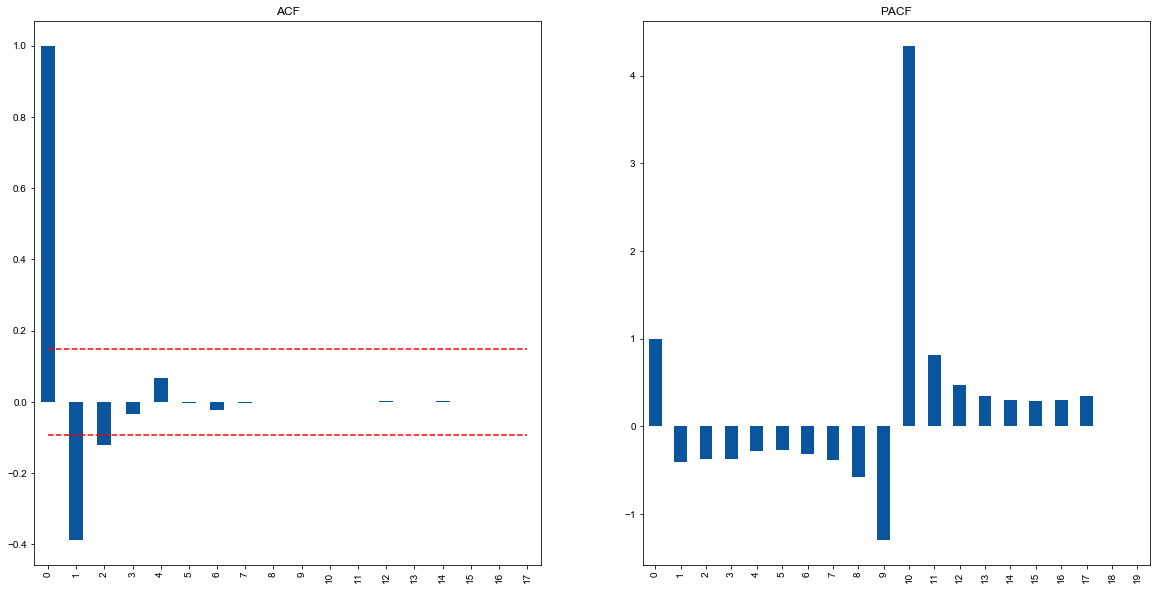

In [184]:
# Update differencing and replot residuals

lag1 = ARIMA(flamenco,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   18
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -39.920
Method:                       css-mle   S.D. of innovations              2.214
Date:                Sat, 18 Aug 2018   AIC                             85.840
Time:                        22:16:10   BIC                             88.511
Sample:                    07-29-2018   HQIC                            86.209
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0469      0.387     -0.121      0.905      -0.806       0.712
ar.L1.D.y     -0.3677      0.210     -1.750      0.099      -0.779       0.044
                                    Roots           

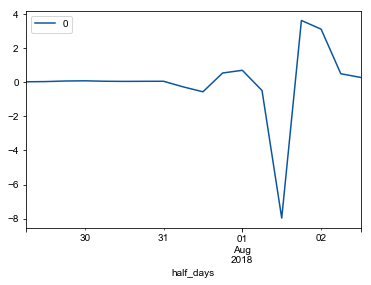

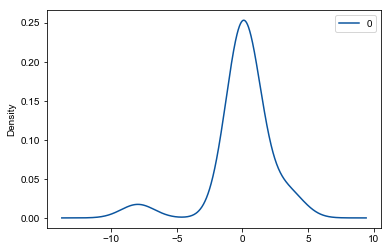

               0
count  18.000000
mean    0.000655
std     2.278218
min    -7.969899
25%     0.034963
50%     0.063410
75%     0.451499
max     3.632682
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   18
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -36.856
Method:                       css-mle   S.D. of innovations              1.728
Date:                Sat, 18 Aug 2018   AIC                             79.712
Time:                        22:16:10   BIC                             82.383
Sample:                    07-29-2018   HQIC                            80.081
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1342      0.072     -1.854      0.082   

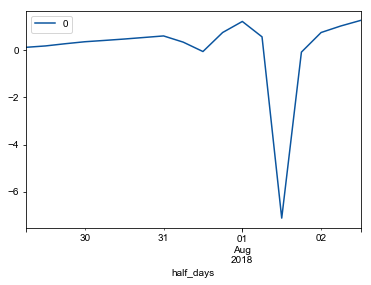

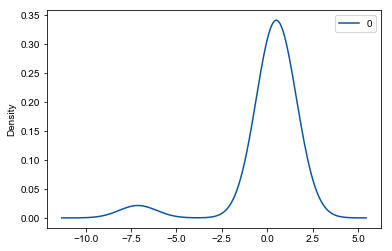

               0
count  18.000000
mean    0.088502
std     1.839792
min    -7.120798
25%     0.202153
50%     0.442185
75%     0.712150
max     1.259899
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   18
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -36.791
Method:                       css-mle   S.D. of innovations              1.730
Date:                Sat, 18 Aug 2018   AIC                             81.583
Time:                        22:16:11   BIC                             85.144
Sample:                    07-29-2018   HQIC                            82.074
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1316      0.079     -1.671      0.115   

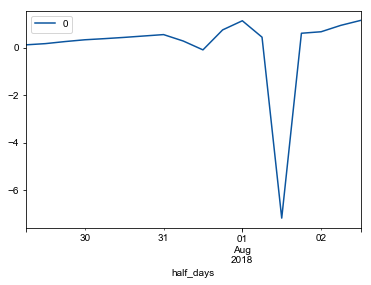

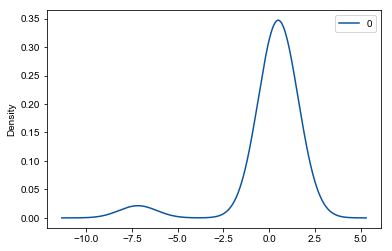

               0
count  18.000000
mean    0.077775
std     1.841239
min    -7.178629
25%     0.261179
50%     0.435516
75%     0.652841
max     1.144747
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   19
Model:                     ARMA(1, 1)   Log Likelihood                 -38.350
Method:                       css-mle   S.D. of innovations              1.797
Date:                Sat, 18 Aug 2018   AIC                             84.700
Time:                        22:16:11   BIC                             88.478
Sample:                    07-29-2018   HQIC                            85.339
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4807      0.318     23.534      0.000   

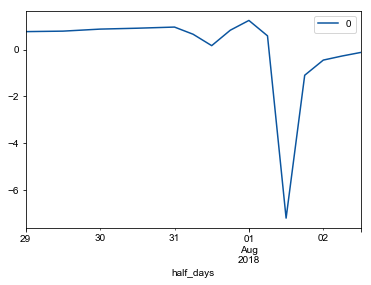

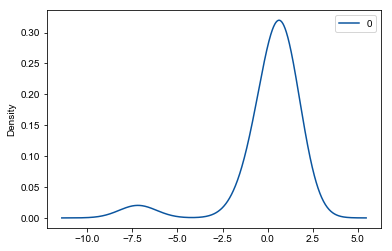

               0
count  19.000000
mean    0.108523
std     1.865141
min    -7.187483
25%     0.021124
50%     0.775393
75%     0.881872
max     1.241667
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   19
Model:                     ARMA(2, 1)   Log Likelihood                 -37.872
Method:                       css-mle   S.D. of innovations              1.732
Date:                Sat, 18 Aug 2018   AIC                             85.743
Time:                        22:16:12   BIC                             90.465
Sample:                    07-29-2018   HQIC                            86.542
                         - 08-02-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4933      0.304     24.685      0.000   

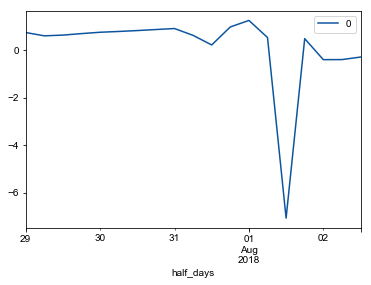

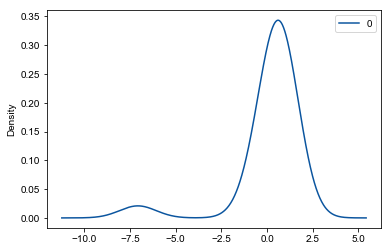

               0
count  19.000000
mean    0.153686
std     1.808142
min    -7.069334
25%     0.360947
50%     0.643129
75%     0.815513
max     1.260983


In [185]:
# Select params

arima_analysis(flamenco, (1,1,0))
arima_analysis(flamenco, (0,1,1))
arima_analysis(flamenco, (0,1,2))
arima_analysis(flamenco, (1,0,1))
arima_analysis(flamenco, (2,0,1))

In [186]:
# Update DF with new values

ARIMA_models.loc[('classificationSubGenre','Flamenco')] = ((0,1,1), flamenco, 79.712, transform_value)

#### Ballads/Romantic

In [187]:
# Check for overlap

copy_identical_categories ('Ballads/Romantic', 'Ballads/Romantic')

Copy Complete - 100.0% of Identical Values


## 3. Presales

#### Presales - Yes

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


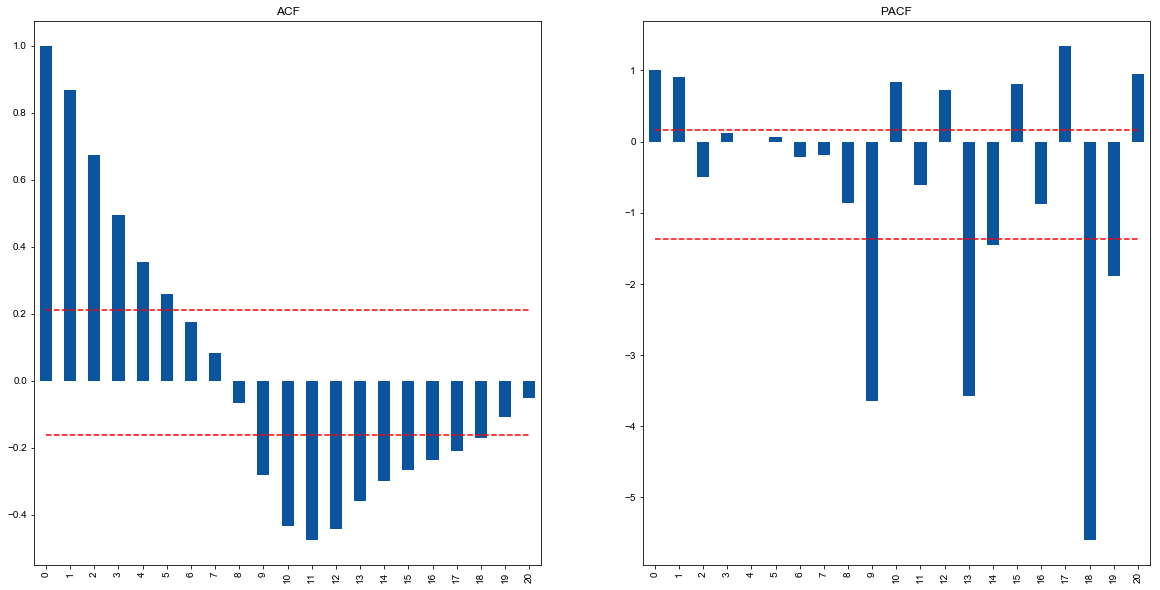

In [188]:
## Analyze presales

presales_yes = grouped_upsample('presales', 1)
presales_yes, transform_value = log_transform(presales_yes.unified_metric)
plot_acf(presales_yes, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


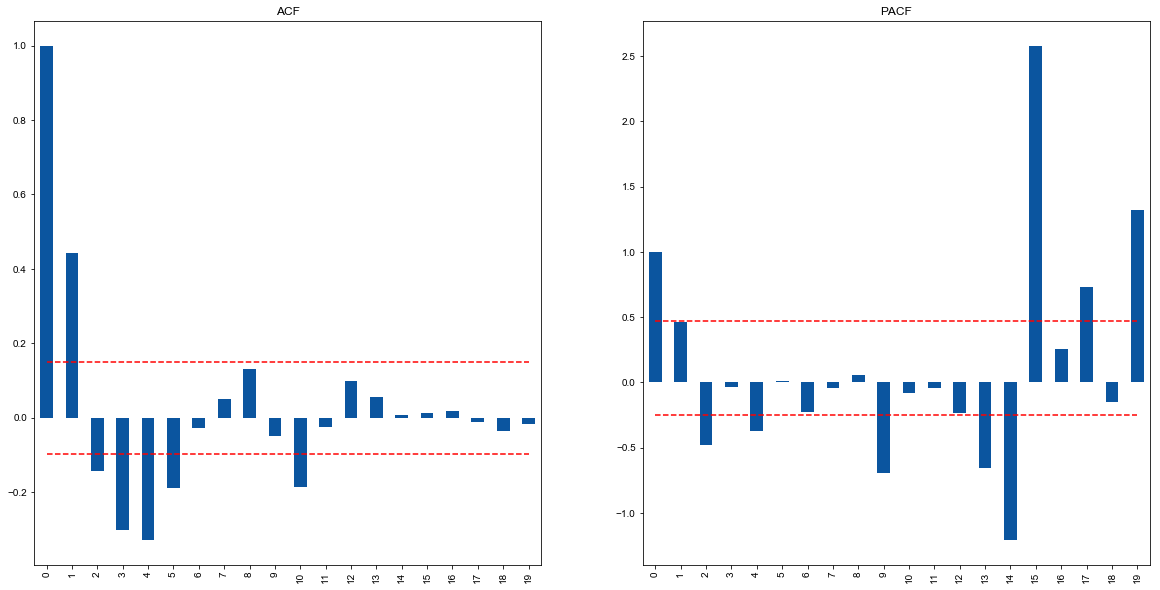

In [189]:
# Update differencing and replot residuals

lag1 = ARIMA(presales_yes,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  11.145
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sat, 18 Aug 2018   AIC                            -16.289
Time:                        22:16:14   BIC                            -13.302
Sample:                    07-29-2018   HQIC                           -15.706
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0424      0.053      0.798      0.435      -0.062       0.147
ar.L1.D.unified_metric     0.4411      0.197      2.242      0.038       0.055       0.827
    

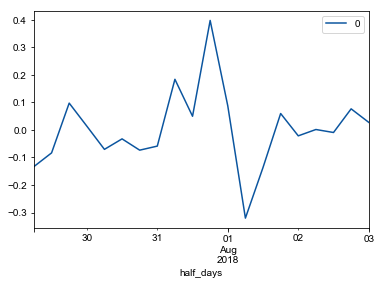

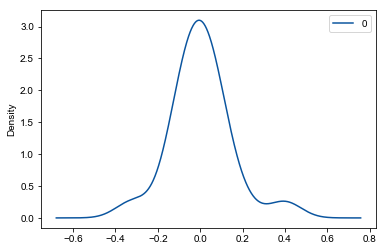

               0
count  20.000000
mean    0.002932
std     0.142039
min    -0.320306
25%    -0.071204
50%    -0.003767
75%     0.064038
max     0.397958
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  12.551
Method:                       css-mle   S.D. of innovations              0.128
Date:                Sat, 18 Aug 2018   AIC                            -19.102
Time:                        22:16:14   BIC                            -16.114
Sample:                    07-29-2018   HQIC                           -18.518
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0442

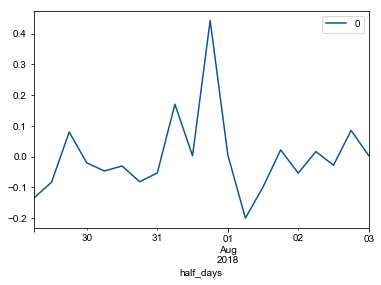

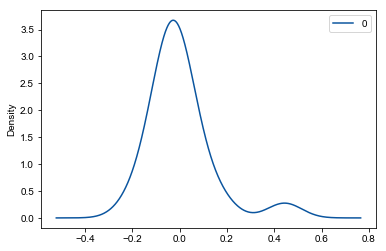

               0
count  20.000000
mean   -0.000065
std     0.132126
min    -0.200171
25%    -0.060602
50%    -0.024267
75%     0.017850
max     0.443387
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  12.571
Method:                       css-mle   S.D. of innovations              0.127
Date:                Sat, 18 Aug 2018   AIC                            -17.143
Time:                        22:16:14   BIC                            -13.160
Sample:                    07-29-2018   HQIC                           -16.365
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0440

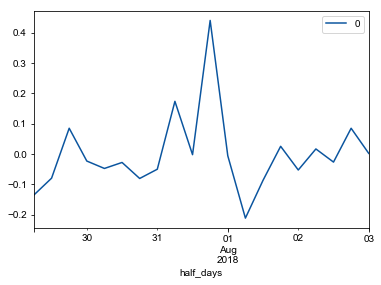

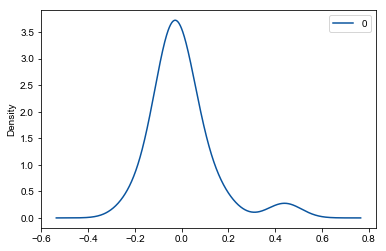

               0
count  20.000000
mean    0.000085
std     0.131997
min    -0.210790
25%    -0.059171
50%    -0.024713
75%     0.018981
max     0.439678
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 2)   Log Likelihood                  12.342
Method:                       css-mle   S.D. of innovations              0.125
Date:                Sat, 18 Aug 2018   AIC                            -14.684
Time:                        22:16:15   BIC                             -9.462
Sample:                    07-29-2018   HQIC                           -13.551
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.5303      

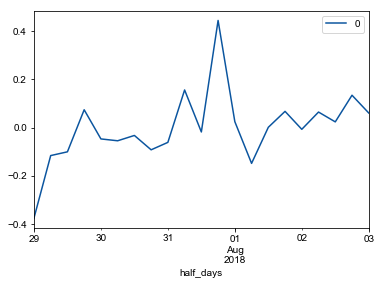

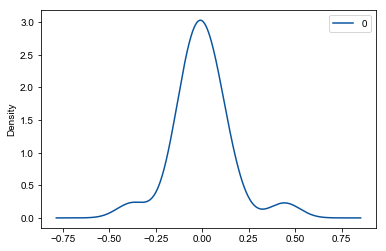

               0
count  21.000000
mean   -0.000363
std     0.152163
min    -0.375180
25%    -0.061447
50%    -0.007351
75%     0.064123
max     0.443590
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  12.088
Method:                       css-mle   S.D. of innovations              0.127
Date:                Sat, 18 Aug 2018   AIC                            -16.177
Time:                        22:16:15   BIC                            -11.999
Sample:                    07-29-2018   HQIC                           -15.270
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.5353      

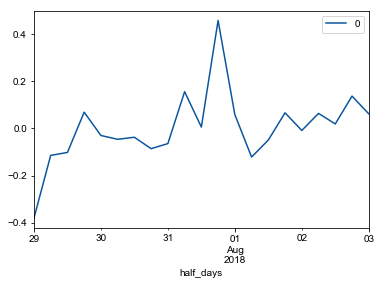

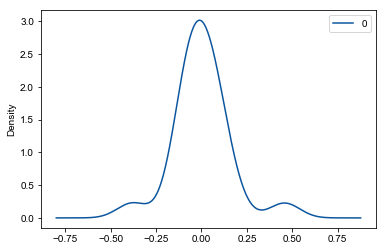

               0
count  21.000000
mean    0.002719
std     0.154038
min    -0.380195
25%    -0.064272
50%    -0.008624
75%     0.063841
max     0.457870
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                  12.357
Method:                       css-mle   S.D. of innovations              0.125
Date:                Sat, 18 Aug 2018   AIC                            -14.715
Time:                        22:16:16   BIC                             -9.492
Sample:                    07-29-2018   HQIC                           -13.581
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.5298      

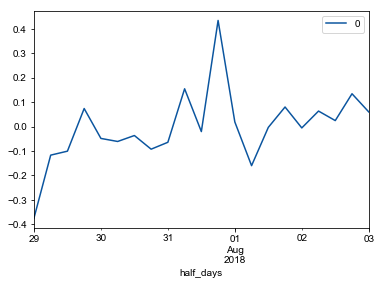

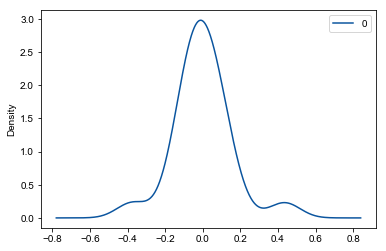

               0
count  21.000000
mean   -0.001537
std     0.152034
min    -0.374669
25%    -0.063983
50%    -0.005109
75%     0.063887
max     0.435196
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  12.938
Method:                       css-mle   S.D. of innovations              0.125
Date:                Sat, 18 Aug 2018   AIC                            -17.875
Time:                        22:16:16   BIC                            -13.892
Sample:                    07-29-2018   HQIC                           -17.098
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0463

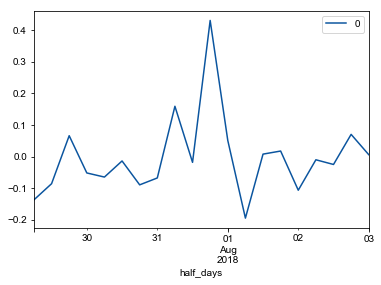

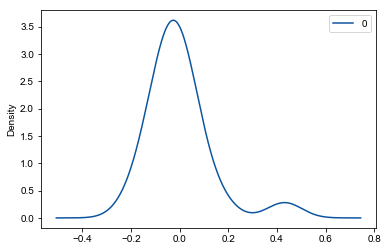

               0
count  20.000000
mean   -0.002624
std     0.129635
min    -0.194589
25%    -0.072035
50%    -0.015878
75%     0.026122
max     0.431071


In [190]:
# Select params

arima_analysis(presales_yes, (1,1,0))
arima_analysis(presales_yes, (0,1,1))
arima_analysis(presales_yes, (1,1,1))
arima_analysis(presales_yes, (1,0,2))
arima_analysis(presales_yes, (1,0,1))
arima_analysis(presales_yes, (2,0,1))
arima_analysis(presales_yes, (2,1,0))

In [191]:
# Update DF with new values

model = ARIMA(presales_yes,(1,0,1)).fit(disp=0)

ARIMA_models.loc[('presales',1)] = ((1,0,1), presales_yes, -23.617, transform_value)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


#### Presales - No

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


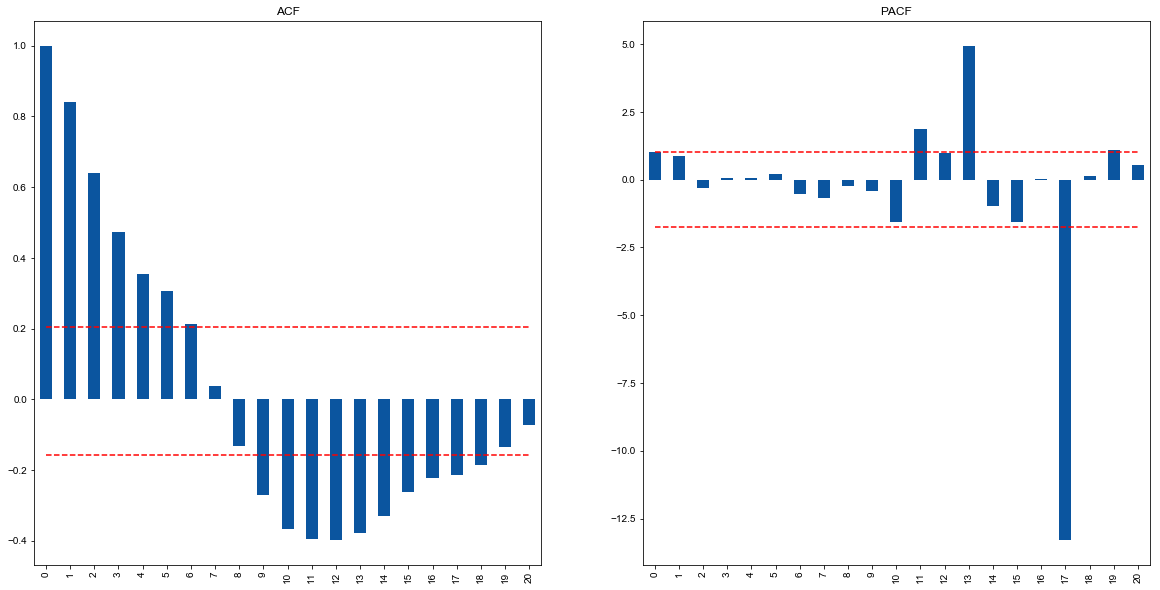

In [192]:
## Analyze no presales

presales_no = grouped_upsample('presales', 0)
presales_no, transform_value = log_transform(presales_no.unified_metric)
plot_acf(presales_no, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


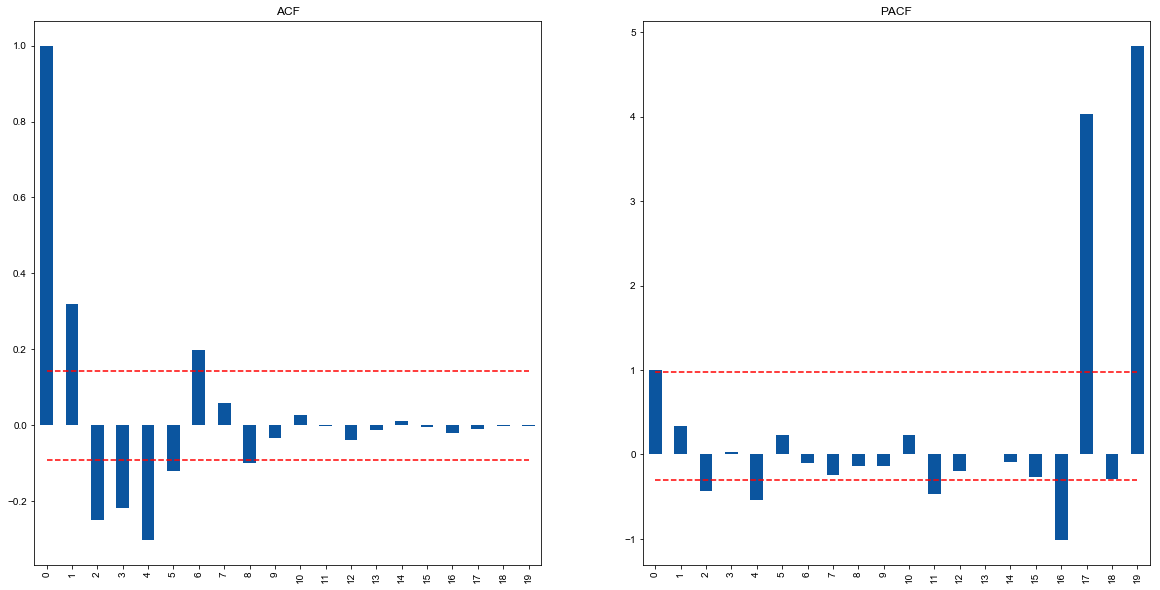

In [193]:
# Update differencing and replot residuals

lag1 = ARIMA(presales_no,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  13.629
Method:                       css-mle   S.D. of innovations              0.122
Date:                Sat, 18 Aug 2018   AIC                            -21.257
Time:                        22:16:18   BIC                            -18.270
Sample:                    07-29-2018   HQIC                           -20.674
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0446      0.038      1.162      0.261      -0.031       0.120
ar.L1.D.unified_metric     0.3040      0.206      1.474      0.158      -0.100       0.708
    

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


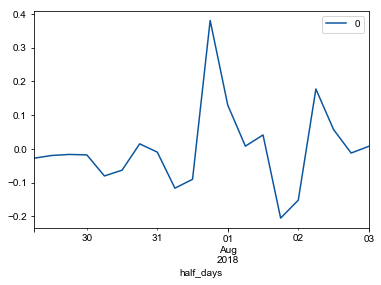

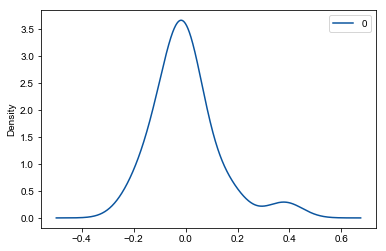

               0
count  20.000000
mean    0.000420
std     0.125302
min    -0.205249
25%    -0.067377
50%    -0.014313
75%     0.021683
max     0.381067
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  15.180
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sat, 18 Aug 2018   AIC                            -24.360
Time:                        22:16:18   BIC                            -21.372
Sample:                    07-29-2018   HQIC                           -23.776
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0443

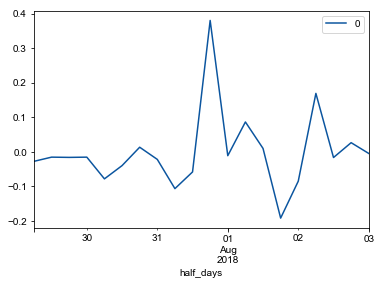

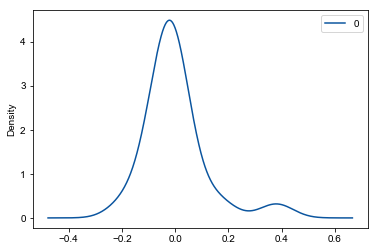

               0
count  20.000000
mean    0.000113
std     0.114742
min    -0.191462
25%    -0.044185
50%    -0.015483
75%     0.010971
max     0.380236
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 2)   Log Likelihood                  14.657
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sat, 18 Aug 2018   AIC                            -19.313
Time:                        22:16:19   BIC                            -14.091
Sample:                    07-29-2018   HQIC                           -18.180
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.3663      

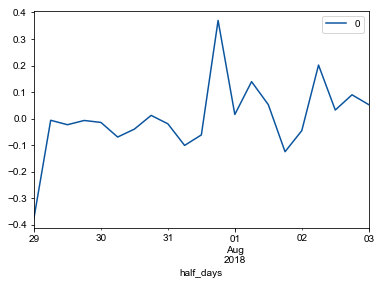

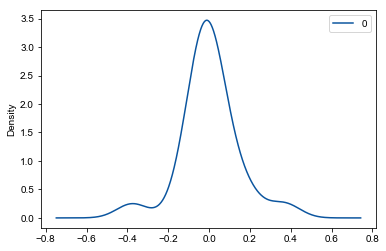

               0
count  21.000000
mean    0.003469
std     0.140036
min    -0.375611
25%    -0.045728
50%    -0.007340
75%     0.052349
max     0.369958
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  14.655
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sat, 18 Aug 2018   AIC                            -21.311
Time:                        22:16:19   BIC                            -17.133
Sample:                    07-29-2018   HQIC                           -20.404
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.3656      

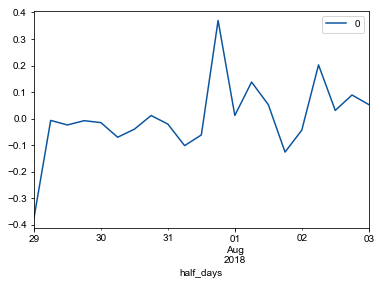

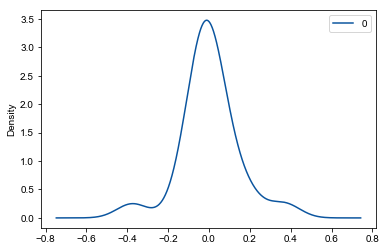

               0
count  21.000000
mean    0.003225
std     0.139959
min    -0.374966
25%    -0.043424
50%    -0.007717
75%     0.052750
max     0.370017
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                  14.657
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sat, 18 Aug 2018   AIC                            -19.313
Time:                        22:16:20   BIC                            -14.090
Sample:                    07-29-2018   HQIC                           -18.180
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.3662      

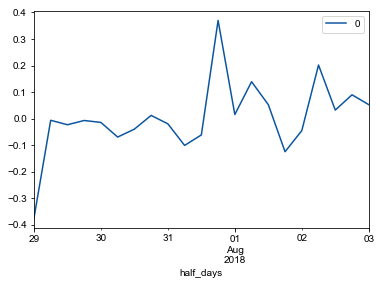

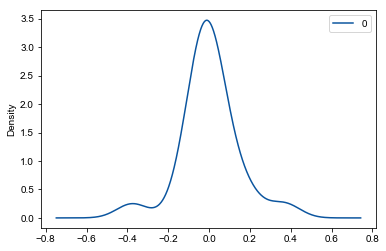

               0
count  21.000000
mean    0.003448
std     0.140029
min    -0.375551
25%    -0.045573
50%    -0.007374
75%     0.052360
max     0.369967
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  15.138
Method:                       css-mle   S.D. of innovations              0.112
Date:                Sat, 18 Aug 2018   AIC                            -22.277
Time:                        22:16:20   BIC                            -18.294
Sample:                    07-29-2018   HQIC                           -21.499
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0451

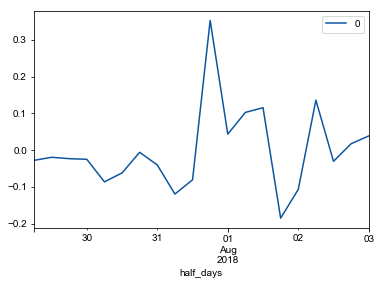

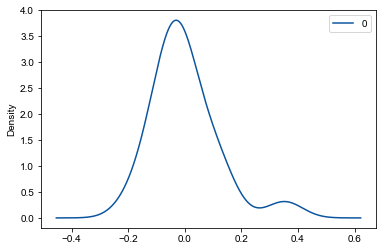

               0
count  20.000000
mean   -0.000572
std     0.115421
min    -0.185191
25%    -0.066933
50%    -0.024331
75%     0.039556
max     0.352527


In [194]:
# Select params

arima_analysis(presales_no, (1,1,0))
arima_analysis(presales_no, (0,1,1))
arima_analysis(presales_no, (1,0,2))
arima_analysis(presales_no, (1,0,1))
arima_analysis(presales_no, (2,0,1))
arima_analysis(presales_no, (2,1,0))

In [195]:
# Update DF with new values

model = ARIMA(presales_no,(0,1,1)).fit(disp=0)

ARIMA_models.loc[('presales',0)] = ((0,1,1), presales_no, -36.764, transform_value)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


## 4. City Size

#### City Size - Small

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


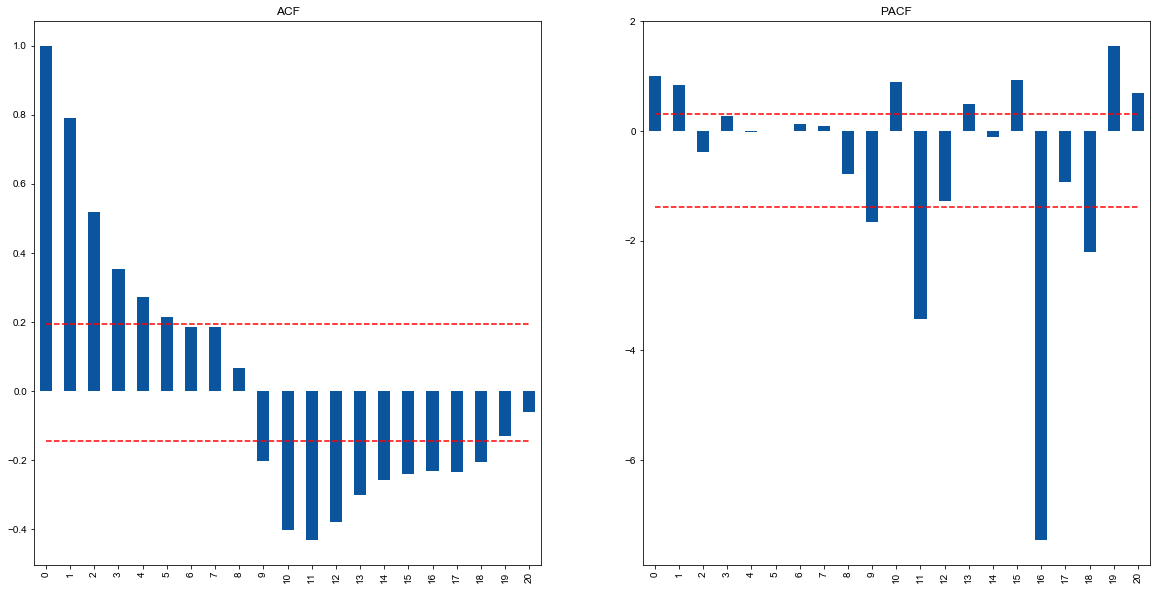

In [196]:
## Analyze small cities

small = grouped_upsample('citySize', 'small')
small, transform_value = log_transform(small.unified_metric)
plot_acf(small, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


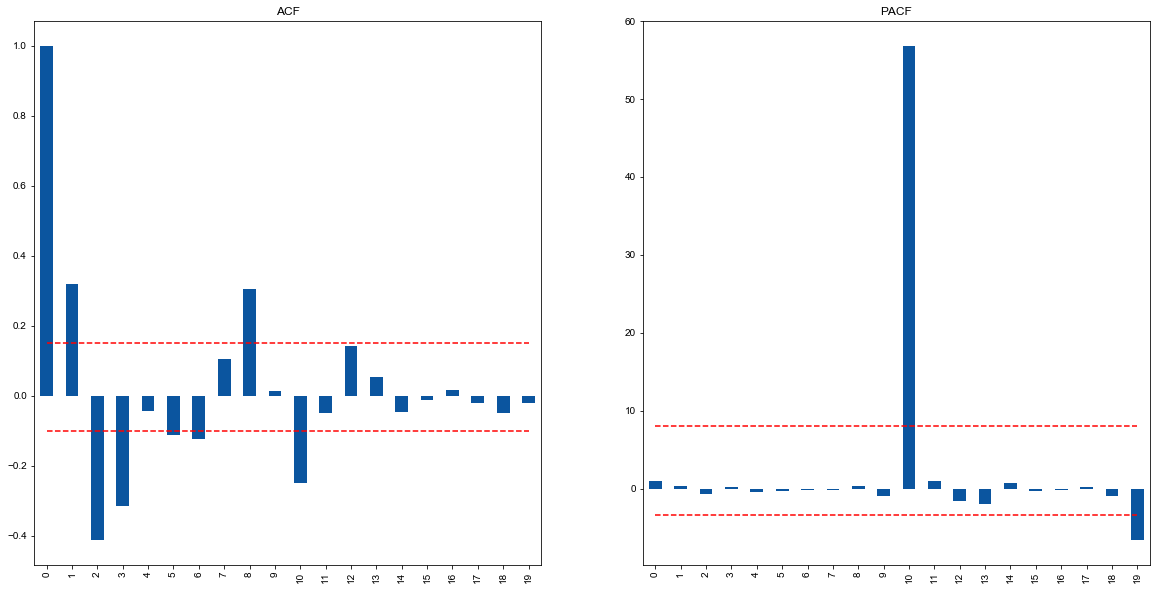

In [197]:
# Update differencing and replot residuals

lag1 = ARIMA(small,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   7.566
Method:                       css-mle   S.D. of innovations              0.165
Date:                Sat, 18 Aug 2018   AIC                             -9.131
Time:                        22:16:22   BIC                             -6.144
Sample:                    07-29-2018   HQIC                            -8.548
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0433      0.053      0.816      0.425      -0.061       0.147
ar.L1.D.unified_metric     0.3196      0.210      1.523      0.145      -0.092       0.731
    

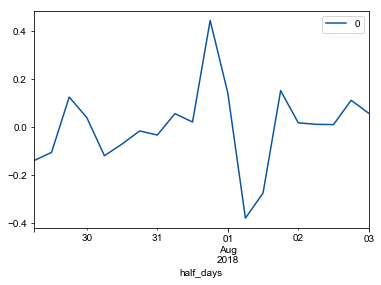

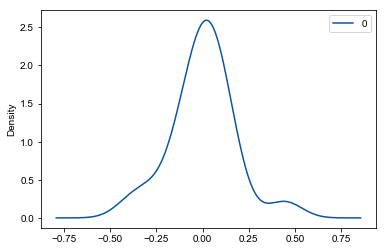

               0
count  20.000000
mean    0.002237
std     0.169902
min    -0.379588
25%    -0.079540
50%     0.014419
75%     0.070746
max     0.443982
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   9.791
Method:                       css-mle   S.D. of innovations              0.146
Date:                Sat, 18 Aug 2018   AIC                            -13.582
Time:                        22:16:22   BIC                            -10.595
Sample:                    07-29-2018   HQIC                           -12.999
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0437

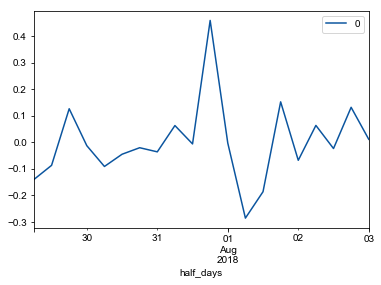

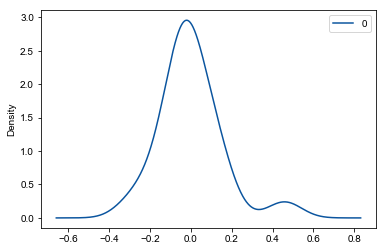

               0
count  20.000000
mean   -0.000218
std     0.151458
min    -0.285898
25%    -0.072900
50%    -0.016985
75%     0.062772
max     0.458477
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   9.793
Method:                       css-mle   S.D. of innovations              0.146
Date:                Sat, 18 Aug 2018   AIC                            -11.585
Time:                        22:16:23   BIC                             -7.602
Sample:                    07-29-2018   HQIC                           -10.808
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0437

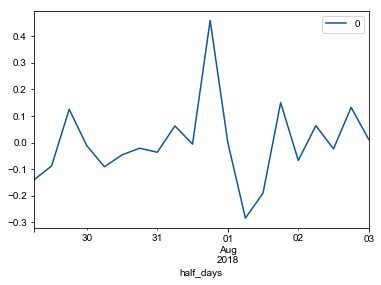

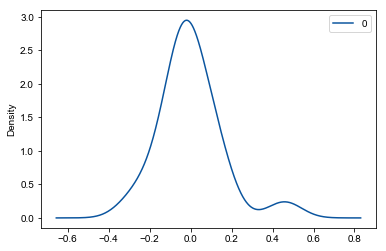

               0
count  20.000000
mean   -0.000241
std     0.151455
min    -0.284151
25%    -0.072474
50%    -0.016651
75%     0.062549
max     0.458706
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                   9.887
Method:                       css-mle   S.D. of innovations              0.142
Date:                Sat, 18 Aug 2018   AIC                            -11.775
Time:                        22:16:23   BIC                             -7.597
Sample:                    07-29-2018   HQIC                           -10.868
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6329      

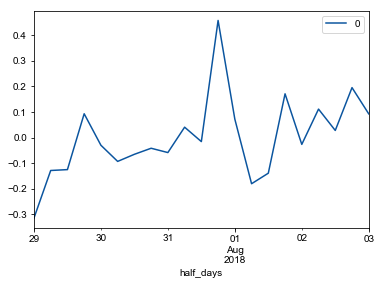

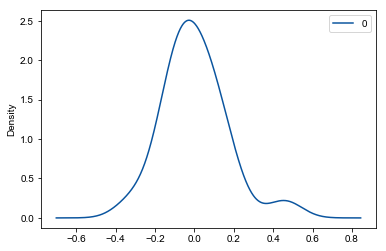

               0
count  21.000000
mean    0.001863
std     0.160948
min    -0.315176
25%    -0.093348
50%    -0.026779
75%     0.092579
max     0.457992
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                  10.072
Method:                       css-mle   S.D. of innovations              0.141
Date:                Sat, 18 Aug 2018   AIC                            -10.144
Time:                        22:16:24   BIC                             -4.922
Sample:                    07-29-2018   HQIC                            -9.011
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6234      

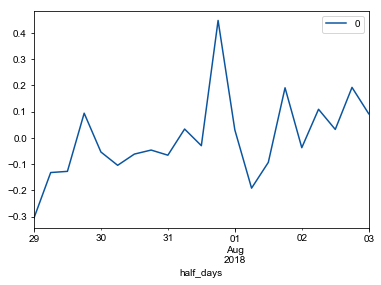

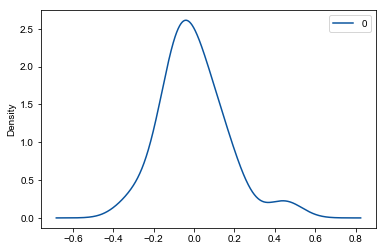

               0
count  21.000000
mean   -0.001070
std     0.158970
min    -0.305648
25%    -0.093151
50%    -0.037105
75%     0.092120
max     0.447992
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  11.383
Method:                       css-mle   S.D. of innovations              0.134
Date:                Sat, 18 Aug 2018   AIC                            -14.766
Time:                        22:16:24   BIC                            -10.783
Sample:                    07-29-2018   HQIC                           -13.989
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0455

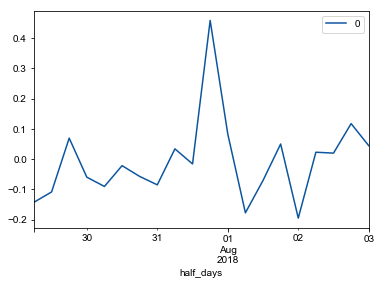

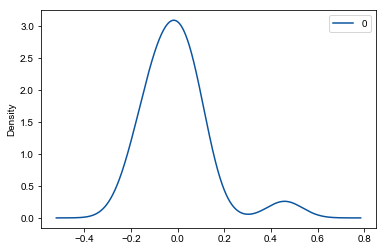

               0
count  20.000000
mean   -0.005971
std     0.139585
min    -0.194548
25%    -0.086036
50%    -0.018426
75%     0.046073
max     0.458237


In [198]:
# Select params

arima_analysis(small, (1,1,0))
arima_analysis(small, (0,1,1))
arima_analysis(small, (1,1,1))
arima_analysis(small, (1,0,1))
arima_analysis(small, (2,0,1))
arima_analysis(small, (2,1,0))

In [199]:
# Update DF with new values

ARIMA_models.loc[('citySize','small')] = ((1,1,0), small, -18.085, transform_value)

#### City Size - Medium

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


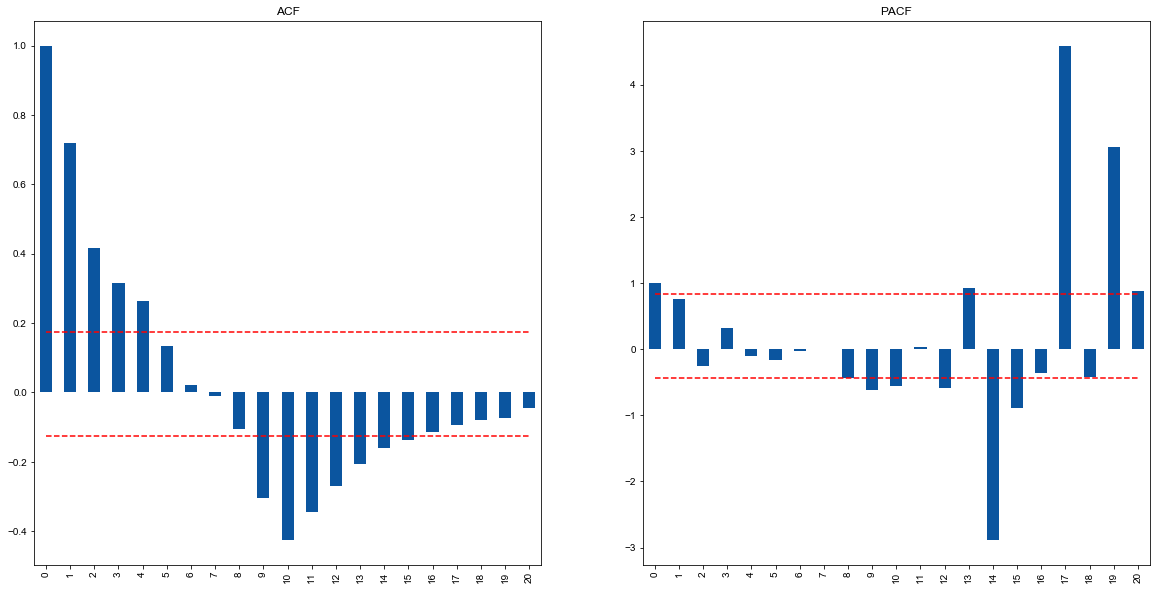

In [200]:
## Analyze medium cities

medium = grouped_upsample('citySize', 'medium')
medium, transform_value = log_transform(medium.unified_metric)
plot_acf(medium, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


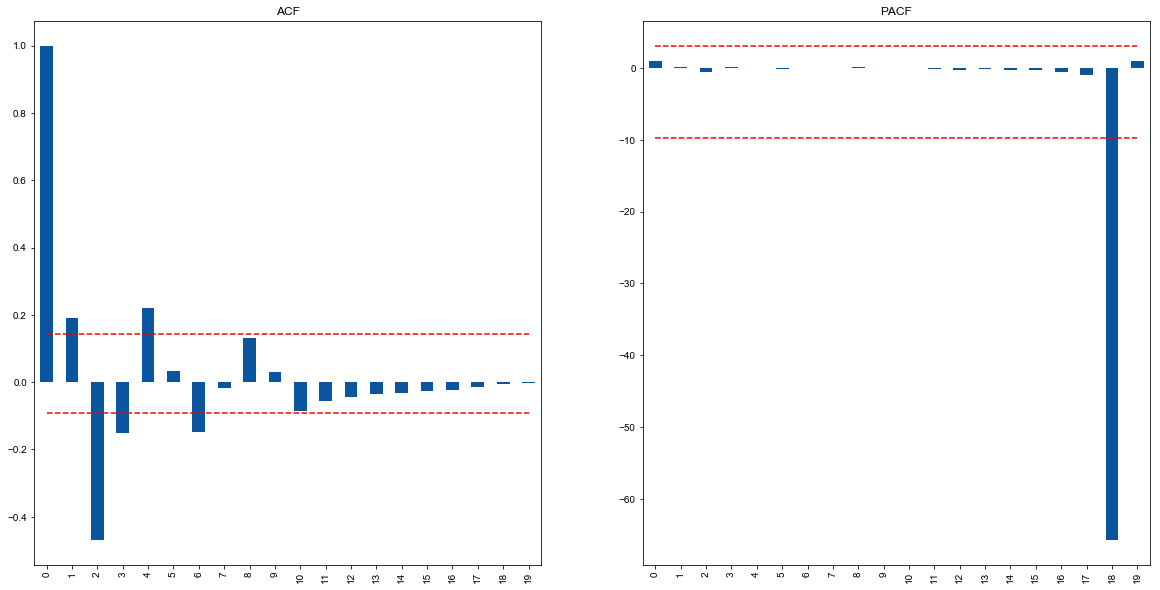

In [201]:
# Update differencing and replot residuals

lag1 = ARIMA(medium,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   3.787
Method:                       css-mle   S.D. of innovations              0.200
Date:                Sat, 18 Aug 2018   AIC                             -1.574
Time:                        22:16:26   BIC                              1.413
Sample:                    07-29-2018   HQIC                            -0.991
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0466      0.054      0.859      0.402      -0.060       0.153
ar.L1.D.unified_metric     0.1841      0.216      0.853      0.405      -0.239       0.607
    

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


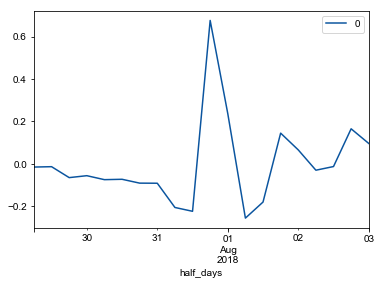

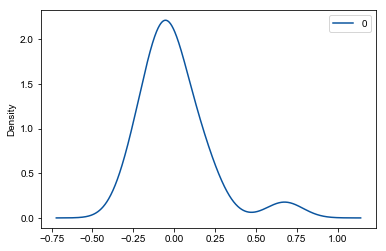

               0
count  20.000000
mean    0.000137
std     0.205255
min    -0.255443
25%    -0.090754
50%    -0.042630
75%     0.073529
max     0.675898
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                   4.953
Method:                       css-mle   S.D. of innovations              0.187
Date:                Sat, 18 Aug 2018   AIC                             -3.906
Time:                        22:16:26   BIC                             -0.918
Sample:                    07-29-2018   HQIC                            -3.322
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0459

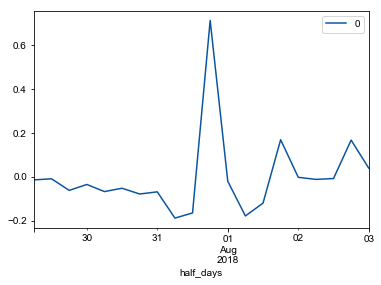

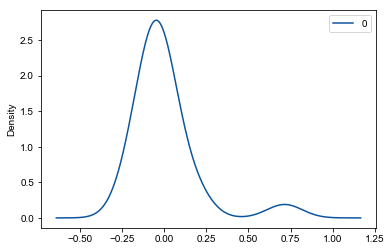

               0
count  20.000000
mean    0.000240
std     0.192272
min    -0.188934
25%    -0.071336
50%    -0.027970
75%    -0.006643
max     0.714337
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   5.196
Method:                       css-mle   S.D. of innovations              0.185
Date:                Sat, 18 Aug 2018   AIC                             -2.391
Time:                        22:16:26   BIC                              1.592
Sample:                    07-29-2018   HQIC                            -1.614
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0452

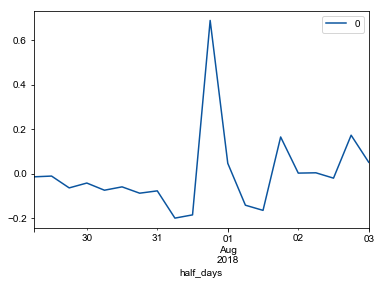

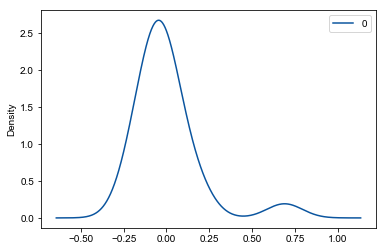

               0
count  20.000000
mean    0.000127
std     0.190140
min    -0.199080
25%    -0.079207
50%    -0.030447
75%     0.015227
max     0.689340
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                   5.501
Method:                       css-mle   S.D. of innovations              0.178
Date:                Sat, 18 Aug 2018   AIC                             -3.002
Time:                        22:16:27   BIC                              1.176
Sample:                    07-29-2018   HQIC                            -2.095
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6655      

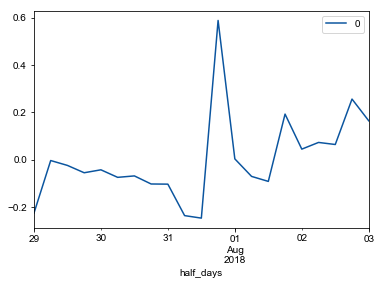

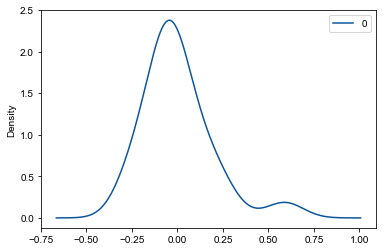

               0
count  21.000000
mean    0.002390
std     0.187825
min    -0.246433
25%    -0.091267
50%    -0.042298
75%     0.064669
max     0.588899


In [202]:
# Select params

arima_analysis(medium, (1,1,0))
arima_analysis(medium, (0,1,1))
arima_analysis(medium, (1,1,1))
arima_analysis(medium, (1,0,1))

In [203]:
# Update DF with new values

ARIMA_models.loc[('citySize','medium')] = ((1,0,1), medium, -8.690, transform_value)

#### City Size - Large

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


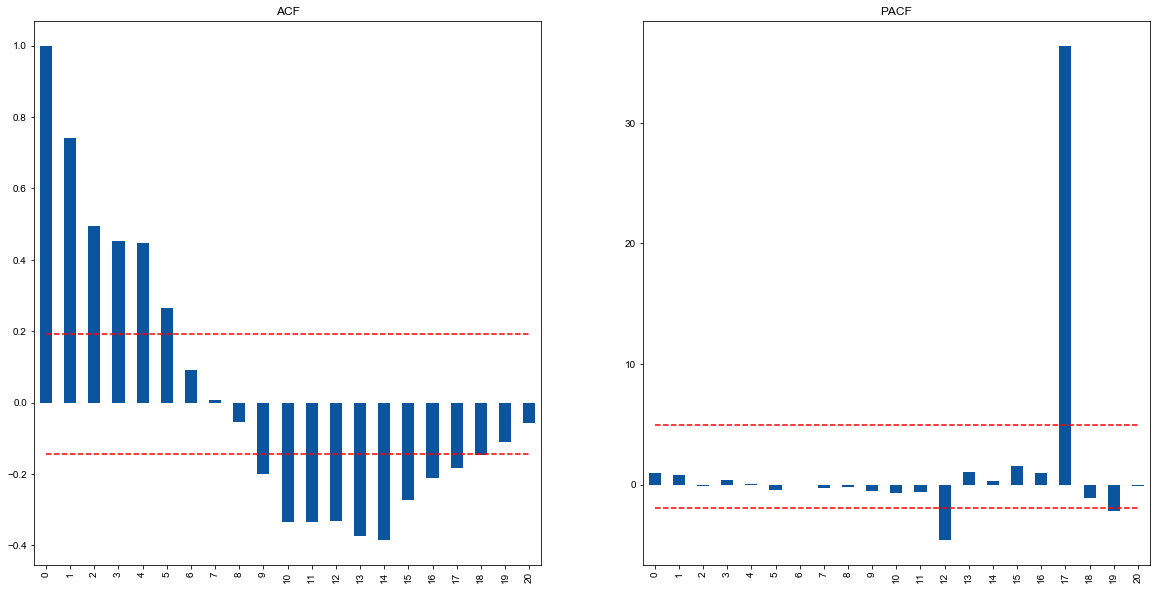

In [204]:
## Analyze large cities

large = grouped_upsample('citySize', 'large')
large, transform_value = log_transform(large.unified_metric)
plot_acf(large, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


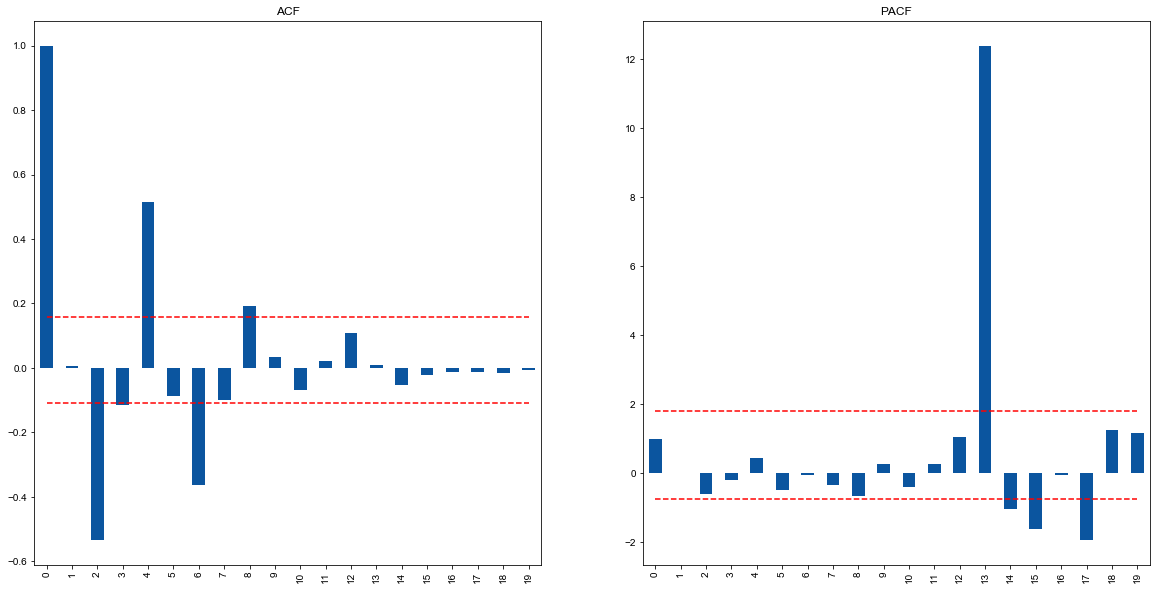

In [205]:
# Update differencing and replot residuals

lag1 = ARIMA(large,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -17.730
Method:                       css-mle   S.D. of innovations              0.587
Date:                Sat, 18 Aug 2018   AIC                             41.461
Time:                        22:16:29   BIC                             44.448
Sample:                    07-29-2018   HQIC                            42.044
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1196      0.132      0.907      0.377      -0.139       0.378
ar.L1.D.unified_metric     0.0052      0.219      0.024      0.981      -0.425       0.435
    

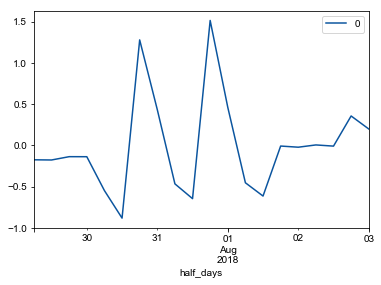

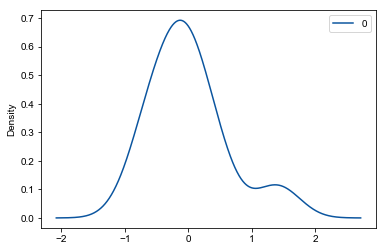

               0
count  20.000000
mean    0.000045
std     0.602434
min    -0.880679
25%    -0.455377
50%    -0.078139
75%     0.239702
max     1.516417
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -17.720
Method:                       css-mle   S.D. of innovations              0.587
Date:                Sat, 18 Aug 2018   AIC                             41.440
Time:                        22:16:29   BIC                             44.427
Sample:                    07-29-2018   HQIC                            42.023
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1197

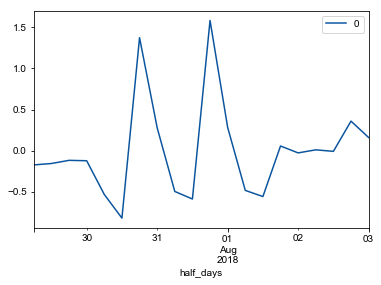

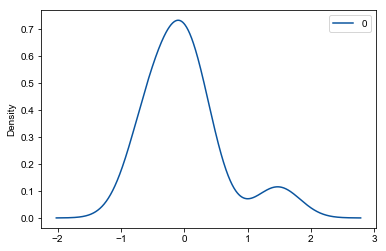

               0
count  20.000000
mean    0.000806
std     0.601928
min    -0.820259
25%    -0.486423
50%    -0.072715
75%     0.189213
max     1.582843
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -15.798
Method:                       css-mle   S.D. of innovations              0.507
Date:                Sat, 18 Aug 2018   AIC                             39.596
Time:                        22:16:29   BIC                             43.579
Sample:                    07-29-2018   HQIC                            40.373
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1320

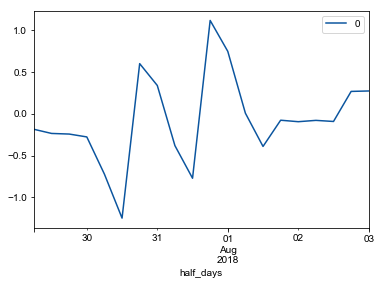

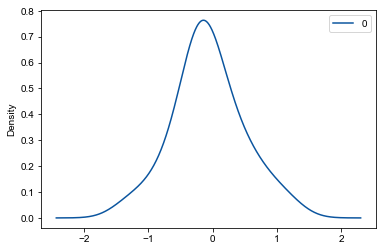

               0
count  20.000000
mean   -0.072537
std     0.540721
min    -1.249179
25%    -0.303269
50%    -0.093517
75%     0.268960
max     1.117240
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                 -18.227
Method:                       css-mle   S.D. of innovations              0.559
Date:                Sat, 18 Aug 2018   AIC                             44.454
Time:                        22:16:30   BIC                             48.632
Sample:                    07-29-2018   HQIC                            45.360
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.9580      

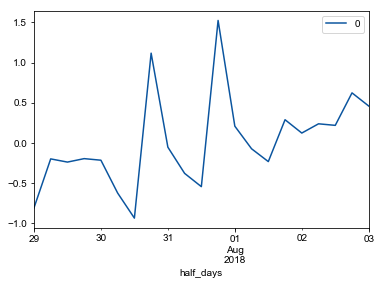

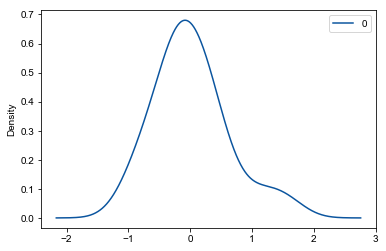

               0
count  21.000000
mean    0.014704
std     0.592192
min    -0.935449
25%    -0.238146
50%    -0.072481
75%     0.238151
max     1.524591
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                 -18.182
Method:                       css-mle   S.D. of innovations              0.558
Date:                Sat, 18 Aug 2018   AIC                             46.364
Time:                        22:16:30   BIC                             51.587
Sample:                    07-29-2018   HQIC                            47.497
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.9689      

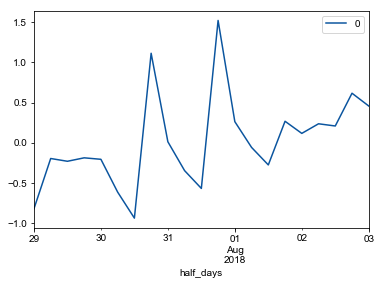

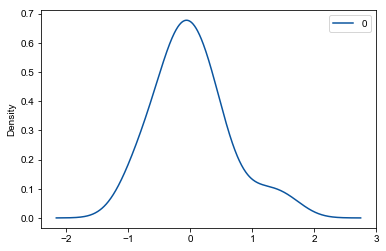

               0
count  21.000000
mean    0.018413
std     0.591559
min    -0.935866
25%    -0.274725
50%    -0.057088
75%     0.263109
max     1.520973


In [206]:
# Select params

arima_analysis(large, (1,1,0))
arima_analysis(large, (0,1,1))
arima_analysis(large, (1,1,1))
arima_analysis(large, (1,0,1))
arima_analysis(large, (2,0,1))

In [207]:
# Update DF with new values

ARIMA_models.loc[('citySize','large')] = ((1,1,1), rock, 31.884, transform_value)

#### City Size - Very Large

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


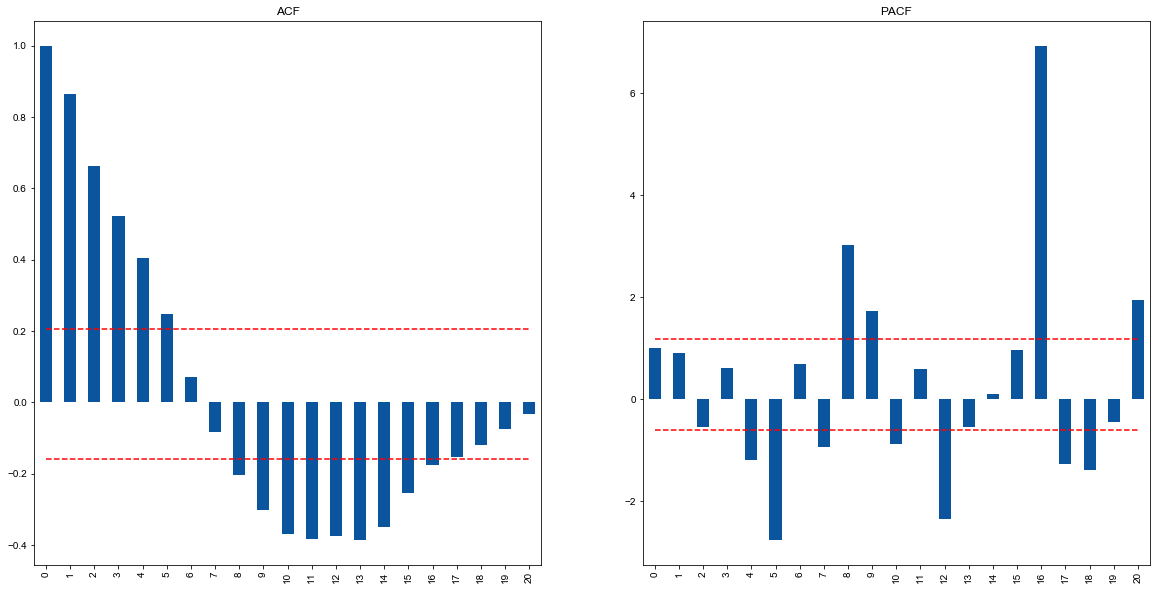

In [208]:
## Analyze very large cities

vlarge= grouped_upsample('citySize', 'very large')
vlarge, transform_value = log_transform(vlarge.unified_metric)
plot_acf(vlarge, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


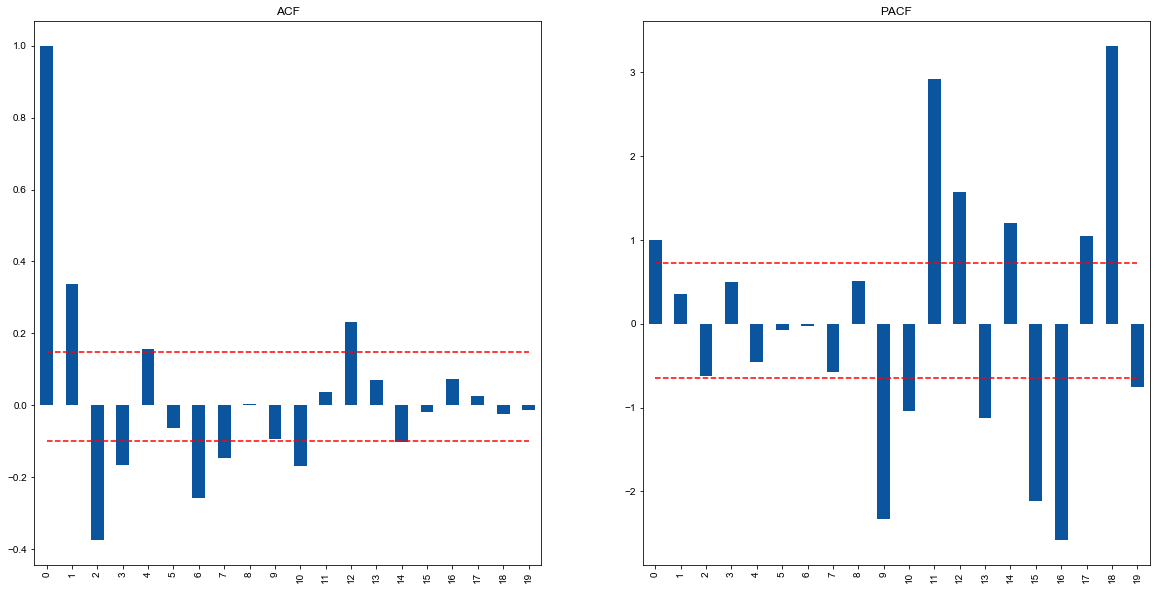

In [209]:
# Update differencing and replot residuals

lag1 = ARIMA(vlarge,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   8.879
Method:                       css-mle   S.D. of innovations              0.155
Date:                Sat, 18 Aug 2018   AIC                            -11.758
Time:                        22:16:32   BIC                             -8.770
Sample:                    07-29-2018   HQIC                           -11.175
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0297      0.051      0.583      0.567      -0.070       0.129
ar.L1.D.unified_metric     0.3364      0.208      1.616      0.123      -0.072       0.744
    

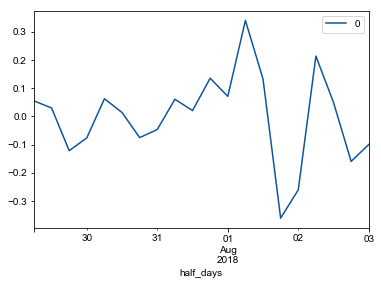

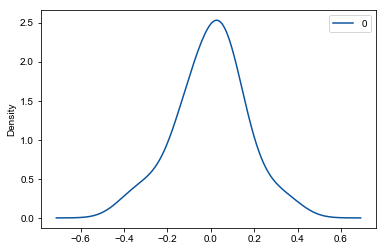

               0
count  20.000000
mean   -0.000921
std     0.158834
min    -0.361092
25%    -0.082178
50%     0.025116
75%     0.064514
max     0.340255
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  11.740
Method:                       css-mle   S.D. of innovations              0.132
Date:                Sat, 18 Aug 2018   AIC                            -17.480
Time:                        22:16:33   BIC                            -14.493
Sample:                    07-29-2018   HQIC                           -16.897
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0295

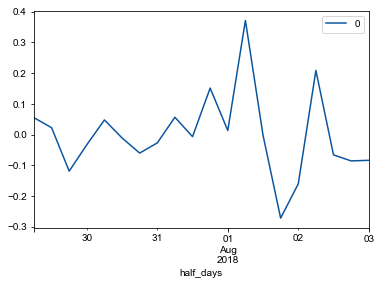

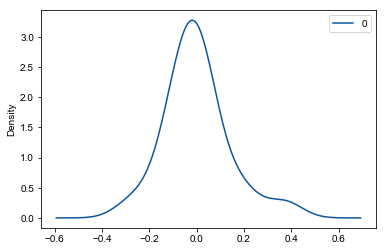

               0
count  20.000000
mean   -0.000004
std     0.136070
min    -0.271865
25%    -0.070480
50%    -0.008809
75%     0.049499
max     0.371492
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  10.203
Method:                       css-mle   S.D. of innovations              0.137
Date:                Sat, 18 Aug 2018   AIC                            -12.407
Time:                        22:16:33   BIC                             -8.424
Sample:                    07-29-2018   HQIC                           -11.629
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0303

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


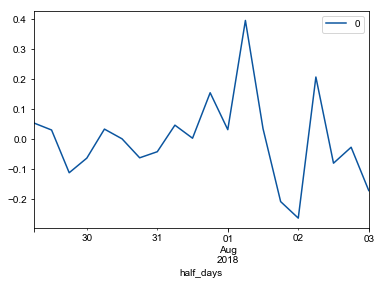

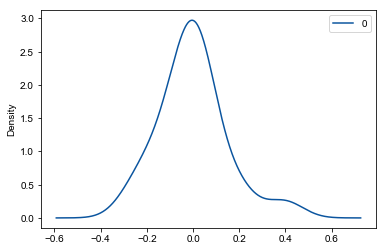

               0
count  20.000000
mean   -0.001398
std     0.145791
min    -0.262763
25%    -0.067044
50%     0.002503
75%     0.038349
max     0.396068
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  12.204
Method:                       css-mle   S.D. of innovations              0.127
Date:                Sat, 18 Aug 2018   AIC                            -16.407
Time:                        22:16:34   BIC                            -12.229
Sample:                    07-29-2018   HQIC                           -15.501
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.7328      

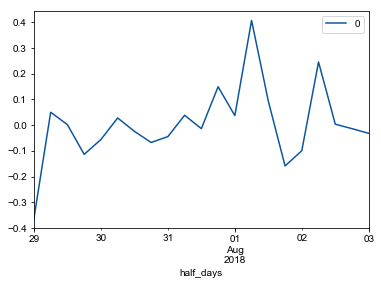

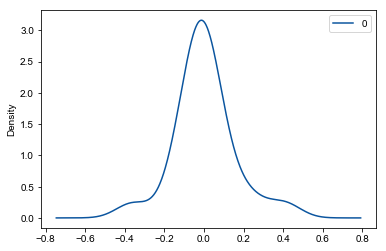

               0
count  21.000000
mean    0.003228
std     0.150533
min    -0.361566
25%    -0.056055
50%    -0.013725
75%     0.038314
max     0.406889


In [210]:
# Select params

arima_analysis(vlarge, (1,1,0))
arima_analysis(vlarge, (0,1,1))
arima_analysis(vlarge, (1,1,1))
arima_analysis(vlarge, (1,0,1))

In [211]:
# Update DF with new values

ARIMA_models.loc[('citySize','very large')] = ((0,1,1), vlarge, -41.982, transform_value)

## 5. Upcoming Events

#### Upcoming Events - Few

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


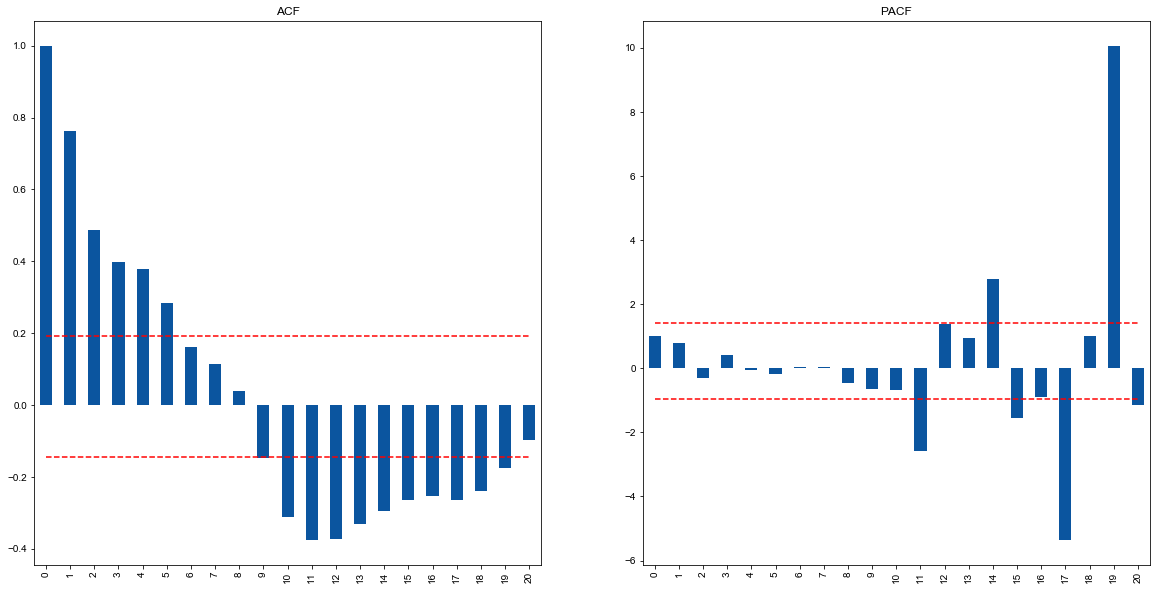

In [212]:
## Analyze few upcoming events

few = grouped_upsample('upcomingEvents', 'few')
few, transform_value = log_transform(few.unified_metric)
plot_acf(few, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


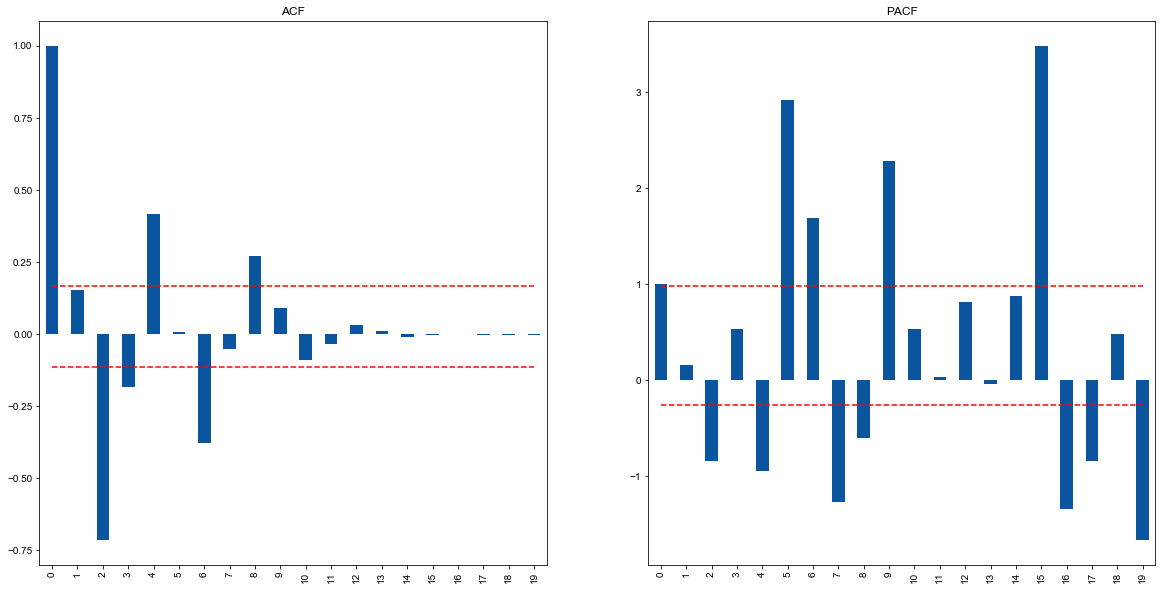

In [213]:
# Update differencing and replot residuals

lag1 = ARIMA(few,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  14.979
Method:                       css-mle   S.D. of innovations              0.114
Date:                Sat, 18 Aug 2018   AIC                            -23.959
Time:                        22:16:35   BIC                            -20.972
Sample:                    07-29-2018   HQIC                           -23.376
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0317      0.030      1.068      0.300      -0.026       0.090
ar.L1.D.unified_metric     0.1454      0.216      0.674      0.509      -0.278       0.568
    

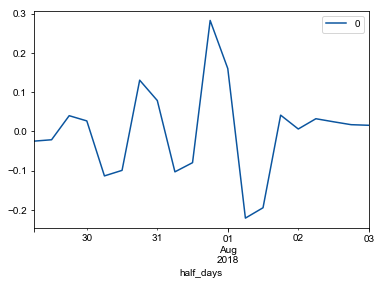

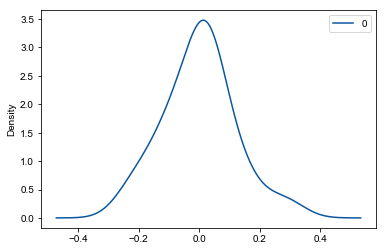

               0
count  20.000000
mean    0.000178
std     0.117328
min    -0.220335
25%    -0.084202
50%     0.016566
75%     0.040540
max     0.282473
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  18.179
Method:                       css-mle   S.D. of innovations              0.096
Date:                Sat, 18 Aug 2018   AIC                            -30.357
Time:                        22:16:36   BIC                            -27.370
Sample:                    07-29-2018   HQIC                           -29.774
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0316

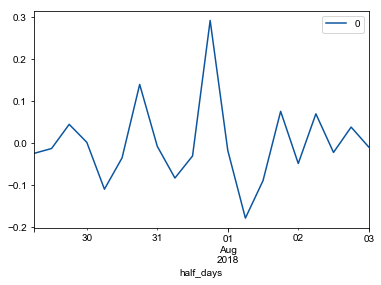

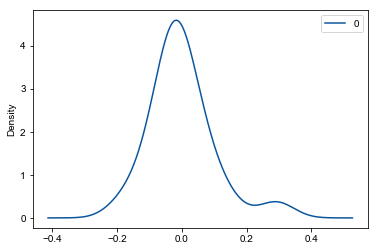

               0
count  20.000000
mean   -0.000296
std     0.098295
min    -0.178343
25%    -0.038394
50%    -0.015073
75%     0.039784
max     0.291850
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  18.292
Method:                       css-mle   S.D. of innovations              0.095
Date:                Sat, 18 Aug 2018   AIC                            -28.584
Time:                        22:16:36   BIC                            -24.601
Sample:                    07-29-2018   HQIC                           -27.807
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0316

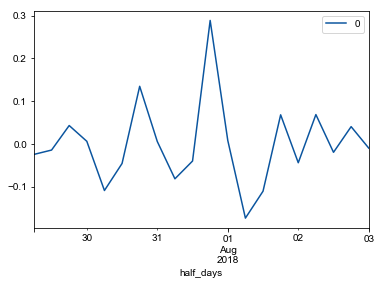

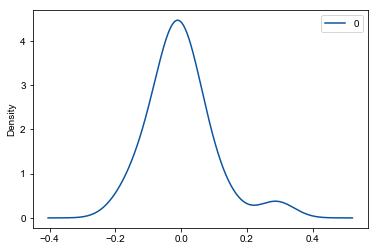

               0
count  20.000000
mean   -0.000353
std     0.097942
min    -0.173398
25%    -0.044335
50%    -0.011976
75%     0.041148
max     0.288873
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  17.440
Method:                       css-mle   S.D. of innovations              0.094
Date:                Sat, 18 Aug 2018   AIC                            -26.880
Time:                        22:16:37   BIC                            -22.702
Sample:                    07-29-2018   HQIC                           -25.973
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    6.4138      

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Albert/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


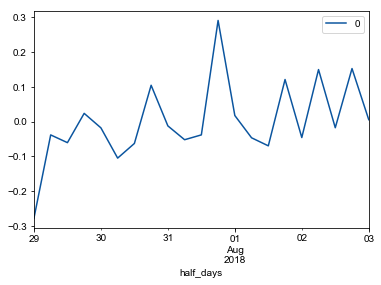

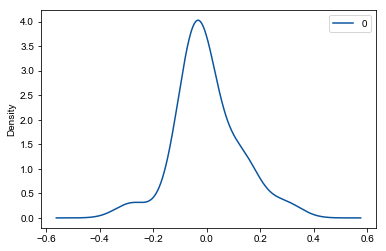

               0
count  21.000000
mean    0.001090
std     0.115812
min    -0.277594
25%    -0.052040
50%    -0.017913
75%     0.023812
max     0.291166


In [214]:
# Select params

arima_analysis(few, (1,1,0))
arima_analysis(few, (0,1,1))
arima_analysis(few, (1,1,1))
arima_analysis(few, (1,0,1))

In [215]:
# Update DF with new values

ARIMA_models.loc[('upcomingEvents','few')] = ((0,1,1), few, -40.364, transform_value)

#### Upcoming Events - Some

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


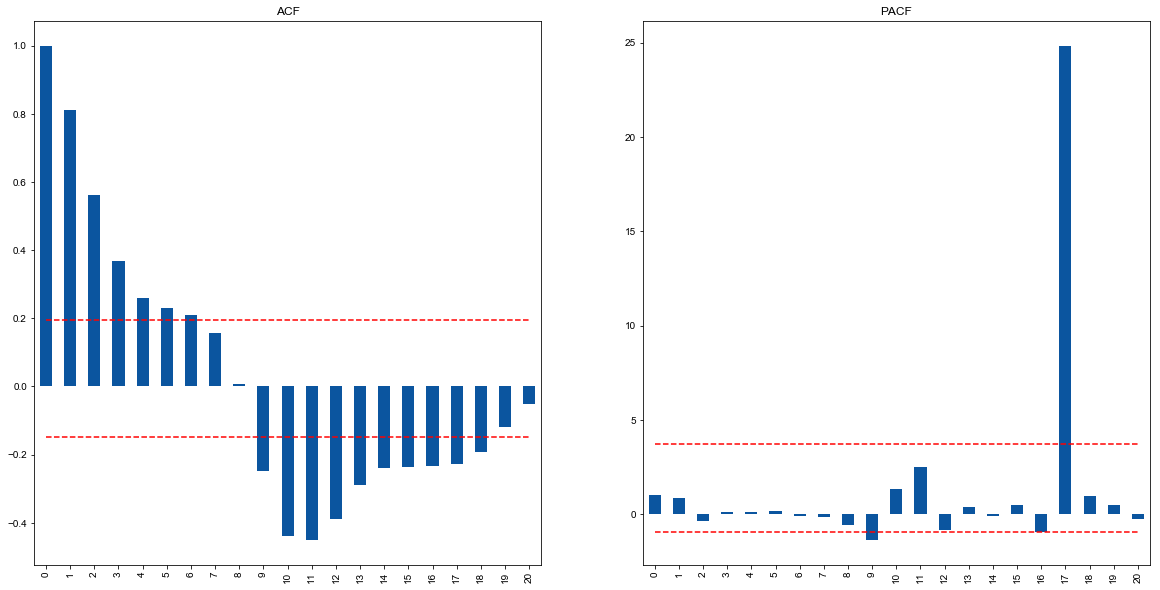

In [216]:
## Analyze some upcoming events

some = grouped_upsample('upcomingEvents', 'some')
some, transform_value = log_transform(some.unified_metric)
plot_acf(some, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


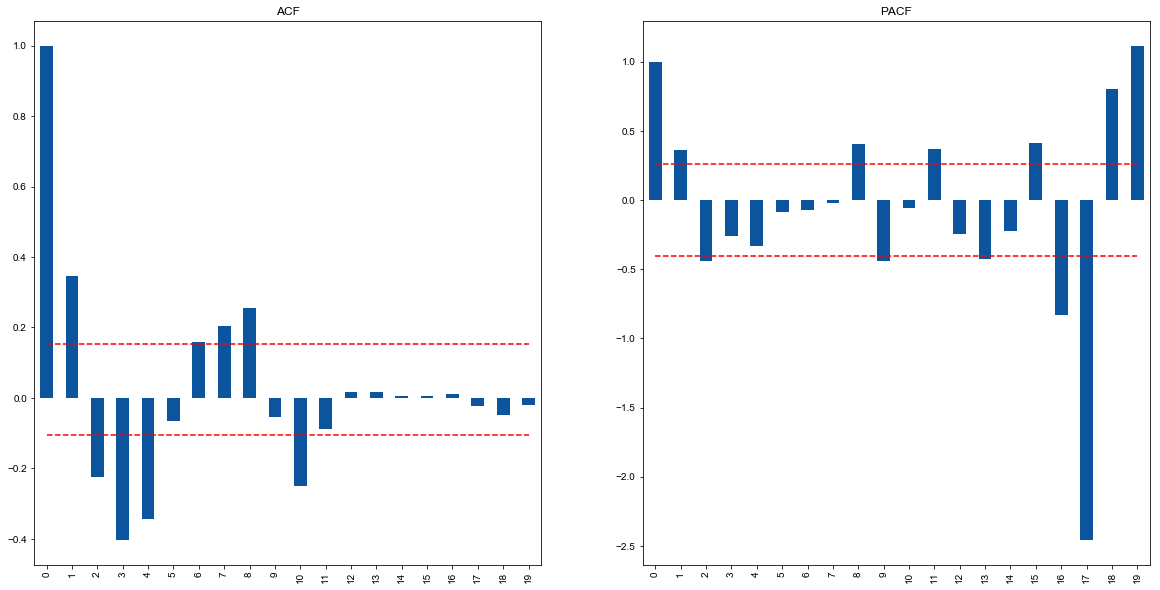

In [217]:
# Update differencing and replot residuals

lag1 = ARIMA(some,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -1.017
Method:                       css-mle   S.D. of innovations              0.254
Date:                Sat, 18 Aug 2018   AIC                              8.033
Time:                        22:16:39   BIC                             11.020
Sample:                    07-29-2018   HQIC                             8.616
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0704      0.085      0.833      0.416      -0.095       0.236
ar.L1.D.unified_metric     0.3454      0.207      1.665      0.113      -0.061       0.752
    

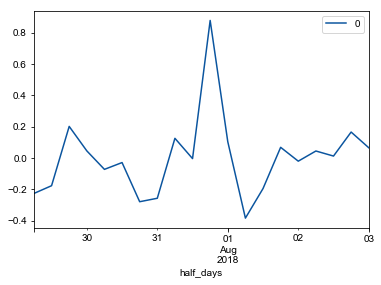

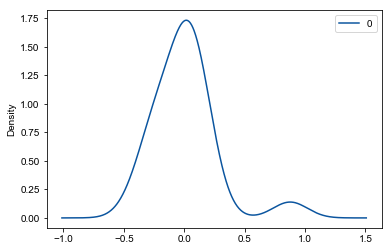

               0
count  20.000000
mean    0.003893
std     0.260955
min    -0.382788
25%    -0.180652
50%     0.004821
75%     0.077548
max     0.877563
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -0.283
Method:                       css-mle   S.D. of innovations              0.244
Date:                Sat, 18 Aug 2018   AIC                              6.567
Time:                        22:16:39   BIC                              9.554
Sample:                    07-29-2018   HQIC                             7.150
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0719

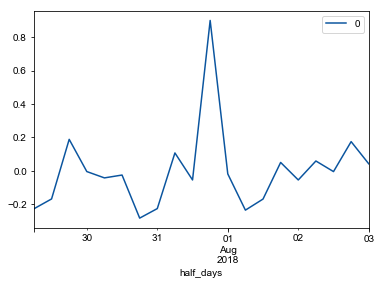

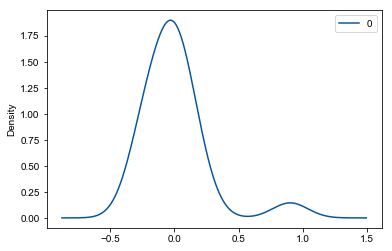

               0
count  20.000000
mean    0.000746
std     0.251355
min    -0.282878
25%    -0.168197
50%    -0.021513
75%     0.052743
max     0.900873
                              ARMA Model Results                              
Dep. Variable:         unified_metric   No. Observations:                   21
Model:                     ARMA(1, 1)   Log Likelihood                  -0.978
Method:                       css-mle   S.D. of innovations              0.240
Date:                Sat, 18 Aug 2018   AIC                              9.956
Time:                        22:16:39   BIC                             14.134
Sample:                    07-29-2018   HQIC                            10.862
                         - 08-03-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6653      

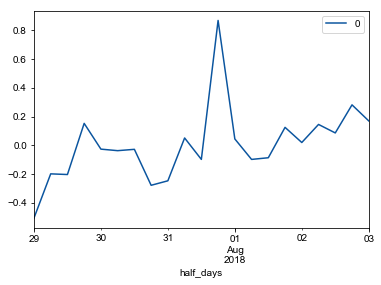

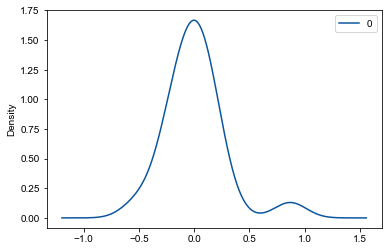

               0
count  21.000000
mean    0.005859
std     0.268591
min    -0.507747
25%    -0.098841
50%    -0.027267
75%     0.124414
max     0.869123
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                   1.948
Method:                       css-mle   S.D. of innovations              0.204
Date:                Sat, 18 Aug 2018   AIC                              6.103
Time:                        22:16:40   BIC                             11.082
Sample:                    07-29-2018   HQIC                             7.075
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0824

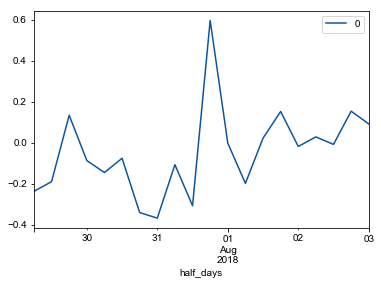

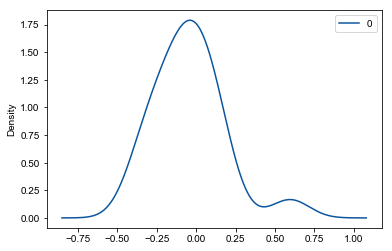

               0
count  20.000000
mean   -0.045383
std     0.219145
min    -0.367756
25%    -0.191996
50%    -0.047114
75%     0.044119
max     0.596101
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                   0.519
Method:                       css-mle   S.D. of innovations              0.233
Date:                Sat, 18 Aug 2018   AIC                              6.963
Time:                        22:16:40   BIC                             10.945
Sample:                    07-29-2018   HQIC                             7.740
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0743

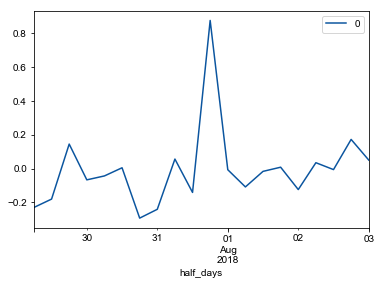

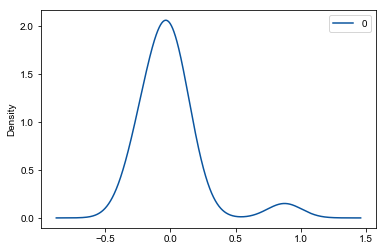

               0
count  20.000000
mean   -0.005205
std     0.241165
min    -0.292363
25%    -0.127945
50%    -0.011363
75%     0.038851
max     0.875332


In [218]:
# Select params

arima_analysis(some, (1,1,0))
arima_analysis(some, (0,1,1))
arima_analysis(some, (1,0,1))
arima_analysis(some, (2,1,1))
arima_analysis(some, (2,1,0))

In [219]:
# Update DF with new values

ARIMA_models.loc[('upcomingEvents','some')] = ((2,1,1), some, 1.602, transform_value)

#### Upcoming Events - Many

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


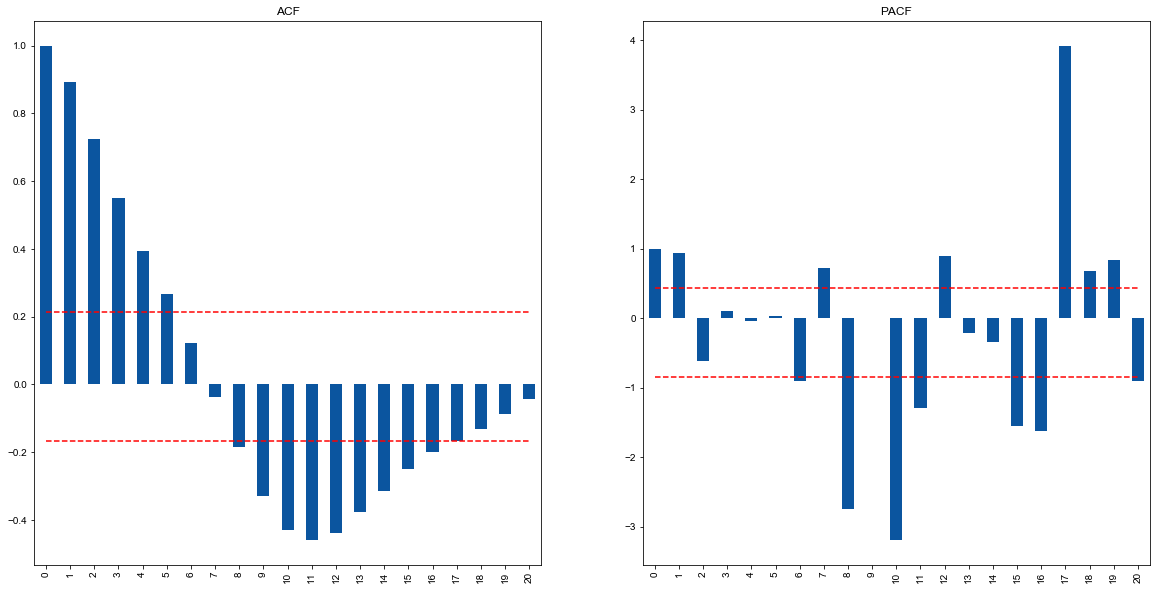

In [220]:
## Analyze many upcoming events

many = grouped_upsample('upcomingEvents', 'many')
many, transform_value = log_transform(many.unified_metric)
plot_acf(many, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


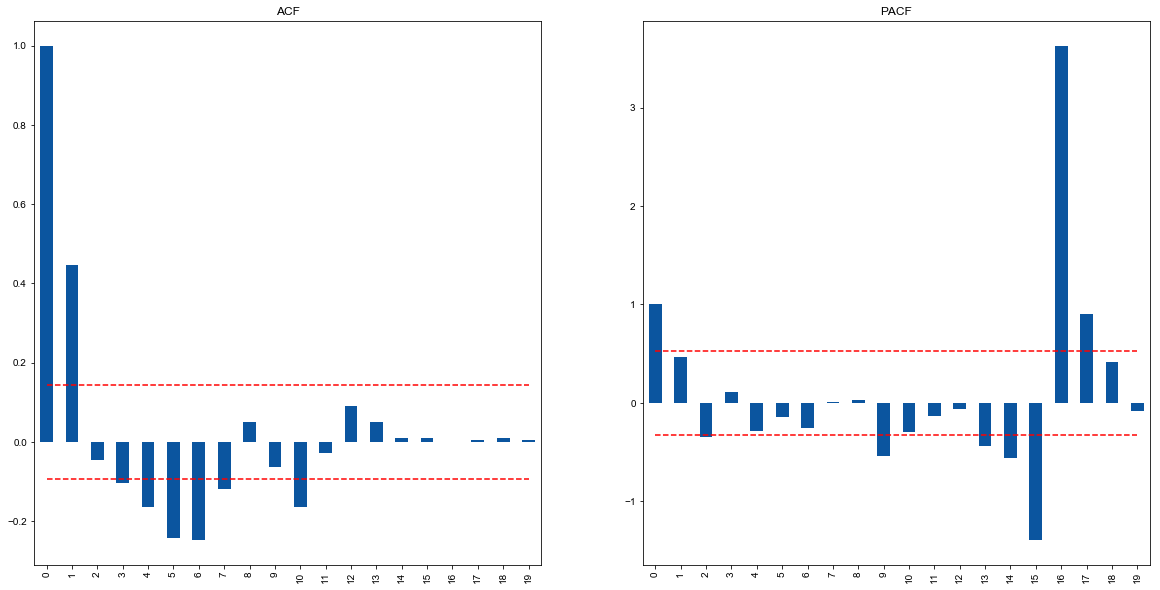

In [221]:
# Update differencing and replot residuals

lag1 = ARIMA(many,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   9.980
Method:                       css-mle   S.D. of innovations              0.146
Date:                Sat, 18 Aug 2018   AIC                            -13.959
Time:                        22:16:42   BIC                            -10.972
Sample:                    07-29-2018   HQIC                           -13.376
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0444      0.055      0.801      0.433      -0.064       0.153
ar.L1.D.unified_metric     0.4300      0.194      2.214      0.040       0.049       0.811
    

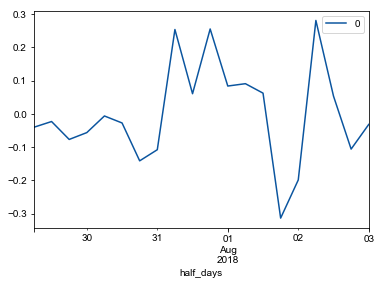

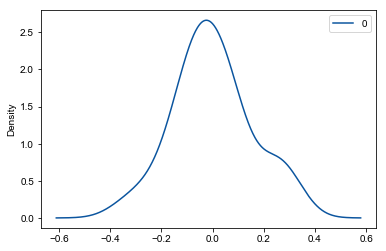

               0
count  20.000000
mean    0.000858
std     0.150009
min    -0.313186
25%    -0.083873
50%    -0.024923
75%     0.067941
max     0.281187
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  11.035
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sat, 18 Aug 2018   AIC                            -16.070
Time:                        22:16:42   BIC                            -13.083
Sample:                    07-29-2018   HQIC                           -15.487
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0461

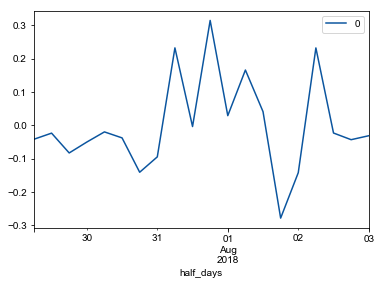

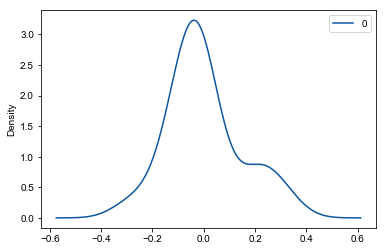

               0
count  20.000000
mean    0.000300
std     0.141548
min    -0.278358
25%    -0.058228
50%    -0.027187
75%     0.032198
max     0.314997
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  11.039
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sat, 18 Aug 2018   AIC                            -14.078
Time:                        22:16:43   BIC                            -10.095
Sample:                    07-29-2018   HQIC                           -13.300
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0460

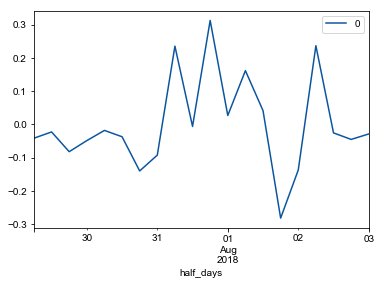

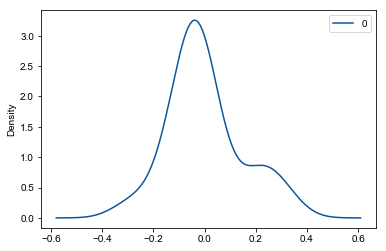

               0
count  20.000000
mean    0.000339
std     0.141501
min    -0.281799
25%    -0.057099
50%    -0.027162
75%     0.030412
max     0.312526
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  11.065
Method:                       css-mle   S.D. of innovations              0.138
Date:                Sat, 18 Aug 2018   AIC                            -12.131
Time:                        22:16:43   BIC                             -7.152
Sample:                    07-29-2018   HQIC                           -11.159
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0466

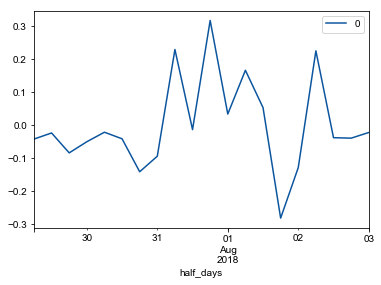

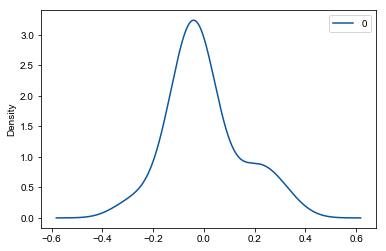

               0
count  20.000000
mean    0.000241
std     0.141281
min    -0.282107
25%    -0.058711
50%    -0.030805
75%     0.038683
max     0.317929
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  10.868
Method:                       css-mle   S.D. of innovations              0.139
Date:                Sat, 18 Aug 2018   AIC                            -13.737
Time:                        22:16:44   BIC                             -9.754
Sample:                    07-29-2018   HQIC                           -12.959
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0480

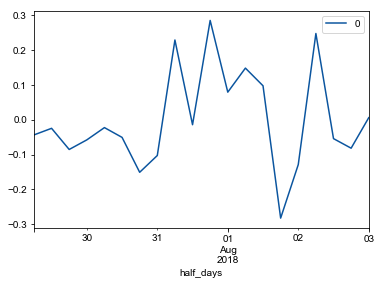

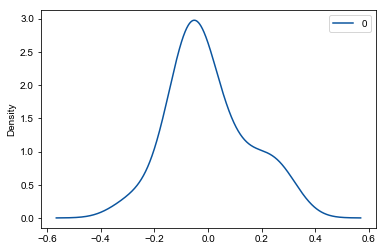

               0
count  20.000000
mean   -0.000269
std     0.142929
min    -0.282236
25%    -0.082492
50%    -0.034011
75%     0.083825
max     0.285062


In [222]:
# Select params

arima_analysis(many, (1,1,0))
arima_analysis(many, (0,1,1))
arima_analysis(many, (1,1,1))
arima_analysis(many, (2,1,1))
arima_analysis(many, (2,1,0))

In [223]:
# Update DF with new values

ARIMA_models.loc[('upcomingEvents','many')] = ((0,1,1), many, -33.169, transform_value)

#### Upcoming Events - Very Many

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


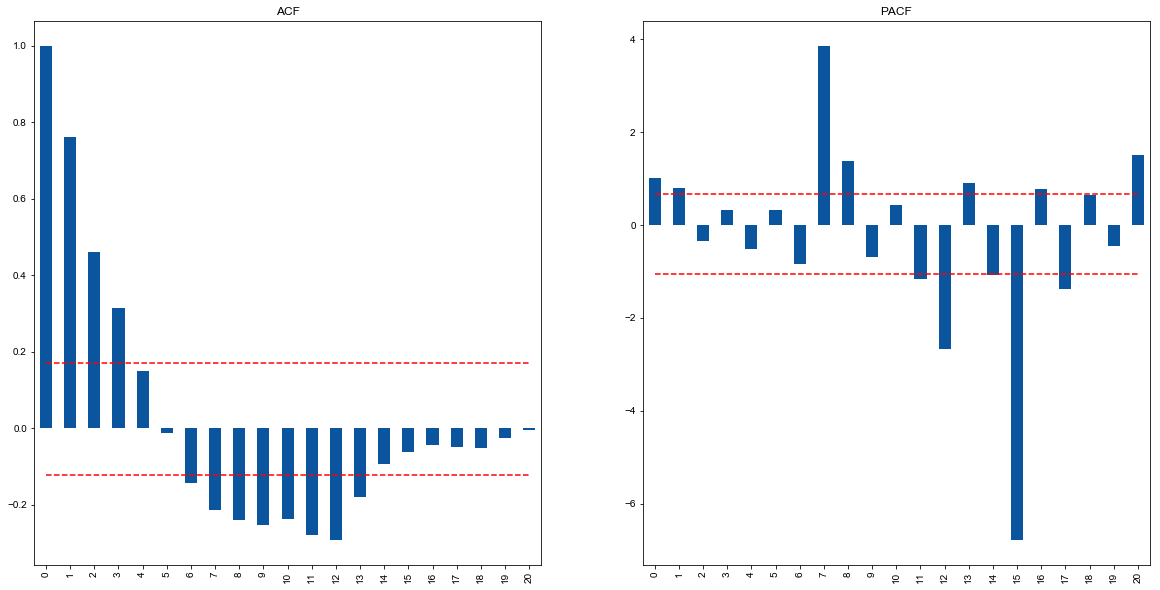

In [224]:
## Analyze very many upcoming events

vmany = grouped_upsample('upcomingEvents', 'very many')
vmany, transform_value = log_transform(vmany.unified_metric)
plot_acf(vmany, 20)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


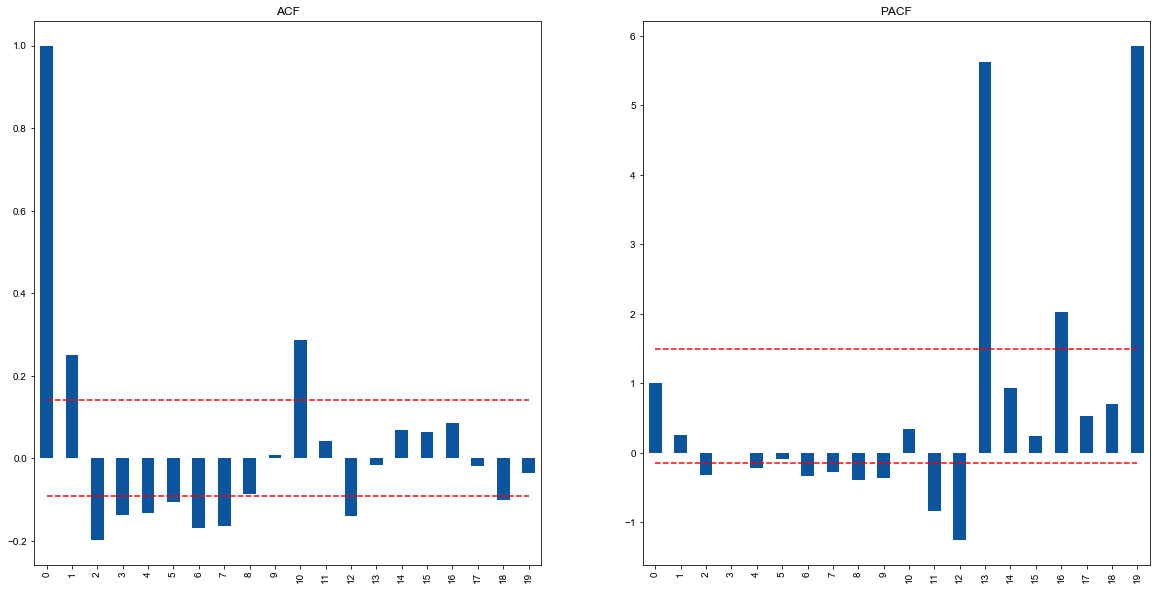

In [225]:
# Update differencing and replot residuals

lag1 = ARIMA(vmany,(0,1,0)).fit(disp=0)
plot_acf(lag1.resid, 19)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  -5.051
Method:                       css-mle   S.D. of innovations              0.311
Date:                Sat, 18 Aug 2018   AIC                             16.102
Time:                        22:16:45   BIC                             19.089
Sample:                    07-29-2018   HQIC                            16.685
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0336      0.092      0.364      0.720      -0.147       0.214
ar.L1.D.unified_metric     0.2588      0.219      1.183      0.252      -0.170       0.687
    

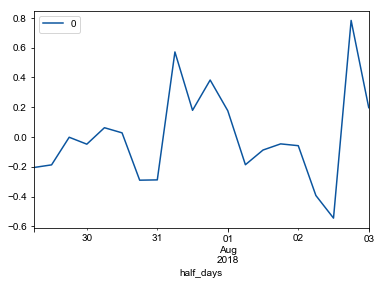

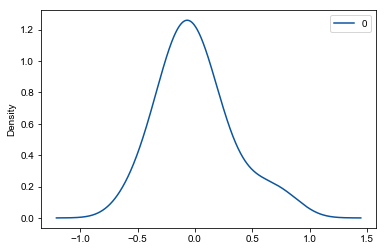

               0
count  20.000000
mean    0.002643
std     0.319248
min    -0.544172
25%    -0.191072
50%    -0.046737
75%     0.177404
max     0.783062
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -4.643
Method:                       css-mle   S.D. of innovations              0.304
Date:                Sat, 18 Aug 2018   AIC                             15.286
Time:                        22:16:46   BIC                             18.273
Sample:                    07-29-2018   HQIC                            15.869
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0296

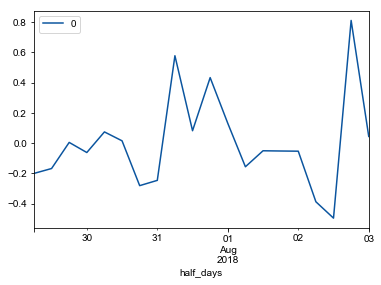

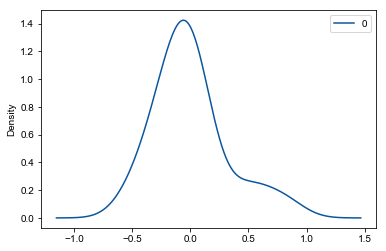

               0
count  20.000000
mean    0.001174
std     0.312335
min    -0.495906
25%    -0.175923
50%    -0.051169
75%     0.076328
max     0.811756
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  -2.882
Method:                       css-mle   S.D. of innovations              0.263
Date:                Sat, 18 Aug 2018   AIC                             15.763
Time:                        22:16:46   BIC                             20.742
Sample:                    07-29-2018   HQIC                            16.735
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0479

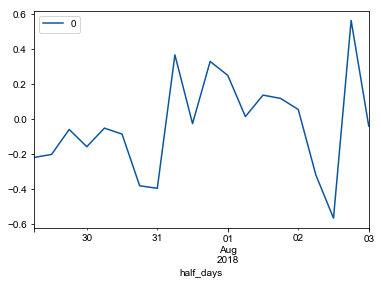

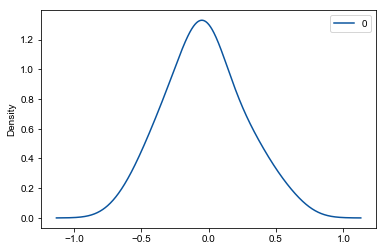

               0
count  20.000000
mean   -0.032683
std     0.280096
min    -0.565075
25%    -0.205537
50%    -0.044848
75%     0.123567
max     0.564542
                             ARIMA Model Results                              
Dep. Variable:       D.unified_metric   No. Observations:                   20
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  -4.285
Method:                       css-mle   S.D. of innovations              0.298
Date:                Sat, 18 Aug 2018   AIC                             16.570
Time:                        22:16:47   BIC                             20.553
Sample:                    07-29-2018   HQIC                            17.348
                         - 08-03-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0251

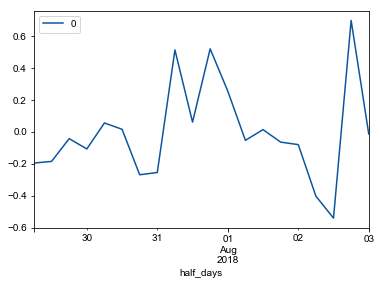

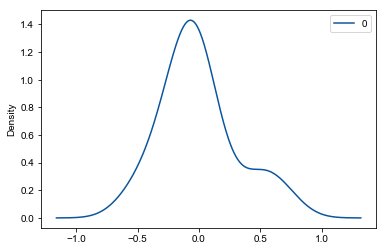

               0
count  20.000000
mean   -0.004034
std     0.306423
min    -0.540790
25%    -0.188029
50%    -0.048201
75%     0.056675
max     0.697658


In [226]:
# Select params

arima_analysis(vmany, (1,1,0))
arima_analysis(vmany, (0,1,1))
arima_analysis(vmany, (2,1,1))
arima_analysis(vmany, (2,1,0))

In [227]:
# Update DF with new values

ARIMA_models.loc[('upcomingEvents','very many')] = ((0,1,1), vmany, -2.895, transform_value)

In [228]:
ARIMA_models

model_params  \
feature                category                          
classificationGenre    Dance/Electronic      (0, 1, 1)   
                       Rock                  (1, 1, 0)   
                       R&B                   (0, 0, 1)   
                       Hip-Hop/Rap           (0, 0, 1)   
                       Religious             (2, 0, 0)   
                       Country               (1, 1, 1)   
                       Undefined             (1, 1, 1)   
                       Pop                   (0, 1, 1)   
                       Folk                  (0, 0, 1)   
                       World                 (0, 1, 1)   
                       Metal                 (1, 0, 1)   
                       Other                 (1, 1, 1)   
                       Blues                 (1, 0, 1)   
                       Jazz                  (0, 1, 1)   
                       Reggae                (1, 0, 1)   
                       Classical             (1, 1, 0)   
                       New Age               (0, 1, 1)   
                       Ballads/Romantic      (1, 1, 1)   
classificationSubGenre Club Dance            (0, 1, 1)   
                       Pop                   (2, 1, 1)   
                       Alternative Rock      (0, 1, 1)   
                       Soul                  (1, 0, 1)   
                       Urban                 (0, 0, 1)   
                       Reggaeton             (0, 1, 1)   
                       Gospel                (2, 0, 0)   
                       Country               (1, 1, 1)   
                       Undefined             (1, 1, 1)   
                       Folk                  (0, 0, 1)   
                       World                 (0, 1, 1)   
                       R&B                   (0, 0, 1)   
                       Heavy Metal           (1, 0, 1)   
                       Other                 (1, 1, 1)   
                       Latin                 (1, 1, 1)   
                       Oldies & Classics     (0, 0, 2)   
                       Blues                 (1, 0, 1)   
                       Jazz                  (0, 1, 1)   
                       Reggae                (1, 0, 1)   
                       Punk                  (0, 0, 1)   
                       Adult Contemporary    (0, 0, 1)   
                       Classical/Vocal       (1, 1, 0)   
                       Funk                  (2, 0, 1)   
                       New Age               (0, 1, 1)   
                       Flamenco              (0, 1, 1)   
                       Ballads/Romantic      (1, 1, 1)   
presales               1                     (1, 0, 1)   
                       0                     (0, 1, 1)   
citySize               small                 (1, 1, 0)   
                       large                 (1, 1, 1)   
                       medium                (1, 0, 1)   
                       very large            (0, 1, 1)   
upcomingEvents         some                  (2, 1, 1)   
                       few                   (0, 1, 1)   
                       very many             (0, 1, 1)   
                       many                  (0, 1, 1)   

                                                                                 model_train  \
feature                category                                                                
classificationGenre    Dance/Electronic    half_days
2018-07-29 00:00:00    4.354764
2018...   
                       Rock                half_days
2018-07-29 00:00:00    5.500537
2018...   
                       R&B                 half_days
2018-07-29 00:00:00    6.774101
2018...   
                       Hip-Hop/Rap         half_days
2018-07-29 00:00:00    5.228847
2018...   
                       Religious           half_days
2018-07-29 00:00:00    7.143225
2018...   
                       Country             half_days
2018-07-29 00:00:00    4.967565
2018...   
                       Un

We now have a dataframe of models fit to all our categorical features of significance, as well as log transform values to convert our predict results.

The final thing we'll do is create weights for each model by:
1. Adding 2x the difference to the maximum value to invert the values
2. Setting the new minimum value (formerly maximum value) to 1 and scaling accordingly

In [229]:
## Create column for weights

# Invert values by adding 2x difference to max value
ARIMA_models['weights'] = ARIMA_models.AIC + (ARIMA_models.AIC.max() - ARIMA_models.AIC)*2

# Convert new min value to 1 and scale
ARIMA_models['weights'] = ARIMA_models.weights / ARIMA_models.weights.min()

In [230]:
ARIMA_models

model_params  \
feature                category                          
classificationGenre    Dance/Electronic      (0, 1, 1)   
                       Rock                  (1, 1, 0)   
                       R&B                   (0, 0, 1)   
                       Hip-Hop/Rap           (0, 0, 1)   
                       Religious             (2, 0, 0)   
                       Country               (1, 1, 1)   
                       Undefined             (1, 1, 1)   
                       Pop                   (0, 1, 1)   
                       Folk                  (0, 0, 1)   
                       World                 (0, 1, 1)   
                       Metal                 (1, 0, 1)   
                       Other                 (1, 1, 1)   
                       Blues                 (1, 0, 1)   
                       Jazz                  (0, 1, 1)   
                       Reggae                (1, 0, 1)   
                       Classical             (1, 1, 0)   
                       New Age               (0, 1, 1)   
                       Ballads/Romantic      (1, 1, 1)   
classificationSubGenre Club Dance            (0, 1, 1)   
                       Pop                   (2, 1, 1)   
                       Alternative Rock      (0, 1, 1)   
                       Soul                  (1, 0, 1)   
                       Urban                 (0, 0, 1)   
                       Reggaeton             (0, 1, 1)   
                       Gospel                (2, 0, 0)   
                       Country               (1, 1, 1)   
                       Undefined             (1, 1, 1)   
                       Folk                  (0, 0, 1)   
                       World                 (0, 1, 1)   
                       R&B                   (0, 0, 1)   
                       Heavy Metal           (1, 0, 1)   
                       Other                 (1, 1, 1)   
                       Latin                 (1, 1, 1)   
                       Oldies & Classics     (0, 0, 2)   
                       Blues                 (1, 0, 1)   
                       Jazz                  (0, 1, 1)   
                       Reggae                (1, 0, 1)   
                       Punk                  (0, 0, 1)   
                       Adult Contemporary    (0, 0, 1)   
                       Classical/Vocal       (1, 1, 0)   
                       Funk                  (2, 0, 1)   
                       New Age               (0, 1, 1)   
                       Flamenco              (0, 1, 1)   
                       Ballads/Romantic      (1, 1, 1)   
presales               1                     (1, 0, 1)   
                       0                     (0, 1, 1)   
citySize               small                 (1, 1, 0)   
                       large                 (1, 1, 1)   
                       medium                (1, 0, 1)   
                       very large            (0, 1, 1)   
upcomingEvents         some                  (2, 1, 1)   
                       few                   (0, 1, 1)   
                       very many             (0, 1, 1)   
                       many                  (0, 1, 1)   

                                                                                 model_train  \
feature                category                                                                
classificationGenre    Dance/Electronic    half_days
2018-07-29 00:00:00    4.354764
2018...   
                       Rock                half_days
2018-07-29 00:00:00    5.500537
2018...   
                       R&B                 half_days
2018-07-29 00:00:00    6.774101
2018...   
                       Hip-Hop/Rap         half_days
2018-07-29 00:00:00    5.228847
2018...   
                       Religious           half_days
2018-07-29 00:00:00    7.143225
2018...   
                       Country             half_days
2018-07-29 00:00:00    4.967565
2018...   
                       Un

## Ensembling

Now to put all the pieces together. Let's write a function that:

1. Filters out uninteresting events using our supervised learning model
2. Creates a forecast of our unified metric using the weighted mean of relevant ARIMA models
3. Returns date ranges where our unified metric breaks 500
4. Returns predictions for price difference and ticket change values on those dates

In [239]:
X = df_analysis[df_analysis['half_days'] == df_analysis['half_days'].iloc[9000]]
X_layer1 = X[['classificationGenre','classificationSubGenre','presales','attractionCount',
              'artist_totalupcomingEvents','cityPop','maxPrice','minPrice']]
X_layer1 = pd.get_dummies(X_layer1, columns=['classificationGenre','classificationSubGenre'])

                # Run model and extract events of interest
layer1_predict = layer_1.predict(X_layer1)
filtered_idx = X_layer1.index[layer1_predict.nonzero()[0]]  # Retrieve index of all positive predictions
filtered_events = X.loc[filtered_idx]  # Narrow field of events to positive predictions
    
    
    ## Layer 2 - ARIMA Models
    
    # Create DF to store results
results = pd.DataFrame(columns=['forecast_date','unified_metric','eventID','eventName'])
    
    # Isolate features for ARIMA models
X_layer2 = filtered_events[['datetime','eventStartDateTime','tm_Id','eventName','classificationGenre',
                                'classificationSubGenre','presales','citySize','upcomingEvents']]

In [262]:
# Instantiate for loop
for count, i in enumerate(X_layer2.index):
    # Set empty array for model weights and results
    weights = []
    forecasts = []
    
    # Pull model results by feature
    for feature in ['classificationGenre','classificationSubGenre','presales','citySize','upcomingEvents']:

        # Set model, start & end params (rounding down to current day)
        model_params = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'model_params']
        model_train = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'model_train']
        model = ARIMA(model_train, order=model_params).fit(disp=0)
        start = X_layer2.loc[i, 'datetime'].replace(microsecond=0, second=0, minute=0, hour=0) + timedelta(days=1)
        end = X_layer2.loc[i, 'eventStartDateTime'].replace(microsecond=0, second=0, minute=0, hour=0)
        
        # Call predictions, transform log responses back, and append to results
        model_predict = model.predict(start=start, end=end)
        model_predict = np.exp(model_predict) + ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'log_transform']
        forecasts.append(model_predict)
        
        # Append model weight to array
        weight = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'weights'] 
        weights.append(weight)
        
        print(feature)
        
        
    # Set Series to hold values
    forecast_aggregated = pd.Series(data=0, index=forecasts[0].index)
    
    # Aggregate results using weights
    for weight, forecast in zip(weights, forecasts):
        forecast_aggregated = forecast_aggregated + (forecast * weight / sum(weights))
        
    # Create DF with top 5 forecast values
    top_5_forecasts = pd.DataFrame()
    top_5_forecasts['forecast_date'] = forecast_aggregated.index
    top_5_forecasts['unified_metric'] = forecast_aggregated.values
    top_5_forecasts['eventID'] = X_layer2.loc[i, 'tm_Id']
    top_5_forecasts['eventName'] = X_layer2.loc[i, 'eventName']
    
    # Add to results
    results = results.append(top_5_forecasts)
    
    print(count)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
0
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
1
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
2
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
3
classificationGenre
classificationSubGenre


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


presales
citySize
upcomingEvents
4
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
5
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
6
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
7
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
8
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
9
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
10
classificationGenre
classificationSubGenre
presales
citySize
upcomingEvents
11
classificationGenre
classificationSubGenre
presales
citySize


KeyboardInterrupt: 

In [269]:
def ticket_arbitrage_model (tm_data):
    ### Function written to handle inputs from Ticketmaster data processor
    
    ## Layer 1 - Supervised Learning 
    
    # Isolate relevant features for supervised learning model
    X_layer1 = tm_data[['classificationGenre','classificationSubGenre','presales','attractionCount',
                 'artist_totalupcomingEvents','cityPop','maxPrice','minPrice']]
    X_layer1 = pd.get_dummies(X_layer1, columns=['classificationGenre','classificationSubGenre'])
    # Run model and extract events of interest
    layer1_predict = layer_1.predict(X_layer1)
    filtered_idx = X_layer1.index[layer1_predict.nonzero()[0]]  # Retrieve index of all positive predictions
    filtered_events = X.loc[filtered_idx]  # Narrow series to positive predictions
    
    
    ## Layer 2 - ARIMA Models
    
    # Create DF to store results
    results = pd.DataFrame(columns=['eventID','eventName','forecast_date','unified_metric'])
    
    # Isolate features for ARIMA models
    X_layer2 = filtered_events[['datetime','eventStartDateTime','tm_Id','eventName','classificationGenre',
                                'classificationSubGenre','presales','citySize','upcomingEvents']]
    
    # Instantiate for loop
    for count, i in enumerate(X_layer2.index):
        # Set empty array for model weights and results
        weights = []
        forecasts = []

        # Pull model results by feature
        for feature in ['classificationGenre','classificationSubGenre','presales','citySize','upcomingEvents']:

            # Set model, start & end params (rounding down to current day)
            model_params = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'model_params']
            model_train = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'model_train']
            model = ARIMA(model_train, order=model_params).fit(disp=0)
            start = X_layer2.loc[i, 'datetime'].replace(microsecond=0, second=0, minute=0, hour=0) + timedelta(days=1)
            end = X_layer2.loc[i, 'eventStartDateTime'].replace(microsecond=0, second=0, minute=0, hour=0)

            # Call predictions, transform log responses back, and append to results
            model_predict = model.predict(start=start, end=end)
            model_predict = np.exp(model_predict) + ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'log_transform']
            forecasts.append(model_predict)

            # Append model weight to array
            weight = ARIMA_models.loc[(feature, X_layer2.loc[i, feature]), 'weights'] 
            weights.append(weight)


        # Set Series to hold values
        forecast_aggregated = pd.Series(data=0, index=forecasts[0].index)

        # Aggregate results using weights
        for weight, forecast in zip(weights, forecasts):
            forecast_aggregated = forecast_aggregated + (forecast * weight / sum(weights))

        # Create DF with top 5 forecast values
        all_forecasts = pd.DataFrame()
        all_forecasts['forecast_date'] = forecast_aggregated.index
        all_forecasts['unified_metric'] = forecast_aggregated.values
        all_forecasts['eventID'] = X_layer2.loc[i, 'tm_Id']
        all_forecasts['eventName'] = X_layer2.loc[i, 'eventName']

        # Add to results
        results = results.append(all_forecasts)

        print(count)
    
    return results

In [270]:
X = df_analysis[df_analysis['half_days'] == df_analysis['half_days'].iloc[9000]]

forecasts = ticket_arbitrage_model(X)

/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


0
1
2
3


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


386


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1090


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/Albert/a

1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1937
1938
1939
1940
1941
1942
1943
1944
1945
1946


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2026
2027


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766


/Users/Albert/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833


And here are our results! I'll pull the top few events to take a peek at

In [316]:
valuable_events = forecasts[forecasts['unified_metric'] > 400]
valuable_events = test[test['forecast_date'] > datetime]
valuable_events = valuable_events.eventID.unique()

In [325]:
df_analysis.drop_duplicates(subset='tm_Id').set_index('tm_Id').loc[valuable_events][['attractionName','attractionCount','artist_totalupcomingEvents','classificationGenre','classificationSubGenre','venueName','venueCity','presales','promoters']]

attractionName  attractionCount  artist_totalupcomingEvents  \
tm_Id                                                                           
k7vGF4FnS94gu       Arlo Guthrie              1.0                        14.0   
G5vYZ4uSq_fDv      Jackie Greene              1.0                         5.0   
vvG1fZ45QgCS5o      I'm With Her              1.0                        16.0   
vvG1bZ4G6L-Eal    Tyler Childers              1.0                        45.0   
17AOvfG6u9M7zsb   Tyler Childers              1.0                        45.0   
vvG1IZ4u60cewy        Rebelution              3.0                        16.0   
vvG1OZ45NGaUOm      Arlo Guthrie              1.0                        14.0   
vvG1FZ41OcceoU      Ziggy Marley              4.0                        19.0   
vvG17Z4u9qARia   The Paper Kites              1.0                        11.0   

                classificationGenre classificationSubGenre  \
tm_Id                                                        
k7vGF4FnS94gu                  Folk                   Folk   
G5vYZ4uSq_fDv                  Folk                   Folk   
vvG1fZ45QgCS5o                 Folk                   Folk   
vvG1bZ4G6L-Eal                 Folk                   Folk   
17AOvfG6u9M7zsb                Folk                   Folk   
vvG1IZ4u60cewy               Reggae                 Reggae   
vvG1OZ45NGaUOm                 Folk                   Folk   
vvG1FZ41OcceoU               Reggae                 Reggae   
vvG17Z4u9qARia                 Folk                   Folk   

                                                         venueName  \
tm_Id                                                                
k7vGF4FnS94gu                             NYCB Theatre at Westbury   
G5vYZ4uSq_fDv                                         The Fillmore   
vvG1fZ45QgCS5o                                    Southern Theatre   
vvG1bZ4G6L-Eal                                     Varsity Theater   
17AOvfG6u9M7zsb  The Louisville Palace presented by Cricket Wir...   
vvG1IZ4u60cewy                              Neal S Blaisdell Arena   
vvG1OZ45NGaUOm                                    Michigan Theater   
vvG1FZ41OcceoU                           Skyline Stage at the Mann   
vvG17Z4u9qARia                                  Paradise Rock Club   

                     venueCity  presales                      promoters  
tm_Id                                                                    
k7vGF4FnS94gu         Westbury         1              LIVE NATION MUSIC  
G5vYZ4uSq_fDv    San Francisco         1              LIVE NATION MUSIC  
vvG1fZ45QgCS5o        Columbus         1  COLUMBUS ASSOC. FOR PERF.ARTS  
vvG1bZ4G6L-Eal     Minneapolis         1              LIVE NATION MUSIC  
17AOvfG6u9M7zsb     Louisville         1              LIVE NATION MUSIC  
vvG1IZ4u60cewy        Honolulu         1              PROMOTED BY VENUE  
vvG1OZ45NGaUOm       Ann Arbor         1              PROMOTED BY VENUE  
vvG1FZ41OcceoU    Philadelphia         1                       AEG LIVE  
vvG17Z4u9qARia          Boston         1            CROSSROADS PRESENTS

Looks like folk music is quite popular

-------

## And also I made some word clouds for fun!

In [ ]:
## Reset X and Y predict values

# Group by event
max_value = df_analysis.groupby(['tm_Id']).max()[['unified_metric','classificationGenre','classificationSubGenre',
                                                  'presales','attractionCount','artist_totalupcomingEvents',
                                                  'cityPop','maxPrice','minPrice','days_from_sale','days_to_event',
                                                  'citySize','upcomingEvents'
                                                 ]]

# Set categorical predict value
max_value['unified_metric_dummy'] = np.where(max_value.unified_metric >= 500, 1, 0)
y_orig = max_value.unified_metric_dummy

# Set feature matrix
X_orig = max_value[['classificationGenre','classificationSubGenre','presales','attractionCount',
                 'artist_totalupcomingEvents','cityPop','maxPrice','minPrice']]
X_orig = pd.get_dummies(X_orig, columns=['classificationGenre','classificationSubGenre'])
X_dummies = pd.get_dummies(max_value[['classificationGenre','classificationSubGenre','presales','citySize','upcomingEvents']])

# Resample data so that we have an equal distribution of positives and negaties
ratio = sampler(ratio={0:1441, 1:1441})
X, y = ratio.fit_sample(X_orig, y_orig)
X_dummies_, y_dummies = ratio.fit_sample(X_dummies, y_orig)

In [ ]:
importance1 = GBC(n_estimators=20).fit(X,y).feature_importances_
importance2 = RFC(n_estimators=20).fit(X,y).feature_importances_
importance1_dummies = GBC(n_estimators=20).fit(X_dummies_,y_dummies).feature_importances_
importance2_dummies = RFC(n_estimators=20).fit(X_dummies_,y_dummies).feature_importances_

In [ ]:
ft_importance = pd.DataFrame({'features':X_orig.columns, 'importance1':importance1, 'importance2':importance2})
ft_importance_dummies = pd.DataFrame({'features':X_dummies.columns, 'importance1':importance1_dummies, 'importance2':importance2_dummies})

In [ ]:
ft_importance['importance'] = (ft_importance.importance1 + ft_importance.importance2)/2
ft_importance.sort_values('importance', ascending=False, inplace=True)
ft_importance['importance_rounded'] = ft_importance.importance*1000//1

In [ ]:
ft_importance_dummies['importance'] = (ft_importance_dummies.importance1 + ft_importance_dummies.importance2)/2
ft_importance_dummies.sort_values('importance', ascending=False, inplace=True)
ft_importance_dummies['importance_rounded'] = ft_importance_dummies.importance*1000//1

In [ ]:
ft_importance = ft_importance[ft_importance.importance_rounded > 0]
ft_importance_dummies = ft_importance_dummies[ft_importance_dummies.importance_rounded > 0]

In [ ]:
words = ''
for i in ft_importance.index:
    word = ft_importance.loc[i,'features']
    words = words + ((word + ' ')*int(ft_importance.loc[i, 'importance_rounded']))

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=500, collocations=False, background_color='white', colormap='Blues').generate((words))
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [ ]:
words = ''
for i in ft_importance_dummies.index:
    word = ft_importance_dummies.loc[i,'features']
    words = words + ((word + ' ')*int(ft_importance_dummies.loc[i, 'importance_rounded']))

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1000, height=500, collocations=False, background_color='white', colormap='Blues').generate((words))
plt.figure(figsize=(30,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()